In [ ]:
!pip install transformers
# https://huggingface.co/transformers/installation.html
!pip install sentencepiece
# https://pypi.org/project/sentencepiece/
# Python wrapper for SentencePiece. This API will offer the encoding, decoding and training of Sentencepiece.
!pip install Cython
# https://pypi.org/project/Cython/

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Importing the required packages:

---



In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import os
import sys
import transformers
from transformers.optimization import Adafactor 
import time
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)
import torch
import random
import re

#os.chdir('/content/drive/MyDrive/NLP-Project/')

In [ ]:
import pandas as pd
# Reading csv
data = pd.read_csv('dataset.csv', header=None, names=['inputs', 'target'])
print(data.head(5))

                                      inputs  target
0  The sum of 875 and <extra_id_0>21 is 1096       2
1  The sum of 875 and 221 is <extra_id_0>096       1
2    The sum of <extra_id_0>33 and 27 is 360       3
3    The sum of 333 and <extra_id_0>7 is 360       2
4  The sum of 855 and 7<extra_id_0>8 is 1583       2


In [ ]:
data = data.sample(n = 40000, random_state = 42).reset_index(drop=True)

In [ ]:
from sklearn.model_selection import train_test_split

# Test and validation split
train, validation = train_test_split(data, test_size=0.3, random_state=42)
train, test = train_test_split(train, test_size=0.4, random_state=42)

data_train = train.reset_index(drop=True)
data_valid = validation.reset_index(drop=True)
data_test = test.reset_index(drop=True)

In [ ]:
data_train_inter.shape

(16800, 2)

In [ ]:
data_valid_inter.shape

(12000, 2)

In [ ]:
# Initializing Parameters 
batch_size, num_of_epochs = 32, 50
num_of_batches = int(len(data_train)/batch_size)

<AxesSubplot:>

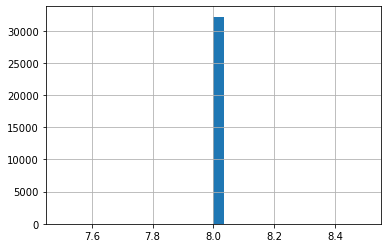

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in data_train['inputs']]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
# T5-base
tokenizer = T5Tokenizer.from_pretrained('t5-base')

model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
# moving the model to device(GPU/CPU)
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [ ]:
token_lens = []

for txt in data_train.inputs:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

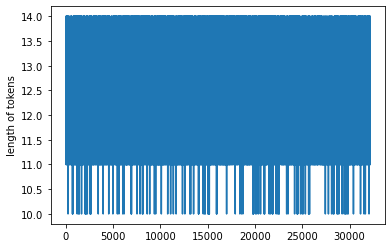

Maximum length is:  14


In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(token_lens)+1), token_lens)
plt.ylabel('length of tokens')
plt.show()

MAX_LEN = max(token_lens)
print("Maximum length is: ", MAX_LEN)

In [ ]:
MAX_LEN = 20

In [ ]:
def get_word_embeddings(data):
    input_ids=[]
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,  
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

  # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Run function `preprocessing_for_bert` on the train set and the validation set
train_inputs, train_masks = get_word_embeddings(data_train['inputs'])
val_inputs, val_masks = get_word_embeddings(data_valid['inputs'])
test_inputs, test_masks = get_word_embeddings(data_test['inputs'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
D:\Software\Anaconda\lib\site-packages\transformers\tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
data_train['target_str'] = data_train['target'].astype(str)
data_valid['target_str'] = data_valid['target'].astype(str)
data_test['target_str'] = data_test['target'].astype(str)

In [ ]:
#convert lists to tensors
train_labels = get_word_embeddings(data_train['target_str'])[0]
val_labels = get_word_embeddings(data_valid['target_str'])[0]
test_labels = get_word_embeddings(data_test['target_str'])[0]

In [ ]:
train_labels.shape

torch.Size([32179, 20])

In [ ]:
data_train['target']

0         8
1         6
2        47
3         0
4         2
         ..
32174     1
32175     8
32176     2
32177    56
32178    17
Name: target, Length: 32179, dtype: int64

In [ ]:
train_labels_inter.shape

torch.Size([16800, 20])

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, shuffle = True, batch_size = batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, shuffle = True, batch_size = batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, shuffle = True, batch_size = batch_size)

In [ ]:
#  Optimizer
# https://huggingface.co/transformers/model_doc/t5.html#overview
optimizer = Adafactor(
    model.parameters(),
    lr=5e-4, # Initializing the learning Rate as suggested in the T5 official documentation
    eps=(1e-8, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.3,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

In [ ]:
from IPython.display import HTML, display

# Setting the progress, with html as UI.
def progress(loss, value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [ ]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    v_accuracy = []
    v_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        
        v_input_ids, v_attn_mask, v_labels = tuple(t.to(device) for t in batch)

        # print(v_input_ids.shape, v_labels.shape)

        val_outputs = model.generate(input_ids=v_input_ids, attention_mask=v_attn_mask)

        val_preds = [ tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for output in val_outputs]

        val_labels = [ tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for output in v_labels]
        
        # v_loss.append(val_outputs.loss)

        # Get the predictions
        # print(val_outputs.logits.shape)
        # val_preds = torch.argmax(val_outputs.logits, dim=1).flatten()
        # print(val_preds, val_labels)
        # Calculate the accuracy rate

        val_preds = np.array(val_preds)
        val_labels = np.array(val_labels)
        accuracy = ((val_preds == val_labels).sum() / len(val_labels)) * 100
        v_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    # v_loss = np.mean(v_loss)
    v_accuracy = np.mean(v_accuracy)

    return v_accuracy

In [ ]:
# Function to generate sentences from symptoms on the test dataset
def predictSum(text, target):
    model.eval()
    model.to("cpu")
    numbers = [num for num in text.split() if num.isdigit()]
    op1, op2 = numbers[0], numbers[1]
    maxlen = max(len(str(op1)), len(str(op2)))
    minlen = min(len(str(op1)), len(str(op2)))
    input_ids = tokenizer.encode(text, return_tensors="pt")  # Batch size 1
    # s = time.time()
    input_ids.to("cpu")
    outputs = model.generate(input_ids)
    prediction=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
    # elapsed = time.time() - s
    # print('Generated in {} seconds'.format(str(elapsed)[:4]))
    predictlen = len(str(prediction))
    tmp = [text, minlen, maxlen, predictlen, target, prediction]
    return tmp

## Pre-train, 3operands, 5e-4 and -0.03

In [ ]:
import gc

val_acc = 0
train_accuracy = 0

# Sets the module in training mode
model.train()

for epoch in range(1,num_of_epochs+1):
    print('Running epoch: {}'.format(epoch))
    running_loss=0
    # out = display(progress(1, num_of_batches+1), display_id=True)
    i =0 
    for batch in train_dataloader:
        input_ids, attn_mask, labels = tuple(t.to(device) for t in batch)

        # clear out the gradients of all Variables 
        optimizer.zero_grad()
        gc.collect()
        torch.cuda.empty_cache()

        # Forward propogation
        # print(model(input_ids=input_ids, attention_mask=attn_mask, labels=labels))
        outputs = model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)

        loss = outputs.loss
        loss_num=loss.item()
        logits = outputs.logits
        running_loss+=loss_num
        # out.update(progress(loss_num,i, num_of_batches+1))

        # calculating the gradients
        loss.backward()

        # updating the params
        optimizer.step()

        print("Epoch ", epoch, "Batch ", i, "/", len(train_dataloader), " Training Loss ", loss_num)
        i += 1

    running_loss = running_loss/len(train_dataloader)
    # v_input_ids, v_attn_mask, v_labels = tuple(t.to(device) for t in data_valid)

    curr_accuracy = evaluate(model, val_dataloader)

    # print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
    print(f"{epoch + 1:^7} | {'-':^7} | {running_loss:^12.6f} | {curr_accuracy:^9.6f}")
    print("-"*70)

    if curr_accuracy > val_acc:
        val_acc = curr_accuracy
        # Saving the best model
        torch.save(model.state_dict(),'Pretrain_NPM_3op.bin')


Running epoch: 1
Epoch  1 Batch  0 / 525  Training Loss  18.863079071044922
Epoch  1 Batch  1 / 525  Training Loss  8.888226509094238
Epoch  1 Batch  2 / 525  Training Loss  2.5964248180389404
Epoch  1 Batch  3 / 525  Training Loss  1.634514570236206
Epoch  1 Batch  4 / 525  Training Loss  1.0193078517913818
Epoch  1 Batch  5 / 525  Training Loss  0.6540965437889099
Epoch  1 Batch  6 / 525  Training Loss  0.5210062265396118
Epoch  1 Batch  7 / 525  Training Loss  0.34585070610046387
Epoch  1 Batch  8 / 525  Training Loss  0.2842172384262085
Epoch  1 Batch  9 / 525  Training Loss  0.27595651149749756
Epoch  1 Batch  10 / 525  Training Loss  0.2695380449295044
Epoch  1 Batch  11 / 525  Training Loss  0.23714599013328552
Epoch  1 Batch  12 / 525  Training Loss  0.2548668682575226
Epoch  1 Batch  13 / 525  Training Loss  0.2305338829755783
Epoch  1 Batch  14 / 525  Training Loss  0.22013136744499207
Epoch  1 Batch  15 / 525  Training Loss  0.20326487720012665
Epoch  1 Batch  16 / 525  Trai

Epoch  1 Batch  135 / 525  Training Loss  0.19765783846378326
Epoch  1 Batch  136 / 525  Training Loss  0.1805277168750763
Epoch  1 Batch  137 / 525  Training Loss  0.17998455464839935
Epoch  1 Batch  138 / 525  Training Loss  0.1900021731853485
Epoch  1 Batch  139 / 525  Training Loss  0.20393633842468262
Epoch  1 Batch  140 / 525  Training Loss  0.18625888228416443
Epoch  1 Batch  141 / 525  Training Loss  0.17933855950832367
Epoch  1 Batch  142 / 525  Training Loss  0.16979604959487915
Epoch  1 Batch  143 / 525  Training Loss  0.18455755710601807
Epoch  1 Batch  144 / 525  Training Loss  0.18925541639328003
Epoch  1 Batch  145 / 525  Training Loss  0.1825886219739914
Epoch  1 Batch  146 / 525  Training Loss  0.20542769134044647
Epoch  1 Batch  147 / 525  Training Loss  0.166683167219162
Epoch  1 Batch  148 / 525  Training Loss  0.18641377985477448
Epoch  1 Batch  149 / 525  Training Loss  0.19464340806007385
Epoch  1 Batch  150 / 525  Training Loss  0.20397870242595673
Epoch  1 Batc

Epoch  1 Batch  268 / 525  Training Loss  0.18446044623851776
Epoch  1 Batch  269 / 525  Training Loss  0.1854640543460846
Epoch  1 Batch  270 / 525  Training Loss  0.14638999104499817
Epoch  1 Batch  271 / 525  Training Loss  0.19027680158615112
Epoch  1 Batch  272 / 525  Training Loss  0.16862188279628754
Epoch  1 Batch  273 / 525  Training Loss  0.17885342240333557
Epoch  1 Batch  274 / 525  Training Loss  0.17859186232089996
Epoch  1 Batch  275 / 525  Training Loss  0.17599622905254364
Epoch  1 Batch  276 / 525  Training Loss  0.16142170131206512
Epoch  1 Batch  277 / 525  Training Loss  0.18808239698410034
Epoch  1 Batch  278 / 525  Training Loss  0.18210414052009583
Epoch  1 Batch  279 / 525  Training Loss  0.1848982870578766
Epoch  1 Batch  280 / 525  Training Loss  0.19165536761283875
Epoch  1 Batch  281 / 525  Training Loss  0.16894268989562988
Epoch  1 Batch  282 / 525  Training Loss  0.16990146040916443
Epoch  1 Batch  283 / 525  Training Loss  0.16319647431373596
Epoch  1 B

Epoch  1 Batch  401 / 525  Training Loss  0.16548438370227814
Epoch  1 Batch  402 / 525  Training Loss  0.16531303524971008
Epoch  1 Batch  403 / 525  Training Loss  0.19778437912464142
Epoch  1 Batch  404 / 525  Training Loss  0.15942062437534332
Epoch  1 Batch  405 / 525  Training Loss  0.18568561971187592
Epoch  1 Batch  406 / 525  Training Loss  0.17022016644477844
Epoch  1 Batch  407 / 525  Training Loss  0.1647629588842392
Epoch  1 Batch  408 / 525  Training Loss  0.16120906174182892
Epoch  1 Batch  409 / 525  Training Loss  0.15836399793624878
Epoch  1 Batch  410 / 525  Training Loss  0.15245947241783142
Epoch  1 Batch  411 / 525  Training Loss  0.17751018702983856
Epoch  1 Batch  412 / 525  Training Loss  0.16383804380893707
Epoch  1 Batch  413 / 525  Training Loss  0.15498004853725433
Epoch  1 Batch  414 / 525  Training Loss  0.18529072403907776
Epoch  1 Batch  415 / 525  Training Loss  0.18190370500087738
Epoch  1 Batch  416 / 525  Training Loss  0.19035598635673523
Epoch  1 

Epoch  2 Batch  7 / 525  Training Loss  0.15031519532203674
Epoch  2 Batch  8 / 525  Training Loss  0.14478909969329834
Epoch  2 Batch  9 / 525  Training Loss  0.14865612983703613
Epoch  2 Batch  10 / 525  Training Loss  0.16161565482616425
Epoch  2 Batch  11 / 525  Training Loss  0.18431456387043
Epoch  2 Batch  12 / 525  Training Loss  0.17860335111618042
Epoch  2 Batch  13 / 525  Training Loss  0.15535768866539001
Epoch  2 Batch  14 / 525  Training Loss  0.15582327544689178
Epoch  2 Batch  15 / 525  Training Loss  0.14559680223464966
Epoch  2 Batch  16 / 525  Training Loss  0.13121266663074493
Epoch  2 Batch  17 / 525  Training Loss  0.14644984900951385
Epoch  2 Batch  18 / 525  Training Loss  0.1596994549036026
Epoch  2 Batch  19 / 525  Training Loss  0.1345430314540863
Epoch  2 Batch  20 / 525  Training Loss  0.14903604984283447
Epoch  2 Batch  21 / 525  Training Loss  0.14447443187236786
Epoch  2 Batch  22 / 525  Training Loss  0.14734092354774475
Epoch  2 Batch  23 / 525  Traini

Epoch  2 Batch  142 / 525  Training Loss  0.1593354046344757
Epoch  2 Batch  143 / 525  Training Loss  0.16138797998428345
Epoch  2 Batch  144 / 525  Training Loss  0.14771459996700287
Epoch  2 Batch  145 / 525  Training Loss  0.16297854483127594
Epoch  2 Batch  146 / 525  Training Loss  0.1405731737613678
Epoch  2 Batch  147 / 525  Training Loss  0.1513659656047821
Epoch  2 Batch  148 / 525  Training Loss  0.13798415660858154
Epoch  2 Batch  149 / 525  Training Loss  0.13134905695915222
Epoch  2 Batch  150 / 525  Training Loss  0.15069417655467987
Epoch  2 Batch  151 / 525  Training Loss  0.138605535030365
Epoch  2 Batch  152 / 525  Training Loss  0.13601483404636383
Epoch  2 Batch  153 / 525  Training Loss  0.1356518566608429
Epoch  2 Batch  154 / 525  Training Loss  0.1445169746875763
Epoch  2 Batch  155 / 525  Training Loss  0.12384052574634552
Epoch  2 Batch  156 / 525  Training Loss  0.13975587487220764
Epoch  2 Batch  157 / 525  Training Loss  0.1347489058971405
Epoch  2 Batch  

Epoch  2 Batch  275 / 525  Training Loss  0.13355371356010437
Epoch  2 Batch  276 / 525  Training Loss  0.12045492976903915
Epoch  2 Batch  277 / 525  Training Loss  0.13112345337867737
Epoch  2 Batch  278 / 525  Training Loss  0.1413102000951767
Epoch  2 Batch  279 / 525  Training Loss  0.13686875998973846
Epoch  2 Batch  280 / 525  Training Loss  0.1386284977197647
Epoch  2 Batch  281 / 525  Training Loss  0.1329793632030487
Epoch  2 Batch  282 / 525  Training Loss  0.12978611886501312
Epoch  2 Batch  283 / 525  Training Loss  0.11962024867534637
Epoch  2 Batch  284 / 525  Training Loss  0.12392505258321762
Epoch  2 Batch  285 / 525  Training Loss  0.13293102383613586
Epoch  2 Batch  286 / 525  Training Loss  0.13364620506763458
Epoch  2 Batch  287 / 525  Training Loss  0.1204514354467392
Epoch  2 Batch  288 / 525  Training Loss  0.114419125020504
Epoch  2 Batch  289 / 525  Training Loss  0.12819638848304749
Epoch  2 Batch  290 / 525  Training Loss  0.14104297757148743
Epoch  2 Batch

Epoch  2 Batch  408 / 525  Training Loss  0.12149244546890259
Epoch  2 Batch  409 / 525  Training Loss  0.12670311331748962
Epoch  2 Batch  410 / 525  Training Loss  0.12783771753311157
Epoch  2 Batch  411 / 525  Training Loss  0.12332173436880112
Epoch  2 Batch  412 / 525  Training Loss  0.10676354169845581
Epoch  2 Batch  413 / 525  Training Loss  0.12465448677539825
Epoch  2 Batch  414 / 525  Training Loss  0.12009800970554352
Epoch  2 Batch  415 / 525  Training Loss  0.13649345934391022
Epoch  2 Batch  416 / 525  Training Loss  0.13446956872940063
Epoch  2 Batch  417 / 525  Training Loss  0.12240760028362274
Epoch  2 Batch  418 / 525  Training Loss  0.11123225837945938
Epoch  2 Batch  419 / 525  Training Loss  0.11413191258907318
Epoch  2 Batch  420 / 525  Training Loss  0.11247130483388901
Epoch  2 Batch  421 / 525  Training Loss  0.10708532482385635
Epoch  2 Batch  422 / 525  Training Loss  0.12084220349788666
Epoch  2 Batch  423 / 525  Training Loss  0.1217917650938034
Epoch  2 

Epoch  3 Batch  14 / 525  Training Loss  0.10829305648803711
Epoch  3 Batch  15 / 525  Training Loss  0.11267556250095367
Epoch  3 Batch  16 / 525  Training Loss  0.13207462430000305
Epoch  3 Batch  17 / 525  Training Loss  0.0962919145822525
Epoch  3 Batch  18 / 525  Training Loss  0.10069688409566879
Epoch  3 Batch  19 / 525  Training Loss  0.13677799701690674
Epoch  3 Batch  20 / 525  Training Loss  0.11137393862009048
Epoch  3 Batch  21 / 525  Training Loss  0.11121498048305511
Epoch  3 Batch  22 / 525  Training Loss  0.1123281940817833
Epoch  3 Batch  23 / 525  Training Loss  0.12576982378959656
Epoch  3 Batch  24 / 525  Training Loss  0.10545192658901215
Epoch  3 Batch  25 / 525  Training Loss  0.09721538424491882
Epoch  3 Batch  26 / 525  Training Loss  0.09645761549472809
Epoch  3 Batch  27 / 525  Training Loss  0.12126225233078003
Epoch  3 Batch  28 / 525  Training Loss  0.10882551968097687
Epoch  3 Batch  29 / 525  Training Loss  0.12015102058649063
Epoch  3 Batch  30 / 525  

Epoch  3 Batch  149 / 525  Training Loss  0.11249037832021713
Epoch  3 Batch  150 / 525  Training Loss  0.11082905530929565
Epoch  3 Batch  151 / 525  Training Loss  0.10855734348297119
Epoch  3 Batch  152 / 525  Training Loss  0.10378563404083252
Epoch  3 Batch  153 / 525  Training Loss  0.11405191570520401
Epoch  3 Batch  154 / 525  Training Loss  0.11080865561962128
Epoch  3 Batch  155 / 525  Training Loss  0.12272725254297256
Epoch  3 Batch  156 / 525  Training Loss  0.1056206002831459
Epoch  3 Batch  157 / 525  Training Loss  0.10050211101770401
Epoch  3 Batch  158 / 525  Training Loss  0.10281185060739517
Epoch  3 Batch  159 / 525  Training Loss  0.11202877759933472
Epoch  3 Batch  160 / 525  Training Loss  0.1048494428396225
Epoch  3 Batch  161 / 525  Training Loss  0.11989549547433853
Epoch  3 Batch  162 / 525  Training Loss  0.12637017667293549
Epoch  3 Batch  163 / 525  Training Loss  0.11507872492074966
Epoch  3 Batch  164 / 525  Training Loss  0.10187296569347382
Epoch  3 B

Epoch  3 Batch  282 / 525  Training Loss  0.08771055936813354
Epoch  3 Batch  283 / 525  Training Loss  0.1237582191824913
Epoch  3 Batch  284 / 525  Training Loss  0.10531125217676163
Epoch  3 Batch  285 / 525  Training Loss  0.10327378660440445
Epoch  3 Batch  286 / 525  Training Loss  0.10124123096466064
Epoch  3 Batch  287 / 525  Training Loss  0.09974433481693268
Epoch  3 Batch  288 / 525  Training Loss  0.1022663563489914
Epoch  3 Batch  289 / 525  Training Loss  0.10844864696264267
Epoch  3 Batch  290 / 525  Training Loss  0.11781448125839233
Epoch  3 Batch  291 / 525  Training Loss  0.11027703434228897
Epoch  3 Batch  292 / 525  Training Loss  0.10229114443063736
Epoch  3 Batch  293 / 525  Training Loss  0.10588494688272476
Epoch  3 Batch  294 / 525  Training Loss  0.11901652812957764
Epoch  3 Batch  295 / 525  Training Loss  0.10002310574054718
Epoch  3 Batch  296 / 525  Training Loss  0.10660061985254288
Epoch  3 Batch  297 / 525  Training Loss  0.10045097023248672
Epoch  3 B

Epoch  3 Batch  415 / 525  Training Loss  0.10346056520938873
Epoch  3 Batch  416 / 525  Training Loss  0.12445144355297089
Epoch  3 Batch  417 / 525  Training Loss  0.08613471686840057
Epoch  3 Batch  418 / 525  Training Loss  0.09303347766399384
Epoch  3 Batch  419 / 525  Training Loss  0.11237913370132446
Epoch  3 Batch  420 / 525  Training Loss  0.10775125026702881
Epoch  3 Batch  421 / 525  Training Loss  0.1015729159116745
Epoch  3 Batch  422 / 525  Training Loss  0.11282064765691757
Epoch  3 Batch  423 / 525  Training Loss  0.08734200149774551
Epoch  3 Batch  424 / 525  Training Loss  0.09711568802595139
Epoch  3 Batch  425 / 525  Training Loss  0.11332078278064728
Epoch  3 Batch  426 / 525  Training Loss  0.1197936162352562
Epoch  3 Batch  427 / 525  Training Loss  0.09358585625886917
Epoch  3 Batch  428 / 525  Training Loss  0.10062894970178604
Epoch  3 Batch  429 / 525  Training Loss  0.1261533796787262
Epoch  3 Batch  430 / 525  Training Loss  0.1127379909157753
Epoch  3 Bat

Epoch  4 Batch  21 / 525  Training Loss  0.10584483295679092
Epoch  4 Batch  22 / 525  Training Loss  0.09897451102733612
Epoch  4 Batch  23 / 525  Training Loss  0.09031198918819427
Epoch  4 Batch  24 / 525  Training Loss  0.12298323959112167
Epoch  4 Batch  25 / 525  Training Loss  0.09595506638288498
Epoch  4 Batch  26 / 525  Training Loss  0.11271693557500839
Epoch  4 Batch  27 / 525  Training Loss  0.09401512891054153
Epoch  4 Batch  28 / 525  Training Loss  0.09142662584781647
Epoch  4 Batch  29 / 525  Training Loss  0.0870433822274208
Epoch  4 Batch  30 / 525  Training Loss  0.09353618323802948
Epoch  4 Batch  31 / 525  Training Loss  0.12580755352973938
Epoch  4 Batch  32 / 525  Training Loss  0.10233265161514282
Epoch  4 Batch  33 / 525  Training Loss  0.08664525300264359
Epoch  4 Batch  34 / 525  Training Loss  0.08898594230413437
Epoch  4 Batch  35 / 525  Training Loss  0.09723378717899323
Epoch  4 Batch  36 / 525  Training Loss  0.09715413302183151
Epoch  4 Batch  37 / 525 

Epoch  4 Batch  155 / 525  Training Loss  0.08949302136898041
Epoch  4 Batch  156 / 525  Training Loss  0.0980539470911026
Epoch  4 Batch  157 / 525  Training Loss  0.10892494022846222
Epoch  4 Batch  158 / 525  Training Loss  0.09664526581764221
Epoch  4 Batch  159 / 525  Training Loss  0.09769157320261002
Epoch  4 Batch  160 / 525  Training Loss  0.09810395538806915
Epoch  4 Batch  161 / 525  Training Loss  0.10348387807607651
Epoch  4 Batch  162 / 525  Training Loss  0.07782449573278427
Epoch  4 Batch  163 / 525  Training Loss  0.10018181800842285
Epoch  4 Batch  164 / 525  Training Loss  0.11638859659433365
Epoch  4 Batch  165 / 525  Training Loss  0.09390340000391006
Epoch  4 Batch  166 / 525  Training Loss  0.0896562933921814
Epoch  4 Batch  167 / 525  Training Loss  0.08316059410572052
Epoch  4 Batch  168 / 525  Training Loss  0.08097834140062332
Epoch  4 Batch  169 / 525  Training Loss  0.08936825394630432
Epoch  4 Batch  170 / 525  Training Loss  0.09718873351812363
Epoch  4 B

Epoch  4 Batch  288 / 525  Training Loss  0.1070183515548706
Epoch  4 Batch  289 / 525  Training Loss  0.08792316168546677
Epoch  4 Batch  290 / 525  Training Loss  0.11121350526809692
Epoch  4 Batch  291 / 525  Training Loss  0.11012472957372665
Epoch  4 Batch  292 / 525  Training Loss  0.09719497710466385
Epoch  4 Batch  293 / 525  Training Loss  0.10410793870687485
Epoch  4 Batch  294 / 525  Training Loss  0.08072872459888458
Epoch  4 Batch  295 / 525  Training Loss  0.09638528525829315
Epoch  4 Batch  296 / 525  Training Loss  0.10018986463546753
Epoch  4 Batch  297 / 525  Training Loss  0.10318905115127563
Epoch  4 Batch  298 / 525  Training Loss  0.1047719269990921
Epoch  4 Batch  299 / 525  Training Loss  0.11121369898319244
Epoch  4 Batch  300 / 525  Training Loss  0.11158967018127441
Epoch  4 Batch  301 / 525  Training Loss  0.07338827103376389
Epoch  4 Batch  302 / 525  Training Loss  0.10016415268182755
Epoch  4 Batch  303 / 525  Training Loss  0.09171339869499207
Epoch  4 B

Epoch  4 Batch  421 / 525  Training Loss  0.08276708424091339
Epoch  4 Batch  422 / 525  Training Loss  0.09220509231090546
Epoch  4 Batch  423 / 525  Training Loss  0.09318137168884277
Epoch  4 Batch  424 / 525  Training Loss  0.08801974356174469
Epoch  4 Batch  425 / 525  Training Loss  0.08218467235565186
Epoch  4 Batch  426 / 525  Training Loss  0.0938630998134613
Epoch  4 Batch  427 / 525  Training Loss  0.1018986701965332
Epoch  4 Batch  428 / 525  Training Loss  0.11323714256286621
Epoch  4 Batch  429 / 525  Training Loss  0.08457614481449127
Epoch  4 Batch  430 / 525  Training Loss  0.09282092750072479
Epoch  4 Batch  431 / 525  Training Loss  0.0843370258808136
Epoch  4 Batch  432 / 525  Training Loss  0.0794774740934372
Epoch  4 Batch  433 / 525  Training Loss  0.08010825514793396
Epoch  4 Batch  434 / 525  Training Loss  0.08540026098489761
Epoch  4 Batch  435 / 525  Training Loss  0.09910035133361816
Epoch  4 Batch  436 / 525  Training Loss  0.09215344488620758
Epoch  4 Bat

Epoch  5 Batch  27 / 525  Training Loss  0.07284285128116608
Epoch  5 Batch  28 / 525  Training Loss  0.06274215131998062
Epoch  5 Batch  29 / 525  Training Loss  0.07969578355550766
Epoch  5 Batch  30 / 525  Training Loss  0.09062634408473969
Epoch  5 Batch  31 / 525  Training Loss  0.09302347898483276
Epoch  5 Batch  32 / 525  Training Loss  0.10911080986261368
Epoch  5 Batch  33 / 525  Training Loss  0.09366266429424286
Epoch  5 Batch  34 / 525  Training Loss  0.0885808914899826
Epoch  5 Batch  35 / 525  Training Loss  0.11087153106927872
Epoch  5 Batch  36 / 525  Training Loss  0.07193704694509506
Epoch  5 Batch  37 / 525  Training Loss  0.0972888246178627
Epoch  5 Batch  38 / 525  Training Loss  0.09386542439460754
Epoch  5 Batch  39 / 525  Training Loss  0.08188822120428085
Epoch  5 Batch  40 / 525  Training Loss  0.09676030278205872
Epoch  5 Batch  41 / 525  Training Loss  0.09051892906427383
Epoch  5 Batch  42 / 525  Training Loss  0.08279334008693695
Epoch  5 Batch  43 / 525  

Epoch  5 Batch  161 / 525  Training Loss  0.06963609158992767
Epoch  5 Batch  162 / 525  Training Loss  0.06272320449352264
Epoch  5 Batch  163 / 525  Training Loss  0.09378349781036377
Epoch  5 Batch  164 / 525  Training Loss  0.08944177627563477
Epoch  5 Batch  165 / 525  Training Loss  0.10312272608280182
Epoch  5 Batch  166 / 525  Training Loss  0.06568829715251923
Epoch  5 Batch  167 / 525  Training Loss  0.11190564930438995
Epoch  5 Batch  168 / 525  Training Loss  0.0836770161986351
Epoch  5 Batch  169 / 525  Training Loss  0.06460030376911163
Epoch  5 Batch  170 / 525  Training Loss  0.09625106304883957
Epoch  5 Batch  171 / 525  Training Loss  0.08552534878253937
Epoch  5 Batch  172 / 525  Training Loss  0.0942496508359909
Epoch  5 Batch  173 / 525  Training Loss  0.10292712599039078
Epoch  5 Batch  174 / 525  Training Loss  0.07329490035772324
Epoch  5 Batch  175 / 525  Training Loss  0.09045764058828354
Epoch  5 Batch  176 / 525  Training Loss  0.0817100778222084
Epoch  5 Ba

Epoch  5 Batch  294 / 525  Training Loss  0.06804446876049042
Epoch  5 Batch  295 / 525  Training Loss  0.0745733380317688
Epoch  5 Batch  296 / 525  Training Loss  0.0875098928809166
Epoch  5 Batch  297 / 525  Training Loss  0.08220306038856506
Epoch  5 Batch  298 / 525  Training Loss  0.06916508078575134
Epoch  5 Batch  299 / 525  Training Loss  0.07700464874505997
Epoch  5 Batch  300 / 525  Training Loss  0.09248904883861542
Epoch  5 Batch  301 / 525  Training Loss  0.08093556761741638
Epoch  5 Batch  302 / 525  Training Loss  0.09611638635396957
Epoch  5 Batch  303 / 525  Training Loss  0.08819814771413803
Epoch  5 Batch  304 / 525  Training Loss  0.09980051219463348
Epoch  5 Batch  305 / 525  Training Loss  0.07466167956590652
Epoch  5 Batch  306 / 525  Training Loss  0.0747973769903183
Epoch  5 Batch  307 / 525  Training Loss  0.09873078018426895
Epoch  5 Batch  308 / 525  Training Loss  0.07704982161521912
Epoch  5 Batch  309 / 525  Training Loss  0.08414680510759354
Epoch  5 Ba

Epoch  5 Batch  427 / 525  Training Loss  0.09125674515962601
Epoch  5 Batch  428 / 525  Training Loss  0.09127135574817657
Epoch  5 Batch  429 / 525  Training Loss  0.07501455396413803
Epoch  5 Batch  430 / 525  Training Loss  0.07968363165855408
Epoch  5 Batch  431 / 525  Training Loss  0.09313046932220459
Epoch  5 Batch  432 / 525  Training Loss  0.0785214751958847
Epoch  5 Batch  433 / 525  Training Loss  0.08344296365976334
Epoch  5 Batch  434 / 525  Training Loss  0.08882211148738861
Epoch  5 Batch  435 / 525  Training Loss  0.06802819669246674
Epoch  5 Batch  436 / 525  Training Loss  0.08307483047246933
Epoch  5 Batch  437 / 525  Training Loss  0.0966460257768631
Epoch  5 Batch  438 / 525  Training Loss  0.079526886343956
Epoch  5 Batch  439 / 525  Training Loss  0.07614775747060776
Epoch  5 Batch  440 / 525  Training Loss  0.10040459781885147
Epoch  5 Batch  441 / 525  Training Loss  0.07574279606342316
Epoch  5 Batch  442 / 525  Training Loss  0.09349299967288971
Epoch  5 Bat

Epoch  6 Batch  34 / 525  Training Loss  0.08723834902048111
Epoch  6 Batch  35 / 525  Training Loss  0.07042385637760162
Epoch  6 Batch  36 / 525  Training Loss  0.0891687422990799
Epoch  6 Batch  37 / 525  Training Loss  0.08193902671337128
Epoch  6 Batch  38 / 525  Training Loss  0.07865426689386368
Epoch  6 Batch  39 / 525  Training Loss  0.07835289090871811
Epoch  6 Batch  40 / 525  Training Loss  0.09454021602869034
Epoch  6 Batch  41 / 525  Training Loss  0.07586096227169037
Epoch  6 Batch  42 / 525  Training Loss  0.0790485069155693
Epoch  6 Batch  43 / 525  Training Loss  0.0758054107427597
Epoch  6 Batch  44 / 525  Training Loss  0.08074916154146194
Epoch  6 Batch  45 / 525  Training Loss  0.07832324504852295
Epoch  6 Batch  46 / 525  Training Loss  0.07837440073490143
Epoch  6 Batch  47 / 525  Training Loss  0.08179821074008942
Epoch  6 Batch  48 / 525  Training Loss  0.09397686272859573
Epoch  6 Batch  49 / 525  Training Loss  0.08188137412071228
Epoch  6 Batch  50 / 525  T

Epoch  6 Batch  168 / 525  Training Loss  0.07463165372610092
Epoch  6 Batch  169 / 525  Training Loss  0.08722423017024994
Epoch  6 Batch  170 / 525  Training Loss  0.09020474553108215
Epoch  6 Batch  171 / 525  Training Loss  0.07657979428768158
Epoch  6 Batch  172 / 525  Training Loss  0.09867566078901291
Epoch  6 Batch  173 / 525  Training Loss  0.08366694301366806
Epoch  6 Batch  174 / 525  Training Loss  0.1031743735074997
Epoch  6 Batch  175 / 525  Training Loss  0.10225822776556015
Epoch  6 Batch  176 / 525  Training Loss  0.07333119958639145
Epoch  6 Batch  177 / 525  Training Loss  0.08090829104185104
Epoch  6 Batch  178 / 525  Training Loss  0.0810294896364212
Epoch  6 Batch  179 / 525  Training Loss  0.08447923511266708
Epoch  6 Batch  180 / 525  Training Loss  0.08723604679107666
Epoch  6 Batch  181 / 525  Training Loss  0.08862017095088959
Epoch  6 Batch  182 / 525  Training Loss  0.0967402309179306
Epoch  6 Batch  183 / 525  Training Loss  0.07195217907428741
Epoch  6 Ba

Epoch  6 Batch  301 / 525  Training Loss  0.05426063388586044
Epoch  6 Batch  302 / 525  Training Loss  0.07681073248386383
Epoch  6 Batch  303 / 525  Training Loss  0.07987360656261444
Epoch  6 Batch  304 / 525  Training Loss  0.07211790233850479
Epoch  6 Batch  305 / 525  Training Loss  0.08306415379047394
Epoch  6 Batch  306 / 525  Training Loss  0.08155861496925354
Epoch  6 Batch  307 / 525  Training Loss  0.08278001844882965
Epoch  6 Batch  308 / 525  Training Loss  0.08894212543964386
Epoch  6 Batch  309 / 525  Training Loss  0.07793913036584854
Epoch  6 Batch  310 / 525  Training Loss  0.10065998136997223
Epoch  6 Batch  311 / 525  Training Loss  0.07434836030006409
Epoch  6 Batch  312 / 525  Training Loss  0.07416795939207077
Epoch  6 Batch  313 / 525  Training Loss  0.06321118772029877
Epoch  6 Batch  314 / 525  Training Loss  0.08661507070064545
Epoch  6 Batch  315 / 525  Training Loss  0.08323097974061966
Epoch  6 Batch  316 / 525  Training Loss  0.08153656870126724
Epoch  6

Epoch  6 Batch  434 / 525  Training Loss  0.07350658625364304
Epoch  6 Batch  435 / 525  Training Loss  0.07791543751955032
Epoch  6 Batch  436 / 525  Training Loss  0.06609322130680084
Epoch  6 Batch  437 / 525  Training Loss  0.06836874037981033
Epoch  6 Batch  438 / 525  Training Loss  0.08218641579151154
Epoch  6 Batch  439 / 525  Training Loss  0.08512962609529495
Epoch  6 Batch  440 / 525  Training Loss  0.07184968888759613
Epoch  6 Batch  441 / 525  Training Loss  0.091039277613163
Epoch  6 Batch  442 / 525  Training Loss  0.08196493238210678
Epoch  6 Batch  443 / 525  Training Loss  0.08421148359775543
Epoch  6 Batch  444 / 525  Training Loss  0.0760464072227478
Epoch  6 Batch  445 / 525  Training Loss  0.08076551556587219
Epoch  6 Batch  446 / 525  Training Loss  0.07909513264894485
Epoch  6 Batch  447 / 525  Training Loss  0.08525067567825317
Epoch  6 Batch  448 / 525  Training Loss  0.0734655112028122
Epoch  6 Batch  449 / 525  Training Loss  0.0958544909954071
Epoch  6 Batc

Epoch  7 Batch  41 / 525  Training Loss  0.08600397408008575
Epoch  7 Batch  42 / 525  Training Loss  0.06231178715825081
Epoch  7 Batch  43 / 525  Training Loss  0.0670294538140297
Epoch  7 Batch  44 / 525  Training Loss  0.07259714603424072
Epoch  7 Batch  45 / 525  Training Loss  0.08846403658390045
Epoch  7 Batch  46 / 525  Training Loss  0.08013045787811279
Epoch  7 Batch  47 / 525  Training Loss  0.0728839859366417
Epoch  7 Batch  48 / 525  Training Loss  0.08275644481182098
Epoch  7 Batch  49 / 525  Training Loss  0.08251579850912094
Epoch  7 Batch  50 / 525  Training Loss  0.0721769779920578
Epoch  7 Batch  51 / 525  Training Loss  0.08764241635799408
Epoch  7 Batch  52 / 525  Training Loss  0.061626922339200974
Epoch  7 Batch  53 / 525  Training Loss  0.07953734695911407
Epoch  7 Batch  54 / 525  Training Loss  0.062005817890167236
Epoch  7 Batch  55 / 525  Training Loss  0.09230755269527435
Epoch  7 Batch  56 / 525  Training Loss  0.0845845565199852
Epoch  7 Batch  57 / 525  

Epoch  7 Batch  175 / 525  Training Loss  0.07545461505651474
Epoch  7 Batch  176 / 525  Training Loss  0.07195675373077393
Epoch  7 Batch  177 / 525  Training Loss  0.08830513060092926
Epoch  7 Batch  178 / 525  Training Loss  0.07175548374652863
Epoch  7 Batch  179 / 525  Training Loss  0.060651153326034546
Epoch  7 Batch  180 / 525  Training Loss  0.060452379286289215
Epoch  7 Batch  181 / 525  Training Loss  0.07388889789581299
Epoch  7 Batch  182 / 525  Training Loss  0.0785280168056488
Epoch  7 Batch  183 / 525  Training Loss  0.07990272343158722
Epoch  7 Batch  184 / 525  Training Loss  0.07821394503116608
Epoch  7 Batch  185 / 525  Training Loss  0.07444272935390472
Epoch  7 Batch  186 / 525  Training Loss  0.08026845008134842
Epoch  7 Batch  187 / 525  Training Loss  0.05670148879289627
Epoch  7 Batch  188 / 525  Training Loss  0.06340673565864563
Epoch  7 Batch  189 / 525  Training Loss  0.06535959988832474
Epoch  7 Batch  190 / 525  Training Loss  0.06651850044727325
Epoch  

Epoch  7 Batch  308 / 525  Training Loss  0.06651619076728821
Epoch  7 Batch  309 / 525  Training Loss  0.05976552516222
Epoch  7 Batch  310 / 525  Training Loss  0.05721230432391167
Epoch  7 Batch  311 / 525  Training Loss  0.06967999786138535
Epoch  7 Batch  312 / 525  Training Loss  0.07538486272096634
Epoch  7 Batch  313 / 525  Training Loss  0.06431231647729874
Epoch  7 Batch  314 / 525  Training Loss  0.07579123228788376
Epoch  7 Batch  315 / 525  Training Loss  0.05969295650720596
Epoch  7 Batch  316 / 525  Training Loss  0.06200409680604935
Epoch  7 Batch  317 / 525  Training Loss  0.05561799928545952
Epoch  7 Batch  318 / 525  Training Loss  0.07606834173202515
Epoch  7 Batch  319 / 525  Training Loss  0.06959891319274902
Epoch  7 Batch  320 / 525  Training Loss  0.08459020406007767
Epoch  7 Batch  321 / 525  Training Loss  0.06955669820308685
Epoch  7 Batch  322 / 525  Training Loss  0.09130051732063293
Epoch  7 Batch  323 / 525  Training Loss  0.06888828426599503
Epoch  7 Ba

Epoch  7 Batch  441 / 525  Training Loss  0.07440891116857529
Epoch  7 Batch  442 / 525  Training Loss  0.07465829700231552
Epoch  7 Batch  443 / 525  Training Loss  0.07222862541675568
Epoch  7 Batch  444 / 525  Training Loss  0.08190587162971497
Epoch  7 Batch  445 / 525  Training Loss  0.06486054509878159
Epoch  7 Batch  446 / 525  Training Loss  0.07450979202985764
Epoch  7 Batch  447 / 525  Training Loss  0.08417003601789474
Epoch  7 Batch  448 / 525  Training Loss  0.0713593065738678
Epoch  7 Batch  449 / 525  Training Loss  0.07847193628549576
Epoch  7 Batch  450 / 525  Training Loss  0.046718329191207886
Epoch  7 Batch  451 / 525  Training Loss  0.06846116483211517
Epoch  7 Batch  452 / 525  Training Loss  0.07651697099208832
Epoch  7 Batch  453 / 525  Training Loss  0.08603398501873016
Epoch  7 Batch  454 / 525  Training Loss  0.08585786074399948
Epoch  7 Batch  455 / 525  Training Loss  0.05940381810069084
Epoch  7 Batch  456 / 525  Training Loss  0.07441768795251846
Epoch  7

Epoch  8 Batch  48 / 525  Training Loss  0.060969769954681396
Epoch  8 Batch  49 / 525  Training Loss  0.06551666557788849
Epoch  8 Batch  50 / 525  Training Loss  0.08064302057027817
Epoch  8 Batch  51 / 525  Training Loss  0.06137041375041008
Epoch  8 Batch  52 / 525  Training Loss  0.06067986041307449
Epoch  8 Batch  53 / 525  Training Loss  0.07531597465276718
Epoch  8 Batch  54 / 525  Training Loss  0.06706804782152176
Epoch  8 Batch  55 / 525  Training Loss  0.07190513610839844
Epoch  8 Batch  56 / 525  Training Loss  0.08254110813140869
Epoch  8 Batch  57 / 525  Training Loss  0.071584053337574
Epoch  8 Batch  58 / 525  Training Loss  0.06714095175266266
Epoch  8 Batch  59 / 525  Training Loss  0.07410527765750885
Epoch  8 Batch  60 / 525  Training Loss  0.056947432458400726
Epoch  8 Batch  61 / 525  Training Loss  0.05313698202371597
Epoch  8 Batch  62 / 525  Training Loss  0.061411261558532715
Epoch  8 Batch  63 / 525  Training Loss  0.060682594776153564
Epoch  8 Batch  64 / 5

Epoch  8 Batch  182 / 525  Training Loss  0.07440358400344849
Epoch  8 Batch  183 / 525  Training Loss  0.062118709087371826
Epoch  8 Batch  184 / 525  Training Loss  0.07351292669773102
Epoch  8 Batch  185 / 525  Training Loss  0.10918857902288437
Epoch  8 Batch  186 / 525  Training Loss  0.07217639684677124
Epoch  8 Batch  187 / 525  Training Loss  0.09093506634235382
Epoch  8 Batch  188 / 525  Training Loss  0.0726289302110672
Epoch  8 Batch  189 / 525  Training Loss  0.08414231240749359
Epoch  8 Batch  190 / 525  Training Loss  0.06578566133975983
Epoch  8 Batch  191 / 525  Training Loss  0.06730000674724579
Epoch  8 Batch  192 / 525  Training Loss  0.06940458714962006
Epoch  8 Batch  193 / 525  Training Loss  0.06583239883184433
Epoch  8 Batch  194 / 525  Training Loss  0.0580889992415905
Epoch  8 Batch  195 / 525  Training Loss  0.051776330918073654
Epoch  8 Batch  196 / 525  Training Loss  0.06983396410942078
Epoch  8 Batch  197 / 525  Training Loss  0.05728776380419731
Epoch  8

Epoch  8 Batch  315 / 525  Training Loss  0.07037927210330963
Epoch  8 Batch  316 / 525  Training Loss  0.05803926661610603
Epoch  8 Batch  317 / 525  Training Loss  0.06870423257350922
Epoch  8 Batch  318 / 525  Training Loss  0.06779283285140991
Epoch  8 Batch  319 / 525  Training Loss  0.07077954709529877
Epoch  8 Batch  320 / 525  Training Loss  0.06012270972132683
Epoch  8 Batch  321 / 525  Training Loss  0.05706123262643814
Epoch  8 Batch  322 / 525  Training Loss  0.06329631060361862
Epoch  8 Batch  323 / 525  Training Loss  0.05121312662959099
Epoch  8 Batch  324 / 525  Training Loss  0.06498457491397858
Epoch  8 Batch  325 / 525  Training Loss  0.0601981058716774
Epoch  8 Batch  326 / 525  Training Loss  0.06971053779125214
Epoch  8 Batch  327 / 525  Training Loss  0.0583086721599102
Epoch  8 Batch  328 / 525  Training Loss  0.06953836232423782
Epoch  8 Batch  329 / 525  Training Loss  0.06506030261516571
Epoch  8 Batch  330 / 525  Training Loss  0.07984448224306107
Epoch  8 B

Epoch  8 Batch  448 / 525  Training Loss  0.07503369450569153
Epoch  8 Batch  449 / 525  Training Loss  0.060327716171741486
Epoch  8 Batch  450 / 525  Training Loss  0.06143425777554512
Epoch  8 Batch  451 / 525  Training Loss  0.0714392215013504
Epoch  8 Batch  452 / 525  Training Loss  0.048034463077783585
Epoch  8 Batch  453 / 525  Training Loss  0.06431134045124054
Epoch  8 Batch  454 / 525  Training Loss  0.0664377361536026
Epoch  8 Batch  455 / 525  Training Loss  0.06774690747261047
Epoch  8 Batch  456 / 525  Training Loss  0.059151239693164825
Epoch  8 Batch  457 / 525  Training Loss  0.042984191328287125
Epoch  8 Batch  458 / 525  Training Loss  0.07003730535507202
Epoch  8 Batch  459 / 525  Training Loss  0.05331883952021599
Epoch  8 Batch  460 / 525  Training Loss  0.06061785668134689
Epoch  8 Batch  461 / 525  Training Loss  0.08126527070999146
Epoch  8 Batch  462 / 525  Training Loss  0.05253567546606064
Epoch  8 Batch  463 / 525  Training Loss  0.08650264143943787
Epoch 

Epoch  9 Batch  54 / 525  Training Loss  0.057857491075992584
Epoch  9 Batch  55 / 525  Training Loss  0.06116136163473129
Epoch  9 Batch  56 / 525  Training Loss  0.06839773058891296
Epoch  9 Batch  57 / 525  Training Loss  0.05517556145787239
Epoch  9 Batch  58 / 525  Training Loss  0.06385530531406403
Epoch  9 Batch  59 / 525  Training Loss  0.05717325955629349
Epoch  9 Batch  60 / 525  Training Loss  0.069893017411232
Epoch  9 Batch  61 / 525  Training Loss  0.06545919924974442
Epoch  9 Batch  62 / 525  Training Loss  0.06586458534002304
Epoch  9 Batch  63 / 525  Training Loss  0.06834156811237335
Epoch  9 Batch  64 / 525  Training Loss  0.04707622900605202
Epoch  9 Batch  65 / 525  Training Loss  0.04795681685209274
Epoch  9 Batch  66 / 525  Training Loss  0.06083027273416519
Epoch  9 Batch  67 / 525  Training Loss  0.05257203057408333
Epoch  9 Batch  68 / 525  Training Loss  0.06469734013080597
Epoch  9 Batch  69 / 525  Training Loss  0.05222820118069649
Epoch  9 Batch  70 / 525 

Epoch  9 Batch  187 / 525  Training Loss  0.0770936831831932
Epoch  9 Batch  188 / 525  Training Loss  0.07688718289136887
Epoch  9 Batch  189 / 525  Training Loss  0.06706864386796951
Epoch  9 Batch  190 / 525  Training Loss  0.05127856135368347
Epoch  9 Batch  191 / 525  Training Loss  0.040914230048656464
Epoch  9 Batch  192 / 525  Training Loss  0.05887977406382561
Epoch  9 Batch  193 / 525  Training Loss  0.04141298681497574
Epoch  9 Batch  194 / 525  Training Loss  0.06117025017738342
Epoch  9 Batch  195 / 525  Training Loss  0.07764275372028351
Epoch  9 Batch  196 / 525  Training Loss  0.05240634083747864
Epoch  9 Batch  197 / 525  Training Loss  0.06280118227005005
Epoch  9 Batch  198 / 525  Training Loss  0.051883261650800705
Epoch  9 Batch  199 / 525  Training Loss  0.059570759534835815
Epoch  9 Batch  200 / 525  Training Loss  0.05468184873461723
Epoch  9 Batch  201 / 525  Training Loss  0.058351971209049225
Epoch  9 Batch  202 / 525  Training Loss  0.058325719088315964
Epoc

Epoch  9 Batch  319 / 525  Training Loss  0.0653819888830185
Epoch  9 Batch  320 / 525  Training Loss  0.06224460527300835
Epoch  9 Batch  321 / 525  Training Loss  0.07026791572570801
Epoch  9 Batch  322 / 525  Training Loss  0.05079377815127373
Epoch  9 Batch  323 / 525  Training Loss  0.06361176818609238
Epoch  9 Batch  324 / 525  Training Loss  0.06568856537342072
Epoch  9 Batch  325 / 525  Training Loss  0.05714768171310425
Epoch  9 Batch  326 / 525  Training Loss  0.05394340679049492
Epoch  9 Batch  327 / 525  Training Loss  0.06476832181215286
Epoch  9 Batch  328 / 525  Training Loss  0.06053171306848526
Epoch  9 Batch  329 / 525  Training Loss  0.04614692181348801
Epoch  9 Batch  330 / 525  Training Loss  0.04864170402288437
Epoch  9 Batch  331 / 525  Training Loss  0.06787417829036713
Epoch  9 Batch  332 / 525  Training Loss  0.0547526553273201
Epoch  9 Batch  333 / 525  Training Loss  0.06973376870155334
Epoch  9 Batch  334 / 525  Training Loss  0.045426566153764725
Epoch  9 

Epoch  9 Batch  452 / 525  Training Loss  0.06637957692146301
Epoch  9 Batch  453 / 525  Training Loss  0.07670241594314575
Epoch  9 Batch  454 / 525  Training Loss  0.05636846274137497
Epoch  9 Batch  455 / 525  Training Loss  0.06865493953227997
Epoch  9 Batch  456 / 525  Training Loss  0.072609543800354
Epoch  9 Batch  457 / 525  Training Loss  0.05439195781946182
Epoch  9 Batch  458 / 525  Training Loss  0.060756247490644455
Epoch  9 Batch  459 / 525  Training Loss  0.06692109256982803
Epoch  9 Batch  460 / 525  Training Loss  0.06610501557588577
Epoch  9 Batch  461 / 525  Training Loss  0.0635782927274704
Epoch  9 Batch  462 / 525  Training Loss  0.0444965586066246
Epoch  9 Batch  463 / 525  Training Loss  0.06096864491701126
Epoch  9 Batch  464 / 525  Training Loss  0.04722600430250168
Epoch  9 Batch  465 / 525  Training Loss  0.0678342804312706
Epoch  9 Batch  466 / 525  Training Loss  0.05736589431762695
Epoch  9 Batch  467 / 525  Training Loss  0.05474184826016426
Epoch  9 Bat

Epoch  10 Batch  57 / 525  Training Loss  0.03545934334397316
Epoch  10 Batch  58 / 525  Training Loss  0.04547543078660965
Epoch  10 Batch  59 / 525  Training Loss  0.054597001522779465
Epoch  10 Batch  60 / 525  Training Loss  0.05485004186630249
Epoch  10 Batch  61 / 525  Training Loss  0.04379592090845108
Epoch  10 Batch  62 / 525  Training Loss  0.04476159065961838
Epoch  10 Batch  63 / 525  Training Loss  0.04192078113555908
Epoch  10 Batch  64 / 525  Training Loss  0.040405649691820145
Epoch  10 Batch  65 / 525  Training Loss  0.05330617353320122
Epoch  10 Batch  66 / 525  Training Loss  0.047404371201992035
Epoch  10 Batch  67 / 525  Training Loss  0.0449872687458992
Epoch  10 Batch  68 / 525  Training Loss  0.05757193639874458
Epoch  10 Batch  69 / 525  Training Loss  0.05585157871246338
Epoch  10 Batch  70 / 525  Training Loss  0.058485329151153564
Epoch  10 Batch  71 / 525  Training Loss  0.07108324766159058
Epoch  10 Batch  72 / 525  Training Loss  0.058880776166915894
Epoc

Epoch  10 Batch  188 / 525  Training Loss  0.05075199156999588
Epoch  10 Batch  189 / 525  Training Loss  0.06603727489709854
Epoch  10 Batch  190 / 525  Training Loss  0.06427565217018127
Epoch  10 Batch  191 / 525  Training Loss  0.055672794580459595
Epoch  10 Batch  192 / 525  Training Loss  0.05726957321166992
Epoch  10 Batch  193 / 525  Training Loss  0.04291379451751709
Epoch  10 Batch  194 / 525  Training Loss  0.0388994999229908
Epoch  10 Batch  195 / 525  Training Loss  0.03366748243570328
Epoch  10 Batch  196 / 525  Training Loss  0.04576893523335457
Epoch  10 Batch  197 / 525  Training Loss  0.05758591741323471
Epoch  10 Batch  198 / 525  Training Loss  0.03228394687175751
Epoch  10 Batch  199 / 525  Training Loss  0.0596817247569561
Epoch  10 Batch  200 / 525  Training Loss  0.052337467670440674
Epoch  10 Batch  201 / 525  Training Loss  0.04990527033805847
Epoch  10 Batch  202 / 525  Training Loss  0.05033645033836365
Epoch  10 Batch  203 / 525  Training Loss  0.0487236194

Epoch  10 Batch  318 / 525  Training Loss  0.07165361940860748
Epoch  10 Batch  319 / 525  Training Loss  0.04150044545531273
Epoch  10 Batch  320 / 525  Training Loss  0.05095608904957771
Epoch  10 Batch  321 / 525  Training Loss  0.04407893121242523
Epoch  10 Batch  322 / 525  Training Loss  0.0536024272441864
Epoch  10 Batch  323 / 525  Training Loss  0.06376398354768753
Epoch  10 Batch  324 / 525  Training Loss  0.05210813879966736
Epoch  10 Batch  325 / 525  Training Loss  0.05334718897938728
Epoch  10 Batch  326 / 525  Training Loss  0.04659734666347504
Epoch  10 Batch  327 / 525  Training Loss  0.06269117444753647
Epoch  10 Batch  328 / 525  Training Loss  0.042807530611753464
Epoch  10 Batch  329 / 525  Training Loss  0.04951096326112747
Epoch  10 Batch  330 / 525  Training Loss  0.052865706384181976
Epoch  10 Batch  331 / 525  Training Loss  0.0462816022336483
Epoch  10 Batch  332 / 525  Training Loss  0.04532182589173317
Epoch  10 Batch  333 / 525  Training Loss  0.0722094103

Epoch  10 Batch  448 / 525  Training Loss  0.03630083054304123
Epoch  10 Batch  449 / 525  Training Loss  0.05575614050030708
Epoch  10 Batch  450 / 525  Training Loss  0.043954845517873764
Epoch  10 Batch  451 / 525  Training Loss  0.05313124135136604
Epoch  10 Batch  452 / 525  Training Loss  0.056343965232372284
Epoch  10 Batch  453 / 525  Training Loss  0.06406110525131226
Epoch  10 Batch  454 / 525  Training Loss  0.052104122936725616
Epoch  10 Batch  455 / 525  Training Loss  0.046871766448020935
Epoch  10 Batch  456 / 525  Training Loss  0.05880361050367355
Epoch  10 Batch  457 / 525  Training Loss  0.05609018728137016
Epoch  10 Batch  458 / 525  Training Loss  0.05952416732907295
Epoch  10 Batch  459 / 525  Training Loss  0.047348689287900925
Epoch  10 Batch  460 / 525  Training Loss  0.053683310747146606
Epoch  10 Batch  461 / 525  Training Loss  0.05963513255119324
Epoch  10 Batch  462 / 525  Training Loss  0.05517522618174553
Epoch  10 Batch  463 / 525  Training Loss  0.0714

Epoch  11 Batch  52 / 525  Training Loss  0.05120253562927246
Epoch  11 Batch  53 / 525  Training Loss  0.04412315785884857
Epoch  11 Batch  54 / 525  Training Loss  0.039471182972192764
Epoch  11 Batch  55 / 525  Training Loss  0.03569359332323074
Epoch  11 Batch  56 / 525  Training Loss  0.040306396782398224
Epoch  11 Batch  57 / 525  Training Loss  0.03088558278977871
Epoch  11 Batch  58 / 525  Training Loss  0.040354929864406586
Epoch  11 Batch  59 / 525  Training Loss  0.042910136282444
Epoch  11 Batch  60 / 525  Training Loss  0.029061395674943924
Epoch  11 Batch  61 / 525  Training Loss  0.037230756133794785
Epoch  11 Batch  62 / 525  Training Loss  0.042105548083782196
Epoch  11 Batch  63 / 525  Training Loss  0.026691514998674393
Epoch  11 Batch  64 / 525  Training Loss  0.03868325427174568
Epoch  11 Batch  65 / 525  Training Loss  0.03813115879893303
Epoch  11 Batch  66 / 525  Training Loss  0.030106117948889732
Epoch  11 Batch  67 / 525  Training Loss  0.04117908701300621
Ep

Epoch  11 Batch  183 / 525  Training Loss  0.04827576130628586
Epoch  11 Batch  184 / 525  Training Loss  0.049974530935287476
Epoch  11 Batch  185 / 525  Training Loss  0.038090698421001434
Epoch  11 Batch  186 / 525  Training Loss  0.049310170114040375
Epoch  11 Batch  187 / 525  Training Loss  0.03790911287069321
Epoch  11 Batch  188 / 525  Training Loss  0.0346941277384758
Epoch  11 Batch  189 / 525  Training Loss  0.044953830540180206
Epoch  11 Batch  190 / 525  Training Loss  0.034220140427351
Epoch  11 Batch  191 / 525  Training Loss  0.05214209109544754
Epoch  11 Batch  192 / 525  Training Loss  0.04060647636651993
Epoch  11 Batch  193 / 525  Training Loss  0.04206272214651108
Epoch  11 Batch  194 / 525  Training Loss  0.04953629523515701
Epoch  11 Batch  195 / 525  Training Loss  0.03447793051600456
Epoch  11 Batch  196 / 525  Training Loss  0.05918952077627182
Epoch  11 Batch  197 / 525  Training Loss  0.04653964936733246
Epoch  11 Batch  198 / 525  Training Loss  0.038081299

Epoch  11 Batch  313 / 525  Training Loss  0.036879949271678925
Epoch  11 Batch  314 / 525  Training Loss  0.03709451109170914
Epoch  11 Batch  315 / 525  Training Loss  0.06187314912676811
Epoch  11 Batch  316 / 525  Training Loss  0.0368272140622139
Epoch  11 Batch  317 / 525  Training Loss  0.048232633620500565
Epoch  11 Batch  318 / 525  Training Loss  0.041945669800043106
Epoch  11 Batch  319 / 525  Training Loss  0.04579533264040947
Epoch  11 Batch  320 / 525  Training Loss  0.06569111347198486
Epoch  11 Batch  321 / 525  Training Loss  0.04537156969308853
Epoch  11 Batch  322 / 525  Training Loss  0.043564312160015106
Epoch  11 Batch  323 / 525  Training Loss  0.04388093575835228
Epoch  11 Batch  324 / 525  Training Loss  0.04322313144803047
Epoch  11 Batch  325 / 525  Training Loss  0.03908095508813858
Epoch  11 Batch  326 / 525  Training Loss  0.06616196036338806
Epoch  11 Batch  327 / 525  Training Loss  0.05073463171720505
Epoch  11 Batch  328 / 525  Training Loss  0.0423261

Epoch  11 Batch  443 / 525  Training Loss  0.055524785071611404
Epoch  11 Batch  444 / 525  Training Loss  0.05248064920306206
Epoch  11 Batch  445 / 525  Training Loss  0.05805080011487007
Epoch  11 Batch  446 / 525  Training Loss  0.03533425182104111
Epoch  11 Batch  447 / 525  Training Loss  0.041214197874069214
Epoch  11 Batch  448 / 525  Training Loss  0.04325104504823685
Epoch  11 Batch  449 / 525  Training Loss  0.03947480022907257
Epoch  11 Batch  450 / 525  Training Loss  0.05470455810427666
Epoch  11 Batch  451 / 525  Training Loss  0.033318061381578445
Epoch  11 Batch  452 / 525  Training Loss  0.05797913670539856
Epoch  11 Batch  453 / 525  Training Loss  0.024834711104631424
Epoch  11 Batch  454 / 525  Training Loss  0.052874673157930374
Epoch  11 Batch  455 / 525  Training Loss  0.04779665172100067
Epoch  11 Batch  456 / 525  Training Loss  0.04455266520380974
Epoch  11 Batch  457 / 525  Training Loss  0.044221483170986176
Epoch  11 Batch  458 / 525  Training Loss  0.0552

Epoch  12 Batch  47 / 525  Training Loss  0.02784302830696106
Epoch  12 Batch  48 / 525  Training Loss  0.023348284885287285
Epoch  12 Batch  49 / 525  Training Loss  0.025966739282011986
Epoch  12 Batch  50 / 525  Training Loss  0.01871286705136299
Epoch  12 Batch  51 / 525  Training Loss  0.028240341693162918
Epoch  12 Batch  52 / 525  Training Loss  0.040978822857141495
Epoch  12 Batch  53 / 525  Training Loss  0.028116261586546898
Epoch  12 Batch  54 / 525  Training Loss  0.026987260207533836
Epoch  12 Batch  55 / 525  Training Loss  0.026364851742982864
Epoch  12 Batch  56 / 525  Training Loss  0.03428855538368225
Epoch  12 Batch  57 / 525  Training Loss  0.043321967124938965
Epoch  12 Batch  58 / 525  Training Loss  0.03818131238222122
Epoch  12 Batch  59 / 525  Training Loss  0.020918842405080795
Epoch  12 Batch  60 / 525  Training Loss  0.03006865084171295
Epoch  12 Batch  61 / 525  Training Loss  0.03315906599164009
Epoch  12 Batch  62 / 525  Training Loss  0.04715165868401527

Epoch  12 Batch  177 / 525  Training Loss  0.04103532060980797
Epoch  12 Batch  178 / 525  Training Loss  0.023894749581813812
Epoch  12 Batch  179 / 525  Training Loss  0.03959871083498001
Epoch  12 Batch  180 / 525  Training Loss  0.04120315611362457
Epoch  12 Batch  181 / 525  Training Loss  0.0405140146613121
Epoch  12 Batch  182 / 525  Training Loss  0.051199860870838165
Epoch  12 Batch  183 / 525  Training Loss  0.029858145862817764
Epoch  12 Batch  184 / 525  Training Loss  0.04999920353293419
Epoch  12 Batch  185 / 525  Training Loss  0.04800198972225189
Epoch  12 Batch  186 / 525  Training Loss  0.03154464438557625
Epoch  12 Batch  187 / 525  Training Loss  0.03451800346374512
Epoch  12 Batch  188 / 525  Training Loss  0.04008673503994942
Epoch  12 Batch  189 / 525  Training Loss  0.038429033011198044
Epoch  12 Batch  190 / 525  Training Loss  0.046748314052820206
Epoch  12 Batch  191 / 525  Training Loss  0.05433511734008789
Epoch  12 Batch  192 / 525  Training Loss  0.037087

Epoch  12 Batch  307 / 525  Training Loss  0.03231611102819443
Epoch  12 Batch  308 / 525  Training Loss  0.03809932619333267
Epoch  12 Batch  309 / 525  Training Loss  0.02579633519053459
Epoch  12 Batch  310 / 525  Training Loss  0.04361208528280258
Epoch  12 Batch  311 / 525  Training Loss  0.03248104825615883
Epoch  12 Batch  312 / 525  Training Loss  0.021611109375953674
Epoch  12 Batch  313 / 525  Training Loss  0.01842999830842018
Epoch  12 Batch  314 / 525  Training Loss  0.03697416931390762
Epoch  12 Batch  315 / 525  Training Loss  0.04863298311829567
Epoch  12 Batch  316 / 525  Training Loss  0.045613739639520645
Epoch  12 Batch  317 / 525  Training Loss  0.023878250271081924
Epoch  12 Batch  318 / 525  Training Loss  0.04866701364517212
Epoch  12 Batch  319 / 525  Training Loss  0.03484338894486427
Epoch  12 Batch  320 / 525  Training Loss  0.043265871703624725
Epoch  12 Batch  321 / 525  Training Loss  0.025693129748106003
Epoch  12 Batch  322 / 525  Training Loss  0.03653

Epoch  12 Batch  437 / 525  Training Loss  0.03994534909725189
Epoch  12 Batch  438 / 525  Training Loss  0.05094828084111214
Epoch  12 Batch  439 / 525  Training Loss  0.030215105041861534
Epoch  12 Batch  440 / 525  Training Loss  0.04081537574529648
Epoch  12 Batch  441 / 525  Training Loss  0.03452184423804283
Epoch  12 Batch  442 / 525  Training Loss  0.03491375595331192
Epoch  12 Batch  443 / 525  Training Loss  0.031074170023202896
Epoch  12 Batch  444 / 525  Training Loss  0.04393583536148071
Epoch  12 Batch  445 / 525  Training Loss  0.03800979629158974
Epoch  12 Batch  446 / 525  Training Loss  0.03334296494722366
Epoch  12 Batch  447 / 525  Training Loss  0.04055808112025261
Epoch  12 Batch  448 / 525  Training Loss  0.04941679909825325
Epoch  12 Batch  449 / 525  Training Loss  0.03607732802629471
Epoch  12 Batch  450 / 525  Training Loss  0.03698279336094856
Epoch  12 Batch  451 / 525  Training Loss  0.04484478384256363
Epoch  12 Batch  452 / 525  Training Loss  0.04951684

Epoch  13 Batch  40 / 525  Training Loss  0.03112422488629818
Epoch  13 Batch  41 / 525  Training Loss  0.02444354258477688
Epoch  13 Batch  42 / 525  Training Loss  0.02180301956832409
Epoch  13 Batch  43 / 525  Training Loss  0.018195051699876785
Epoch  13 Batch  44 / 525  Training Loss  0.014818862080574036
Epoch  13 Batch  45 / 525  Training Loss  0.030476409941911697
Epoch  13 Batch  46 / 525  Training Loss  0.02426699921488762
Epoch  13 Batch  47 / 525  Training Loss  0.020928742364048958
Epoch  13 Batch  48 / 525  Training Loss  0.04033466801047325
Epoch  13 Batch  49 / 525  Training Loss  0.022319447249174118
Epoch  13 Batch  50 / 525  Training Loss  0.031098609790205956
Epoch  13 Batch  51 / 525  Training Loss  0.022161956876516342
Epoch  13 Batch  52 / 525  Training Loss  0.026489023119211197
Epoch  13 Batch  53 / 525  Training Loss  0.025009239092469215
Epoch  13 Batch  54 / 525  Training Loss  0.02639407478272915
Epoch  13 Batch  55 / 525  Training Loss  0.02531625702977180

Epoch  13 Batch  170 / 525  Training Loss  0.020946333184838295
Epoch  13 Batch  171 / 525  Training Loss  0.024229608476161957
Epoch  13 Batch  172 / 525  Training Loss  0.03066929802298546
Epoch  13 Batch  173 / 525  Training Loss  0.0151451351121068
Epoch  13 Batch  174 / 525  Training Loss  0.032449621707201004
Epoch  13 Batch  175 / 525  Training Loss  0.027287542819976807
Epoch  13 Batch  176 / 525  Training Loss  0.024782724678516388
Epoch  13 Batch  177 / 525  Training Loss  0.018461918458342552
Epoch  13 Batch  178 / 525  Training Loss  0.025967180728912354
Epoch  13 Batch  179 / 525  Training Loss  0.022781891748309135
Epoch  13 Batch  180 / 525  Training Loss  0.024048063904047012
Epoch  13 Batch  181 / 525  Training Loss  0.041719935834407806
Epoch  13 Batch  182 / 525  Training Loss  0.046822551637887955
Epoch  13 Batch  183 / 525  Training Loss  0.03387932851910591
Epoch  13 Batch  184 / 525  Training Loss  0.018401334062218666
Epoch  13 Batch  185 / 525  Training Loss  0

Epoch  13 Batch  299 / 525  Training Loss  0.024784009903669357
Epoch  13 Batch  300 / 525  Training Loss  0.04013827443122864
Epoch  13 Batch  301 / 525  Training Loss  0.024183424189686775
Epoch  13 Batch  302 / 525  Training Loss  0.018642384558916092
Epoch  13 Batch  303 / 525  Training Loss  0.025688499212265015
Epoch  13 Batch  304 / 525  Training Loss  0.028945913538336754
Epoch  13 Batch  305 / 525  Training Loss  0.034254372119903564
Epoch  13 Batch  306 / 525  Training Loss  0.03354031965136528
Epoch  13 Batch  307 / 525  Training Loss  0.026758521795272827
Epoch  13 Batch  308 / 525  Training Loss  0.021368233487010002
Epoch  13 Batch  309 / 525  Training Loss  0.027407193556427956
Epoch  13 Batch  310 / 525  Training Loss  0.04230808466672897
Epoch  13 Batch  311 / 525  Training Loss  0.012228138744831085
Epoch  13 Batch  312 / 525  Training Loss  0.0333993136882782
Epoch  13 Batch  313 / 525  Training Loss  0.028239360079169273
Epoch  13 Batch  314 / 525  Training Loss  0.

Epoch  13 Batch  429 / 525  Training Loss  0.03653698414564133
Epoch  13 Batch  430 / 525  Training Loss  0.04031846672296524
Epoch  13 Batch  431 / 525  Training Loss  0.021626321598887444
Epoch  13 Batch  432 / 525  Training Loss  0.033635225147008896
Epoch  13 Batch  433 / 525  Training Loss  0.0510399229824543
Epoch  13 Batch  434 / 525  Training Loss  0.02755805291235447
Epoch  13 Batch  435 / 525  Training Loss  0.040380798280239105
Epoch  13 Batch  436 / 525  Training Loss  0.0370369628071785
Epoch  13 Batch  437 / 525  Training Loss  0.04237201064825058
Epoch  13 Batch  438 / 525  Training Loss  0.03645417094230652
Epoch  13 Batch  439 / 525  Training Loss  0.025133347138762474
Epoch  13 Batch  440 / 525  Training Loss  0.021067354828119278
Epoch  13 Batch  441 / 525  Training Loss  0.02844124473631382
Epoch  13 Batch  442 / 525  Training Loss  0.030218277126550674
Epoch  13 Batch  443 / 525  Training Loss  0.02493896335363388
Epoch  13 Batch  444 / 525  Training Loss  0.021061

Epoch  14 Batch  32 / 525  Training Loss  0.011984855867922306
Epoch  14 Batch  33 / 525  Training Loss  0.020306546241044998
Epoch  14 Batch  34 / 525  Training Loss  0.01296051312237978
Epoch  14 Batch  35 / 525  Training Loss  0.015429692342877388
Epoch  14 Batch  36 / 525  Training Loss  0.02869468368589878
Epoch  14 Batch  37 / 525  Training Loss  0.021985532715916634
Epoch  14 Batch  38 / 525  Training Loss  0.018120206892490387
Epoch  14 Batch  39 / 525  Training Loss  0.022529806941747665
Epoch  14 Batch  40 / 525  Training Loss  0.01731441169977188
Epoch  14 Batch  41 / 525  Training Loss  0.01547857653349638
Epoch  14 Batch  42 / 525  Training Loss  0.017365161329507828
Epoch  14 Batch  43 / 525  Training Loss  0.019670141860842705
Epoch  14 Batch  44 / 525  Training Loss  0.010428063571453094
Epoch  14 Batch  45 / 525  Training Loss  0.015180421061813831
Epoch  14 Batch  46 / 525  Training Loss  0.026219144463539124
Epoch  14 Batch  47 / 525  Training Loss  0.018990475684404

Epoch  14 Batch  162 / 525  Training Loss  0.01362035982310772
Epoch  14 Batch  163 / 525  Training Loss  0.036393262445926666
Epoch  14 Batch  164 / 525  Training Loss  0.017395881935954094
Epoch  14 Batch  165 / 525  Training Loss  0.02044438198208809
Epoch  14 Batch  166 / 525  Training Loss  0.025182466953992844
Epoch  14 Batch  167 / 525  Training Loss  0.03529297187924385
Epoch  14 Batch  168 / 525  Training Loss  0.02288980223238468
Epoch  14 Batch  169 / 525  Training Loss  0.03328569978475571
Epoch  14 Batch  170 / 525  Training Loss  0.024820255115628242
Epoch  14 Batch  171 / 525  Training Loss  0.03347913920879364
Epoch  14 Batch  172 / 525  Training Loss  0.027598787099123
Epoch  14 Batch  173 / 525  Training Loss  0.02328285202383995
Epoch  14 Batch  174 / 525  Training Loss  0.009425327181816101
Epoch  14 Batch  175 / 525  Training Loss  0.025250151753425598
Epoch  14 Batch  176 / 525  Training Loss  0.029448026791214943
Epoch  14 Batch  177 / 525  Training Loss  0.02264

Epoch  14 Batch  291 / 525  Training Loss  0.012104162946343422
Epoch  14 Batch  292 / 525  Training Loss  0.01424807496368885
Epoch  14 Batch  293 / 525  Training Loss  0.01566663756966591
Epoch  14 Batch  294 / 525  Training Loss  0.029018664732575417
Epoch  14 Batch  295 / 525  Training Loss  0.028097059577703476
Epoch  14 Batch  296 / 525  Training Loss  0.027048926800489426
Epoch  14 Batch  297 / 525  Training Loss  0.0214122012257576
Epoch  14 Batch  298 / 525  Training Loss  0.02439693547785282
Epoch  14 Batch  299 / 525  Training Loss  0.02278490923345089
Epoch  14 Batch  300 / 525  Training Loss  0.02331138588488102
Epoch  14 Batch  301 / 525  Training Loss  0.021955683827400208
Epoch  14 Batch  302 / 525  Training Loss  0.025508061051368713
Epoch  14 Batch  303 / 525  Training Loss  0.02634660340845585
Epoch  14 Batch  304 / 525  Training Loss  0.01355746854096651
Epoch  14 Batch  305 / 525  Training Loss  0.02949027717113495
Epoch  14 Batch  306 / 525  Training Loss  0.02423

Epoch  14 Batch  420 / 525  Training Loss  0.04720812290906906
Epoch  14 Batch  421 / 525  Training Loss  0.031109219416975975
Epoch  14 Batch  422 / 525  Training Loss  0.023906497284770012
Epoch  14 Batch  423 / 525  Training Loss  0.02768735960125923
Epoch  14 Batch  424 / 525  Training Loss  0.020584430545568466
Epoch  14 Batch  425 / 525  Training Loss  0.027888720855116844
Epoch  14 Batch  426 / 525  Training Loss  0.021214326843619347
Epoch  14 Batch  427 / 525  Training Loss  0.015054471790790558
Epoch  14 Batch  428 / 525  Training Loss  0.023457597941160202
Epoch  14 Batch  429 / 525  Training Loss  0.015168257057666779
Epoch  14 Batch  430 / 525  Training Loss  0.009695672430098057
Epoch  14 Batch  431 / 525  Training Loss  0.026798183098435402
Epoch  14 Batch  432 / 525  Training Loss  0.013923381455242634
Epoch  14 Batch  433 / 525  Training Loss  0.019461732357740402
Epoch  14 Batch  434 / 525  Training Loss  0.030042443424463272
Epoch  14 Batch  435 / 525  Training Loss 

Epoch  15 Batch  23 / 525  Training Loss  0.00894118007272482
Epoch  15 Batch  24 / 525  Training Loss  0.0176502987742424
Epoch  15 Batch  25 / 525  Training Loss  0.010949771851301193
Epoch  15 Batch  26 / 525  Training Loss  0.014499098062515259
Epoch  15 Batch  27 / 525  Training Loss  0.015563363209366798
Epoch  15 Batch  28 / 525  Training Loss  0.017955604940652847
Epoch  15 Batch  29 / 525  Training Loss  0.014656653627753258
Epoch  15 Batch  30 / 525  Training Loss  0.008761873468756676
Epoch  15 Batch  31 / 525  Training Loss  0.02244538627564907
Epoch  15 Batch  32 / 525  Training Loss  0.01638680137693882
Epoch  15 Batch  33 / 525  Training Loss  0.013011532835662365
Epoch  15 Batch  34 / 525  Training Loss  0.010384270921349525
Epoch  15 Batch  35 / 525  Training Loss  0.03175616264343262
Epoch  15 Batch  36 / 525  Training Loss  0.014233991503715515
Epoch  15 Batch  37 / 525  Training Loss  0.01119500957429409
Epoch  15 Batch  38 / 525  Training Loss  0.014969095587730408

Epoch  15 Batch  153 / 525  Training Loss  0.019739225506782532
Epoch  15 Batch  154 / 525  Training Loss  0.013277341611683369
Epoch  15 Batch  155 / 525  Training Loss  0.007428938057273626
Epoch  15 Batch  156 / 525  Training Loss  0.024270707741379738
Epoch  15 Batch  157 / 525  Training Loss  0.010814246721565723
Epoch  15 Batch  158 / 525  Training Loss  0.010726540349423885
Epoch  15 Batch  159 / 525  Training Loss  0.015257418155670166
Epoch  15 Batch  160 / 525  Training Loss  0.014183488674461842
Epoch  15 Batch  161 / 525  Training Loss  0.012760380282998085
Epoch  15 Batch  162 / 525  Training Loss  0.01981007121503353
Epoch  15 Batch  163 / 525  Training Loss  0.029269477352499962
Epoch  15 Batch  164 / 525  Training Loss  0.02120041847229004
Epoch  15 Batch  165 / 525  Training Loss  0.013489456847310066
Epoch  15 Batch  166 / 525  Training Loss  0.019722385331988335
Epoch  15 Batch  167 / 525  Training Loss  0.012392277829349041
Epoch  15 Batch  168 / 525  Training Loss 

Epoch  15 Batch  282 / 525  Training Loss  0.010294430889189243
Epoch  15 Batch  283 / 525  Training Loss  0.018647152930498123
Epoch  15 Batch  284 / 525  Training Loss  0.01585552841424942
Epoch  15 Batch  285 / 525  Training Loss  0.018963292241096497
Epoch  15 Batch  286 / 525  Training Loss  0.007852037437260151
Epoch  15 Batch  287 / 525  Training Loss  0.012970706447958946
Epoch  15 Batch  288 / 525  Training Loss  0.015620818361639977
Epoch  15 Batch  289 / 525  Training Loss  0.016135651618242264
Epoch  15 Batch  290 / 525  Training Loss  0.01513150054961443
Epoch  15 Batch  291 / 525  Training Loss  0.019567951560020447
Epoch  15 Batch  292 / 525  Training Loss  0.026869606226682663
Epoch  15 Batch  293 / 525  Training Loss  0.012726390734314919
Epoch  15 Batch  294 / 525  Training Loss  0.010086851194500923
Epoch  15 Batch  295 / 525  Training Loss  0.023775603622198105
Epoch  15 Batch  296 / 525  Training Loss  0.024059705436229706
Epoch  15 Batch  297 / 525  Training Loss 

Epoch  15 Batch  411 / 525  Training Loss  0.015660319477319717
Epoch  15 Batch  412 / 525  Training Loss  0.018955420702695847
Epoch  15 Batch  413 / 525  Training Loss  0.02547067403793335
Epoch  15 Batch  414 / 525  Training Loss  0.020830761641263962
Epoch  15 Batch  415 / 525  Training Loss  0.016370896250009537
Epoch  15 Batch  416 / 525  Training Loss  0.03044239617884159
Epoch  15 Batch  417 / 525  Training Loss  0.01842438615858555
Epoch  15 Batch  418 / 525  Training Loss  0.024287501350045204
Epoch  15 Batch  419 / 525  Training Loss  0.0224197618663311
Epoch  15 Batch  420 / 525  Training Loss  0.01938031241297722
Epoch  15 Batch  421 / 525  Training Loss  0.014347079209983349
Epoch  15 Batch  422 / 525  Training Loss  0.008678935468196869
Epoch  15 Batch  423 / 525  Training Loss  0.020669274032115936
Epoch  15 Batch  424 / 525  Training Loss  0.014557352289557457
Epoch  15 Batch  425 / 525  Training Loss  0.014660258777439594
Epoch  15 Batch  426 / 525  Training Loss  0.0

Epoch  16 Batch  14 / 525  Training Loss  0.00838826596736908
Epoch  16 Batch  15 / 525  Training Loss  0.01429828442633152
Epoch  16 Batch  16 / 525  Training Loss  0.009151231497526169
Epoch  16 Batch  17 / 525  Training Loss  0.006561679299920797
Epoch  16 Batch  18 / 525  Training Loss  0.009421126917004585
Epoch  16 Batch  19 / 525  Training Loss  0.004509274382144213
Epoch  16 Batch  20 / 525  Training Loss  0.02101113088428974
Epoch  16 Batch  21 / 525  Training Loss  0.010435552336275578
Epoch  16 Batch  22 / 525  Training Loss  0.013207169249653816
Epoch  16 Batch  23 / 525  Training Loss  0.007185121066868305
Epoch  16 Batch  24 / 525  Training Loss  0.011285520158708096
Epoch  16 Batch  25 / 525  Training Loss  0.009047407656908035
Epoch  16 Batch  26 / 525  Training Loss  0.008188776671886444
Epoch  16 Batch  27 / 525  Training Loss  0.00809613335877657
Epoch  16 Batch  28 / 525  Training Loss  0.008894719183444977
Epoch  16 Batch  29 / 525  Training Loss  0.014793716371059

Epoch  16 Batch  144 / 525  Training Loss  0.011606045067310333
Epoch  16 Batch  145 / 525  Training Loss  0.009896287694573402
Epoch  16 Batch  146 / 525  Training Loss  0.017599252983927727
Epoch  16 Batch  147 / 525  Training Loss  0.010604992508888245
Epoch  16 Batch  148 / 525  Training Loss  0.0107649527490139
Epoch  16 Batch  149 / 525  Training Loss  0.014143926091492176
Epoch  16 Batch  150 / 525  Training Loss  0.01321496069431305
Epoch  16 Batch  151 / 525  Training Loss  0.014535029418766499
Epoch  16 Batch  152 / 525  Training Loss  0.00596999004483223
Epoch  16 Batch  153 / 525  Training Loss  0.013519661501049995
Epoch  16 Batch  154 / 525  Training Loss  0.0066204434260725975
Epoch  16 Batch  155 / 525  Training Loss  0.012573244981467724
Epoch  16 Batch  156 / 525  Training Loss  0.01387736201286316
Epoch  16 Batch  157 / 525  Training Loss  0.007921549491584301
Epoch  16 Batch  158 / 525  Training Loss  0.011777222156524658
Epoch  16 Batch  159 / 525  Training Loss  0

Epoch  16 Batch  273 / 525  Training Loss  0.00899745523929596
Epoch  16 Batch  274 / 525  Training Loss  0.004945795051753521
Epoch  16 Batch  275 / 525  Training Loss  0.017374344170093536
Epoch  16 Batch  276 / 525  Training Loss  0.0074891685508191586
Epoch  16 Batch  277 / 525  Training Loss  0.016495222225785255
Epoch  16 Batch  278 / 525  Training Loss  0.008725879713892937
Epoch  16 Batch  279 / 525  Training Loss  0.010152134113013744
Epoch  16 Batch  280 / 525  Training Loss  0.020923245698213577
Epoch  16 Batch  281 / 525  Training Loss  0.019564224407076836
Epoch  16 Batch  282 / 525  Training Loss  0.008754816837608814
Epoch  16 Batch  283 / 525  Training Loss  0.011777536943554878
Epoch  16 Batch  284 / 525  Training Loss  0.013915265910327435
Epoch  16 Batch  285 / 525  Training Loss  0.02439279481768608
Epoch  16 Batch  286 / 525  Training Loss  0.02001248486340046
Epoch  16 Batch  287 / 525  Training Loss  0.009619479067623615
Epoch  16 Batch  288 / 525  Training Loss 

Epoch  16 Batch  402 / 525  Training Loss  0.010604998096823692
Epoch  16 Batch  403 / 525  Training Loss  0.009672430343925953
Epoch  16 Batch  404 / 525  Training Loss  0.014621501788496971
Epoch  16 Batch  405 / 525  Training Loss  0.011049536988139153
Epoch  16 Batch  406 / 525  Training Loss  0.018572453409433365
Epoch  16 Batch  407 / 525  Training Loss  0.015196789987385273
Epoch  16 Batch  408 / 525  Training Loss  0.02160465344786644
Epoch  16 Batch  409 / 525  Training Loss  0.012150038965046406
Epoch  16 Batch  410 / 525  Training Loss  0.008558693341910839
Epoch  16 Batch  411 / 525  Training Loss  0.01299549825489521
Epoch  16 Batch  412 / 525  Training Loss  0.010154826566576958
Epoch  16 Batch  413 / 525  Training Loss  0.0173332579433918
Epoch  16 Batch  414 / 525  Training Loss  0.011656062677502632
Epoch  16 Batch  415 / 525  Training Loss  0.014524644240736961
Epoch  16 Batch  416 / 525  Training Loss  0.01694815419614315
Epoch  16 Batch  417 / 525  Training Loss  0.

Epoch  17 Batch  4 / 525  Training Loss  0.008642749860882759
Epoch  17 Batch  5 / 525  Training Loss  0.008085177280008793
Epoch  17 Batch  6 / 525  Training Loss  0.012069299817085266
Epoch  17 Batch  7 / 525  Training Loss  0.010540359653532505
Epoch  17 Batch  8 / 525  Training Loss  0.005525634624063969
Epoch  17 Batch  9 / 525  Training Loss  0.017125453799962997
Epoch  17 Batch  10 / 525  Training Loss  0.02197895012795925
Epoch  17 Batch  11 / 525  Training Loss  0.021919626742601395
Epoch  17 Batch  12 / 525  Training Loss  0.01594533585011959
Epoch  17 Batch  13 / 525  Training Loss  0.013111638836562634
Epoch  17 Batch  14 / 525  Training Loss  0.00494362460449338
Epoch  17 Batch  15 / 525  Training Loss  0.007956033572554588
Epoch  17 Batch  16 / 525  Training Loss  0.008477059192955494
Epoch  17 Batch  17 / 525  Training Loss  0.005962028168141842
Epoch  17 Batch  18 / 525  Training Loss  0.009248493239283562
Epoch  17 Batch  19 / 525  Training Loss  0.011312632821500301
E

Epoch  17 Batch  134 / 525  Training Loss  0.008139240555465221
Epoch  17 Batch  135 / 525  Training Loss  0.008989554829895496
Epoch  17 Batch  136 / 525  Training Loss  0.008360160514712334
Epoch  17 Batch  137 / 525  Training Loss  0.006095550954341888
Epoch  17 Batch  138 / 525  Training Loss  0.011585621163249016
Epoch  17 Batch  139 / 525  Training Loss  0.006005135830491781
Epoch  17 Batch  140 / 525  Training Loss  0.006955637596547604
Epoch  17 Batch  141 / 525  Training Loss  0.007343982346355915
Epoch  17 Batch  142 / 525  Training Loss  0.004994390066713095
Epoch  17 Batch  143 / 525  Training Loss  0.011249670758843422
Epoch  17 Batch  144 / 525  Training Loss  0.0042340741492807865
Epoch  17 Batch  145 / 525  Training Loss  0.005605874117463827
Epoch  17 Batch  146 / 525  Training Loss  0.007455657236278057
Epoch  17 Batch  147 / 525  Training Loss  0.010800333693623543
Epoch  17 Batch  148 / 525  Training Loss  0.007632619235664606
Epoch  17 Batch  149 / 525  Training Lo

Epoch  17 Batch  263 / 525  Training Loss  0.01131308265030384
Epoch  17 Batch  264 / 525  Training Loss  0.007688420359045267
Epoch  17 Batch  265 / 525  Training Loss  0.006344574503600597
Epoch  17 Batch  266 / 525  Training Loss  0.004755742847919464
Epoch  17 Batch  267 / 525  Training Loss  0.008414175361394882
Epoch  17 Batch  268 / 525  Training Loss  0.0054581440053880215
Epoch  17 Batch  269 / 525  Training Loss  0.008702589198946953
Epoch  17 Batch  270 / 525  Training Loss  0.0045425379648804665
Epoch  17 Batch  271 / 525  Training Loss  0.01233193650841713
Epoch  17 Batch  272 / 525  Training Loss  0.018530579283833504
Epoch  17 Batch  273 / 525  Training Loss  0.011372828856110573
Epoch  17 Batch  274 / 525  Training Loss  0.009994368068873882
Epoch  17 Batch  275 / 525  Training Loss  0.013216959312558174
Epoch  17 Batch  276 / 525  Training Loss  0.006221123971045017
Epoch  17 Batch  277 / 525  Training Loss  0.010883113369345665
Epoch  17 Batch  278 / 525  Training Los

Epoch  17 Batch  392 / 525  Training Loss  0.01082952506840229
Epoch  17 Batch  393 / 525  Training Loss  0.008629834279417992
Epoch  17 Batch  394 / 525  Training Loss  0.006369070615619421
Epoch  17 Batch  395 / 525  Training Loss  0.008002230897545815
Epoch  17 Batch  396 / 525  Training Loss  0.015136323869228363
Epoch  17 Batch  397 / 525  Training Loss  0.013874515891075134
Epoch  17 Batch  398 / 525  Training Loss  0.011090871877968311
Epoch  17 Batch  399 / 525  Training Loss  0.00811643898487091
Epoch  17 Batch  400 / 525  Training Loss  0.019678562879562378
Epoch  17 Batch  401 / 525  Training Loss  0.014781096950173378
Epoch  17 Batch  402 / 525  Training Loss  0.0050044492818415165
Epoch  17 Batch  403 / 525  Training Loss  0.006031122524291277
Epoch  17 Batch  404 / 525  Training Loss  0.011862915009260178
Epoch  17 Batch  405 / 525  Training Loss  0.007058992981910706
Epoch  17 Batch  406 / 525  Training Loss  0.004961805418133736
Epoch  17 Batch  407 / 525  Training Loss

Epoch  17 Batch  521 / 525  Training Loss  0.007104522082954645
Epoch  17 Batch  522 / 525  Training Loss  0.009809020906686783
Epoch  17 Batch  523 / 525  Training Loss  0.01061384566128254
Epoch  17 Batch  524 / 525  Training Loss  0.0068515511229634285
  18    |    -    |   0.010049   | 58.633333
----------------------------------------------------------------------
Running epoch: 18
Epoch  18 Batch  0 / 525  Training Loss  0.001728432485833764
Epoch  18 Batch  1 / 525  Training Loss  0.0024853674694895744
Epoch  18 Batch  2 / 525  Training Loss  0.006737914867699146
Epoch  18 Batch  3 / 525  Training Loss  0.007601728197187185
Epoch  18 Batch  4 / 525  Training Loss  0.0082265455275774
Epoch  18 Batch  5 / 525  Training Loss  0.0032767518423497677
Epoch  18 Batch  6 / 525  Training Loss  0.004650076851248741
Epoch  18 Batch  7 / 525  Training Loss  0.01238285843282938
Epoch  18 Batch  8 / 525  Training Loss  0.006559205707162619
Epoch  18 Batch  9 / 525  Training Loss  0.0053067887

Epoch  18 Batch  124 / 525  Training Loss  0.005499250255525112
Epoch  18 Batch  125 / 525  Training Loss  0.01254189945757389
Epoch  18 Batch  126 / 525  Training Loss  0.005746920593082905
Epoch  18 Batch  127 / 525  Training Loss  0.007586188614368439
Epoch  18 Batch  128 / 525  Training Loss  0.007518504746258259
Epoch  18 Batch  129 / 525  Training Loss  0.007265241350978613
Epoch  18 Batch  130 / 525  Training Loss  0.005629928316920996
Epoch  18 Batch  131 / 525  Training Loss  0.02485789731144905
Epoch  18 Batch  132 / 525  Training Loss  0.006586037576198578
Epoch  18 Batch  133 / 525  Training Loss  0.002207244513556361
Epoch  18 Batch  134 / 525  Training Loss  0.007943231612443924
Epoch  18 Batch  135 / 525  Training Loss  0.003788057714700699
Epoch  18 Batch  136 / 525  Training Loss  0.0037418834399431944
Epoch  18 Batch  137 / 525  Training Loss  0.003943084739148617
Epoch  18 Batch  138 / 525  Training Loss  0.00749459583312273
Epoch  18 Batch  139 / 525  Training Loss 

Epoch  18 Batch  252 / 525  Training Loss  0.005612843669950962
Epoch  18 Batch  253 / 525  Training Loss  0.010861506685614586
Epoch  18 Batch  254 / 525  Training Loss  0.015032718889415264
Epoch  18 Batch  255 / 525  Training Loss  0.0048525696620345116
Epoch  18 Batch  256 / 525  Training Loss  0.004287889692932367
Epoch  18 Batch  257 / 525  Training Loss  0.006692830473184586
Epoch  18 Batch  258 / 525  Training Loss  0.004069031216204166
Epoch  18 Batch  259 / 525  Training Loss  0.005966675467789173
Epoch  18 Batch  260 / 525  Training Loss  0.006349280476570129
Epoch  18 Batch  261 / 525  Training Loss  0.004108370281755924
Epoch  18 Batch  262 / 525  Training Loss  0.005911735352128744
Epoch  18 Batch  263 / 525  Training Loss  0.0034027956426143646
Epoch  18 Batch  264 / 525  Training Loss  0.007120901253074408
Epoch  18 Batch  265 / 525  Training Loss  0.003347675083205104
Epoch  18 Batch  266 / 525  Training Loss  0.007542776875197887
Epoch  18 Batch  267 / 525  Training L

Epoch  18 Batch  380 / 525  Training Loss  0.008123415522277355
Epoch  18 Batch  381 / 525  Training Loss  0.00187845213804394
Epoch  18 Batch  382 / 525  Training Loss  0.002518725348636508
Epoch  18 Batch  383 / 525  Training Loss  0.011247559450566769
Epoch  18 Batch  384 / 525  Training Loss  0.0070153893902897835
Epoch  18 Batch  385 / 525  Training Loss  0.010376552119851112
Epoch  18 Batch  386 / 525  Training Loss  0.00602306704968214
Epoch  18 Batch  387 / 525  Training Loss  0.009332241490483284
Epoch  18 Batch  388 / 525  Training Loss  0.006253362633287907
Epoch  18 Batch  389 / 525  Training Loss  0.006321650929749012
Epoch  18 Batch  390 / 525  Training Loss  0.013666396029293537
Epoch  18 Batch  391 / 525  Training Loss  0.0077845193445682526
Epoch  18 Batch  392 / 525  Training Loss  0.007533190306276083
Epoch  18 Batch  393 / 525  Training Loss  0.010352837853133678
Epoch  18 Batch  394 / 525  Training Loss  0.011765756644308567
Epoch  18 Batch  395 / 525  Training Los

Epoch  18 Batch  509 / 525  Training Loss  0.007153225131332874
Epoch  18 Batch  510 / 525  Training Loss  0.005744231399148703
Epoch  18 Batch  511 / 525  Training Loss  0.00748699763789773
Epoch  18 Batch  512 / 525  Training Loss  0.005928763188421726
Epoch  18 Batch  513 / 525  Training Loss  0.006164351478219032
Epoch  18 Batch  514 / 525  Training Loss  0.005211045499891043
Epoch  18 Batch  515 / 525  Training Loss  0.011729102581739426
Epoch  18 Batch  516 / 525  Training Loss  0.004908409435302019
Epoch  18 Batch  517 / 525  Training Loss  0.00819060206413269
Epoch  18 Batch  518 / 525  Training Loss  0.009987392462790012
Epoch  18 Batch  519 / 525  Training Loss  0.01068040356040001
Epoch  18 Batch  520 / 525  Training Loss  0.004049098584800959
Epoch  18 Batch  521 / 525  Training Loss  0.007511536590754986
Epoch  18 Batch  522 / 525  Training Loss  0.008564895018935204
Epoch  18 Batch  523 / 525  Training Loss  0.01297931931912899
Epoch  18 Batch  524 / 525  Training Loss  0

Epoch  19 Batch  111 / 525  Training Loss  0.0027062990702688694
Epoch  19 Batch  112 / 525  Training Loss  0.004583514295518398
Epoch  19 Batch  113 / 525  Training Loss  0.00399034284055233
Epoch  19 Batch  114 / 525  Training Loss  0.007877010852098465
Epoch  19 Batch  115 / 525  Training Loss  0.0060731153935194016
Epoch  19 Batch  116 / 525  Training Loss  0.0011849135626107454
Epoch  19 Batch  117 / 525  Training Loss  0.015131724998354912
Epoch  19 Batch  118 / 525  Training Loss  0.008247869089245796
Epoch  19 Batch  119 / 525  Training Loss  0.0019324219319969416
Epoch  19 Batch  120 / 525  Training Loss  0.006694232579320669
Epoch  19 Batch  121 / 525  Training Loss  0.0020772258285433054
Epoch  19 Batch  122 / 525  Training Loss  0.0032849572598934174
Epoch  19 Batch  123 / 525  Training Loss  0.00289865187369287
Epoch  19 Batch  124 / 525  Training Loss  0.00513866264373064
Epoch  19 Batch  125 / 525  Training Loss  0.0028531223069876432
Epoch  19 Batch  126 / 525  Training

Epoch  19 Batch  239 / 525  Training Loss  0.002667330438271165
Epoch  19 Batch  240 / 525  Training Loss  0.0030124341137707233
Epoch  19 Batch  241 / 525  Training Loss  0.002193666994571686
Epoch  19 Batch  242 / 525  Training Loss  0.0056537603959441185
Epoch  19 Batch  243 / 525  Training Loss  0.004641302861273289
Epoch  19 Batch  244 / 525  Training Loss  0.005769312381744385
Epoch  19 Batch  245 / 525  Training Loss  0.002917767269536853
Epoch  19 Batch  246 / 525  Training Loss  0.005901167169213295
Epoch  19 Batch  247 / 525  Training Loss  0.0058201453648507595
Epoch  19 Batch  248 / 525  Training Loss  0.0072628287598490715
Epoch  19 Batch  249 / 525  Training Loss  0.010718327015638351
Epoch  19 Batch  250 / 525  Training Loss  0.0029393674340099096
Epoch  19 Batch  251 / 525  Training Loss  0.005476527847349644
Epoch  19 Batch  252 / 525  Training Loss  0.003338546957820654
Epoch  19 Batch  253 / 525  Training Loss  0.0031284026335924864
Epoch  19 Batch  254 / 525  Traini

Epoch  19 Batch  367 / 525  Training Loss  0.01458515040576458
Epoch  19 Batch  368 / 525  Training Loss  0.006589620374143124
Epoch  19 Batch  369 / 525  Training Loss  0.004512859042733908
Epoch  19 Batch  370 / 525  Training Loss  0.013682836666703224
Epoch  19 Batch  371 / 525  Training Loss  0.0031015928834676743
Epoch  19 Batch  372 / 525  Training Loss  0.004924115724861622
Epoch  19 Batch  373 / 525  Training Loss  0.004178017843514681
Epoch  19 Batch  374 / 525  Training Loss  0.005132748745381832
Epoch  19 Batch  375 / 525  Training Loss  0.0028309798799455166
Epoch  19 Batch  376 / 525  Training Loss  0.003460150910541415
Epoch  19 Batch  377 / 525  Training Loss  0.005433513317257166
Epoch  19 Batch  378 / 525  Training Loss  0.006693814881145954
Epoch  19 Batch  379 / 525  Training Loss  0.0034930079709738493
Epoch  19 Batch  380 / 525  Training Loss  0.0010964777320623398
Epoch  19 Batch  381 / 525  Training Loss  0.006128460168838501
Epoch  19 Batch  382 / 525  Training 

Epoch  19 Batch  495 / 525  Training Loss  0.00709266122430563
Epoch  19 Batch  496 / 525  Training Loss  0.0035798526369035244
Epoch  19 Batch  497 / 525  Training Loss  0.004079241305589676
Epoch  19 Batch  498 / 525  Training Loss  0.003141069319099188
Epoch  19 Batch  499 / 525  Training Loss  0.005562533624470234
Epoch  19 Batch  500 / 525  Training Loss  0.01077490858733654
Epoch  19 Batch  501 / 525  Training Loss  0.0061047752387821674
Epoch  19 Batch  502 / 525  Training Loss  0.0029012912418693304
Epoch  19 Batch  503 / 525  Training Loss  0.007247384637594223
Epoch  19 Batch  504 / 525  Training Loss  0.011345776729285717
Epoch  19 Batch  505 / 525  Training Loss  0.0027329889126122
Epoch  19 Batch  506 / 525  Training Loss  0.0035082059912383556
Epoch  19 Batch  507 / 525  Training Loss  0.004445962607860565
Epoch  19 Batch  508 / 525  Training Loss  0.01249321736395359
Epoch  19 Batch  509 / 525  Training Loss  0.005174748133867979
Epoch  19 Batch  510 / 525  Training Loss

Epoch  20 Batch  98 / 525  Training Loss  0.0032678123097866774
Epoch  20 Batch  99 / 525  Training Loss  0.0013534983154386282
Epoch  20 Batch  100 / 525  Training Loss  0.0028373231180012226
Epoch  20 Batch  101 / 525  Training Loss  0.004273704718798399
Epoch  20 Batch  102 / 525  Training Loss  0.0037389807403087616
Epoch  20 Batch  103 / 525  Training Loss  0.00893828459084034
Epoch  20 Batch  104 / 525  Training Loss  0.009105154313147068
Epoch  20 Batch  105 / 525  Training Loss  0.001954158768057823
Epoch  20 Batch  106 / 525  Training Loss  0.004044864792376757
Epoch  20 Batch  107 / 525  Training Loss  0.004106762353330851
Epoch  20 Batch  108 / 525  Training Loss  0.0031434218399226665
Epoch  20 Batch  109 / 525  Training Loss  0.004272335674613714
Epoch  20 Batch  110 / 525  Training Loss  0.0036185644567012787
Epoch  20 Batch  111 / 525  Training Loss  0.002763258758932352
Epoch  20 Batch  112 / 525  Training Loss  0.0027188314124941826
Epoch  20 Batch  113 / 525  Training

Epoch  20 Batch  226 / 525  Training Loss  0.005459901411086321
Epoch  20 Batch  227 / 525  Training Loss  0.008101249113678932
Epoch  20 Batch  228 / 525  Training Loss  0.002356127602979541
Epoch  20 Batch  229 / 525  Training Loss  0.004222770221531391
Epoch  20 Batch  230 / 525  Training Loss  0.002484448254108429
Epoch  20 Batch  231 / 525  Training Loss  0.0038866691756993532
Epoch  20 Batch  232 / 525  Training Loss  0.003664296818897128
Epoch  20 Batch  233 / 525  Training Loss  0.005350061692297459
Epoch  20 Batch  234 / 525  Training Loss  0.002621654886752367
Epoch  20 Batch  235 / 525  Training Loss  0.0038646485190838575
Epoch  20 Batch  236 / 525  Training Loss  0.0041099777445197105
Epoch  20 Batch  237 / 525  Training Loss  0.0006903590401634574
Epoch  20 Batch  238 / 525  Training Loss  0.0011454970808699727
Epoch  20 Batch  239 / 525  Training Loss  0.005535799078643322
Epoch  20 Batch  240 / 525  Training Loss  0.0023052364122122526
Epoch  20 Batch  241 / 525  Traini

Epoch  20 Batch  354 / 525  Training Loss  0.012301626615226269
Epoch  20 Batch  355 / 525  Training Loss  0.01551318634301424
Epoch  20 Batch  356 / 525  Training Loss  0.00259673735126853
Epoch  20 Batch  357 / 525  Training Loss  0.009113093838095665
Epoch  20 Batch  358 / 525  Training Loss  0.0050321826711297035
Epoch  20 Batch  359 / 525  Training Loss  0.012483608908951283
Epoch  20 Batch  360 / 525  Training Loss  0.005091369152069092
Epoch  20 Batch  361 / 525  Training Loss  0.002306757029145956
Epoch  20 Batch  362 / 525  Training Loss  0.005060323514044285
Epoch  20 Batch  363 / 525  Training Loss  0.003798349993303418
Epoch  20 Batch  364 / 525  Training Loss  0.009426115080714226
Epoch  20 Batch  365 / 525  Training Loss  0.0027853650972247124
Epoch  20 Batch  366 / 525  Training Loss  0.006280797533690929
Epoch  20 Batch  367 / 525  Training Loss  0.00782007910311222
Epoch  20 Batch  368 / 525  Training Loss  0.008227883838117123
Epoch  20 Batch  369 / 525  Training Loss

Epoch  20 Batch  482 / 525  Training Loss  0.007022003643214703
Epoch  20 Batch  483 / 525  Training Loss  0.010686129331588745
Epoch  20 Batch  484 / 525  Training Loss  0.013308984227478504
Epoch  20 Batch  485 / 525  Training Loss  0.002358147408813238
Epoch  20 Batch  486 / 525  Training Loss  0.005989882163703442
Epoch  20 Batch  487 / 525  Training Loss  0.009547209367156029
Epoch  20 Batch  488 / 525  Training Loss  0.0071788146160542965
Epoch  20 Batch  489 / 525  Training Loss  0.001810944639146328
Epoch  20 Batch  490 / 525  Training Loss  0.0037112399004399776
Epoch  20 Batch  491 / 525  Training Loss  0.005392597988247871
Epoch  20 Batch  492 / 525  Training Loss  0.005419079214334488
Epoch  20 Batch  493 / 525  Training Loss  0.011019639670848846
Epoch  20 Batch  494 / 525  Training Loss  0.006442192010581493
Epoch  20 Batch  495 / 525  Training Loss  0.00610115984454751
Epoch  20 Batch  496 / 525  Training Loss  0.007907591760158539
Epoch  20 Batch  497 / 525  Training Lo

Epoch  21 Batch  84 / 525  Training Loss  0.005159427411854267
Epoch  21 Batch  85 / 525  Training Loss  0.003363264724612236
Epoch  21 Batch  86 / 525  Training Loss  0.0037006493657827377
Epoch  21 Batch  87 / 525  Training Loss  0.002507544355466962
Epoch  21 Batch  88 / 525  Training Loss  0.01305824052542448
Epoch  21 Batch  89 / 525  Training Loss  0.0058904895558953285
Epoch  21 Batch  90 / 525  Training Loss  0.0027676234021782875
Epoch  21 Batch  91 / 525  Training Loss  0.004308726638555527
Epoch  21 Batch  92 / 525  Training Loss  0.010453948751091957
Epoch  21 Batch  93 / 525  Training Loss  0.0040712556801736355
Epoch  21 Batch  94 / 525  Training Loss  0.004988004919141531
Epoch  21 Batch  95 / 525  Training Loss  0.002801988972350955
Epoch  21 Batch  96 / 525  Training Loss  0.0019137237686663866
Epoch  21 Batch  97 / 525  Training Loss  0.0033915142994374037
Epoch  21 Batch  98 / 525  Training Loss  0.0019120967481285334
Epoch  21 Batch  99 / 525  Training Loss  0.01026

Epoch  21 Batch  212 / 525  Training Loss  0.0016152079915627837
Epoch  21 Batch  213 / 525  Training Loss  0.0025276336818933487
Epoch  21 Batch  214 / 525  Training Loss  0.005977080203592777
Epoch  21 Batch  215 / 525  Training Loss  0.00116508558858186
Epoch  21 Batch  216 / 525  Training Loss  0.01073057483881712
Epoch  21 Batch  217 / 525  Training Loss  0.013030871748924255
Epoch  21 Batch  218 / 525  Training Loss  0.00559166120365262
Epoch  21 Batch  219 / 525  Training Loss  0.0056103290989995
Epoch  21 Batch  220 / 525  Training Loss  0.004922191612422466
Epoch  21 Batch  221 / 525  Training Loss  0.002573941135779023
Epoch  21 Batch  222 / 525  Training Loss  0.003675690619274974
Epoch  21 Batch  223 / 525  Training Loss  0.007346109487116337
Epoch  21 Batch  224 / 525  Training Loss  0.0038255963008850813
Epoch  21 Batch  225 / 525  Training Loss  0.00203363923355937
Epoch  21 Batch  226 / 525  Training Loss  0.0028523392975330353
Epoch  21 Batch  227 / 525  Training Loss 

Epoch  21 Batch  340 / 525  Training Loss  0.001715265796519816
Epoch  21 Batch  341 / 525  Training Loss  0.014139552600681782
Epoch  21 Batch  342 / 525  Training Loss  0.005053854547441006
Epoch  21 Batch  343 / 525  Training Loss  0.004206683952361345
Epoch  21 Batch  344 / 525  Training Loss  0.0037955574225634336
Epoch  21 Batch  345 / 525  Training Loss  0.004941376857459545
Epoch  21 Batch  346 / 525  Training Loss  0.004513171501457691
Epoch  21 Batch  347 / 525  Training Loss  0.006163829006254673
Epoch  21 Batch  348 / 525  Training Loss  0.00266180164180696
Epoch  21 Batch  349 / 525  Training Loss  0.005989390891045332
Epoch  21 Batch  350 / 525  Training Loss  0.002591554308310151
Epoch  21 Batch  351 / 525  Training Loss  0.0035702914465218782
Epoch  21 Batch  352 / 525  Training Loss  0.005494673270732164
Epoch  21 Batch  353 / 525  Training Loss  0.0012091693934053183
Epoch  21 Batch  354 / 525  Training Loss  0.0035553909838199615
Epoch  21 Batch  355 / 525  Training 

Epoch  21 Batch  468 / 525  Training Loss  0.007353578694164753
Epoch  21 Batch  469 / 525  Training Loss  0.003982786554843187
Epoch  21 Batch  470 / 525  Training Loss  0.0034430227242410183
Epoch  21 Batch  471 / 525  Training Loss  0.003933997824788094
Epoch  21 Batch  472 / 525  Training Loss  0.001695370301604271
Epoch  21 Batch  473 / 525  Training Loss  0.005932028405368328
Epoch  21 Batch  474 / 525  Training Loss  0.001718505984172225
Epoch  21 Batch  475 / 525  Training Loss  0.0034495205618441105
Epoch  21 Batch  476 / 525  Training Loss  0.003055851673707366
Epoch  21 Batch  477 / 525  Training Loss  0.004821839742362499
Epoch  21 Batch  478 / 525  Training Loss  0.006312665995210409
Epoch  21 Batch  479 / 525  Training Loss  0.006900124251842499
Epoch  21 Batch  480 / 525  Training Loss  0.004177482333034277
Epoch  21 Batch  481 / 525  Training Loss  0.0023862591478973627
Epoch  21 Batch  482 / 525  Training Loss  0.002007274655625224
Epoch  21 Batch  483 / 525  Training 

Epoch  22 Batch  70 / 525  Training Loss  0.0005920151015743613
Epoch  22 Batch  71 / 525  Training Loss  0.0035591579508036375
Epoch  22 Batch  72 / 525  Training Loss  0.0030826893635094166
Epoch  22 Batch  73 / 525  Training Loss  0.007093754597008228
Epoch  22 Batch  74 / 525  Training Loss  0.0050771841779351234
Epoch  22 Batch  75 / 525  Training Loss  0.001421211170963943
Epoch  22 Batch  76 / 525  Training Loss  0.0025434172712266445
Epoch  22 Batch  77 / 525  Training Loss  0.0037970920093357563
Epoch  22 Batch  78 / 525  Training Loss  0.006273157894611359
Epoch  22 Batch  79 / 525  Training Loss  0.0064166029915213585
Epoch  22 Batch  80 / 525  Training Loss  0.011651886627078056
Epoch  22 Batch  81 / 525  Training Loss  0.001134159741923213
Epoch  22 Batch  82 / 525  Training Loss  0.005178781691938639
Epoch  22 Batch  83 / 525  Training Loss  0.001585164456628263
Epoch  22 Batch  84 / 525  Training Loss  0.016239050775766373
Epoch  22 Batch  85 / 525  Training Loss  0.0021

Epoch  22 Batch  198 / 525  Training Loss  0.002062174491584301
Epoch  22 Batch  199 / 525  Training Loss  0.005418164189904928
Epoch  22 Batch  200 / 525  Training Loss  0.0033456534147262573
Epoch  22 Batch  201 / 525  Training Loss  0.0012824984733015299
Epoch  22 Batch  202 / 525  Training Loss  0.0027197101153433323
Epoch  22 Batch  203 / 525  Training Loss  0.0031049202661961317
Epoch  22 Batch  204 / 525  Training Loss  0.0007471871213056147
Epoch  22 Batch  205 / 525  Training Loss  0.001284571597352624
Epoch  22 Batch  206 / 525  Training Loss  0.006507948972284794
Epoch  22 Batch  207 / 525  Training Loss  0.0012402035063132644
Epoch  22 Batch  208 / 525  Training Loss  0.0012900392757728696
Epoch  22 Batch  209 / 525  Training Loss  0.006496091838926077
Epoch  22 Batch  210 / 525  Training Loss  0.004219691734761
Epoch  22 Batch  211 / 525  Training Loss  0.011899255216121674
Epoch  22 Batch  212 / 525  Training Loss  0.0029638740234076977
Epoch  22 Batch  213 / 525  Trainin

Epoch  22 Batch  326 / 525  Training Loss  0.003203724743798375
Epoch  22 Batch  327 / 525  Training Loss  0.0035623733419924974
Epoch  22 Batch  328 / 525  Training Loss  0.001606628648005426
Epoch  22 Batch  329 / 525  Training Loss  0.0016874689608812332
Epoch  22 Batch  330 / 525  Training Loss  0.0024337838403880596
Epoch  22 Batch  331 / 525  Training Loss  0.003993618302047253
Epoch  22 Batch  332 / 525  Training Loss  0.0031309097539633512
Epoch  22 Batch  333 / 525  Training Loss  0.0031415491830557585
Epoch  22 Batch  334 / 525  Training Loss  0.005372466519474983
Epoch  22 Batch  335 / 525  Training Loss  0.003001301782205701
Epoch  22 Batch  336 / 525  Training Loss  0.006271590944379568
Epoch  22 Batch  337 / 525  Training Loss  0.003146339673548937
Epoch  22 Batch  338 / 525  Training Loss  0.005082318559288979
Epoch  22 Batch  339 / 525  Training Loss  0.003409110475331545
Epoch  22 Batch  340 / 525  Training Loss  0.0020373756997287273
Epoch  22 Batch  341 / 525  Traini

Epoch  22 Batch  454 / 525  Training Loss  0.0032608802430331707
Epoch  22 Batch  455 / 525  Training Loss  0.0012104574125260115
Epoch  22 Batch  456 / 525  Training Loss  0.006577902939170599
Epoch  22 Batch  457 / 525  Training Loss  0.003931019455194473
Epoch  22 Batch  458 / 525  Training Loss  0.008869482204318047
Epoch  22 Batch  459 / 525  Training Loss  0.005505050532519817
Epoch  22 Batch  460 / 525  Training Loss  0.010319875553250313
Epoch  22 Batch  461 / 525  Training Loss  0.008985677734017372
Epoch  22 Batch  462 / 525  Training Loss  0.007969305850565434
Epoch  22 Batch  463 / 525  Training Loss  0.004939376376569271
Epoch  22 Batch  464 / 525  Training Loss  0.0035989475436508656
Epoch  22 Batch  465 / 525  Training Loss  0.0017188589554280043
Epoch  22 Batch  466 / 525  Training Loss  0.0042237588204443455
Epoch  22 Batch  467 / 525  Training Loss  0.007527968380600214
Epoch  22 Batch  468 / 525  Training Loss  0.0010369475930929184
Epoch  22 Batch  469 / 525  Traini

Epoch  23 Batch  55 / 525  Training Loss  0.0007709448109380901
Epoch  23 Batch  56 / 525  Training Loss  0.003220055950805545
Epoch  23 Batch  57 / 525  Training Loss  0.0014024053234606981
Epoch  23 Batch  58 / 525  Training Loss  0.0013431787956506014
Epoch  23 Batch  59 / 525  Training Loss  0.003245947416871786
Epoch  23 Batch  60 / 525  Training Loss  0.003852900816127658
Epoch  23 Batch  61 / 525  Training Loss  0.003703490598127246
Epoch  23 Batch  62 / 525  Training Loss  0.007471933960914612
Epoch  23 Batch  63 / 525  Training Loss  0.0017092028865590692
Epoch  23 Batch  64 / 525  Training Loss  0.002565351314842701
Epoch  23 Batch  65 / 525  Training Loss  0.0012164429062977433
Epoch  23 Batch  66 / 525  Training Loss  0.0011330314446240664
Epoch  23 Batch  67 / 525  Training Loss  0.0019504480296745896
Epoch  23 Batch  68 / 525  Training Loss  0.0007217530510388315
Epoch  23 Batch  69 / 525  Training Loss  0.000701864599250257
Epoch  23 Batch  70 / 525  Training Loss  0.002

Epoch  23 Batch  183 / 525  Training Loss  0.0014819888165220618
Epoch  23 Batch  184 / 525  Training Loss  0.0016290569910779595
Epoch  23 Batch  185 / 525  Training Loss  0.0009032180532813072
Epoch  23 Batch  186 / 525  Training Loss  0.0024037014227360487
Epoch  23 Batch  187 / 525  Training Loss  0.0007502397056668997
Epoch  23 Batch  188 / 525  Training Loss  0.0007756089908070862
Epoch  23 Batch  189 / 525  Training Loss  0.002062201267108321
Epoch  23 Batch  190 / 525  Training Loss  0.0028264787979424
Epoch  23 Batch  191 / 525  Training Loss  0.000778177403844893
Epoch  23 Batch  192 / 525  Training Loss  0.0013439881149679422
Epoch  23 Batch  193 / 525  Training Loss  0.0028306853491812944
Epoch  23 Batch  194 / 525  Training Loss  0.0019283313304185867
Epoch  23 Batch  195 / 525  Training Loss  0.002743746154010296
Epoch  23 Batch  196 / 525  Training Loss  0.0006759942625649273
Epoch  23 Batch  197 / 525  Training Loss  0.001026661484502256
Epoch  23 Batch  198 / 525  Trai

Epoch  23 Batch  310 / 525  Training Loss  0.0024171804543584585
Epoch  23 Batch  311 / 525  Training Loss  0.0010616539511829615
Epoch  23 Batch  312 / 525  Training Loss  0.0024015926755964756
Epoch  23 Batch  313 / 525  Training Loss  0.0012793625937774777
Epoch  23 Batch  314 / 525  Training Loss  0.001102666836231947
Epoch  23 Batch  315 / 525  Training Loss  0.005735740065574646
Epoch  23 Batch  316 / 525  Training Loss  0.0018905345350503922
Epoch  23 Batch  317 / 525  Training Loss  0.0029067290015518665
Epoch  23 Batch  318 / 525  Training Loss  0.001737902290187776
Epoch  23 Batch  319 / 525  Training Loss  0.0006674012402072549
Epoch  23 Batch  320 / 525  Training Loss  0.0006580493645742536
Epoch  23 Batch  321 / 525  Training Loss  0.0015653915470466018
Epoch  23 Batch  322 / 525  Training Loss  0.004180545918643475
Epoch  23 Batch  323 / 525  Training Loss  0.004610806703567505
Epoch  23 Batch  324 / 525  Training Loss  0.00415984308347106
Epoch  23 Batch  325 / 525  Trai

Epoch  23 Batch  437 / 525  Training Loss  0.006745527498424053
Epoch  23 Batch  438 / 525  Training Loss  0.0018892328953370452
Epoch  23 Batch  439 / 525  Training Loss  0.0014747364912182093
Epoch  23 Batch  440 / 525  Training Loss  0.008401977829635143
Epoch  23 Batch  441 / 525  Training Loss  0.0030633402056992054
Epoch  23 Batch  442 / 525  Training Loss  0.0011559715494513512
Epoch  23 Batch  443 / 525  Training Loss  0.0035215909592807293
Epoch  23 Batch  444 / 525  Training Loss  0.0002807859855238348
Epoch  23 Batch  445 / 525  Training Loss  0.004139742814004421
Epoch  23 Batch  446 / 525  Training Loss  0.0025629703886806965
Epoch  23 Batch  447 / 525  Training Loss  0.0016665600705891848
Epoch  23 Batch  448 / 525  Training Loss  0.009821715764701366
Epoch  23 Batch  449 / 525  Training Loss  0.0015622879145666957
Epoch  23 Batch  450 / 525  Training Loss  0.005380081944167614
Epoch  23 Batch  451 / 525  Training Loss  0.0013775143306702375
Epoch  23 Batch  452 / 525  Tr

Epoch  24 Batch  38 / 525  Training Loss  0.0014852246968075633
Epoch  24 Batch  39 / 525  Training Loss  0.001125082839280367
Epoch  24 Batch  40 / 525  Training Loss  0.0010463546495884657
Epoch  24 Batch  41 / 525  Training Loss  0.002381254220381379
Epoch  24 Batch  42 / 525  Training Loss  0.0023830505087971687
Epoch  24 Batch  43 / 525  Training Loss  0.0007277883123606443
Epoch  24 Batch  44 / 525  Training Loss  0.0007760027656331658
Epoch  24 Batch  45 / 525  Training Loss  0.0007546056294813752
Epoch  24 Batch  46 / 525  Training Loss  0.0017836341867223382
Epoch  24 Batch  47 / 525  Training Loss  0.001422944595105946
Epoch  24 Batch  48 / 525  Training Loss  0.0014418067876249552
Epoch  24 Batch  49 / 525  Training Loss  0.0007342156604863703
Epoch  24 Batch  50 / 525  Training Loss  0.0020838589407503605
Epoch  24 Batch  51 / 525  Training Loss  0.0009434728999622166
Epoch  24 Batch  52 / 525  Training Loss  0.002310174750164151
Epoch  24 Batch  53 / 525  Training Loss  0.

Epoch  24 Batch  166 / 525  Training Loss  0.0008277905872091651
Epoch  24 Batch  167 / 525  Training Loss  0.001957531087100506
Epoch  24 Batch  168 / 525  Training Loss  0.001144915004260838
Epoch  24 Batch  169 / 525  Training Loss  0.0037462704349309206
Epoch  24 Batch  170 / 525  Training Loss  0.004055369179695845
Epoch  24 Batch  171 / 525  Training Loss  0.003871723311021924
Epoch  24 Batch  172 / 525  Training Loss  0.0004706272447947413
Epoch  24 Batch  173 / 525  Training Loss  0.0032910876907408237
Epoch  24 Batch  174 / 525  Training Loss  0.0008868227596394718
Epoch  24 Batch  175 / 525  Training Loss  0.000763987482059747
Epoch  24 Batch  176 / 525  Training Loss  0.0007631281623616815
Epoch  24 Batch  177 / 525  Training Loss  0.00040401550359092653
Epoch  24 Batch  178 / 525  Training Loss  0.001001175376586616
Epoch  24 Batch  179 / 525  Training Loss  0.009609982371330261
Epoch  24 Batch  180 / 525  Training Loss  0.0010605227435007691
Epoch  24 Batch  181 / 525  Tra

Epoch  24 Batch  293 / 525  Training Loss  0.0017975231166929007
Epoch  24 Batch  294 / 525  Training Loss  0.004900711588561535
Epoch  24 Batch  295 / 525  Training Loss  0.0004919047350995243
Epoch  24 Batch  296 / 525  Training Loss  0.00045508123002946377
Epoch  24 Batch  297 / 525  Training Loss  0.0011057050433009863
Epoch  24 Batch  298 / 525  Training Loss  0.0016872311243787408
Epoch  24 Batch  299 / 525  Training Loss  0.0012989265378564596
Epoch  24 Batch  300 / 525  Training Loss  0.0006374991498887539
Epoch  24 Batch  301 / 525  Training Loss  0.0012203531805425882
Epoch  24 Batch  302 / 525  Training Loss  0.003677309723570943
Epoch  24 Batch  303 / 525  Training Loss  0.0009383188444189727
Epoch  24 Batch  304 / 525  Training Loss  0.001388193340972066
Epoch  24 Batch  305 / 525  Training Loss  0.00196400610730052
Epoch  24 Batch  306 / 525  Training Loss  0.0011279210448265076
Epoch  24 Batch  307 / 525  Training Loss  0.0008405117550864816
Epoch  24 Batch  308 / 525  T

Epoch  24 Batch  420 / 525  Training Loss  0.000986768282018602
Epoch  24 Batch  421 / 525  Training Loss  0.0009848561603575945
Epoch  24 Batch  422 / 525  Training Loss  0.000776592583861202
Epoch  24 Batch  423 / 525  Training Loss  0.000589915900491178
Epoch  24 Batch  424 / 525  Training Loss  0.00056126230629161
Epoch  24 Batch  425 / 525  Training Loss  0.0008985103340819478
Epoch  24 Batch  426 / 525  Training Loss  0.0008721969788894057
Epoch  24 Batch  427 / 525  Training Loss  0.0007163850823417306
Epoch  24 Batch  428 / 525  Training Loss  0.0008583468152210116
Epoch  24 Batch  429 / 525  Training Loss  0.00040612323209643364
Epoch  24 Batch  430 / 525  Training Loss  0.000470911298179999
Epoch  24 Batch  431 / 525  Training Loss  0.001514015719294548
Epoch  24 Batch  432 / 525  Training Loss  0.0005226616049185395
Epoch  24 Batch  433 / 525  Training Loss  0.0012265017721801996
Epoch  24 Batch  434 / 525  Training Loss  0.000929384957998991
Epoch  24 Batch  435 / 525  Trai

Epoch  25 Batch  20 / 525  Training Loss  0.0006485084304586053
Epoch  25 Batch  21 / 525  Training Loss  0.0056131621822714806
Epoch  25 Batch  22 / 525  Training Loss  0.0006391752394847572
Epoch  25 Batch  23 / 525  Training Loss  0.0007749319192953408
Epoch  25 Batch  24 / 525  Training Loss  0.0011944452999159694
Epoch  25 Batch  25 / 525  Training Loss  0.0003122608468402177
Epoch  25 Batch  26 / 525  Training Loss  0.0005512942443601787
Epoch  25 Batch  27 / 525  Training Loss  0.001452212338335812
Epoch  25 Batch  28 / 525  Training Loss  0.00032258330611512065
Epoch  25 Batch  29 / 525  Training Loss  0.004653374198824167
Epoch  25 Batch  30 / 525  Training Loss  0.0005950461491011083
Epoch  25 Batch  31 / 525  Training Loss  0.0005117828259244561
Epoch  25 Batch  32 / 525  Training Loss  0.0011525331065058708
Epoch  25 Batch  33 / 525  Training Loss  0.000521950307302177
Epoch  25 Batch  34 / 525  Training Loss  0.0016137200873345137
Epoch  25 Batch  35 / 525  Training Loss  

Epoch  25 Batch  148 / 525  Training Loss  0.0008002423564903438
Epoch  25 Batch  149 / 525  Training Loss  0.0014071294572204351
Epoch  25 Batch  150 / 525  Training Loss  0.0017108528409153223
Epoch  25 Batch  151 / 525  Training Loss  0.00110143912024796
Epoch  25 Batch  152 / 525  Training Loss  0.0005426970310509205
Epoch  25 Batch  153 / 525  Training Loss  0.0007609609747305512
Epoch  25 Batch  154 / 525  Training Loss  0.002269947435706854
Epoch  25 Batch  155 / 525  Training Loss  0.0016483950894325972
Epoch  25 Batch  156 / 525  Training Loss  0.001030442537739873
Epoch  25 Batch  157 / 525  Training Loss  0.0005285103688947856
Epoch  25 Batch  158 / 525  Training Loss  0.0009772084886208177
Epoch  25 Batch  159 / 525  Training Loss  0.0010100610088557005
Epoch  25 Batch  160 / 525  Training Loss  0.0012279724469408393
Epoch  25 Batch  161 / 525  Training Loss  0.001277160830795765
Epoch  25 Batch  162 / 525  Training Loss  0.00036006237496621907
Epoch  25 Batch  163 / 525  T

Epoch  25 Batch  275 / 525  Training Loss  0.0005064567667432129
Epoch  25 Batch  276 / 525  Training Loss  0.0013788515934720635
Epoch  25 Batch  277 / 525  Training Loss  0.0011590680805966258
Epoch  25 Batch  278 / 525  Training Loss  0.002536953892558813
Epoch  25 Batch  279 / 525  Training Loss  0.0020675724372267723
Epoch  25 Batch  280 / 525  Training Loss  0.001177932252176106
Epoch  25 Batch  281 / 525  Training Loss  0.0010463753715157509
Epoch  25 Batch  282 / 525  Training Loss  0.0006588250980712473
Epoch  25 Batch  283 / 525  Training Loss  0.00155713502317667
Epoch  25 Batch  284 / 525  Training Loss  0.002121167490258813
Epoch  25 Batch  285 / 525  Training Loss  0.00036039273254573345
Epoch  25 Batch  286 / 525  Training Loss  0.0007585881976410747
Epoch  25 Batch  287 / 525  Training Loss  0.0006342645501717925
Epoch  25 Batch  288 / 525  Training Loss  0.0017617277335375547
Epoch  25 Batch  289 / 525  Training Loss  0.0006446960032917559
Epoch  25 Batch  290 / 525  T

Epoch  25 Batch  402 / 525  Training Loss  0.00027041370049118996
Epoch  25 Batch  403 / 525  Training Loss  0.0002038267848547548
Epoch  25 Batch  404 / 525  Training Loss  0.000294765253784135
Epoch  25 Batch  405 / 525  Training Loss  0.0007552419556304812
Epoch  25 Batch  406 / 525  Training Loss  0.0005411951569840312
Epoch  25 Batch  407 / 525  Training Loss  0.0005523414583876729
Epoch  25 Batch  408 / 525  Training Loss  0.0002603696193546057
Epoch  25 Batch  409 / 525  Training Loss  0.0008224155753850937
Epoch  25 Batch  410 / 525  Training Loss  0.00044372474076226354
Epoch  25 Batch  411 / 525  Training Loss  0.0007101315422914922
Epoch  25 Batch  412 / 525  Training Loss  0.0013410731917247176
Epoch  25 Batch  413 / 525  Training Loss  0.00030593707924708724
Epoch  25 Batch  414 / 525  Training Loss  0.0011313949944451451
Epoch  25 Batch  415 / 525  Training Loss  0.0005393716273829341
Epoch  25 Batch  416 / 525  Training Loss  0.0006576093728654087
Epoch  25 Batch  417 / 

Epoch  26 Batch  2 / 525  Training Loss  0.000156769368913956
Epoch  26 Batch  3 / 525  Training Loss  0.0002850370656233281
Epoch  26 Batch  4 / 525  Training Loss  0.001865266589447856
Epoch  26 Batch  5 / 525  Training Loss  0.0004248475597705692
Epoch  26 Batch  6 / 525  Training Loss  8.222315955208614e-05
Epoch  26 Batch  7 / 525  Training Loss  0.0001768836664268747
Epoch  26 Batch  8 / 525  Training Loss  0.00028807439957745373
Epoch  26 Batch  9 / 525  Training Loss  0.00017912397743202746
Epoch  26 Batch  10 / 525  Training Loss  0.0002110484056174755
Epoch  26 Batch  11 / 525  Training Loss  0.0008496840600855649
Epoch  26 Batch  12 / 525  Training Loss  0.00042093382216989994
Epoch  26 Batch  13 / 525  Training Loss  0.0004399646131787449
Epoch  26 Batch  14 / 525  Training Loss  0.0009043168975040317
Epoch  26 Batch  15 / 525  Training Loss  0.0002213053376181051
Epoch  26 Batch  16 / 525  Training Loss  0.0005351522122509778
Epoch  26 Batch  17 / 525  Training Loss  0.000

Epoch  26 Batch  130 / 525  Training Loss  0.0001387403317494318
Epoch  26 Batch  131 / 525  Training Loss  0.0005459868116304278
Epoch  26 Batch  132 / 525  Training Loss  0.0005739987245760858
Epoch  26 Batch  133 / 525  Training Loss  0.0005649864906445146
Epoch  26 Batch  134 / 525  Training Loss  0.0002700634067878127
Epoch  26 Batch  135 / 525  Training Loss  0.0011430898448452353
Epoch  26 Batch  136 / 525  Training Loss  0.0006401620339602232
Epoch  26 Batch  137 / 525  Training Loss  0.0001848331739893183
Epoch  26 Batch  138 / 525  Training Loss  0.0002610447409097105
Epoch  26 Batch  139 / 525  Training Loss  0.001096433843486011
Epoch  26 Batch  140 / 525  Training Loss  0.00040932526462711394
Epoch  26 Batch  141 / 525  Training Loss  0.0005189176881685853
Epoch  26 Batch  142 / 525  Training Loss  0.0002554630918893963
Epoch  26 Batch  143 / 525  Training Loss  0.0003246865526307374
Epoch  26 Batch  144 / 525  Training Loss  0.0003188818518538028
Epoch  26 Batch  145 / 52

Epoch  26 Batch  256 / 525  Training Loss  0.00020098229288123548
Epoch  26 Batch  257 / 525  Training Loss  0.00020319342729635537
Epoch  26 Batch  258 / 525  Training Loss  0.00031156899058260024
Epoch  26 Batch  259 / 525  Training Loss  0.0005342753138393164
Epoch  26 Batch  260 / 525  Training Loss  0.00019611825700849295
Epoch  26 Batch  261 / 525  Training Loss  0.0004990568268112838
Epoch  26 Batch  262 / 525  Training Loss  0.0002549542987253517
Epoch  26 Batch  263 / 525  Training Loss  0.0004992145695723593
Epoch  26 Batch  264 / 525  Training Loss  0.0001160702231572941
Epoch  26 Batch  265 / 525  Training Loss  0.00016291174688376486
Epoch  26 Batch  266 / 525  Training Loss  0.00016810547094792128
Epoch  26 Batch  267 / 525  Training Loss  0.0001567745057400316
Epoch  26 Batch  268 / 525  Training Loss  0.001394624705426395
Epoch  26 Batch  269 / 525  Training Loss  0.0003435137332417071
Epoch  26 Batch  270 / 525  Training Loss  0.00012673594756051898
Epoch  26 Batch  27

Epoch  26 Batch  382 / 525  Training Loss  0.00020647235214710236
Epoch  26 Batch  383 / 525  Training Loss  0.00018347993318457156
Epoch  26 Batch  384 / 525  Training Loss  0.0008836771594360471
Epoch  26 Batch  385 / 525  Training Loss  0.00025478238239884377
Epoch  26 Batch  386 / 525  Training Loss  0.0001834458380471915
Epoch  26 Batch  387 / 525  Training Loss  0.00021245997049845755
Epoch  26 Batch  388 / 525  Training Loss  0.00015586477820761502
Epoch  26 Batch  389 / 525  Training Loss  0.00043028080835938454
Epoch  26 Batch  390 / 525  Training Loss  0.0009202848887071013
Epoch  26 Batch  391 / 525  Training Loss  0.0002101958671119064
Epoch  26 Batch  392 / 525  Training Loss  0.00021817538072355092
Epoch  26 Batch  393 / 525  Training Loss  0.0005265375366434455
Epoch  26 Batch  394 / 525  Training Loss  0.0005164890317246318
Epoch  26 Batch  395 / 525  Training Loss  0.00019004994828719646
Epoch  26 Batch  396 / 525  Training Loss  0.00022044862271286547
Epoch  26 Batch 

Epoch  26 Batch  508 / 525  Training Loss  0.0005399580695666373
Epoch  26 Batch  509 / 525  Training Loss  0.0005883304984308779
Epoch  26 Batch  510 / 525  Training Loss  0.00048002804396674037
Epoch  26 Batch  511 / 525  Training Loss  0.0011397319613024592
Epoch  26 Batch  512 / 525  Training Loss  0.00039636302972212434
Epoch  26 Batch  513 / 525  Training Loss  0.00036169958184473217
Epoch  26 Batch  514 / 525  Training Loss  0.0004107655549887568
Epoch  26 Batch  515 / 525  Training Loss  0.0014789651613682508
Epoch  26 Batch  516 / 525  Training Loss  0.00039005535654723644
Epoch  26 Batch  517 / 525  Training Loss  0.0009940483141690493
Epoch  26 Batch  518 / 525  Training Loss  0.00021319571533240378
Epoch  26 Batch  519 / 525  Training Loss  0.0004347572976257652
Epoch  26 Batch  520 / 525  Training Loss  0.00023122038692235947
Epoch  26 Batch  521 / 525  Training Loss  0.0003689986770041287
Epoch  26 Batch  522 / 525  Training Loss  0.0007072319276630878
Epoch  26 Batch  52

Epoch  27 Batch  109 / 525  Training Loss  0.0006837851251475513
Epoch  27 Batch  110 / 525  Training Loss  0.0036877181846648455
Epoch  27 Batch  111 / 525  Training Loss  0.0009126829681918025
Epoch  27 Batch  112 / 525  Training Loss  0.0022118669003248215
Epoch  27 Batch  113 / 525  Training Loss  0.0006193327135406435
Epoch  27 Batch  114 / 525  Training Loss  0.0004026867391075939
Epoch  27 Batch  115 / 525  Training Loss  0.008765707723796368
Epoch  27 Batch  116 / 525  Training Loss  0.0022030251566320658
Epoch  27 Batch  117 / 525  Training Loss  0.0005496420781128109
Epoch  27 Batch  118 / 525  Training Loss  0.000499837682582438
Epoch  27 Batch  119 / 525  Training Loss  0.001255250652320683
Epoch  27 Batch  120 / 525  Training Loss  0.00034666198189370334
Epoch  27 Batch  121 / 525  Training Loss  0.00933626014739275
Epoch  27 Batch  122 / 525  Training Loss  0.0005723420763388276
Epoch  27 Batch  123 / 525  Training Loss  0.0006178611656650901
Epoch  27 Batch  124 / 525  T

Epoch  27 Batch  236 / 525  Training Loss  0.006219613831490278
Epoch  27 Batch  237 / 525  Training Loss  0.001341992407105863
Epoch  27 Batch  238 / 525  Training Loss  0.0005425466224551201
Epoch  27 Batch  239 / 525  Training Loss  0.003972461447119713
Epoch  27 Batch  240 / 525  Training Loss  0.00027517235139384866
Epoch  27 Batch  241 / 525  Training Loss  0.0002597919665277004
Epoch  27 Batch  242 / 525  Training Loss  0.0017012578900903463
Epoch  27 Batch  243 / 525  Training Loss  0.0004235110245645046
Epoch  27 Batch  244 / 525  Training Loss  0.0007338124560192227
Epoch  27 Batch  245 / 525  Training Loss  0.003599588992074132
Epoch  27 Batch  246 / 525  Training Loss  0.0003856463299598545
Epoch  27 Batch  247 / 525  Training Loss  0.00031738606048747897
Epoch  27 Batch  248 / 525  Training Loss  0.00034254533238708973
Epoch  27 Batch  249 / 525  Training Loss  0.0007724073948338628
Epoch  27 Batch  250 / 525  Training Loss  0.0006549217505380511
Epoch  27 Batch  251 / 525

Epoch  27 Batch  363 / 525  Training Loss  0.003279276192188263
Epoch  27 Batch  364 / 525  Training Loss  0.00023910329036880285
Epoch  27 Batch  365 / 525  Training Loss  0.0018922478193417192
Epoch  27 Batch  366 / 525  Training Loss  0.0019933287985622883
Epoch  27 Batch  367 / 525  Training Loss  0.0009179837070405483
Epoch  27 Batch  368 / 525  Training Loss  0.00040906277718022466
Epoch  27 Batch  369 / 525  Training Loss  0.0009266125853173435
Epoch  27 Batch  370 / 525  Training Loss  0.0037970237899571657
Epoch  27 Batch  371 / 525  Training Loss  0.0010406689252704382
Epoch  27 Batch  372 / 525  Training Loss  0.0005319989286363125
Epoch  27 Batch  373 / 525  Training Loss  0.0005533931544050574
Epoch  27 Batch  374 / 525  Training Loss  0.001830566325224936
Epoch  27 Batch  375 / 525  Training Loss  0.001152954762801528
Epoch  27 Batch  376 / 525  Training Loss  0.0008026751456782222
Epoch  27 Batch  377 / 525  Training Loss  0.0002904918510466814
Epoch  27 Batch  378 / 525

Epoch  27 Batch  490 / 525  Training Loss  0.002303431276232004
Epoch  27 Batch  491 / 525  Training Loss  0.003083116840571165
Epoch  27 Batch  492 / 525  Training Loss  0.00198673945851624
Epoch  27 Batch  493 / 525  Training Loss  0.0004905525711365044
Epoch  27 Batch  494 / 525  Training Loss  0.0013618749799206853
Epoch  27 Batch  495 / 525  Training Loss  0.0006062713800929487
Epoch  27 Batch  496 / 525  Training Loss  0.001106965122744441
Epoch  27 Batch  497 / 525  Training Loss  0.00047413926222361624
Epoch  27 Batch  498 / 525  Training Loss  0.0009065321646630764
Epoch  27 Batch  499 / 525  Training Loss  0.00045943312579765916
Epoch  27 Batch  500 / 525  Training Loss  0.0027124008629471064
Epoch  27 Batch  501 / 525  Training Loss  0.0009173277067020535
Epoch  27 Batch  502 / 525  Training Loss  0.0005505786975845695
Epoch  27 Batch  503 / 525  Training Loss  0.0004818277375306934
Epoch  27 Batch  504 / 525  Training Loss  0.01802987791597843
Epoch  27 Batch  505 / 525  Tr

Epoch  28 Batch  91 / 525  Training Loss  0.0001109516597352922
Epoch  28 Batch  92 / 525  Training Loss  0.0008002513786777854
Epoch  28 Batch  93 / 525  Training Loss  0.006206339690834284
Epoch  28 Batch  94 / 525  Training Loss  0.0006907825008966029
Epoch  28 Batch  95 / 525  Training Loss  0.0005693173734471202
Epoch  28 Batch  96 / 525  Training Loss  0.0007293397793546319
Epoch  28 Batch  97 / 525  Training Loss  0.004688127897679806
Epoch  28 Batch  98 / 525  Training Loss  0.0005467558512464166
Epoch  28 Batch  99 / 525  Training Loss  0.0003205096290912479
Epoch  28 Batch  100 / 525  Training Loss  0.0010917139006778598
Epoch  28 Batch  101 / 525  Training Loss  0.00042116836993955076
Epoch  28 Batch  102 / 525  Training Loss  0.00013719996786676347
Epoch  28 Batch  103 / 525  Training Loss  0.0021854524966329336
Epoch  28 Batch  104 / 525  Training Loss  0.00024275193572975695
Epoch  28 Batch  105 / 525  Training Loss  0.0003853075613733381
Epoch  28 Batch  106 / 525  Train

Epoch  28 Batch  218 / 525  Training Loss  0.0008873088518157601
Epoch  28 Batch  219 / 525  Training Loss  0.0012068971991539001
Epoch  28 Batch  220 / 525  Training Loss  0.00034179037902504206
Epoch  28 Batch  221 / 525  Training Loss  0.00029919558437541127
Epoch  28 Batch  222 / 525  Training Loss  0.00024391195620410144
Epoch  28 Batch  223 / 525  Training Loss  0.0003665878903120756
Epoch  28 Batch  224 / 525  Training Loss  0.004156153183430433
Epoch  28 Batch  225 / 525  Training Loss  0.0003113073471467942
Epoch  28 Batch  226 / 525  Training Loss  0.0005278330063447356
Epoch  28 Batch  227 / 525  Training Loss  0.008352356031537056
Epoch  28 Batch  228 / 525  Training Loss  0.0008331408025696874
Epoch  28 Batch  229 / 525  Training Loss  0.0030171989928931
Epoch  28 Batch  230 / 525  Training Loss  0.0009540800238028169
Epoch  28 Batch  231 / 525  Training Loss  0.0004963589599356055
Epoch  28 Batch  232 / 525  Training Loss  0.00041301417513750494
Epoch  28 Batch  233 / 525

Epoch  28 Batch  345 / 525  Training Loss  0.0007615112699568272
Epoch  28 Batch  346 / 525  Training Loss  0.001146039692685008
Epoch  28 Batch  347 / 525  Training Loss  0.0001801301259547472
Epoch  28 Batch  348 / 525  Training Loss  0.0003859858261421323
Epoch  28 Batch  349 / 525  Training Loss  0.0028141001239418983
Epoch  28 Batch  350 / 525  Training Loss  0.003559274133294821
Epoch  28 Batch  351 / 525  Training Loss  0.00021039016428403556
Epoch  28 Batch  352 / 525  Training Loss  0.0026219512801617384
Epoch  28 Batch  353 / 525  Training Loss  0.0003511506656650454
Epoch  28 Batch  354 / 525  Training Loss  0.0007009577238932252
Epoch  28 Batch  355 / 525  Training Loss  0.000408475985750556
Epoch  28 Batch  356 / 525  Training Loss  0.0006862028385512531
Epoch  28 Batch  357 / 525  Training Loss  0.00043719340465031564
Epoch  28 Batch  358 / 525  Training Loss  0.0008573203231208026
Epoch  28 Batch  359 / 525  Training Loss  0.0011392600135877728
Epoch  28 Batch  360 / 525

Epoch  28 Batch  472 / 525  Training Loss  0.0009155956795439124
Epoch  28 Batch  473 / 525  Training Loss  0.00034180746297352016
Epoch  28 Batch  474 / 525  Training Loss  0.001980372006073594
Epoch  28 Batch  475 / 525  Training Loss  0.001135193626396358
Epoch  28 Batch  476 / 525  Training Loss  0.000354734540451318
Epoch  28 Batch  477 / 525  Training Loss  0.0014423191314563155
Epoch  28 Batch  478 / 525  Training Loss  0.0005690566031262279
Epoch  28 Batch  479 / 525  Training Loss  0.003589655738323927
Epoch  28 Batch  480 / 525  Training Loss  0.0005224662600085139
Epoch  28 Batch  481 / 525  Training Loss  0.006642959080636501
Epoch  28 Batch  482 / 525  Training Loss  0.0009334151400253177
Epoch  28 Batch  483 / 525  Training Loss  0.0004954535979777575
Epoch  28 Batch  484 / 525  Training Loss  0.0023536942899227142
Epoch  28 Batch  485 / 525  Training Loss  0.001663748174905777
Epoch  28 Batch  486 / 525  Training Loss  0.0013259955449029803
Epoch  28 Batch  487 / 525  Tr

Epoch  29 Batch  73 / 525  Training Loss  0.0009636399336159229
Epoch  29 Batch  74 / 525  Training Loss  0.00029139971593394876
Epoch  29 Batch  75 / 525  Training Loss  0.0007419627509079874
Epoch  29 Batch  76 / 525  Training Loss  0.0002481082337908447
Epoch  29 Batch  77 / 525  Training Loss  0.0006611815188080072
Epoch  29 Batch  78 / 525  Training Loss  0.0006102289771661162
Epoch  29 Batch  79 / 525  Training Loss  0.0009318210068158805
Epoch  29 Batch  80 / 525  Training Loss  0.00031188142020255327
Epoch  29 Batch  81 / 525  Training Loss  0.002939482918009162
Epoch  29 Batch  82 / 525  Training Loss  0.0005480199470184743
Epoch  29 Batch  83 / 525  Training Loss  0.005658949259668589
Epoch  29 Batch  84 / 525  Training Loss  0.0013080134522169828
Epoch  29 Batch  85 / 525  Training Loss  0.00027605428476817906
Epoch  29 Batch  86 / 525  Training Loss  0.004980742000043392
Epoch  29 Batch  87 / 525  Training Loss  0.006793855223804712
Epoch  29 Batch  88 / 525  Training Loss 

Epoch  29 Batch  200 / 525  Training Loss  0.0047047254629433155
Epoch  29 Batch  201 / 525  Training Loss  0.011604956351220608
Epoch  29 Batch  202 / 525  Training Loss  0.00947757251560688
Epoch  29 Batch  203 / 525  Training Loss  0.0009435241809114814
Epoch  29 Batch  204 / 525  Training Loss  0.002169900108128786
Epoch  29 Batch  205 / 525  Training Loss  0.00234012259170413
Epoch  29 Batch  206 / 525  Training Loss  0.0017726446967571974
Epoch  29 Batch  207 / 525  Training Loss  0.000699180003721267
Epoch  29 Batch  208 / 525  Training Loss  0.0021430416963994503
Epoch  29 Batch  209 / 525  Training Loss  0.001255278242751956
Epoch  29 Batch  210 / 525  Training Loss  0.003912127576768398
Epoch  29 Batch  211 / 525  Training Loss  0.003757199738174677
Epoch  29 Batch  212 / 525  Training Loss  0.0032525514252483845
Epoch  29 Batch  213 / 525  Training Loss  0.0019632813055068254
Epoch  29 Batch  214 / 525  Training Loss  0.0023658836726099253
Epoch  29 Batch  215 / 525  Trainin

Epoch  29 Batch  328 / 525  Training Loss  0.00030917394906282425
Epoch  29 Batch  329 / 525  Training Loss  0.0014732214622199535
Epoch  29 Batch  330 / 525  Training Loss  0.0031709703616797924
Epoch  29 Batch  331 / 525  Training Loss  0.021723538637161255
Epoch  29 Batch  332 / 525  Training Loss  0.003327262355014682
Epoch  29 Batch  333 / 525  Training Loss  0.0018915238324552774
Epoch  29 Batch  334 / 525  Training Loss  0.003994624130427837
Epoch  29 Batch  335 / 525  Training Loss  0.005261842627078295
Epoch  29 Batch  336 / 525  Training Loss  0.0016324480529874563
Epoch  29 Batch  337 / 525  Training Loss  0.0006747193401679397
Epoch  29 Batch  338 / 525  Training Loss  0.0006164569640532136
Epoch  29 Batch  339 / 525  Training Loss  0.0011176049010828137
Epoch  29 Batch  340 / 525  Training Loss  0.0006962838233448565
Epoch  29 Batch  341 / 525  Training Loss  0.006030063144862652
Epoch  29 Batch  342 / 525  Training Loss  0.010083835572004318
Epoch  29 Batch  343 / 525  Tr

Epoch  29 Batch  455 / 525  Training Loss  0.0004558594955597073
Epoch  29 Batch  456 / 525  Training Loss  0.0007955768960528076
Epoch  29 Batch  457 / 525  Training Loss  0.0008865506388247013
Epoch  29 Batch  458 / 525  Training Loss  0.0009611574932932854
Epoch  29 Batch  459 / 525  Training Loss  0.009923504665493965
Epoch  29 Batch  460 / 525  Training Loss  0.0011563829611986876
Epoch  29 Batch  461 / 525  Training Loss  0.00037453832919709384
Epoch  29 Batch  462 / 525  Training Loss  0.0007057069451548159
Epoch  29 Batch  463 / 525  Training Loss  0.0024572215043008327
Epoch  29 Batch  464 / 525  Training Loss  0.0014715874567627907
Epoch  29 Batch  465 / 525  Training Loss  0.001239144359715283
Epoch  29 Batch  466 / 525  Training Loss  0.00034409170621074736
Epoch  29 Batch  467 / 525  Training Loss  0.00018025939061772078
Epoch  29 Batch  468 / 525  Training Loss  0.0017423670506104827
Epoch  29 Batch  469 / 525  Training Loss  0.000836826569866389
Epoch  29 Batch  470 / 52

Epoch  30 Batch  56 / 525  Training Loss  0.0008845880511216819
Epoch  30 Batch  57 / 525  Training Loss  0.0007805619388818741
Epoch  30 Batch  58 / 525  Training Loss  0.0007754226098768413
Epoch  30 Batch  59 / 525  Training Loss  0.0007151378085836768
Epoch  30 Batch  60 / 525  Training Loss  0.0005195960984565318
Epoch  30 Batch  61 / 525  Training Loss  0.0008908546296879649
Epoch  30 Batch  62 / 525  Training Loss  0.0009711119346320629
Epoch  30 Batch  63 / 525  Training Loss  0.0015820810804143548
Epoch  30 Batch  64 / 525  Training Loss  0.0007843592902645469
Epoch  30 Batch  65 / 525  Training Loss  0.0011835445184260607
Epoch  30 Batch  66 / 525  Training Loss  0.0006247240817174315
Epoch  30 Batch  67 / 525  Training Loss  0.0011764793889597058
Epoch  30 Batch  68 / 525  Training Loss  0.000321677653118968
Epoch  30 Batch  69 / 525  Training Loss  0.0033696580212563276
Epoch  30 Batch  70 / 525  Training Loss  0.0006115046562626958
Epoch  30 Batch  71 / 525  Training Loss 

Epoch  30 Batch  183 / 525  Training Loss  0.0020903691183775663
Epoch  30 Batch  184 / 525  Training Loss  0.0006436628173105419
Epoch  30 Batch  185 / 525  Training Loss  0.005525769200176001
Epoch  30 Batch  186 / 525  Training Loss  0.0005705446819774806
Epoch  30 Batch  187 / 525  Training Loss  0.0011481218971312046
Epoch  30 Batch  188 / 525  Training Loss  0.002374271396547556
Epoch  30 Batch  189 / 525  Training Loss  0.002251980360597372
Epoch  30 Batch  190 / 525  Training Loss  0.000674100243486464
Epoch  30 Batch  191 / 525  Training Loss  0.0037917904555797577
Epoch  30 Batch  192 / 525  Training Loss  0.0030389553867280483
Epoch  30 Batch  193 / 525  Training Loss  0.004329481162130833
Epoch  30 Batch  194 / 525  Training Loss  0.0010135590564459562
Epoch  30 Batch  195 / 525  Training Loss  0.0003982087946496904
Epoch  30 Batch  196 / 525  Training Loss  0.001798286335542798
Epoch  30 Batch  197 / 525  Training Loss  0.004477612674236298
Epoch  30 Batch  198 / 525  Trai

Epoch  30 Batch  310 / 525  Training Loss  0.0004624124267138541
Epoch  30 Batch  311 / 525  Training Loss  0.0004881170461885631
Epoch  30 Batch  312 / 525  Training Loss  0.0042442334815859795
Epoch  30 Batch  313 / 525  Training Loss  0.020452668890357018
Epoch  30 Batch  314 / 525  Training Loss  0.01120167225599289
Epoch  30 Batch  315 / 525  Training Loss  0.003893537912517786
Epoch  30 Batch  316 / 525  Training Loss  0.0013292604126036167
Epoch  30 Batch  317 / 525  Training Loss  0.0016942915972322226
Epoch  30 Batch  318 / 525  Training Loss  0.0028057601302862167
Epoch  30 Batch  319 / 525  Training Loss  0.0011253616539761424
Epoch  30 Batch  320 / 525  Training Loss  0.005091952625662088
Epoch  30 Batch  321 / 525  Training Loss  0.0036227605305612087
Epoch  30 Batch  322 / 525  Training Loss  0.0012549541424959898
Epoch  30 Batch  323 / 525  Training Loss  0.0036706323735415936
Epoch  30 Batch  324 / 525  Training Loss  0.0008395340410061181
Epoch  30 Batch  325 / 525  Tr

Epoch  30 Batch  438 / 525  Training Loss  0.005063576158136129
Epoch  30 Batch  439 / 525  Training Loss  0.011339881457388401
Epoch  30 Batch  440 / 525  Training Loss  0.008241801522672176
Epoch  30 Batch  441 / 525  Training Loss  0.0022679525427520275
Epoch  30 Batch  442 / 525  Training Loss  0.002316256519407034
Epoch  30 Batch  443 / 525  Training Loss  0.005601619370281696
Epoch  30 Batch  444 / 525  Training Loss  0.0053986795246601105
Epoch  30 Batch  445 / 525  Training Loss  0.008751241490244865
Epoch  30 Batch  446 / 525  Training Loss  0.0009520185412839055
Epoch  30 Batch  447 / 525  Training Loss  0.004732336848974228
Epoch  30 Batch  448 / 525  Training Loss  0.003349456237629056
Epoch  30 Batch  449 / 525  Training Loss  0.01129180658608675
Epoch  30 Batch  450 / 525  Training Loss  0.00444411626085639
Epoch  30 Batch  451 / 525  Training Loss  0.00215735356323421
Epoch  30 Batch  452 / 525  Training Loss  0.0013720592251047492
Epoch  30 Batch  453 / 525  Training Lo

Epoch  31 Batch  39 / 525  Training Loss  0.0019949947018176317
Epoch  31 Batch  40 / 525  Training Loss  0.0014537818497046828
Epoch  31 Batch  41 / 525  Training Loss  0.0013458924368023872
Epoch  31 Batch  42 / 525  Training Loss  0.0019295451929792762
Epoch  31 Batch  43 / 525  Training Loss  0.001635033986531198
Epoch  31 Batch  44 / 525  Training Loss  0.0007720763678662479
Epoch  31 Batch  45 / 525  Training Loss  0.004245369229465723
Epoch  31 Batch  46 / 525  Training Loss  0.002743940334767103
Epoch  31 Batch  47 / 525  Training Loss  0.0029347764793783426
Epoch  31 Batch  48 / 525  Training Loss  0.014349767938256264
Epoch  31 Batch  49 / 525  Training Loss  0.004444862250238657
Epoch  31 Batch  50 / 525  Training Loss  0.0014235356356948614
Epoch  31 Batch  51 / 525  Training Loss  0.0010329841170459986
Epoch  31 Batch  52 / 525  Training Loss  0.0005421788082458079
Epoch  31 Batch  53 / 525  Training Loss  0.003229959402233362
Epoch  31 Batch  54 / 525  Training Loss  0.00

Epoch  31 Batch  167 / 525  Training Loss  0.0014695979189127684
Epoch  31 Batch  168 / 525  Training Loss  0.006218305788934231
Epoch  31 Batch  169 / 525  Training Loss  0.0037839836440980434
Epoch  31 Batch  170 / 525  Training Loss  0.0011607494670897722
Epoch  31 Batch  171 / 525  Training Loss  0.0021907459013164043
Epoch  31 Batch  172 / 525  Training Loss  0.005050963722169399
Epoch  31 Batch  173 / 525  Training Loss  0.009091738611459732
Epoch  31 Batch  174 / 525  Training Loss  0.002811300102621317
Epoch  31 Batch  175 / 525  Training Loss  0.0025966346729546785
Epoch  31 Batch  176 / 525  Training Loss  0.0019044062355533242
Epoch  31 Batch  177 / 525  Training Loss  0.005833999253809452
Epoch  31 Batch  178 / 525  Training Loss  0.0020023020915687084
Epoch  31 Batch  179 / 525  Training Loss  0.005002269521355629
Epoch  31 Batch  180 / 525  Training Loss  0.007428785320371389
Epoch  31 Batch  181 / 525  Training Loss  0.0006407975452020764
Epoch  31 Batch  182 / 525  Trai

Epoch  31 Batch  295 / 525  Training Loss  0.0045284307561814785
Epoch  31 Batch  296 / 525  Training Loss  0.0020827611442655325
Epoch  31 Batch  297 / 525  Training Loss  0.0226531233638525
Epoch  31 Batch  298 / 525  Training Loss  0.0016892548883333802
Epoch  31 Batch  299 / 525  Training Loss  0.003241580678150058
Epoch  31 Batch  300 / 525  Training Loss  0.005557631608098745
Epoch  31 Batch  301 / 525  Training Loss  0.011410048231482506
Epoch  31 Batch  302 / 525  Training Loss  0.004341319669038057
Epoch  31 Batch  303 / 525  Training Loss  0.0018051393562927842
Epoch  31 Batch  304 / 525  Training Loss  0.0016073656734079123
Epoch  31 Batch  305 / 525  Training Loss  0.007015323732048273
Epoch  31 Batch  306 / 525  Training Loss  0.0022525512613356113
Epoch  31 Batch  307 / 525  Training Loss  0.0069149574264883995
Epoch  31 Batch  308 / 525  Training Loss  0.02142038755118847
Epoch  31 Batch  309 / 525  Training Loss  0.008136658929288387
Epoch  31 Batch  310 / 525  Training

Epoch  31 Batch  423 / 525  Training Loss  0.002373004797846079
Epoch  31 Batch  424 / 525  Training Loss  0.007585365325212479
Epoch  31 Batch  425 / 525  Training Loss  0.0028791087679564953
Epoch  31 Batch  426 / 525  Training Loss  0.0020530717447400093
Epoch  31 Batch  427 / 525  Training Loss  0.0020075952634215355
Epoch  31 Batch  428 / 525  Training Loss  0.0006195729365572333
Epoch  31 Batch  429 / 525  Training Loss  0.003864215686917305
Epoch  31 Batch  430 / 525  Training Loss  0.0021784058772027493
Epoch  31 Batch  431 / 525  Training Loss  0.0022593417670577765
Epoch  31 Batch  432 / 525  Training Loss  0.0023649984505027533
Epoch  31 Batch  433 / 525  Training Loss  0.0032457802444696426
Epoch  31 Batch  434 / 525  Training Loss  0.000605422246735543
Epoch  31 Batch  435 / 525  Training Loss  0.011871729046106339
Epoch  31 Batch  436 / 525  Training Loss  0.007254404481500387
Epoch  31 Batch  437 / 525  Training Loss  0.02501734159886837
Epoch  31 Batch  438 / 525  Train

Epoch  32 Batch  25 / 525  Training Loss  0.0033330097794532776
Epoch  32 Batch  26 / 525  Training Loss  0.0016095697646960616
Epoch  32 Batch  27 / 525  Training Loss  0.007770200725644827
Epoch  32 Batch  28 / 525  Training Loss  0.0042971838265657425
Epoch  32 Batch  29 / 525  Training Loss  0.004066403955221176
Epoch  32 Batch  30 / 525  Training Loss  0.01211685873568058
Epoch  32 Batch  31 / 525  Training Loss  0.006601898465305567
Epoch  32 Batch  32 / 525  Training Loss  0.00947655364871025
Epoch  32 Batch  33 / 525  Training Loss  0.002578376792371273
Epoch  32 Batch  34 / 525  Training Loss  0.0052966284565627575
Epoch  32 Batch  35 / 525  Training Loss  0.002022217260673642
Epoch  32 Batch  36 / 525  Training Loss  0.0037988622207194567
Epoch  32 Batch  37 / 525  Training Loss  0.003270822111517191
Epoch  32 Batch  38 / 525  Training Loss  0.007964057847857475
Epoch  32 Batch  39 / 525  Training Loss  0.002314331941306591
Epoch  32 Batch  40 / 525  Training Loss  0.00188652

Epoch  32 Batch  154 / 525  Training Loss  0.005258369259536266
Epoch  32 Batch  155 / 525  Training Loss  0.005432239267975092
Epoch  32 Batch  156 / 525  Training Loss  0.00628627697005868
Epoch  32 Batch  157 / 525  Training Loss  0.0046202377416193485
Epoch  32 Batch  158 / 525  Training Loss  0.0016061539063230157
Epoch  32 Batch  159 / 525  Training Loss  0.005846975836902857
Epoch  32 Batch  160 / 525  Training Loss  0.012489279732108116
Epoch  32 Batch  161 / 525  Training Loss  0.0064643076620996
Epoch  32 Batch  162 / 525  Training Loss  0.01578638330101967
Epoch  32 Batch  163 / 525  Training Loss  0.001761366263963282
Epoch  32 Batch  164 / 525  Training Loss  0.010376841761171818
Epoch  32 Batch  165 / 525  Training Loss  0.006991632282733917
Epoch  32 Batch  166 / 525  Training Loss  0.005911434534937143
Epoch  32 Batch  167 / 525  Training Loss  0.0007632157648913562
Epoch  32 Batch  168 / 525  Training Loss  0.007418314926326275
Epoch  32 Batch  169 / 525  Training Loss

Epoch  32 Batch  282 / 525  Training Loss  0.0016807252541184425
Epoch  32 Batch  283 / 525  Training Loss  0.0006551524857059121
Epoch  32 Batch  284 / 525  Training Loss  0.0015835228841751814
Epoch  32 Batch  285 / 525  Training Loss  0.0026246560737490654
Epoch  32 Batch  286 / 525  Training Loss  0.009456693194806576
Epoch  32 Batch  287 / 525  Training Loss  0.003040675073862076
Epoch  32 Batch  288 / 525  Training Loss  0.001884137629531324
Epoch  32 Batch  289 / 525  Training Loss  0.0030560134910047054
Epoch  32 Batch  290 / 525  Training Loss  0.015513377264142036
Epoch  32 Batch  291 / 525  Training Loss  0.005909493193030357
Epoch  32 Batch  292 / 525  Training Loss  0.0017597073456272483
Epoch  32 Batch  293 / 525  Training Loss  0.0042383624240756035
Epoch  32 Batch  294 / 525  Training Loss  0.004652767442166805
Epoch  32 Batch  295 / 525  Training Loss  0.003336660098284483
Epoch  32 Batch  296 / 525  Training Loss  0.004993712529540062
Epoch  32 Batch  297 / 525  Train

Epoch  32 Batch  410 / 525  Training Loss  0.0024042068980634212
Epoch  32 Batch  411 / 525  Training Loss  0.0006002679583616555
Epoch  32 Batch  412 / 525  Training Loss  0.007961996830999851
Epoch  32 Batch  413 / 525  Training Loss  0.007079645060002804
Epoch  32 Batch  414 / 525  Training Loss  0.003480656770989299
Epoch  32 Batch  415 / 525  Training Loss  0.004936581011861563
Epoch  32 Batch  416 / 525  Training Loss  0.004855439532548189
Epoch  32 Batch  417 / 525  Training Loss  0.001414519501850009
Epoch  32 Batch  418 / 525  Training Loss  0.003483186010271311
Epoch  32 Batch  419 / 525  Training Loss  0.0015780131798237562
Epoch  32 Batch  420 / 525  Training Loss  0.00394967757165432
Epoch  32 Batch  421 / 525  Training Loss  0.002788177691400051
Epoch  32 Batch  422 / 525  Training Loss  0.004499164409935474
Epoch  32 Batch  423 / 525  Training Loss  0.004262332804501057
Epoch  32 Batch  424 / 525  Training Loss  0.005374975502490997
Epoch  32 Batch  425 / 525  Training L

Epoch  33 Batch  11 / 525  Training Loss  0.0024292324669659138
Epoch  33 Batch  12 / 525  Training Loss  0.013603699393570423
Epoch  33 Batch  13 / 525  Training Loss  0.005719445180147886
Epoch  33 Batch  14 / 525  Training Loss  0.004542311653494835
Epoch  33 Batch  15 / 525  Training Loss  0.005556684453040361
Epoch  33 Batch  16 / 525  Training Loss  0.009114494547247887
Epoch  33 Batch  17 / 525  Training Loss  0.003432161407545209
Epoch  33 Batch  18 / 525  Training Loss  0.008373327553272247
Epoch  33 Batch  19 / 525  Training Loss  0.0022019310854375362
Epoch  33 Batch  20 / 525  Training Loss  0.0020855064503848553
Epoch  33 Batch  21 / 525  Training Loss  0.0010714309755712748
Epoch  33 Batch  22 / 525  Training Loss  0.006261770613491535
Epoch  33 Batch  23 / 525  Training Loss  0.0018462067237123847
Epoch  33 Batch  24 / 525  Training Loss  0.0069732824340462685
Epoch  33 Batch  25 / 525  Training Loss  0.0015859405975788832
Epoch  33 Batch  26 / 525  Training Loss  0.0030

Epoch  33 Batch  140 / 525  Training Loss  0.002007310278713703
Epoch  33 Batch  141 / 525  Training Loss  0.0022116019390523434
Epoch  33 Batch  142 / 525  Training Loss  0.004947733134031296
Epoch  33 Batch  143 / 525  Training Loss  0.003496034536510706
Epoch  33 Batch  144 / 525  Training Loss  0.0016740768915042281
Epoch  33 Batch  145 / 525  Training Loss  0.0005923192948102951
Epoch  33 Batch  146 / 525  Training Loss  0.006757584400475025
Epoch  33 Batch  147 / 525  Training Loss  0.004499724600464106
Epoch  33 Batch  148 / 525  Training Loss  0.0007915536989457905
Epoch  33 Batch  149 / 525  Training Loss  0.0004994955379515886
Epoch  33 Batch  150 / 525  Training Loss  0.003362697083503008
Epoch  33 Batch  151 / 525  Training Loss  0.00030135782435536385
Epoch  33 Batch  152 / 525  Training Loss  0.004041870590299368
Epoch  33 Batch  153 / 525  Training Loss  0.00817692931741476
Epoch  33 Batch  154 / 525  Training Loss  0.0014218699652701616
Epoch  33 Batch  155 / 525  Train

Epoch  33 Batch  268 / 525  Training Loss  0.0033821507822722197
Epoch  33 Batch  269 / 525  Training Loss  0.001910002320073545
Epoch  33 Batch  270 / 525  Training Loss  0.0018069753423333168
Epoch  33 Batch  271 / 525  Training Loss  0.010147593915462494
Epoch  33 Batch  272 / 525  Training Loss  0.0016363827744498849
Epoch  33 Batch  273 / 525  Training Loss  0.004473273642361164
Epoch  33 Batch  274 / 525  Training Loss  0.002843534341081977
Epoch  33 Batch  275 / 525  Training Loss  0.005854986608028412
Epoch  33 Batch  276 / 525  Training Loss  0.0027984105981886387
Epoch  33 Batch  277 / 525  Training Loss  0.0040080915205180645
Epoch  33 Batch  278 / 525  Training Loss  0.0038423941005021334
Epoch  33 Batch  279 / 525  Training Loss  0.0063126832246780396
Epoch  33 Batch  280 / 525  Training Loss  0.010260333307087421
Epoch  33 Batch  281 / 525  Training Loss  0.004769396036863327
Epoch  33 Batch  282 / 525  Training Loss  0.002403340535238385
Epoch  33 Batch  283 / 525  Train

Epoch  33 Batch  396 / 525  Training Loss  0.0033765758853405714
Epoch  33 Batch  397 / 525  Training Loss  0.0025183747056871653
Epoch  33 Batch  398 / 525  Training Loss  0.008332076482474804
Epoch  33 Batch  399 / 525  Training Loss  0.005962491501122713
Epoch  33 Batch  400 / 525  Training Loss  0.0011888903100043535
Epoch  33 Batch  401 / 525  Training Loss  0.001203406834974885
Epoch  33 Batch  402 / 525  Training Loss  0.006222518160939217
Epoch  33 Batch  403 / 525  Training Loss  0.007829500362277031
Epoch  33 Batch  404 / 525  Training Loss  0.002857849933207035
Epoch  33 Batch  405 / 525  Training Loss  0.00269204075448215
Epoch  33 Batch  406 / 525  Training Loss  0.0026270058006048203
Epoch  33 Batch  407 / 525  Training Loss  0.0012492270907387137
Epoch  33 Batch  408 / 525  Training Loss  0.004141629673540592
Epoch  33 Batch  409 / 525  Training Loss  0.0011291041737422347
Epoch  33 Batch  410 / 525  Training Loss  0.007636168040335178
Epoch  33 Batch  411 / 525  Trainin

Epoch  33 Batch  524 / 525  Training Loss  0.001880811178125441
  34    |    -    |   0.004241   | 60.700000
----------------------------------------------------------------------
Running epoch: 34
Epoch  34 Batch  0 / 525  Training Loss  0.001296250382438302
Epoch  34 Batch  1 / 525  Training Loss  0.0021254958119243383
Epoch  34 Batch  2 / 525  Training Loss  0.00029947032453492284
Epoch  34 Batch  3 / 525  Training Loss  0.001150009804405272
Epoch  34 Batch  4 / 525  Training Loss  0.003996212501078844
Epoch  34 Batch  5 / 525  Training Loss  0.0013322781305760145
Epoch  34 Batch  6 / 525  Training Loss  0.001220343285240233
Epoch  34 Batch  7 / 525  Training Loss  0.0007702976581640542
Epoch  34 Batch  8 / 525  Training Loss  0.0041441828943789005
Epoch  34 Batch  9 / 525  Training Loss  0.0005481283878907561
Epoch  34 Batch  10 / 525  Training Loss  0.0012271911837160587
Epoch  34 Batch  11 / 525  Training Loss  0.00144228246062994
Epoch  34 Batch  12 / 525  Training Loss  0.00111

Epoch  34 Batch  126 / 525  Training Loss  0.0012099710293114185
Epoch  34 Batch  127 / 525  Training Loss  0.003961953334510326
Epoch  34 Batch  128 / 525  Training Loss  0.0026839557103812695
Epoch  34 Batch  129 / 525  Training Loss  0.002413484500721097
Epoch  34 Batch  130 / 525  Training Loss  0.0003947465738747269
Epoch  34 Batch  131 / 525  Training Loss  0.0010865775402635336
Epoch  34 Batch  132 / 525  Training Loss  0.0012805755250155926
Epoch  34 Batch  133 / 525  Training Loss  0.000985757797025144
Epoch  34 Batch  134 / 525  Training Loss  0.005838883109390736
Epoch  34 Batch  135 / 525  Training Loss  0.012535857036709785
Epoch  34 Batch  136 / 525  Training Loss  0.0011274119606241584
Epoch  34 Batch  137 / 525  Training Loss  0.0035770852118730545
Epoch  34 Batch  138 / 525  Training Loss  0.0006486971979029477
Epoch  34 Batch  139 / 525  Training Loss  0.002504381351172924
Epoch  34 Batch  140 / 525  Training Loss  0.006580493412911892
Epoch  34 Batch  141 / 525  Trai

Epoch  34 Batch  253 / 525  Training Loss  0.002454024041071534
Epoch  34 Batch  254 / 525  Training Loss  0.001453540986403823
Epoch  34 Batch  255 / 525  Training Loss  0.005363505333662033
Epoch  34 Batch  256 / 525  Training Loss  0.000376960844732821
Epoch  34 Batch  257 / 525  Training Loss  0.00034959142794832587
Epoch  34 Batch  258 / 525  Training Loss  0.001024676370434463
Epoch  34 Batch  259 / 525  Training Loss  0.0006871279911138117
Epoch  34 Batch  260 / 525  Training Loss  0.0015007199253886938
Epoch  34 Batch  261 / 525  Training Loss  0.006053254008293152
Epoch  34 Batch  262 / 525  Training Loss  0.0003159072366543114
Epoch  34 Batch  263 / 525  Training Loss  0.002169282641261816
Epoch  34 Batch  264 / 525  Training Loss  0.0003331045445520431
Epoch  34 Batch  265 / 525  Training Loss  0.0023270118981599808
Epoch  34 Batch  266 / 525  Training Loss  0.0007320686709135771
Epoch  34 Batch  267 / 525  Training Loss  0.0014853909378871322
Epoch  34 Batch  268 / 525  Tra

Epoch  34 Batch  381 / 525  Training Loss  0.00040890564559958875
Epoch  34 Batch  382 / 525  Training Loss  0.0015598003519698977
Epoch  34 Batch  383 / 525  Training Loss  0.008571183308959007
Epoch  34 Batch  384 / 525  Training Loss  0.005410200450569391
Epoch  34 Batch  385 / 525  Training Loss  0.0006543989293277264
Epoch  34 Batch  386 / 525  Training Loss  0.004633840639144182
Epoch  34 Batch  387 / 525  Training Loss  0.0006465236656367779
Epoch  34 Batch  388 / 525  Training Loss  0.001105406554415822
Epoch  34 Batch  389 / 525  Training Loss  0.003392555518075824
Epoch  34 Batch  390 / 525  Training Loss  0.004253102466464043
Epoch  34 Batch  391 / 525  Training Loss  0.004499565809965134
Epoch  34 Batch  392 / 525  Training Loss  0.004044233355671167
Epoch  34 Batch  393 / 525  Training Loss  0.012606965377926826
Epoch  34 Batch  394 / 525  Training Loss  0.001385003444738686
Epoch  34 Batch  395 / 525  Training Loss  0.007896610535681248
Epoch  34 Batch  396 / 525  Trainin

Epoch  34 Batch  509 / 525  Training Loss  0.012611925601959229
Epoch  34 Batch  510 / 525  Training Loss  0.00040922840707935393
Epoch  34 Batch  511 / 525  Training Loss  0.0016662727575749159
Epoch  34 Batch  512 / 525  Training Loss  0.013413148000836372
Epoch  34 Batch  513 / 525  Training Loss  0.0010755769908428192
Epoch  34 Batch  514 / 525  Training Loss  0.00390924047678709
Epoch  34 Batch  515 / 525  Training Loss  0.0024131792597472668
Epoch  34 Batch  516 / 525  Training Loss  0.010027805343270302
Epoch  34 Batch  517 / 525  Training Loss  0.0013531369622796774
Epoch  34 Batch  518 / 525  Training Loss  0.004991379100829363
Epoch  34 Batch  519 / 525  Training Loss  0.002686512190848589
Epoch  34 Batch  520 / 525  Training Loss  0.009324952960014343
Epoch  34 Batch  521 / 525  Training Loss  0.00100802443921566
Epoch  34 Batch  522 / 525  Training Loss  0.0033484133891761303
Epoch  34 Batch  523 / 525  Training Loss  0.0014014107873663306
Epoch  34 Batch  524 / 525  Traini

Epoch  35 Batch  111 / 525  Training Loss  0.0006437584524974227
Epoch  35 Batch  112 / 525  Training Loss  0.0015366150764748454
Epoch  35 Batch  113 / 525  Training Loss  0.0008402749663218856
Epoch  35 Batch  114 / 525  Training Loss  0.0005271792178973556
Epoch  35 Batch  115 / 525  Training Loss  0.0007244516164064407
Epoch  35 Batch  116 / 525  Training Loss  0.0054188990034163
Epoch  35 Batch  117 / 525  Training Loss  0.0003631944127846509
Epoch  35 Batch  118 / 525  Training Loss  0.001810844405554235
Epoch  35 Batch  119 / 525  Training Loss  0.000455797475297004
Epoch  35 Batch  120 / 525  Training Loss  0.0003520519530866295
Epoch  35 Batch  121 / 525  Training Loss  0.0005912488559260964
Epoch  35 Batch  122 / 525  Training Loss  0.0013776150299236178
Epoch  35 Batch  123 / 525  Training Loss  0.001549186185002327
Epoch  35 Batch  124 / 525  Training Loss  0.003166858572512865
Epoch  35 Batch  125 / 525  Training Loss  0.002508441684767604
Epoch  35 Batch  126 / 525  Train

Epoch  35 Batch  238 / 525  Training Loss  0.0007416970329359174
Epoch  35 Batch  239 / 525  Training Loss  0.0016010316321626306
Epoch  35 Batch  240 / 525  Training Loss  0.0019940410275012255
Epoch  35 Batch  241 / 525  Training Loss  0.0038338482845574617
Epoch  35 Batch  242 / 525  Training Loss  0.001652421778999269
Epoch  35 Batch  243 / 525  Training Loss  0.0038887106347829103
Epoch  35 Batch  244 / 525  Training Loss  0.002907808404415846
Epoch  35 Batch  245 / 525  Training Loss  0.0024366911966353655
Epoch  35 Batch  246 / 525  Training Loss  0.0005562691367231309
Epoch  35 Batch  247 / 525  Training Loss  0.0006307982839643955
Epoch  35 Batch  248 / 525  Training Loss  0.0013738017296418548
Epoch  35 Batch  249 / 525  Training Loss  0.000522290647495538
Epoch  35 Batch  250 / 525  Training Loss  0.0008340071653947234
Epoch  35 Batch  251 / 525  Training Loss  0.001277437200769782
Epoch  35 Batch  252 / 525  Training Loss  0.0005288383108563721
Epoch  35 Batch  253 / 525  T

Epoch  35 Batch  365 / 525  Training Loss  0.0007456714520230889
Epoch  35 Batch  366 / 525  Training Loss  0.006868890020996332
Epoch  35 Batch  367 / 525  Training Loss  0.0009182345238514245
Epoch  35 Batch  368 / 525  Training Loss  0.004560752771794796
Epoch  35 Batch  369 / 525  Training Loss  0.0037760387640446424
Epoch  35 Batch  370 / 525  Training Loss  0.0002444020356051624
Epoch  35 Batch  371 / 525  Training Loss  0.00249123340472579
Epoch  35 Batch  372 / 525  Training Loss  0.0020238091237843037
Epoch  35 Batch  373 / 525  Training Loss  0.0023459389340132475
Epoch  35 Batch  374 / 525  Training Loss  0.0017366006504744291
Epoch  35 Batch  375 / 525  Training Loss  0.0010634181089699268
Epoch  35 Batch  376 / 525  Training Loss  0.0041475677862763405
Epoch  35 Batch  377 / 525  Training Loss  0.00040369777707383037
Epoch  35 Batch  378 / 525  Training Loss  0.0006085322820581496
Epoch  35 Batch  379 / 525  Training Loss  0.0004899821360595524
Epoch  35 Batch  380 / 525  

Epoch  35 Batch  492 / 525  Training Loss  0.0022018563468009233
Epoch  35 Batch  493 / 525  Training Loss  0.004743911325931549
Epoch  35 Batch  494 / 525  Training Loss  0.004807106219232082
Epoch  35 Batch  495 / 525  Training Loss  0.0012051466619595885
Epoch  35 Batch  496 / 525  Training Loss  0.002539581386372447
Epoch  35 Batch  497 / 525  Training Loss  0.004891025833785534
Epoch  35 Batch  498 / 525  Training Loss  0.0023143943399190903
Epoch  35 Batch  499 / 525  Training Loss  0.0045270537957549095
Epoch  35 Batch  500 / 525  Training Loss  0.002869480988010764
Epoch  35 Batch  501 / 525  Training Loss  0.003203463274985552
Epoch  35 Batch  502 / 525  Training Loss  0.0012729933951050043
Epoch  35 Batch  503 / 525  Training Loss  0.0030593941919505596
Epoch  35 Batch  504 / 525  Training Loss  0.0006106295622885227
Epoch  35 Batch  505 / 525  Training Loss  0.0016262440476566553
Epoch  35 Batch  506 / 525  Training Loss  0.0028160030487924814
Epoch  35 Batch  507 / 525  Tra

Epoch  36 Batch  93 / 525  Training Loss  0.00019013437849935144
Epoch  36 Batch  94 / 525  Training Loss  0.0005075321532785892
Epoch  36 Batch  95 / 525  Training Loss  0.0006612533470615745
Epoch  36 Batch  96 / 525  Training Loss  0.00029794100555591285
Epoch  36 Batch  97 / 525  Training Loss  0.0015389802865684032
Epoch  36 Batch  98 / 525  Training Loss  0.001039830967783928
Epoch  36 Batch  99 / 525  Training Loss  0.00283171609044075
Epoch  36 Batch  100 / 525  Training Loss  0.00027427924214862287
Epoch  36 Batch  101 / 525  Training Loss  0.0006869651260785758
Epoch  36 Batch  102 / 525  Training Loss  0.0005150642828084528
Epoch  36 Batch  103 / 525  Training Loss  0.0007140895468182862
Epoch  36 Batch  104 / 525  Training Loss  0.0003467167553026229
Epoch  36 Batch  105 / 525  Training Loss  0.0008952271891757846
Epoch  36 Batch  106 / 525  Training Loss  0.0013400119496509433
Epoch  36 Batch  107 / 525  Training Loss  0.0005924205179326236
Epoch  36 Batch  108 / 525  Trai

Epoch  36 Batch  220 / 525  Training Loss  0.002923420397564769
Epoch  36 Batch  221 / 525  Training Loss  0.00040979916229844093
Epoch  36 Batch  222 / 525  Training Loss  0.0014656985877081752
Epoch  36 Batch  223 / 525  Training Loss  0.0030225045047700405
Epoch  36 Batch  224 / 525  Training Loss  0.0011741297785192728
Epoch  36 Batch  225 / 525  Training Loss  0.0008942708373069763
Epoch  36 Batch  226 / 525  Training Loss  0.0018754515331238508
Epoch  36 Batch  227 / 525  Training Loss  0.002115891082212329
Epoch  36 Batch  228 / 525  Training Loss  0.0007804027991369367
Epoch  36 Batch  229 / 525  Training Loss  0.0015058156568557024
Epoch  36 Batch  230 / 525  Training Loss  0.0010236374801024795
Epoch  36 Batch  231 / 525  Training Loss  0.0012722315732389688
Epoch  36 Batch  232 / 525  Training Loss  0.0003809895715676248
Epoch  36 Batch  233 / 525  Training Loss  0.0012290874728932977
Epoch  36 Batch  234 / 525  Training Loss  0.0007860716432332993
Epoch  36 Batch  235 / 525

Epoch  36 Batch  347 / 525  Training Loss  0.00043582147918641567
Epoch  36 Batch  348 / 525  Training Loss  0.0003120659966953099
Epoch  36 Batch  349 / 525  Training Loss  0.0006749508902430534
Epoch  36 Batch  350 / 525  Training Loss  0.0007209909381344914
Epoch  36 Batch  351 / 525  Training Loss  0.00019830581732094288
Epoch  36 Batch  352 / 525  Training Loss  0.0017021739622578025
Epoch  36 Batch  353 / 525  Training Loss  0.00048179193981923163
Epoch  36 Batch  354 / 525  Training Loss  0.0008185869082808495
Epoch  36 Batch  355 / 525  Training Loss  0.0004902660148218274
Epoch  36 Batch  356 / 525  Training Loss  0.0009172678110189736
Epoch  36 Batch  357 / 525  Training Loss  0.00014618129353038967
Epoch  36 Batch  358 / 525  Training Loss  0.0003454865363892168
Epoch  36 Batch  359 / 525  Training Loss  0.00034904509084299207
Epoch  36 Batch  360 / 525  Training Loss  0.0010512475855648518
Epoch  36 Batch  361 / 525  Training Loss  0.00201774132438004
Epoch  36 Batch  362 /

Epoch  36 Batch  474 / 525  Training Loss  0.0018482264131307602
Epoch  36 Batch  475 / 525  Training Loss  0.00037624023389071226
Epoch  36 Batch  476 / 525  Training Loss  0.001175448065623641
Epoch  36 Batch  477 / 525  Training Loss  0.0006318658706732094
Epoch  36 Batch  478 / 525  Training Loss  0.0011587922926992178
Epoch  36 Batch  479 / 525  Training Loss  0.0005279276520013809
Epoch  36 Batch  480 / 525  Training Loss  0.0005286801606416702
Epoch  36 Batch  481 / 525  Training Loss  0.0008148361812345684
Epoch  36 Batch  482 / 525  Training Loss  0.000566997507121414
Epoch  36 Batch  483 / 525  Training Loss  0.001034809509292245
Epoch  36 Batch  484 / 525  Training Loss  0.004040207248181105
Epoch  36 Batch  485 / 525  Training Loss  0.0006169830448925495
Epoch  36 Batch  486 / 525  Training Loss  0.0006776786176487803
Epoch  36 Batch  487 / 525  Training Loss  0.0007145964773371816
Epoch  36 Batch  488 / 525  Training Loss  0.0004594246856868267
Epoch  36 Batch  489 / 525  

Epoch  37 Batch  75 / 525  Training Loss  0.00018430718046147376
Epoch  37 Batch  76 / 525  Training Loss  0.0003213253803551197
Epoch  37 Batch  77 / 525  Training Loss  0.00020369957201182842
Epoch  37 Batch  78 / 525  Training Loss  0.001181511441245675
Epoch  37 Batch  79 / 525  Training Loss  0.00016549207794014364
Epoch  37 Batch  80 / 525  Training Loss  0.0010205976432189345
Epoch  37 Batch  81 / 525  Training Loss  0.0003701228415593505
Epoch  37 Batch  82 / 525  Training Loss  0.00032902773818932474
Epoch  37 Batch  83 / 525  Training Loss  0.0003093855339102447
Epoch  37 Batch  84 / 525  Training Loss  0.0003490871167741716
Epoch  37 Batch  85 / 525  Training Loss  0.0004116277559660375
Epoch  37 Batch  86 / 525  Training Loss  9.43271879805252e-05
Epoch  37 Batch  87 / 525  Training Loss  0.0004935443284921348
Epoch  37 Batch  88 / 525  Training Loss  0.000479111768072471
Epoch  37 Batch  89 / 525  Training Loss  0.00034039380261674523
Epoch  37 Batch  90 / 525  Training Lo

Epoch  37 Batch  202 / 525  Training Loss  0.00010761884186649695
Epoch  37 Batch  203 / 525  Training Loss  0.0003324580320622772
Epoch  37 Batch  204 / 525  Training Loss  0.0009214522433467209
Epoch  37 Batch  205 / 525  Training Loss  0.00026959198294207454
Epoch  37 Batch  206 / 525  Training Loss  0.00037885771598666906
Epoch  37 Batch  207 / 525  Training Loss  0.0002682879858184606
Epoch  37 Batch  208 / 525  Training Loss  0.00022495849407278
Epoch  37 Batch  209 / 525  Training Loss  0.0006592373829334974
Epoch  37 Batch  210 / 525  Training Loss  0.00012956095451954752
Epoch  37 Batch  211 / 525  Training Loss  0.00047949020517989993
Epoch  37 Batch  212 / 525  Training Loss  0.0002921160194091499
Epoch  37 Batch  213 / 525  Training Loss  0.00047731964150443673
Epoch  37 Batch  214 / 525  Training Loss  0.00013085606042295694
Epoch  37 Batch  215 / 525  Training Loss  0.0005322402575984597
Epoch  37 Batch  216 / 525  Training Loss  0.00040016035200096667
Epoch  37 Batch  21

Epoch  37 Batch  328 / 525  Training Loss  0.00018856141832657158
Epoch  37 Batch  329 / 525  Training Loss  0.0002433632907923311
Epoch  37 Batch  330 / 525  Training Loss  0.00018241317593492568
Epoch  37 Batch  331 / 525  Training Loss  0.000587779562920332
Epoch  37 Batch  332 / 525  Training Loss  9.719621448311955e-05
Epoch  37 Batch  333 / 525  Training Loss  0.0003002897428814322
Epoch  37 Batch  334 / 525  Training Loss  0.0003172121651005
Epoch  37 Batch  335 / 525  Training Loss  0.000721592572517693
Epoch  37 Batch  336 / 525  Training Loss  0.0007756822160445154
Epoch  37 Batch  337 / 525  Training Loss  0.0001829319808166474
Epoch  37 Batch  338 / 525  Training Loss  0.00014274759450927377
Epoch  37 Batch  339 / 525  Training Loss  0.0003174261364620179
Epoch  37 Batch  340 / 525  Training Loss  0.0001077602501027286
Epoch  37 Batch  341 / 525  Training Loss  0.0002762854564934969
Epoch  37 Batch  342 / 525  Training Loss  0.000906123430468142
Epoch  37 Batch  343 / 525  

Epoch  37 Batch  454 / 525  Training Loss  0.0020138791296631098
Epoch  37 Batch  455 / 525  Training Loss  0.0005681312177330256
Epoch  37 Batch  456 / 525  Training Loss  0.003743234556168318
Epoch  37 Batch  457 / 525  Training Loss  0.0018826648592948914
Epoch  37 Batch  458 / 525  Training Loss  0.0010804061312228441
Epoch  37 Batch  459 / 525  Training Loss  0.00020331339328549802
Epoch  37 Batch  460 / 525  Training Loss  0.0002151761727873236
Epoch  37 Batch  461 / 525  Training Loss  0.0005363457603380084
Epoch  37 Batch  462 / 525  Training Loss  0.0002510282793082297
Epoch  37 Batch  463 / 525  Training Loss  0.0011878248769789934
Epoch  37 Batch  464 / 525  Training Loss  0.0002738557814154774
Epoch  37 Batch  465 / 525  Training Loss  0.0001642573333811015
Epoch  37 Batch  466 / 525  Training Loss  0.0003225780965294689
Epoch  37 Batch  467 / 525  Training Loss  0.00022700728732161224
Epoch  37 Batch  468 / 525  Training Loss  0.0002086970052914694
Epoch  37 Batch  469 / 5

Epoch  38 Batch  54 / 525  Training Loss  0.0005290919216349721
Epoch  38 Batch  55 / 525  Training Loss  0.00021635449957102537
Epoch  38 Batch  56 / 525  Training Loss  0.00041715038241818547
Epoch  38 Batch  57 / 525  Training Loss  8.252706174971536e-05
Epoch  38 Batch  58 / 525  Training Loss  5.4090785852167755e-05
Epoch  38 Batch  59 / 525  Training Loss  0.0005031152395531535
Epoch  38 Batch  60 / 525  Training Loss  0.0001888985570985824
Epoch  38 Batch  61 / 525  Training Loss  0.00011451662430772558
Epoch  38 Batch  62 / 525  Training Loss  0.00011107920727226883
Epoch  38 Batch  63 / 525  Training Loss  0.00011508948227856308
Epoch  38 Batch  64 / 525  Training Loss  9.263776883017272e-05
Epoch  38 Batch  65 / 525  Training Loss  0.0006715680938214064
Epoch  38 Batch  66 / 525  Training Loss  0.0001432210556231439
Epoch  38 Batch  67 / 525  Training Loss  0.00038594179204665124
Epoch  38 Batch  68 / 525  Training Loss  0.00025712145725265145
Epoch  38 Batch  69 / 525  Train

Epoch  38 Batch  180 / 525  Training Loss  9.86882732831873e-05
Epoch  38 Batch  181 / 525  Training Loss  0.00011291357077425346
Epoch  38 Batch  182 / 525  Training Loss  2.493576903361827e-05
Epoch  38 Batch  183 / 525  Training Loss  3.9771810406818986e-05
Epoch  38 Batch  184 / 525  Training Loss  0.00014907258446328342
Epoch  38 Batch  185 / 525  Training Loss  6.044789188308641e-05
Epoch  38 Batch  186 / 525  Training Loss  5.291857087286189e-05
Epoch  38 Batch  187 / 525  Training Loss  0.00010872444545384496
Epoch  38 Batch  188 / 525  Training Loss  0.0001227612519869581
Epoch  38 Batch  189 / 525  Training Loss  0.00029130533221177757
Epoch  38 Batch  190 / 525  Training Loss  0.00011790126154664904
Epoch  38 Batch  191 / 525  Training Loss  7.884440128691494e-05
Epoch  38 Batch  192 / 525  Training Loss  2.9554041248047724e-05
Epoch  38 Batch  193 / 525  Training Loss  0.00014602838200517
Epoch  38 Batch  194 / 525  Training Loss  9.829956252360716e-05
Epoch  38 Batch  195 

Epoch  38 Batch  306 / 525  Training Loss  0.00010926640970865265
Epoch  38 Batch  307 / 525  Training Loss  0.00017456877685617656
Epoch  38 Batch  308 / 525  Training Loss  7.244058360811323e-05
Epoch  38 Batch  309 / 525  Training Loss  9.294436313211918e-05
Epoch  38 Batch  310 / 525  Training Loss  0.0001281675649806857
Epoch  38 Batch  311 / 525  Training Loss  0.00015560972678940743
Epoch  38 Batch  312 / 525  Training Loss  6.470736843766645e-05
Epoch  38 Batch  313 / 525  Training Loss  0.00177117926068604
Epoch  38 Batch  314 / 525  Training Loss  0.0002812313032336533
Epoch  38 Batch  315 / 525  Training Loss  4.733292371383868e-05
Epoch  38 Batch  316 / 525  Training Loss  7.806108624208719e-05
Epoch  38 Batch  317 / 525  Training Loss  0.00048464443534612656
Epoch  38 Batch  318 / 525  Training Loss  6.375412340275943e-05
Epoch  38 Batch  319 / 525  Training Loss  0.0006511929095722735
Epoch  38 Batch  320 / 525  Training Loss  0.00028178616776131094
Epoch  38 Batch  321 /

Epoch  38 Batch  432 / 525  Training Loss  0.0002651599352248013
Epoch  38 Batch  433 / 525  Training Loss  0.0001223899016622454
Epoch  38 Batch  434 / 525  Training Loss  4.368114605313167e-05
Epoch  38 Batch  435 / 525  Training Loss  0.00011808057024609298
Epoch  38 Batch  436 / 525  Training Loss  0.0001449134579161182
Epoch  38 Batch  437 / 525  Training Loss  0.0001337768480880186
Epoch  38 Batch  438 / 525  Training Loss  7.038323383312672e-05
Epoch  38 Batch  439 / 525  Training Loss  0.00014386339171323925
Epoch  38 Batch  440 / 525  Training Loss  0.00013364494952838868
Epoch  38 Batch  441 / 525  Training Loss  0.001263967715203762
Epoch  38 Batch  442 / 525  Training Loss  0.00010041242785518989
Epoch  38 Batch  443 / 525  Training Loss  0.0001441858767066151
Epoch  38 Batch  444 / 525  Training Loss  0.00010448379907757044
Epoch  38 Batch  445 / 525  Training Loss  0.00011442041432019323
Epoch  38 Batch  446 / 525  Training Loss  6.05569985054899e-05
Epoch  38 Batch  447 

Epoch  39 Batch  32 / 525  Training Loss  5.6966506235767156e-05
Epoch  39 Batch  33 / 525  Training Loss  6.1215934692882e-05
Epoch  39 Batch  34 / 525  Training Loss  4.5498360123019665e-05
Epoch  39 Batch  35 / 525  Training Loss  9.532616968499497e-05
Epoch  39 Batch  36 / 525  Training Loss  9.922834578901529e-05
Epoch  39 Batch  37 / 525  Training Loss  5.3472089348360896e-05
Epoch  39 Batch  38 / 525  Training Loss  5.069579856353812e-05
Epoch  39 Batch  39 / 525  Training Loss  0.00013749077334068716
Epoch  39 Batch  40 / 525  Training Loss  5.440507811727002e-05
Epoch  39 Batch  41 / 525  Training Loss  7.230736810015514e-05
Epoch  39 Batch  42 / 525  Training Loss  7.838071906007826e-05
Epoch  39 Batch  43 / 525  Training Loss  5.07797121827025e-05
Epoch  39 Batch  44 / 525  Training Loss  0.0001366005017189309
Epoch  39 Batch  45 / 525  Training Loss  6.887396739330143e-05
Epoch  39 Batch  46 / 525  Training Loss  8.208001963794231e-05
Epoch  39 Batch  47 / 525  Training Los

Epoch  39 Batch  159 / 525  Training Loss  4.49617909907829e-05
Epoch  39 Batch  160 / 525  Training Loss  0.0005048458697274327
Epoch  39 Batch  161 / 525  Training Loss  4.853257996728644e-05
Epoch  39 Batch  162 / 525  Training Loss  2.2167780116433278e-05
Epoch  39 Batch  163 / 525  Training Loss  8.103998698061332e-05
Epoch  39 Batch  164 / 525  Training Loss  5.1124148740200326e-05
Epoch  39 Batch  165 / 525  Training Loss  0.0009199188207276165
Epoch  39 Batch  166 / 525  Training Loss  7.58157839300111e-05
Epoch  39 Batch  167 / 525  Training Loss  0.0001633376523386687
Epoch  39 Batch  168 / 525  Training Loss  8.685357897775248e-05
Epoch  39 Batch  169 / 525  Training Loss  0.00310076167806983
Epoch  39 Batch  170 / 525  Training Loss  4.113302202313207e-05
Epoch  39 Batch  171 / 525  Training Loss  0.0006158527685329318
Epoch  39 Batch  172 / 525  Training Loss  4.760880983667448e-05
Epoch  39 Batch  173 / 525  Training Loss  6.0037080402253196e-05
Epoch  39 Batch  174 / 525

Epoch  39 Batch  285 / 525  Training Loss  7.48642924008891e-05
Epoch  39 Batch  286 / 525  Training Loss  3.613865192164667e-05
Epoch  39 Batch  287 / 525  Training Loss  7.074403401929885e-05
Epoch  39 Batch  288 / 525  Training Loss  3.754224599106237e-05
Epoch  39 Batch  289 / 525  Training Loss  4.356315184850246e-05
Epoch  39 Batch  290 / 525  Training Loss  0.00019664267892949283
Epoch  39 Batch  291 / 525  Training Loss  6.991416739765555e-05
Epoch  39 Batch  292 / 525  Training Loss  5.445222632260993e-05
Epoch  39 Batch  293 / 525  Training Loss  0.00013349787332117558
Epoch  39 Batch  294 / 525  Training Loss  3.1504234357271343e-05
Epoch  39 Batch  295 / 525  Training Loss  6.630386633332819e-05
Epoch  39 Batch  296 / 525  Training Loss  5.0318292778683826e-05
Epoch  39 Batch  297 / 525  Training Loss  5.0165497668785974e-05
Epoch  39 Batch  298 / 525  Training Loss  8.816652552923188e-05
Epoch  39 Batch  299 / 525  Training Loss  4.362999607110396e-05
Epoch  39 Batch  300 

Epoch  39 Batch  411 / 525  Training Loss  0.00016969829448498785
Epoch  39 Batch  412 / 525  Training Loss  0.0001669091871008277
Epoch  39 Batch  413 / 525  Training Loss  0.00012091961980331689
Epoch  39 Batch  414 / 525  Training Loss  6.336154183372855e-05
Epoch  39 Batch  415 / 525  Training Loss  4.258205080986954e-05
Epoch  39 Batch  416 / 525  Training Loss  0.00015366423758678138
Epoch  39 Batch  417 / 525  Training Loss  0.0001472218136768788
Epoch  39 Batch  418 / 525  Training Loss  0.0007948459242470562
Epoch  39 Batch  419 / 525  Training Loss  5.348308332031593e-05
Epoch  39 Batch  420 / 525  Training Loss  0.0001116740022553131
Epoch  39 Batch  421 / 525  Training Loss  0.00018113759870175272
Epoch  39 Batch  422 / 525  Training Loss  4.1010989662026986e-05
Epoch  39 Batch  423 / 525  Training Loss  0.0001238302211277187
Epoch  39 Batch  424 / 525  Training Loss  5.106244861963205e-05
Epoch  39 Batch  425 / 525  Training Loss  7.309697684831917e-05
Epoch  39 Batch  426

Epoch  40 Batch  10 / 525  Training Loss  2.455760295561049e-05
Epoch  40 Batch  11 / 525  Training Loss  5.710653567803092e-05
Epoch  40 Batch  12 / 525  Training Loss  6.430267239920795e-05
Epoch  40 Batch  13 / 525  Training Loss  5.124385279486887e-05
Epoch  40 Batch  14 / 525  Training Loss  2.6499052182771266e-05
Epoch  40 Batch  15 / 525  Training Loss  5.150830838829279e-05
Epoch  40 Batch  16 / 525  Training Loss  2.7194331778446212e-05
Epoch  40 Batch  17 / 525  Training Loss  6.080510138417594e-05
Epoch  40 Batch  18 / 525  Training Loss  7.564677071059123e-05
Epoch  40 Batch  19 / 525  Training Loss  2.491253508196678e-05
Epoch  40 Batch  20 / 525  Training Loss  6.21720973867923e-05
Epoch  40 Batch  21 / 525  Training Loss  3.0725532269570976e-05
Epoch  40 Batch  22 / 525  Training Loss  1.9257837266195565e-05
Epoch  40 Batch  23 / 525  Training Loss  4.2174604459432885e-05
Epoch  40 Batch  24 / 525  Training Loss  3.818567347479984e-05
Epoch  40 Batch  25 / 525  Training 

Epoch  40 Batch  137 / 525  Training Loss  4.115384217584506e-05
Epoch  40 Batch  138 / 525  Training Loss  5.996432082611136e-05
Epoch  40 Batch  139 / 525  Training Loss  3.430479409871623e-05
Epoch  40 Batch  140 / 525  Training Loss  4.410149995237589e-05
Epoch  40 Batch  141 / 525  Training Loss  3.535339783411473e-05
Epoch  40 Batch  142 / 525  Training Loss  3.2376672606915236e-05
Epoch  40 Batch  143 / 525  Training Loss  3.584293881431222e-05
Epoch  40 Batch  144 / 525  Training Loss  4.684110899688676e-05
Epoch  40 Batch  145 / 525  Training Loss  3.811178612522781e-05
Epoch  40 Batch  146 / 525  Training Loss  4.552369864541106e-05
Epoch  40 Batch  147 / 525  Training Loss  2.5909283067448996e-05
Epoch  40 Batch  148 / 525  Training Loss  5.7721073972061276e-05
Epoch  40 Batch  149 / 525  Training Loss  2.4253477022284642e-05
Epoch  40 Batch  150 / 525  Training Loss  2.2744005036656745e-05
Epoch  40 Batch  151 / 525  Training Loss  4.5787204726366326e-05
Epoch  40 Batch  15

Epoch  40 Batch  263 / 525  Training Loss  3.8693720853189006e-05
Epoch  40 Batch  264 / 525  Training Loss  1.398229505866766e-05
Epoch  40 Batch  265 / 525  Training Loss  7.635655492777005e-05
Epoch  40 Batch  266 / 525  Training Loss  9.601777492207475e-06
Epoch  40 Batch  267 / 525  Training Loss  7.48407474020496e-05
Epoch  40 Batch  268 / 525  Training Loss  5.020586104365066e-05
Epoch  40 Batch  269 / 525  Training Loss  2.4662289433763362e-05
Epoch  40 Batch  270 / 525  Training Loss  5.0956216000486165e-05
Epoch  40 Batch  271 / 525  Training Loss  3.690099765663035e-05
Epoch  40 Batch  272 / 525  Training Loss  2.9368800824158825e-05
Epoch  40 Batch  273 / 525  Training Loss  3.330123217892833e-05
Epoch  40 Batch  274 / 525  Training Loss  5.622049866360612e-05
Epoch  40 Batch  275 / 525  Training Loss  6.277214561123401e-05
Epoch  40 Batch  276 / 525  Training Loss  3.189898416167125e-05
Epoch  40 Batch  277 / 525  Training Loss  3.0478815460810438e-05
Epoch  40 Batch  278 

Epoch  40 Batch  389 / 525  Training Loss  4.3550859118113294e-05
Epoch  40 Batch  390 / 525  Training Loss  4.9216625484405085e-05
Epoch  40 Batch  391 / 525  Training Loss  3.70344496332109e-05
Epoch  40 Batch  392 / 525  Training Loss  3.807373650488444e-05
Epoch  40 Batch  393 / 525  Training Loss  2.7539534130482934e-05
Epoch  40 Batch  394 / 525  Training Loss  3.682313399622217e-05
Epoch  40 Batch  395 / 525  Training Loss  3.0937408155296e-05
Epoch  40 Batch  396 / 525  Training Loss  3.7192803574725986e-05
Epoch  40 Batch  397 / 525  Training Loss  3.1856521673034877e-05
Epoch  40 Batch  398 / 525  Training Loss  1.031908868753817e-05
Epoch  40 Batch  399 / 525  Training Loss  3.196486068191007e-05
Epoch  40 Batch  400 / 525  Training Loss  3.534930510795675e-05
Epoch  40 Batch  401 / 525  Training Loss  1.9498835172271356e-05
Epoch  40 Batch  402 / 525  Training Loss  3.167239628965035e-05
Epoch  40 Batch  403 / 525  Training Loss  3.406573159736581e-05
Epoch  40 Batch  404 /

Epoch  40 Batch  515 / 525  Training Loss  3.089383608312346e-05
Epoch  40 Batch  516 / 525  Training Loss  1.9889230316039175e-05
Epoch  40 Batch  517 / 525  Training Loss  4.3931158870691434e-05
Epoch  40 Batch  518 / 525  Training Loss  2.8783146262867376e-05
Epoch  40 Batch  519 / 525  Training Loss  3.5644803574541584e-05
Epoch  40 Batch  520 / 525  Training Loss  3.1192172173177823e-05
Epoch  40 Batch  521 / 525  Training Loss  1.5784258721396327e-05
Epoch  40 Batch  522 / 525  Training Loss  4.841401459998451e-05
Epoch  40 Batch  523 / 525  Training Loss  4.564117261907086e-05
Epoch  40 Batch  524 / 525  Training Loss  2.345841858186759e-05
  41    |    -    |   0.000040   | 64.225000
----------------------------------------------------------------------
Running epoch: 41
Epoch  41 Batch  0 / 525  Training Loss  2.1683177692466415e-05
Epoch  41 Batch  1 / 525  Training Loss  1.6750027498346753e-05
Epoch  41 Batch  2 / 525  Training Loss  2.3281547328224406e-05
Epoch  41 Batch  3

Epoch  41 Batch  115 / 525  Training Loss  2.1181276679271832e-05
Epoch  41 Batch  116 / 525  Training Loss  3.0348648579092696e-05
Epoch  41 Batch  117 / 525  Training Loss  2.1470446881721728e-05
Epoch  41 Batch  118 / 525  Training Loss  2.9405771783785895e-05
Epoch  41 Batch  119 / 525  Training Loss  1.8004689991357736e-05
Epoch  41 Batch  120 / 525  Training Loss  1.9630617316579446e-05
Epoch  41 Batch  121 / 525  Training Loss  3.177310645696707e-05
Epoch  41 Batch  122 / 525  Training Loss  1.96309520106297e-05
Epoch  41 Batch  123 / 525  Training Loss  2.0114908693358302e-05
Epoch  41 Batch  124 / 525  Training Loss  1.9634211639640853e-05
Epoch  41 Batch  125 / 525  Training Loss  1.9263265130575746e-05
Epoch  41 Batch  126 / 525  Training Loss  1.976997737074271e-05
Epoch  41 Batch  127 / 525  Training Loss  3.002103403559886e-05
Epoch  41 Batch  128 / 525  Training Loss  1.5627114407834597e-05
Epoch  41 Batch  129 / 525  Training Loss  2.198883521487005e-05
Epoch  41 Batch 

Epoch  41 Batch  240 / 525  Training Loss  1.9994697140646167e-05
Epoch  41 Batch  241 / 525  Training Loss  1.8307069694856182e-05
Epoch  41 Batch  242 / 525  Training Loss  3.0065493774600327e-05
Epoch  41 Batch  243 / 525  Training Loss  2.5504938093945384e-05
Epoch  41 Batch  244 / 525  Training Loss  3.149194162688218e-05
Epoch  41 Batch  245 / 525  Training Loss  2.9538650778704323e-05
Epoch  41 Batch  246 / 525  Training Loss  4.4093598262406886e-05
Epoch  41 Batch  247 / 525  Training Loss  2.751531428657472e-05
Epoch  41 Batch  248 / 525  Training Loss  4.718131458503194e-05
Epoch  41 Batch  249 / 525  Training Loss  4.260919740772806e-05
Epoch  41 Batch  250 / 525  Training Loss  3.955482316087e-05
Epoch  41 Batch  251 / 525  Training Loss  1.1795907994383015e-05
Epoch  41 Batch  252 / 525  Training Loss  2.0763318389072083e-05
Epoch  41 Batch  253 / 525  Training Loss  2.4074788598227315e-05
Epoch  41 Batch  254 / 525  Training Loss  3.393332735868171e-05
Epoch  41 Batch  25

Epoch  41 Batch  366 / 525  Training Loss  3.914528133464046e-05
Epoch  41 Batch  367 / 525  Training Loss  3.0041386708035134e-05
Epoch  41 Batch  368 / 525  Training Loss  2.825666706485208e-05
Epoch  41 Batch  369 / 525  Training Loss  3.4955741284647956e-05
Epoch  41 Batch  370 / 525  Training Loss  1.4647445823356975e-05
Epoch  41 Batch  371 / 525  Training Loss  3.1554180168313906e-05
Epoch  41 Batch  372 / 525  Training Loss  3.231515074730851e-05
Epoch  41 Batch  373 / 525  Training Loss  2.913605385401752e-05
Epoch  41 Batch  374 / 525  Training Loss  1.937100569193717e-05
Epoch  41 Batch  375 / 525  Training Loss  1.9501352653605863e-05
Epoch  41 Batch  376 / 525  Training Loss  3.621811265475117e-05
Epoch  41 Batch  377 / 525  Training Loss  1.9609144146670587e-05
Epoch  41 Batch  378 / 525  Training Loss  2.5976052711484954e-05
Epoch  41 Batch  379 / 525  Training Loss  2.1611560441670008e-05
Epoch  41 Batch  380 / 525  Training Loss  2.0816987671423703e-05
Epoch  41 Batch 

Epoch  41 Batch  491 / 525  Training Loss  2.2364305550581776e-05
Epoch  41 Batch  492 / 525  Training Loss  2.6507861548452638e-05
Epoch  41 Batch  493 / 525  Training Loss  2.016079997702036e-05
Epoch  41 Batch  494 / 525  Training Loss  3.0320141377160326e-05
Epoch  41 Batch  495 / 525  Training Loss  2.0870164007646963e-05
Epoch  41 Batch  496 / 525  Training Loss  4.2256051528966054e-05
Epoch  41 Batch  497 / 525  Training Loss  3.111823389190249e-05
Epoch  41 Batch  498 / 525  Training Loss  1.6285437595797703e-05
Epoch  41 Batch  499 / 525  Training Loss  2.5414949050173163e-05
Epoch  41 Batch  500 / 525  Training Loss  3.0338336728163995e-05
Epoch  41 Batch  501 / 525  Training Loss  1.5886538676568307e-05
Epoch  41 Batch  502 / 525  Training Loss  5.05817515659146e-05
Epoch  41 Batch  503 / 525  Training Loss  3.810417911154218e-05
Epoch  41 Batch  504 / 525  Training Loss  3.694773477036506e-05
Epoch  41 Batch  505 / 525  Training Loss  2.241141555714421e-05
Epoch  41 Batch  

Epoch  42 Batch  91 / 525  Training Loss  1.9389250155654736e-05
Epoch  42 Batch  92 / 525  Training Loss  2.3366312234429643e-05
Epoch  42 Batch  93 / 525  Training Loss  3.259811637690291e-05
Epoch  42 Batch  94 / 525  Training Loss  1.9520985006238334e-05
Epoch  42 Batch  95 / 525  Training Loss  1.9423292542342097e-05
Epoch  42 Batch  96 / 525  Training Loss  1.903505835798569e-05
Epoch  42 Batch  97 / 525  Training Loss  1.8894941604230553e-05
Epoch  42 Batch  98 / 525  Training Loss  2.309641058673151e-05
Epoch  42 Batch  99 / 525  Training Loss  3.086576543864794e-05
Epoch  42 Batch  100 / 525  Training Loss  1.5672394511057064e-05
Epoch  42 Batch  101 / 525  Training Loss  2.791694350889884e-05
Epoch  42 Batch  102 / 525  Training Loss  2.042304549831897e-05
Epoch  42 Batch  103 / 525  Training Loss  9.379200491821393e-06
Epoch  42 Batch  104 / 525  Training Loss  4.01709767174907e-05
Epoch  42 Batch  105 / 525  Training Loss  1.4033270417712629e-05
Epoch  42 Batch  106 / 525  

Epoch  42 Batch  217 / 525  Training Loss  2.144551217497792e-05
Epoch  42 Batch  218 / 525  Training Loss  3.0094393878243864e-05
Epoch  42 Batch  219 / 525  Training Loss  3.176916652591899e-05
Epoch  42 Batch  220 / 525  Training Loss  2.0443982066353783e-05
Epoch  42 Batch  221 / 525  Training Loss  1.9086150132352486e-05
Epoch  42 Batch  222 / 525  Training Loss  1.416690975020174e-05
Epoch  42 Batch  223 / 525  Training Loss  2.358619349251967e-05
Epoch  42 Batch  224 / 525  Training Loss  2.1655152522725984e-05
Epoch  42 Batch  225 / 525  Training Loss  2.6637668270268477e-05
Epoch  42 Batch  226 / 525  Training Loss  3.693423786899075e-05
Epoch  42 Batch  227 / 525  Training Loss  1.4933784768800251e-05
Epoch  42 Batch  228 / 525  Training Loss  1.914249332912732e-05
Epoch  42 Batch  229 / 525  Training Loss  2.377289092692081e-05
Epoch  42 Batch  230 / 525  Training Loss  2.2875214199302718e-05
Epoch  42 Batch  231 / 525  Training Loss  1.9339560822118074e-05
Epoch  42 Batch  

Epoch  42 Batch  342 / 525  Training Loss  2.515383494028356e-05
Epoch  42 Batch  343 / 525  Training Loss  1.206745673698606e-05
Epoch  42 Batch  344 / 525  Training Loss  1.8300381270819344e-05
Epoch  42 Batch  345 / 525  Training Loss  2.606222733447794e-05
Epoch  42 Batch  346 / 525  Training Loss  1.906483157654293e-05
Epoch  42 Batch  347 / 525  Training Loss  2.8770464268745854e-05
Epoch  42 Batch  348 / 525  Training Loss  2.1564455892075785e-05
Epoch  42 Batch  349 / 525  Training Loss  1.692597652436234e-05
Epoch  42 Batch  350 / 525  Training Loss  1.534504917799495e-05
Epoch  42 Batch  351 / 525  Training Loss  2.102660982927773e-05
Epoch  42 Batch  352 / 525  Training Loss  2.1025261958129704e-05
Epoch  42 Batch  353 / 525  Training Loss  2.1984829800203443e-05
Epoch  42 Batch  354 / 525  Training Loss  1.8505668776924722e-05
Epoch  42 Batch  355 / 525  Training Loss  1.6393771147704683e-05
Epoch  42 Batch  356 / 525  Training Loss  1.5731682651676238e-05
Epoch  42 Batch  

Epoch  42 Batch  467 / 525  Training Loss  2.548687916714698e-05
Epoch  42 Batch  468 / 525  Training Loss  2.8093734727008268e-05
Epoch  42 Batch  469 / 525  Training Loss  1.573277586430777e-05
Epoch  42 Batch  470 / 525  Training Loss  2.3223228708957322e-05
Epoch  42 Batch  471 / 525  Training Loss  2.2138216081657447e-05
Epoch  42 Batch  472 / 525  Training Loss  1.6870155377546325e-05
Epoch  42 Batch  473 / 525  Training Loss  2.460309406160377e-05
Epoch  42 Batch  474 / 525  Training Loss  1.6008747479645535e-05
Epoch  42 Batch  475 / 525  Training Loss  2.029658753599506e-05
Epoch  42 Batch  476 / 525  Training Loss  3.0103063181741163e-05
Epoch  42 Batch  477 / 525  Training Loss  1.0164716513827443e-05
Epoch  42 Batch  478 / 525  Training Loss  2.5574268875061534e-05
Epoch  42 Batch  479 / 525  Training Loss  3.1774725357536227e-05
Epoch  42 Batch  480 / 525  Training Loss  2.1913781893090345e-05
Epoch  42 Batch  481 / 525  Training Loss  1.5593117495882325e-05
Epoch  42 Batc

Epoch  43 Batch  66 / 525  Training Loss  2.0024803234264255e-05
Epoch  43 Batch  67 / 525  Training Loss  2.26327138079796e-05
Epoch  43 Batch  68 / 525  Training Loss  2.263242276967503e-05
Epoch  43 Batch  69 / 525  Training Loss  1.925894684973173e-05
Epoch  43 Batch  70 / 525  Training Loss  1.7114642105298117e-05
Epoch  43 Batch  71 / 525  Training Loss  1.6033425708883442e-05
Epoch  43 Batch  72 / 525  Training Loss  1.4104218280408531e-05
Epoch  43 Batch  73 / 525  Training Loss  1.5774445273564197e-05
Epoch  43 Batch  74 / 525  Training Loss  1.1804592759290244e-05
Epoch  43 Batch  75 / 525  Training Loss  1.9491273633320816e-05
Epoch  43 Batch  76 / 525  Training Loss  1.753352626110427e-05
Epoch  43 Batch  77 / 525  Training Loss  1.1646873645076994e-05
Epoch  43 Batch  78 / 525  Training Loss  1.9287139366497286e-05
Epoch  43 Batch  79 / 525  Training Loss  2.25158546527382e-05
Epoch  43 Batch  80 / 525  Training Loss  1.9807243006653152e-05
Epoch  43 Batch  81 / 525  Train

Epoch  43 Batch  192 / 525  Training Loss  1.1628176252997946e-05
Epoch  43 Batch  193 / 525  Training Loss  1.6078622138593346e-05
Epoch  43 Batch  194 / 525  Training Loss  2.1385843865573406e-05
Epoch  43 Batch  195 / 525  Training Loss  2.1028754417784512e-05
Epoch  43 Batch  196 / 525  Training Loss  1.2918698303110432e-05
Epoch  43 Batch  197 / 525  Training Loss  1.962160058610607e-05
Epoch  43 Batch  198 / 525  Training Loss  1.1001342500094324e-05
Epoch  43 Batch  199 / 525  Training Loss  2.67257091763895e-05
Epoch  43 Batch  200 / 525  Training Loss  1.5155613255046774e-05
Epoch  43 Batch  201 / 525  Training Loss  1.312616041104775e-05
Epoch  43 Batch  202 / 525  Training Loss  2.5352559532620944e-05
Epoch  43 Batch  203 / 525  Training Loss  2.0304541976656765e-05
Epoch  43 Batch  204 / 525  Training Loss  2.4988787117763422e-05
Epoch  43 Batch  205 / 525  Training Loss  1.080005858966615e-05
Epoch  43 Batch  206 / 525  Training Loss  1.4023707990418188e-05
Epoch  43 Batch

Epoch  43 Batch  317 / 525  Training Loss  2.2418735170504078e-05
Epoch  43 Batch  318 / 525  Training Loss  2.1429354092106223e-05
Epoch  43 Batch  319 / 525  Training Loss  1.6364147086278535e-05
Epoch  43 Batch  320 / 525  Training Loss  2.2190797608345747e-05
Epoch  43 Batch  321 / 525  Training Loss  3.153743455186486e-05
Epoch  43 Batch  322 / 525  Training Loss  2.5603581889299676e-05
Epoch  43 Batch  323 / 525  Training Loss  1.5413468645419925e-05
Epoch  43 Batch  324 / 525  Training Loss  1.7457037756685168e-05
Epoch  43 Batch  325 / 525  Training Loss  1.501276437920751e-05
Epoch  43 Batch  326 / 525  Training Loss  2.4319078875123523e-05
Epoch  43 Batch  327 / 525  Training Loss  1.411121957062278e-05
Epoch  43 Batch  328 / 525  Training Loss  9.401305760547984e-06
Epoch  43 Batch  329 / 525  Training Loss  1.778494151949417e-05
Epoch  43 Batch  330 / 525  Training Loss  2.5544050004100427e-05
Epoch  43 Batch  331 / 525  Training Loss  1.5455205357284285e-05
Epoch  43 Batch

Epoch  43 Batch  442 / 525  Training Loss  1.8466427718522027e-05
Epoch  43 Batch  443 / 525  Training Loss  1.485037228121655e-05
Epoch  43 Batch  444 / 525  Training Loss  1.0872247003135271e-05
Epoch  43 Batch  445 / 525  Training Loss  1.8957662177854218e-05
Epoch  43 Batch  446 / 525  Training Loss  2.6772100682137534e-05
Epoch  43 Batch  447 / 525  Training Loss  1.2484709259297233e-05
Epoch  43 Batch  448 / 525  Training Loss  3.926027420675382e-05
Epoch  43 Batch  449 / 525  Training Loss  1.3975955880596302e-05
Epoch  43 Batch  450 / 525  Training Loss  1.3581522580352612e-05
Epoch  43 Batch  451 / 525  Training Loss  2.133127418346703e-05
Epoch  43 Batch  452 / 525  Training Loss  2.066998786176555e-05
Epoch  43 Batch  453 / 525  Training Loss  1.710026481305249e-05
Epoch  43 Batch  454 / 525  Training Loss  1.88793201232329e-05
Epoch  43 Batch  455 / 525  Training Loss  1.3719586604565848e-05
Epoch  43 Batch  456 / 525  Training Loss  1.6904592484934255e-05
Epoch  43 Batch  

Epoch  44 Batch  41 / 525  Training Loss  1.5301853636628948e-05
Epoch  44 Batch  42 / 525  Training Loss  1.506760781921912e-05
Epoch  44 Batch  43 / 525  Training Loss  1.7454647604608908e-05
Epoch  44 Batch  44 / 525  Training Loss  2.359613063163124e-05
Epoch  44 Batch  45 / 525  Training Loss  2.0365094314911403e-05
Epoch  44 Batch  46 / 525  Training Loss  1.523804348835256e-05
Epoch  44 Batch  47 / 525  Training Loss  1.90021291928133e-05
Epoch  44 Batch  48 / 525  Training Loss  1.9508777768351138e-05
Epoch  44 Batch  49 / 525  Training Loss  2.4201804990298115e-05
Epoch  44 Batch  50 / 525  Training Loss  1.1744800758606289e-05
Epoch  44 Batch  51 / 525  Training Loss  2.2675678337691352e-05
Epoch  44 Batch  52 / 525  Training Loss  1.4260777788877022e-05
Epoch  44 Batch  53 / 525  Training Loss  1.581635297043249e-05
Epoch  44 Batch  54 / 525  Training Loss  8.737903954170179e-06
Epoch  44 Batch  55 / 525  Training Loss  1.6717935068299994e-05
Epoch  44 Batch  56 / 525  Train

Epoch  44 Batch  167 / 525  Training Loss  1.552455432829447e-05
Epoch  44 Batch  168 / 525  Training Loss  1.9518429326126352e-05
Epoch  44 Batch  169 / 525  Training Loss  1.8779745005303994e-05
Epoch  44 Batch  170 / 525  Training Loss  9.993857929657679e-06
Epoch  44 Batch  171 / 525  Training Loss  1.222919217980234e-05
Epoch  44 Batch  172 / 525  Training Loss  2.457783011777792e-05
Epoch  44 Batch  173 / 525  Training Loss  2.1543168259086087e-05
Epoch  44 Batch  174 / 525  Training Loss  2.8752509024343453e-05
Epoch  44 Batch  175 / 525  Training Loss  1.5184685253188945e-05
Epoch  44 Batch  176 / 525  Training Loss  2.5142930098809302e-05
Epoch  44 Batch  177 / 525  Training Loss  2.04072093765717e-05
Epoch  44 Batch  178 / 525  Training Loss  1.4330854355648626e-05
Epoch  44 Batch  179 / 525  Training Loss  1.041533596435329e-05
Epoch  44 Batch  180 / 525  Training Loss  1.4806641956965905e-05
Epoch  44 Batch  181 / 525  Training Loss  2.36276082432596e-05
Epoch  44 Batch  18

Epoch  44 Batch  292 / 525  Training Loss  1.7947604646906257e-05
Epoch  44 Batch  293 / 525  Training Loss  2.0630639482988045e-05
Epoch  44 Batch  294 / 525  Training Loss  1.792093098629266e-05
Epoch  44 Batch  295 / 525  Training Loss  2.3960488761076704e-05
Epoch  44 Batch  296 / 525  Training Loss  1.2635447092179675e-05
Epoch  44 Batch  297 / 525  Training Loss  1.2412741853040643e-05
Epoch  44 Batch  298 / 525  Training Loss  1.4140050552668981e-05
Epoch  44 Batch  299 / 525  Training Loss  1.420908847649116e-05
Epoch  44 Batch  300 / 525  Training Loss  1.2215326933073811e-05
Epoch  44 Batch  301 / 525  Training Loss  1.2512425200839061e-05
Epoch  44 Batch  302 / 525  Training Loss  1.510004949523136e-05
Epoch  44 Batch  303 / 525  Training Loss  1.2420340681273956e-05
Epoch  44 Batch  304 / 525  Training Loss  1.7334519725409336e-05
Epoch  44 Batch  305 / 525  Training Loss  1.530425106466282e-05
Epoch  44 Batch  306 / 525  Training Loss  1.8425269445287995e-05
Epoch  44 Batc

Epoch  44 Batch  417 / 525  Training Loss  1.2384314686642028e-05
Epoch  44 Batch  418 / 525  Training Loss  1.5501595044042915e-05
Epoch  44 Batch  419 / 525  Training Loss  1.683439222688321e-05
Epoch  44 Batch  420 / 525  Training Loss  1.1504122994665522e-05
Epoch  44 Batch  421 / 525  Training Loss  1.1476990948722232e-05
Epoch  44 Batch  422 / 525  Training Loss  1.139473715738859e-05
Epoch  44 Batch  423 / 525  Training Loss  1.4507849300571252e-05
Epoch  44 Batch  424 / 525  Training Loss  1.7443471733713523e-05
Epoch  44 Batch  425 / 525  Training Loss  2.3012780729914084e-05
Epoch  44 Batch  426 / 525  Training Loss  2.559468885010574e-05
Epoch  44 Batch  427 / 525  Training Loss  1.4178333003656007e-05
Epoch  44 Batch  428 / 525  Training Loss  1.5988585801096633e-05
Epoch  44 Batch  429 / 525  Training Loss  1.987220093724318e-05
Epoch  44 Batch  430 / 525  Training Loss  1.2540619536594022e-05
Epoch  44 Batch  431 / 525  Training Loss  1.2137149496993516e-05
Epoch  44 Batc

Epoch  45 Batch  16 / 525  Training Loss  2.0590949134202674e-05
Epoch  45 Batch  17 / 525  Training Loss  1.9688439351739362e-05
Epoch  45 Batch  18 / 525  Training Loss  1.552888898004312e-05
Epoch  45 Batch  19 / 525  Training Loss  1.4935435501683969e-05
Epoch  45 Batch  20 / 525  Training Loss  1.5590849216096103e-05
Epoch  45 Batch  21 / 525  Training Loss  1.656333915889263e-05
Epoch  45 Batch  22 / 525  Training Loss  1.0114659744431265e-05
Epoch  45 Batch  23 / 525  Training Loss  2.2314130546874367e-05
Epoch  45 Batch  24 / 525  Training Loss  1.2929466720379423e-05
Epoch  45 Batch  25 / 525  Training Loss  8.603405149187893e-06
Epoch  45 Batch  26 / 525  Training Loss  1.1416994311730377e-05
Epoch  45 Batch  27 / 525  Training Loss  1.0945937901851721e-05
Epoch  45 Batch  28 / 525  Training Loss  1.4344538612931501e-05
Epoch  45 Batch  29 / 525  Training Loss  2.269459582748823e-05
Epoch  45 Batch  30 / 525  Training Loss  1.971343044715468e-05
Epoch  45 Batch  31 / 525  Tra

Epoch  45 Batch  143 / 525  Training Loss  1.4363208720169496e-05
Epoch  45 Batch  144 / 525  Training Loss  1.7246951756533235e-05
Epoch  45 Batch  145 / 525  Training Loss  1.8649379853741266e-05
Epoch  45 Batch  146 / 525  Training Loss  1.615177643543575e-05
Epoch  45 Batch  147 / 525  Training Loss  2.1274832761264406e-05
Epoch  45 Batch  148 / 525  Training Loss  2.0240593585185707e-05
Epoch  45 Batch  149 / 525  Training Loss  2.2266369342105463e-05
Epoch  45 Batch  150 / 525  Training Loss  2.6624324164004065e-05
Epoch  45 Batch  151 / 525  Training Loss  1.6836991562740877e-05
Epoch  45 Batch  152 / 525  Training Loss  1.4433195246965624e-05
Epoch  45 Batch  153 / 525  Training Loss  1.3837097867508419e-05
Epoch  45 Batch  154 / 525  Training Loss  1.4605558135372121e-05
Epoch  45 Batch  155 / 525  Training Loss  8.298663487948943e-06
Epoch  45 Batch  156 / 525  Training Loss  1.5120145690161735e-05
Epoch  45 Batch  157 / 525  Training Loss  9.883278835332021e-06
Epoch  45 Bat

Epoch  45 Batch  268 / 525  Training Loss  1.674551094765775e-05
Epoch  45 Batch  269 / 525  Training Loss  1.0764406397356652e-05
Epoch  45 Batch  270 / 525  Training Loss  1.0258528163831215e-05
Epoch  45 Batch  271 / 525  Training Loss  1.1504276699270122e-05
Epoch  45 Batch  272 / 525  Training Loss  4.631514002539916e-06
Epoch  45 Batch  273 / 525  Training Loss  1.6695908925612457e-05
Epoch  45 Batch  274 / 525  Training Loss  1.674115083005745e-05
Epoch  45 Batch  275 / 525  Training Loss  1.832540874602273e-05
Epoch  45 Batch  276 / 525  Training Loss  1.0037524589279201e-05
Epoch  45 Batch  277 / 525  Training Loss  1.7398682757630013e-05
Epoch  45 Batch  278 / 525  Training Loss  1.6842141121742316e-05
Epoch  45 Batch  279 / 525  Training Loss  1.1386432561266702e-05
Epoch  45 Batch  280 / 525  Training Loss  1.7683963960735127e-05
Epoch  45 Batch  281 / 525  Training Loss  1.5532159522990696e-05
Epoch  45 Batch  282 / 525  Training Loss  1.2105419955332763e-05
Epoch  45 Batc

Epoch  45 Batch  393 / 525  Training Loss  1.3113480235915631e-05
Epoch  45 Batch  394 / 525  Training Loss  1.5562911357847042e-05
Epoch  45 Batch  395 / 525  Training Loss  1.3642636986332946e-05
Epoch  45 Batch  396 / 525  Training Loss  9.091147148865275e-06
Epoch  45 Batch  397 / 525  Training Loss  9.503821274847724e-06
Epoch  45 Batch  398 / 525  Training Loss  1.1886023457918782e-05
Epoch  45 Batch  399 / 525  Training Loss  1.8643382645677775e-05
Epoch  45 Batch  400 / 525  Training Loss  1.4851296327833552e-05
Epoch  45 Batch  401 / 525  Training Loss  1.4205876141204499e-05
Epoch  45 Batch  402 / 525  Training Loss  9.07929461391177e-06
Epoch  45 Batch  403 / 525  Training Loss  1.0327645213692449e-05
Epoch  45 Batch  404 / 525  Training Loss  7.921518772491254e-06
Epoch  45 Batch  405 / 525  Training Loss  2.5365035980939865e-05
Epoch  45 Batch  406 / 525  Training Loss  1.3236318409326486e-05
Epoch  45 Batch  407 / 525  Training Loss  1.7528327589388937e-05
Epoch  45 Batch

Epoch  45 Batch  518 / 525  Training Loss  2.0301773474784568e-05
Epoch  45 Batch  519 / 525  Training Loss  1.3276679965201765e-05
Epoch  45 Batch  520 / 525  Training Loss  2.310595300514251e-05
Epoch  45 Batch  521 / 525  Training Loss  1.8965340132126585e-05
Epoch  45 Batch  522 / 525  Training Loss  1.4006206583871972e-05
Epoch  45 Batch  523 / 525  Training Loss  1.2794922440662049e-05
Epoch  45 Batch  524 / 525  Training Loss  1.9850895114359446e-05
  46    |    -    |   0.000015   | 64.641667
----------------------------------------------------------------------
Running epoch: 46
Epoch  46 Batch  0 / 525  Training Loss  1.4657578503829427e-05
Epoch  46 Batch  1 / 525  Training Loss  1.740602237987332e-05
Epoch  46 Batch  2 / 525  Training Loss  1.4980525520513766e-05
Epoch  46 Batch  3 / 525  Training Loss  1.1290305337752216e-05
Epoch  46 Batch  4 / 525  Training Loss  1.1672799701045733e-05
Epoch  46 Batch  5 / 525  Training Loss  1.9433224224485457e-05
Epoch  46 Batch  6 / 5

Epoch  46 Batch  118 / 525  Training Loss  1.4161696526571177e-05
Epoch  46 Batch  119 / 525  Training Loss  1.7366714018862695e-05
Epoch  46 Batch  120 / 525  Training Loss  1.654177140153479e-05
Epoch  46 Batch  121 / 525  Training Loss  1.6571411833865568e-05
Epoch  46 Batch  122 / 525  Training Loss  1.7084395949495956e-05
Epoch  46 Batch  123 / 525  Training Loss  1.7870666852104478e-05
Epoch  46 Batch  124 / 525  Training Loss  9.72027555690147e-06
Epoch  46 Batch  125 / 525  Training Loss  1.2820743904740084e-05
Epoch  46 Batch  126 / 525  Training Loss  1.1935941074625589e-05
Epoch  46 Batch  127 / 525  Training Loss  1.549324042571243e-05
Epoch  46 Batch  128 / 525  Training Loss  1.3829366253048647e-05
Epoch  46 Batch  129 / 525  Training Loss  1.6430722098448314e-05
Epoch  46 Batch  130 / 525  Training Loss  9.209221389028244e-06
Epoch  46 Batch  131 / 525  Training Loss  1.1677870134008117e-05
Epoch  46 Batch  132 / 525  Training Loss  1.3016566299484111e-05
Epoch  46 Batch

Epoch  46 Batch  243 / 525  Training Loss  1.4406813534151297e-05
Epoch  46 Batch  244 / 525  Training Loss  1.1969504157605115e-05
Epoch  46 Batch  245 / 525  Training Loss  2.4699384084669873e-05
Epoch  46 Batch  246 / 525  Training Loss  1.3940972166892607e-05
Epoch  46 Batch  247 / 525  Training Loss  1.2241554031788837e-05
Epoch  46 Batch  248 / 525  Training Loss  1.4337124412122648e-05
Epoch  46 Batch  249 / 525  Training Loss  8.799690476735123e-06
Epoch  46 Batch  250 / 525  Training Loss  1.6469402908114716e-05
Epoch  46 Batch  251 / 525  Training Loss  1.5715226254542358e-05
Epoch  46 Batch  252 / 525  Training Loss  1.2725558008241933e-05
Epoch  46 Batch  253 / 525  Training Loss  1.581850301590748e-05
Epoch  46 Batch  254 / 525  Training Loss  1.7586455214768648e-05
Epoch  46 Batch  255 / 525  Training Loss  1.2596943633980118e-05
Epoch  46 Batch  256 / 525  Training Loss  9.239249266101979e-06
Epoch  46 Batch  257 / 525  Training Loss  1.8739003280643374e-05
Epoch  46 Bat

Epoch  46 Batch  368 / 525  Training Loss  1.5050451111164875e-05
Epoch  46 Batch  369 / 525  Training Loss  1.5671286746510305e-05
Epoch  46 Batch  370 / 525  Training Loss  5.624308869300876e-06
Epoch  46 Batch  371 / 525  Training Loss  1.8328684745938517e-05
Epoch  46 Batch  372 / 525  Training Loss  1.0172096153837629e-05
Epoch  46 Batch  373 / 525  Training Loss  1.8527065549278632e-05
Epoch  46 Batch  374 / 525  Training Loss  1.2259763025213033e-05
Epoch  46 Batch  375 / 525  Training Loss  1.219622754433658e-05
Epoch  46 Batch  376 / 525  Training Loss  1.336183322564466e-05
Epoch  46 Batch  377 / 525  Training Loss  2.063278589048423e-05
Epoch  46 Batch  378 / 525  Training Loss  1.1773745427490212e-05
Epoch  46 Batch  379 / 525  Training Loss  9.220837455359288e-06
Epoch  46 Batch  380 / 525  Training Loss  1.447912109142635e-05
Epoch  46 Batch  381 / 525  Training Loss  1.4683658264402766e-05
Epoch  46 Batch  382 / 525  Training Loss  1.623522439331282e-05
Epoch  46 Batch  

Epoch  46 Batch  493 / 525  Training Loss  7.324821581278229e-06
Epoch  46 Batch  494 / 525  Training Loss  1.0368576113251038e-05
Epoch  46 Batch  495 / 525  Training Loss  1.2034042811137624e-05
Epoch  46 Batch  496 / 525  Training Loss  1.0667434253264219e-05
Epoch  46 Batch  497 / 525  Training Loss  1.278600211662706e-05
Epoch  46 Batch  498 / 525  Training Loss  1.1134028682135977e-05
Epoch  46 Batch  499 / 525  Training Loss  8.049467396631371e-06
Epoch  46 Batch  500 / 525  Training Loss  1.1454461855464615e-05
Epoch  46 Batch  501 / 525  Training Loss  1.060034628608264e-05
Epoch  46 Batch  502 / 525  Training Loss  1.2510192391346209e-05
Epoch  46 Batch  503 / 525  Training Loss  1.5085841369000264e-05
Epoch  46 Batch  504 / 525  Training Loss  1.0391462637926452e-05
Epoch  46 Batch  505 / 525  Training Loss  1.2662215340242255e-05
Epoch  46 Batch  506 / 525  Training Loss  1.0272573490510695e-05
Epoch  46 Batch  507 / 525  Training Loss  1.588206214364618e-05
Epoch  46 Batch

Epoch  47 Batch  93 / 525  Training Loss  1.3166844837542158e-05
Epoch  47 Batch  94 / 525  Training Loss  1.0603946066112258e-05
Epoch  47 Batch  95 / 525  Training Loss  1.3215591025073081e-05
Epoch  47 Batch  96 / 525  Training Loss  1.1931109838769771e-05
Epoch  47 Batch  97 / 525  Training Loss  1.3325150575838052e-05
Epoch  47 Batch  98 / 525  Training Loss  1.3417085938272066e-05
Epoch  47 Batch  99 / 525  Training Loss  1.9542239897418767e-05
Epoch  47 Batch  100 / 525  Training Loss  1.4613261555496138e-05
Epoch  47 Batch  101 / 525  Training Loss  1.0982611456711311e-05
Epoch  47 Batch  102 / 525  Training Loss  9.666561709309462e-06
Epoch  47 Batch  103 / 525  Training Loss  1.1802499102486763e-05
Epoch  47 Batch  104 / 525  Training Loss  1.2337116459093522e-05
Epoch  47 Batch  105 / 525  Training Loss  1.6161346138687804e-05
Epoch  47 Batch  106 / 525  Training Loss  9.150468031293713e-06
Epoch  47 Batch  107 / 525  Training Loss  8.307101779791992e-06
Epoch  47 Batch  108

Epoch  47 Batch  219 / 525  Training Loss  8.524477379978634e-06
Epoch  47 Batch  220 / 525  Training Loss  1.346085082332138e-05
Epoch  47 Batch  221 / 525  Training Loss  1.2283363503229339e-05
Epoch  47 Batch  222 / 525  Training Loss  1.3895316442358308e-05
Epoch  47 Batch  223 / 525  Training Loss  1.089408942789305e-05
Epoch  47 Batch  224 / 525  Training Loss  1.2343657544988673e-05
Epoch  47 Batch  225 / 525  Training Loss  1.059165060723899e-05
Epoch  47 Batch  226 / 525  Training Loss  1.3479058907250874e-05
Epoch  47 Batch  227 / 525  Training Loss  2.207184661529027e-05
Epoch  47 Batch  228 / 525  Training Loss  9.343808414996602e-06
Epoch  47 Batch  229 / 525  Training Loss  1.3010200746066403e-05
Epoch  47 Batch  230 / 525  Training Loss  8.476554285152815e-06
Epoch  47 Batch  231 / 525  Training Loss  8.785738828009926e-06
Epoch  47 Batch  232 / 525  Training Loss  1.1000349331879988e-05
Epoch  47 Batch  233 / 525  Training Loss  1.2891381629742682e-05
Epoch  47 Batch  2

Epoch  47 Batch  344 / 525  Training Loss  1.6610472812317312e-05
Epoch  47 Batch  345 / 525  Training Loss  9.142589988186955e-06
Epoch  47 Batch  346 / 525  Training Loss  1.3323425264388788e-05
Epoch  47 Batch  347 / 525  Training Loss  1.46596676131594e-05
Epoch  47 Batch  348 / 525  Training Loss  1.391056412103353e-05
Epoch  47 Batch  349 / 525  Training Loss  7.93280742072966e-06
Epoch  47 Batch  350 / 525  Training Loss  1.3482307622325607e-05
Epoch  47 Batch  351 / 525  Training Loss  1.6607145880698226e-05
Epoch  47 Batch  352 / 525  Training Loss  9.446396688872483e-06
Epoch  47 Batch  353 / 525  Training Loss  9.695371772977524e-06
Epoch  47 Batch  354 / 525  Training Loss  1.281169807043625e-05
Epoch  47 Batch  355 / 525  Training Loss  1.2529648302006535e-05
Epoch  47 Batch  356 / 525  Training Loss  1.1271836228843313e-05
Epoch  47 Batch  357 / 525  Training Loss  1.458458700653864e-05
Epoch  47 Batch  358 / 525  Training Loss  1.0859198482648935e-05
Epoch  47 Batch  359

Epoch  47 Batch  469 / 525  Training Loss  1.6651652913424186e-05
Epoch  47 Batch  470 / 525  Training Loss  1.7555945305502973e-05
Epoch  47 Batch  471 / 525  Training Loss  1.7452377505833283e-05
Epoch  47 Batch  472 / 525  Training Loss  1.4806651051912922e-05
Epoch  47 Batch  473 / 525  Training Loss  1.2721478924504481e-05
Epoch  47 Batch  474 / 525  Training Loss  1.2782295016222633e-05
Epoch  47 Batch  475 / 525  Training Loss  1.9119142962154e-05
Epoch  47 Batch  476 / 525  Training Loss  1.3555671102949418e-05
Epoch  47 Batch  477 / 525  Training Loss  1.940878246387001e-05
Epoch  47 Batch  478 / 525  Training Loss  1.123337096942123e-05
Epoch  47 Batch  479 / 525  Training Loss  1.0597766959108412e-05
Epoch  47 Batch  480 / 525  Training Loss  8.98764847079292e-06
Epoch  47 Batch  481 / 525  Training Loss  1.3420960385701619e-05
Epoch  47 Batch  482 / 525  Training Loss  1.644875737838447e-05
Epoch  47 Batch  483 / 525  Training Loss  1.4387063856702298e-05
Epoch  47 Batch  4

Epoch  48 Batch  69 / 525  Training Loss  1.1678281225613318e-05
Epoch  48 Batch  70 / 525  Training Loss  1.4734800970472861e-05
Epoch  48 Batch  71 / 525  Training Loss  1.2877739209216088e-05
Epoch  48 Batch  72 / 525  Training Loss  1.201759914692957e-05
Epoch  48 Batch  73 / 525  Training Loss  9.528261216473766e-06
Epoch  48 Batch  74 / 525  Training Loss  1.089896795747336e-05
Epoch  48 Batch  75 / 525  Training Loss  2.1962699975119904e-05
Epoch  48 Batch  76 / 525  Training Loss  8.31050692795543e-06
Epoch  48 Batch  77 / 525  Training Loss  1.0407524314359762e-05
Epoch  48 Batch  78 / 525  Training Loss  9.119026799453422e-06
Epoch  48 Batch  79 / 525  Training Loss  1.398336735292105e-05
Epoch  48 Batch  80 / 525  Training Loss  1.1161338989040814e-05
Epoch  48 Batch  81 / 525  Training Loss  1.7738546375767328e-05
Epoch  48 Batch  82 / 525  Training Loss  1.0508168998057954e-05
Epoch  48 Batch  83 / 525  Training Loss  8.768664883973543e-06
Epoch  48 Batch  84 / 525  Traini

Epoch  48 Batch  195 / 525  Training Loss  1.325421362707857e-05
Epoch  48 Batch  196 / 525  Training Loss  1.2440259524737485e-05
Epoch  48 Batch  197 / 525  Training Loss  1.3062048310530372e-05
Epoch  48 Batch  198 / 525  Training Loss  6.76037370794802e-06
Epoch  48 Batch  199 / 525  Training Loss  8.565672033000737e-06
Epoch  48 Batch  200 / 525  Training Loss  1.6231722838710994e-05
Epoch  48 Batch  201 / 525  Training Loss  9.679579306975938e-06
Epoch  48 Batch  202 / 525  Training Loss  9.684763426776044e-06
Epoch  48 Batch  203 / 525  Training Loss  1.4234565242077224e-05
Epoch  48 Batch  204 / 525  Training Loss  1.2390402844175696e-05
Epoch  48 Batch  205 / 525  Training Loss  1.4487619409919716e-05
Epoch  48 Batch  206 / 525  Training Loss  1.1514659490785562e-05
Epoch  48 Batch  207 / 525  Training Loss  6.387557277776068e-06
Epoch  48 Batch  208 / 525  Training Loss  1.18364268928417e-05
Epoch  48 Batch  209 / 525  Training Loss  1.1732934581232257e-05
Epoch  48 Batch  21

Epoch  48 Batch  321 / 525  Training Loss  1.2884345778729767e-05
Epoch  48 Batch  322 / 525  Training Loss  9.01332350622397e-06
Epoch  48 Batch  323 / 525  Training Loss  9.86805753200315e-06
Epoch  48 Batch  324 / 525  Training Loss  1.027993221214274e-05
Epoch  48 Batch  325 / 525  Training Loss  1.2071481251041405e-05
Epoch  48 Batch  326 / 525  Training Loss  8.82383028510958e-06
Epoch  48 Batch  327 / 525  Training Loss  9.010689609567635e-06
Epoch  48 Batch  328 / 525  Training Loss  1.0856214430532418e-05
Epoch  48 Batch  329 / 525  Training Loss  1.276924285775749e-05
Epoch  48 Batch  330 / 525  Training Loss  8.464308848488145e-06
Epoch  48 Batch  331 / 525  Training Loss  8.586479452787898e-06
Epoch  48 Batch  332 / 525  Training Loss  1.401362351316493e-05
Epoch  48 Batch  333 / 525  Training Loss  9.154775398201309e-06
Epoch  48 Batch  334 / 525  Training Loss  1.2766577128786594e-05
Epoch  48 Batch  335 / 525  Training Loss  1.6937789041548967e-05
Epoch  48 Batch  336 / 

Epoch  48 Batch  447 / 525  Training Loss  8.671001523907762e-06
Epoch  48 Batch  448 / 525  Training Loss  1.5037204320833553e-05
Epoch  48 Batch  449 / 525  Training Loss  1.0903402653639205e-05
Epoch  48 Batch  450 / 525  Training Loss  1.1829790310002863e-05
Epoch  48 Batch  451 / 525  Training Loss  1.3611963368020952e-05
Epoch  48 Batch  452 / 525  Training Loss  1.2615882951649837e-05
Epoch  48 Batch  453 / 525  Training Loss  9.20603906706674e-06
Epoch  48 Batch  454 / 525  Training Loss  1.8681917936191894e-05
Epoch  48 Batch  455 / 525  Training Loss  1.279288153455127e-05
Epoch  48 Batch  456 / 525  Training Loss  1.2628699550987221e-05
Epoch  48 Batch  457 / 525  Training Loss  1.6052339560701512e-05
Epoch  48 Batch  458 / 525  Training Loss  1.3394965208135545e-05
Epoch  48 Batch  459 / 525  Training Loss  1.2248849088791758e-05
Epoch  48 Batch  460 / 525  Training Loss  7.882972568040714e-06
Epoch  48 Batch  461 / 525  Training Loss  1.0892102181969676e-05
Epoch  48 Batch

Epoch  49 Batch  46 / 525  Training Loss  1.5827401512069628e-05
Epoch  49 Batch  47 / 525  Training Loss  5.518031684914604e-06
Epoch  49 Batch  48 / 525  Training Loss  9.098607733903918e-06
Epoch  49 Batch  49 / 525  Training Loss  9.780715117813088e-06
Epoch  49 Batch  50 / 525  Training Loss  7.336067938013002e-06
Epoch  49 Batch  51 / 525  Training Loss  7.2250513767357916e-06
Epoch  49 Batch  52 / 525  Training Loss  1.1537802492966875e-05
Epoch  49 Batch  53 / 525  Training Loss  6.63518358123838e-06
Epoch  49 Batch  54 / 525  Training Loss  6.794080491090426e-06
Epoch  49 Batch  55 / 525  Training Loss  4.713228008768056e-06
Epoch  49 Batch  56 / 525  Training Loss  1.2280686860322021e-05
Epoch  49 Batch  57 / 525  Training Loss  9.605954801372718e-06
Epoch  49 Batch  58 / 525  Training Loss  9.52111258811783e-06
Epoch  49 Batch  59 / 525  Training Loss  7.420737347274553e-06
Epoch  49 Batch  60 / 525  Training Loss  1.1725353033398278e-05
Epoch  49 Batch  61 / 525  Training L

Epoch  49 Batch  173 / 525  Training Loss  1.1234948942728806e-05
Epoch  49 Batch  174 / 525  Training Loss  1.0467067113495432e-05
Epoch  49 Batch  175 / 525  Training Loss  1.1290012480458245e-05
Epoch  49 Batch  176 / 525  Training Loss  1.2236761904205196e-05
Epoch  49 Batch  177 / 525  Training Loss  1.8518237993703224e-05
Epoch  49 Batch  178 / 525  Training Loss  1.3204933566157706e-05
Epoch  49 Batch  179 / 525  Training Loss  1.2241182957950514e-05
Epoch  49 Batch  180 / 525  Training Loss  1.0980571460095234e-05
Epoch  49 Batch  181 / 525  Training Loss  7.559327059425414e-06
Epoch  49 Batch  182 / 525  Training Loss  1.3488682270690333e-05
Epoch  49 Batch  183 / 525  Training Loss  1.2691828487731982e-05
Epoch  49 Batch  184 / 525  Training Loss  1.5435920431627892e-05
Epoch  49 Batch  185 / 525  Training Loss  1.158704708359437e-05
Epoch  49 Batch  186 / 525  Training Loss  8.80498282640474e-06
Epoch  49 Batch  187 / 525  Training Loss  6.767118065909017e-06
Epoch  49 Batch

Epoch  49 Batch  299 / 525  Training Loss  1.6196117940125987e-05
Epoch  49 Batch  300 / 525  Training Loss  9.819018487178255e-06
Epoch  49 Batch  301 / 525  Training Loss  1.2826963029510807e-05
Epoch  49 Batch  302 / 525  Training Loss  9.6164103524643e-06
Epoch  49 Batch  303 / 525  Training Loss  9.457777196075767e-06
Epoch  49 Batch  304 / 525  Training Loss  1.4692224794998765e-05
Epoch  49 Batch  305 / 525  Training Loss  1.2607863936864305e-05
Epoch  49 Batch  306 / 525  Training Loss  1.4500241377390921e-05
Epoch  49 Batch  307 / 525  Training Loss  1.3283410225994885e-05
Epoch  49 Batch  308 / 525  Training Loss  1.27516013890272e-05
Epoch  49 Batch  309 / 525  Training Loss  1.2469659850466996e-05
Epoch  49 Batch  310 / 525  Training Loss  1.2513070032582618e-05
Epoch  49 Batch  311 / 525  Training Loss  1.4308405297924764e-05
Epoch  49 Batch  312 / 525  Training Loss  1.6285423043882474e-05
Epoch  49 Batch  313 / 525  Training Loss  1.4895764252287336e-05
Epoch  49 Batch  

Epoch  49 Batch  425 / 525  Training Loss  6.3448505898122676e-06
Epoch  49 Batch  426 / 525  Training Loss  9.692751518741716e-06
Epoch  49 Batch  427 / 525  Training Loss  1.382676146022277e-05
Epoch  49 Batch  428 / 525  Training Loss  1.2740095371555071e-05
Epoch  49 Batch  429 / 525  Training Loss  8.93459036888089e-06
Epoch  49 Batch  430 / 525  Training Loss  1.2917375897814054e-05
Epoch  49 Batch  431 / 525  Training Loss  1.1057403753511608e-05
Epoch  49 Batch  432 / 525  Training Loss  1.425481059413869e-05
Epoch  49 Batch  433 / 525  Training Loss  9.37077584239887e-06
Epoch  49 Batch  434 / 525  Training Loss  1.4200634723238181e-05
Epoch  49 Batch  435 / 525  Training Loss  1.7500362446298823e-05
Epoch  49 Batch  436 / 525  Training Loss  1.2229225831106305e-05
Epoch  49 Batch  437 / 525  Training Loss  7.188044946815353e-06
Epoch  49 Batch  438 / 525  Training Loss  1.5209867342491634e-05
Epoch  49 Batch  439 / 525  Training Loss  1.6609134036116302e-05
Epoch  49 Batch  4

Epoch  50 Batch  24 / 525  Training Loss  1.2877453627879731e-05
Epoch  50 Batch  25 / 525  Training Loss  9.879977369564585e-06
Epoch  50 Batch  26 / 525  Training Loss  8.960407285485417e-06
Epoch  50 Batch  27 / 525  Training Loss  1.0975543773383833e-05
Epoch  50 Batch  28 / 525  Training Loss  6.143378413980827e-06
Epoch  50 Batch  29 / 525  Training Loss  9.351733751827851e-06
Epoch  50 Batch  30 / 525  Training Loss  1.0926810318778735e-05
Epoch  50 Batch  31 / 525  Training Loss  1.2635168786800932e-05
Epoch  50 Batch  32 / 525  Training Loss  8.940814950619824e-06
Epoch  50 Batch  33 / 525  Training Loss  9.38497487368295e-06
Epoch  50 Batch  34 / 525  Training Loss  1.0954199751722626e-05
Epoch  50 Batch  35 / 525  Training Loss  1.5693771274527535e-05
Epoch  50 Batch  36 / 525  Training Loss  1.1358534720784519e-05
Epoch  50 Batch  37 / 525  Training Loss  1.073683779395651e-05
Epoch  50 Batch  38 / 525  Training Loss  8.710975635040086e-06
Epoch  50 Batch  39 / 525  Trainin

Epoch  50 Batch  151 / 525  Training Loss  9.021508958539926e-06
Epoch  50 Batch  152 / 525  Training Loss  9.344434147351421e-06
Epoch  50 Batch  153 / 525  Training Loss  1.0734794159361627e-05
Epoch  50 Batch  154 / 525  Training Loss  1.3885592125006951e-05
Epoch  50 Batch  155 / 525  Training Loss  1.498148230894003e-05
Epoch  50 Batch  156 / 525  Training Loss  9.308396329288371e-06
Epoch  50 Batch  157 / 525  Training Loss  1.2726920431305189e-05
Epoch  50 Batch  158 / 525  Training Loss  7.251590432133526e-06
Epoch  50 Batch  159 / 525  Training Loss  7.00442888046382e-06
Epoch  50 Batch  160 / 525  Training Loss  1.0926873073913157e-05
Epoch  50 Batch  161 / 525  Training Loss  5.734921614930499e-06
Epoch  50 Batch  162 / 525  Training Loss  8.341078682860825e-06
Epoch  50 Batch  163 / 525  Training Loss  1.187491670862073e-05
Epoch  50 Batch  164 / 525  Training Loss  1.1735537555068731e-05
Epoch  50 Batch  165 / 525  Training Loss  9.205503374687396e-06
Epoch  50 Batch  166 

Epoch  50 Batch  277 / 525  Training Loss  1.235928630194394e-05
Epoch  50 Batch  278 / 525  Training Loss  1.548930049466435e-05
Epoch  50 Batch  279 / 525  Training Loss  1.0970880794047844e-05
Epoch  50 Batch  280 / 525  Training Loss  1.4233623005566187e-05
Epoch  50 Batch  281 / 525  Training Loss  1.1766082025133073e-05
Epoch  50 Batch  282 / 525  Training Loss  7.899949196144007e-06
Epoch  50 Batch  283 / 525  Training Loss  1.3643742931890301e-05
Epoch  50 Batch  284 / 525  Training Loss  8.40039319882635e-06
Epoch  50 Batch  285 / 525  Training Loss  7.757937964925077e-06
Epoch  50 Batch  286 / 525  Training Loss  1.2013938430754934e-05
Epoch  50 Batch  287 / 525  Training Loss  1.3237071470939554e-05
Epoch  50 Batch  288 / 525  Training Loss  7.771940545353573e-06
Epoch  50 Batch  289 / 525  Training Loss  1.0675002158677671e-05
Epoch  50 Batch  290 / 525  Training Loss  9.490551747148857e-06
Epoch  50 Batch  291 / 525  Training Loss  1.4285855286289006e-05
Epoch  50 Batch  2

Epoch  50 Batch  403 / 525  Training Loss  1.04077489595511e-05
Epoch  50 Batch  404 / 525  Training Loss  5.719657565350644e-06
Epoch  50 Batch  405 / 525  Training Loss  1.086516203940846e-05
Epoch  50 Batch  406 / 525  Training Loss  9.94567290035775e-06
Epoch  50 Batch  407 / 525  Training Loss  8.321216228068806e-06
Epoch  50 Batch  408 / 525  Training Loss  1.0868587196455337e-05
Epoch  50 Batch  409 / 525  Training Loss  1.3004248103243299e-05
Epoch  50 Batch  410 / 525  Training Loss  6.775945621484425e-06
Epoch  50 Batch  411 / 525  Training Loss  7.962796189531218e-06
Epoch  50 Batch  412 / 525  Training Loss  7.547400855401065e-06
Epoch  50 Batch  413 / 525  Training Loss  1.2004432392132003e-05
Epoch  50 Batch  414 / 525  Training Loss  1.0687134817999322e-05
Epoch  50 Batch  415 / 525  Training Loss  1.2654350030061323e-05
Epoch  50 Batch  416 / 525  Training Loss  1.3851594303559978e-05
Epoch  50 Batch  417 / 525  Training Loss  6.7831970227416605e-06
Epoch  50 Batch  418

In [ ]:
#PATH = "FT_Masked_number_prediction_model_4684.pt"
#torch.save({
#            'epoch': num_of_epochs,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': running_loss,
#            }, PATH)

In [ ]:
evaluate(model, val_dataloader)

75.525

In [ ]:
evaluate(model, test_dataloader)

75.74107142857143

## Fine Tuning - Interpolation

In [ ]:
num_of_epochs = 30

In [ ]:
# Loading the configuration file for 't5-base' model
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('Pretrain_NPM_3op.bin', return_dict=True, config='t5-base-config.json')

In [ ]:
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [ ]:
data = pd.read_csv('finetune_inter_dataset.csv', header=None, names=['inputs', 'target'])

In [ ]:
data_inter = data.sample(n = 40000, random_state = 42).reset_index(drop=True)

train_inter, validation_inter = train_test_split(data_inter, test_size=0.3, random_state=42)
train_inter, test_inter = train_test_split(train_inter, test_size=0.4, random_state=42)

data_train_inter = train_inter.reset_index(drop=True)
data_valid_inter = validation_inter.reset_index(drop=True)
data_test_inter = test_inter.reset_index(drop=True)

# Run function `preprocessing_for_bert` on the train set and the validation set
train_inputs_inter, train_masks_inter = get_word_embeddings(data_train_inter['inputs'])
val_inputs_inter, val_masks_inter = get_word_embeddings(data_valid_inter['inputs'])
test_inputs_inter, test_masks_inter = get_word_embeddings(data_test_inter['inputs'])

data_train_inter['target_str'] = data_train_inter['target'].astype(str)
data_valid_inter['target_str'] = data_valid_inter['target'].astype(str)
data_test_inter['target_str'] = data_test_inter['target'].astype(str)

#convert lists to tensors
train_labels_inter = get_word_embeddings(data_train_inter['target_str'])[0]
val_labels_inter = get_word_embeddings(data_valid_inter['target_str'])[0]
test_labels_inter = get_word_embeddings(data_test_inter['target_str'])[0]

batch_size = 32
num_of_epochs = 30

train_data_inter = TensorDataset(train_inputs_inter, train_masks_inter, train_labels_inter)
train_dataloader_inter = DataLoader(train_data_inter, shuffle = True, batch_size = batch_size)

val_data_inter = TensorDataset(val_inputs_inter, val_masks_inter, val_labels_inter)
val_dataloader_inter = DataLoader(val_data_inter, shuffle = True, batch_size = batch_size)

test_data_inter = TensorDataset(test_inputs_inter, test_masks_inter, test_labels_inter)
test_dataloader_inter = DataLoader(test_data_inter, shuffle = True, batch_size = batch_size)

In [ ]:
data_inputs_inter, data_masks_inter = get_word_embeddings(data_inter['inputs'])
data_inter['target_str'] = data_inter['target'].astype(str)
data_labels_inter = get_word_embeddings(data_inter['target_str'])[0]
data_inter_loader = TensorDataset(data_inputs_inter, data_masks_inter, data_labels_inter)

In [ ]:
import gc

val_acc = 0
train_accuracy = 0

# Sets the module in training mode
model.train()

for epoch in range(1,num_of_epochs+1):
    print('Running epoch: {}'.format(epoch))
    running_loss=0
    # out = display(progress(1, num_of_batches+1), display_id=True)
    i =0 
    for batch in train_dataloader:
    
        input_ids, attn_mask, labels = tuple(t.to(device) for t in batch)

        # clear out the gradients of all Variables 
        optimizer.zero_grad()
        gc.collect()
        torch.cuda.empty_cache()

        # Forward propogation
        # print(model(input_ids=input_ids, attention_mask=attn_mask, labels=labels))
        outputs = model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)

        loss = outputs.loss
        loss_num=loss.item()
        logits = outputs.logits
        running_loss+=loss_num
        # out.update(progress(loss_num,i, num_of_batches+1))

        # calculating the gradients
        loss.backward()

        # updating the params
        optimizer.step()

        print("Epoch ", epoch, "Batch ", i, "/", len(train_dataloader), " Training Loss ", loss_num)
        i += 1

    running_loss = running_loss/len(train_dataloader)
    # v_input_ids, v_attn_mask, v_labels = tuple(t.to(device) for t in data_valid)
  
    curr_accuracy = evaluate(model, val_dataloader)

    # print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
    print(f"{epoch + 1:^7} | {'-':^7} | {running_loss:^12.6f} | {curr_accuracy:^9.2f}")
    print("-"*70)

    if curr_accuracy > val_acc:
        val_acc = curr_accuracy
        # Saving the best model
        torch.save(model.state_dict(),'Best_FT_Model_Pre_Train_3num.bin')


Running epoch: 1
Epoch  1 Batch  0 / 525  Training Loss  2.7338666915893555
Epoch  1 Batch  1 / 525  Training Loss  1.788694977760315
Epoch  1 Batch  2 / 525  Training Loss  1.2431199550628662
Epoch  1 Batch  3 / 525  Training Loss  0.9950159788131714
Epoch  1 Batch  4 / 525  Training Loss  0.7868257761001587
Epoch  1 Batch  5 / 525  Training Loss  0.7052675485610962
Epoch  1 Batch  6 / 525  Training Loss  0.5944342017173767
Epoch  1 Batch  7 / 525  Training Loss  0.5937036275863647
Epoch  1 Batch  8 / 525  Training Loss  0.640777587890625
Epoch  1 Batch  9 / 525  Training Loss  0.5935794711112976
Epoch  1 Batch  10 / 525  Training Loss  0.5305238366127014
Epoch  1 Batch  11 / 525  Training Loss  0.5320760011672974
Epoch  1 Batch  12 / 525  Training Loss  0.5120550990104675
Epoch  1 Batch  13 / 525  Training Loss  0.4717279374599457
Epoch  1 Batch  14 / 525  Training Loss  0.4447910785675049
Epoch  1 Batch  15 / 525  Training Loss  0.46398457884788513
Epoch  1 Batch  16 / 525  Training

Epoch  1 Batch  136 / 525  Training Loss  0.2719727158546448
Epoch  1 Batch  137 / 525  Training Loss  0.31373536586761475
Epoch  1 Batch  138 / 525  Training Loss  0.2898225784301758
Epoch  1 Batch  139 / 525  Training Loss  0.29510587453842163
Epoch  1 Batch  140 / 525  Training Loss  0.3216855227947235
Epoch  1 Batch  141 / 525  Training Loss  0.28650885820388794
Epoch  1 Batch  142 / 525  Training Loss  0.28655925393104553
Epoch  1 Batch  143 / 525  Training Loss  0.29546767473220825
Epoch  1 Batch  144 / 525  Training Loss  0.3155761659145355
Epoch  1 Batch  145 / 525  Training Loss  0.2774558663368225
Epoch  1 Batch  146 / 525  Training Loss  0.2530766427516937
Epoch  1 Batch  147 / 525  Training Loss  0.2867032587528229
Epoch  1 Batch  148 / 525  Training Loss  0.29210811853408813
Epoch  1 Batch  149 / 525  Training Loss  0.2913128435611725
Epoch  1 Batch  150 / 525  Training Loss  0.3010880649089813
Epoch  1 Batch  151 / 525  Training Loss  0.29417484998703003
Epoch  1 Batch  1

Epoch  1 Batch  270 / 525  Training Loss  0.2920979857444763
Epoch  1 Batch  271 / 525  Training Loss  0.24385924637317657
Epoch  1 Batch  272 / 525  Training Loss  0.26793572306632996
Epoch  1 Batch  273 / 525  Training Loss  0.2646312117576599
Epoch  1 Batch  274 / 525  Training Loss  0.2912420630455017
Epoch  1 Batch  275 / 525  Training Loss  0.2775667607784271
Epoch  1 Batch  276 / 525  Training Loss  0.2592415511608124
Epoch  1 Batch  277 / 525  Training Loss  0.28720465302467346
Epoch  1 Batch  278 / 525  Training Loss  0.2552935481071472
Epoch  1 Batch  279 / 525  Training Loss  0.24706678092479706
Epoch  1 Batch  280 / 525  Training Loss  0.2836511731147766
Epoch  1 Batch  281 / 525  Training Loss  0.27410146594047546
Epoch  1 Batch  282 / 525  Training Loss  0.27358278632164
Epoch  1 Batch  283 / 525  Training Loss  0.2818191647529602
Epoch  1 Batch  284 / 525  Training Loss  0.2938045263290405
Epoch  1 Batch  285 / 525  Training Loss  0.2891625761985779
Epoch  1 Batch  286 /

Epoch  1 Batch  404 / 525  Training Loss  0.24410276114940643
Epoch  1 Batch  405 / 525  Training Loss  0.2533096671104431
Epoch  1 Batch  406 / 525  Training Loss  0.2665836811065674
Epoch  1 Batch  407 / 525  Training Loss  0.241398423910141
Epoch  1 Batch  408 / 525  Training Loss  0.25727248191833496
Epoch  1 Batch  409 / 525  Training Loss  0.25586479902267456
Epoch  1 Batch  410 / 525  Training Loss  0.2836964726448059
Epoch  1 Batch  411 / 525  Training Loss  0.26946505904197693
Epoch  1 Batch  412 / 525  Training Loss  0.26142990589141846
Epoch  1 Batch  413 / 525  Training Loss  0.23782499134540558
Epoch  1 Batch  414 / 525  Training Loss  0.2433195561170578
Epoch  1 Batch  415 / 525  Training Loss  0.2625615894794464
Epoch  1 Batch  416 / 525  Training Loss  0.26705995202064514
Epoch  1 Batch  417 / 525  Training Loss  0.22451825439929962
Epoch  1 Batch  418 / 525  Training Loss  0.25361281633377075
Epoch  1 Batch  419 / 525  Training Loss  0.2448377162218094
Epoch  1 Batch  

Epoch  2 Batch  11 / 525  Training Loss  0.20787546038627625
Epoch  2 Batch  12 / 525  Training Loss  0.18649932742118835
Epoch  2 Batch  13 / 525  Training Loss  0.20963601768016815
Epoch  2 Batch  14 / 525  Training Loss  0.2054549902677536
Epoch  2 Batch  15 / 525  Training Loss  0.21061749756336212
Epoch  2 Batch  16 / 525  Training Loss  0.19125398993492126
Epoch  2 Batch  17 / 525  Training Loss  0.19148819148540497
Epoch  2 Batch  18 / 525  Training Loss  0.17958387732505798
Epoch  2 Batch  19 / 525  Training Loss  0.19916266202926636
Epoch  2 Batch  20 / 525  Training Loss  0.19189658761024475
Epoch  2 Batch  21 / 525  Training Loss  0.19384440779685974
Epoch  2 Batch  22 / 525  Training Loss  0.2044832408428192
Epoch  2 Batch  23 / 525  Training Loss  0.1768709421157837
Epoch  2 Batch  24 / 525  Training Loss  0.19536536931991577
Epoch  2 Batch  25 / 525  Training Loss  0.1952991783618927
Epoch  2 Batch  26 / 525  Training Loss  0.2051517516374588
Epoch  2 Batch  27 / 525  Tra

Epoch  2 Batch  146 / 525  Training Loss  0.1694449484348297
Epoch  2 Batch  147 / 525  Training Loss  0.17715156078338623
Epoch  2 Batch  148 / 525  Training Loss  0.1825440675020218
Epoch  2 Batch  149 / 525  Training Loss  0.16919897496700287
Epoch  2 Batch  150 / 525  Training Loss  0.18085059523582458
Epoch  2 Batch  151 / 525  Training Loss  0.1727488934993744
Epoch  2 Batch  152 / 525  Training Loss  0.17518553137779236
Epoch  2 Batch  153 / 525  Training Loss  0.18902727961540222
Epoch  2 Batch  154 / 525  Training Loss  0.1762380450963974
Epoch  2 Batch  155 / 525  Training Loss  0.16712026298046112
Epoch  2 Batch  156 / 525  Training Loss  0.1930089145898819
Epoch  2 Batch  157 / 525  Training Loss  0.19482944905757904
Epoch  2 Batch  158 / 525  Training Loss  0.16257916390895844
Epoch  2 Batch  159 / 525  Training Loss  0.18926545977592468
Epoch  2 Batch  160 / 525  Training Loss  0.18335403501987457
Epoch  2 Batch  161 / 525  Training Loss  0.1730390191078186
Epoch  2 Batch

Epoch  2 Batch  279 / 525  Training Loss  0.17702896893024445
Epoch  2 Batch  280 / 525  Training Loss  0.16769373416900635
Epoch  2 Batch  281 / 525  Training Loss  0.16081809997558594
Epoch  2 Batch  282 / 525  Training Loss  0.16795091331005096
Epoch  2 Batch  283 / 525  Training Loss  0.160251185297966
Epoch  2 Batch  284 / 525  Training Loss  0.17294511198997498
Epoch  2 Batch  285 / 525  Training Loss  0.17540836334228516
Epoch  2 Batch  286 / 525  Training Loss  0.15933959186077118
Epoch  2 Batch  287 / 525  Training Loss  0.14977219700813293
Epoch  2 Batch  288 / 525  Training Loss  0.17512404918670654
Epoch  2 Batch  289 / 525  Training Loss  0.16640092432498932
Epoch  2 Batch  290 / 525  Training Loss  0.14667674899101257
Epoch  2 Batch  291 / 525  Training Loss  0.15851256251335144
Epoch  2 Batch  292 / 525  Training Loss  0.16640672087669373
Epoch  2 Batch  293 / 525  Training Loss  0.16296608746051788
Epoch  2 Batch  294 / 525  Training Loss  0.17825379967689514
Epoch  2 B

Epoch  2 Batch  412 / 525  Training Loss  0.15900857746601105
Epoch  2 Batch  413 / 525  Training Loss  0.16019666194915771
Epoch  2 Batch  414 / 525  Training Loss  0.15676537156105042
Epoch  2 Batch  415 / 525  Training Loss  0.1663210093975067
Epoch  2 Batch  416 / 525  Training Loss  0.1636417806148529
Epoch  2 Batch  417 / 525  Training Loss  0.1665615290403366
Epoch  2 Batch  418 / 525  Training Loss  0.15747804939746857
Epoch  2 Batch  419 / 525  Training Loss  0.16463765501976013
Epoch  2 Batch  420 / 525  Training Loss  0.1672653704881668
Epoch  2 Batch  421 / 525  Training Loss  0.150955468416214
Epoch  2 Batch  422 / 525  Training Loss  0.16586674749851227
Epoch  2 Batch  423 / 525  Training Loss  0.18392959237098694
Epoch  2 Batch  424 / 525  Training Loss  0.17684873938560486
Epoch  2 Batch  425 / 525  Training Loss  0.1318950355052948
Epoch  2 Batch  426 / 525  Training Loss  0.1691327840089798
Epoch  2 Batch  427 / 525  Training Loss  0.13940542936325073
Epoch  2 Batch  

Epoch  3 Batch  19 / 525  Training Loss  0.13564470410346985
Epoch  3 Batch  20 / 525  Training Loss  0.13512122631072998
Epoch  3 Batch  21 / 525  Training Loss  0.13494865596294403
Epoch  3 Batch  22 / 525  Training Loss  0.13656491041183472
Epoch  3 Batch  23 / 525  Training Loss  0.1326439380645752
Epoch  3 Batch  24 / 525  Training Loss  0.1390099823474884
Epoch  3 Batch  25 / 525  Training Loss  0.13610012829303741
Epoch  3 Batch  26 / 525  Training Loss  0.1456369012594223
Epoch  3 Batch  27 / 525  Training Loss  0.12463051080703735
Epoch  3 Batch  28 / 525  Training Loss  0.1479426771402359
Epoch  3 Batch  29 / 525  Training Loss  0.15013372898101807
Epoch  3 Batch  30 / 525  Training Loss  0.1385089010000229
Epoch  3 Batch  31 / 525  Training Loss  0.13049903512001038
Epoch  3 Batch  32 / 525  Training Loss  0.12553173303604126
Epoch  3 Batch  33 / 525  Training Loss  0.13391704857349396
Epoch  3 Batch  34 / 525  Training Loss  0.12138281762599945
Epoch  3 Batch  35 / 525  Tra

Epoch  3 Batch  154 / 525  Training Loss  0.150716170668602
Epoch  3 Batch  155 / 525  Training Loss  0.1350201666355133
Epoch  3 Batch  156 / 525  Training Loss  0.1427476555109024
Epoch  3 Batch  157 / 525  Training Loss  0.14861026406288147
Epoch  3 Batch  158 / 525  Training Loss  0.12618771195411682
Epoch  3 Batch  159 / 525  Training Loss  0.1242760419845581
Epoch  3 Batch  160 / 525  Training Loss  0.1509673297405243
Epoch  3 Batch  161 / 525  Training Loss  0.12400078773498535
Epoch  3 Batch  162 / 525  Training Loss  0.12803997099399567
Epoch  3 Batch  163 / 525  Training Loss  0.15367677807807922
Epoch  3 Batch  164 / 525  Training Loss  0.12448761612176895
Epoch  3 Batch  165 / 525  Training Loss  0.13250219821929932
Epoch  3 Batch  166 / 525  Training Loss  0.13852642476558685
Epoch  3 Batch  167 / 525  Training Loss  0.15218739211559296
Epoch  3 Batch  168 / 525  Training Loss  0.13599933683872223
Epoch  3 Batch  169 / 525  Training Loss  0.12131454050540924
Epoch  3 Batch

Epoch  3 Batch  287 / 525  Training Loss  0.14210352301597595
Epoch  3 Batch  288 / 525  Training Loss  0.12663277983665466
Epoch  3 Batch  289 / 525  Training Loss  0.12627002596855164
Epoch  3 Batch  290 / 525  Training Loss  0.11690797656774521
Epoch  3 Batch  291 / 525  Training Loss  0.10923869907855988
Epoch  3 Batch  292 / 525  Training Loss  0.14546212553977966
Epoch  3 Batch  293 / 525  Training Loss  0.1436072438955307
Epoch  3 Batch  294 / 525  Training Loss  0.1300172656774521
Epoch  3 Batch  295 / 525  Training Loss  0.10317017883062363
Epoch  3 Batch  296 / 525  Training Loss  0.1170339584350586
Epoch  3 Batch  297 / 525  Training Loss  0.12398342788219452
Epoch  3 Batch  298 / 525  Training Loss  0.14143893122673035
Epoch  3 Batch  299 / 525  Training Loss  0.12512649595737457
Epoch  3 Batch  300 / 525  Training Loss  0.13208310306072235
Epoch  3 Batch  301 / 525  Training Loss  0.14767101407051086
Epoch  3 Batch  302 / 525  Training Loss  0.13173142075538635
Epoch  3 Ba

Epoch  3 Batch  420 / 525  Training Loss  0.1378973424434662
Epoch  3 Batch  421 / 525  Training Loss  0.1456570029258728
Epoch  3 Batch  422 / 525  Training Loss  0.10747895389795303
Epoch  3 Batch  423 / 525  Training Loss  0.11926422268152237
Epoch  3 Batch  424 / 525  Training Loss  0.12131984531879425
Epoch  3 Batch  425 / 525  Training Loss  0.13763363659381866
Epoch  3 Batch  426 / 525  Training Loss  0.12082849442958832
Epoch  3 Batch  427 / 525  Training Loss  0.1228710189461708
Epoch  3 Batch  428 / 525  Training Loss  0.1401478797197342
Epoch  3 Batch  429 / 525  Training Loss  0.12724117934703827
Epoch  3 Batch  430 / 525  Training Loss  0.13770391047000885
Epoch  3 Batch  431 / 525  Training Loss  0.15847936272621155
Epoch  3 Batch  432 / 525  Training Loss  0.13835954666137695
Epoch  3 Batch  433 / 525  Training Loss  0.12265612185001373
Epoch  3 Batch  434 / 525  Training Loss  0.12806132435798645
Epoch  3 Batch  435 / 525  Training Loss  0.15810571610927582
Epoch  3 Bat

Epoch  4 Batch  27 / 525  Training Loss  0.10886546224355698
Epoch  4 Batch  28 / 525  Training Loss  0.09337826073169708
Epoch  4 Batch  29 / 525  Training Loss  0.11654652655124664
Epoch  4 Batch  30 / 525  Training Loss  0.10849175602197647
Epoch  4 Batch  31 / 525  Training Loss  0.11581264436244965
Epoch  4 Batch  32 / 525  Training Loss  0.13458526134490967
Epoch  4 Batch  33 / 525  Training Loss  0.11377420276403427
Epoch  4 Batch  34 / 525  Training Loss  0.11002274602651596
Epoch  4 Batch  35 / 525  Training Loss  0.13174499571323395
Epoch  4 Batch  36 / 525  Training Loss  0.11650212854146957
Epoch  4 Batch  37 / 525  Training Loss  0.1210184097290039
Epoch  4 Batch  38 / 525  Training Loss  0.11120418459177017
Epoch  4 Batch  39 / 525  Training Loss  0.13331608474254608
Epoch  4 Batch  40 / 525  Training Loss  0.11639174073934555
Epoch  4 Batch  41 / 525  Training Loss  0.11407165229320526
Epoch  4 Batch  42 / 525  Training Loss  0.11260636150836945
Epoch  4 Batch  43 / 525 

Epoch  4 Batch  161 / 525  Training Loss  0.10678000748157501
Epoch  4 Batch  162 / 525  Training Loss  0.09587978571653366
Epoch  4 Batch  163 / 525  Training Loss  0.1146843433380127
Epoch  4 Batch  164 / 525  Training Loss  0.13302095234394073
Epoch  4 Batch  165 / 525  Training Loss  0.12246517837047577
Epoch  4 Batch  166 / 525  Training Loss  0.11645475775003433
Epoch  4 Batch  167 / 525  Training Loss  0.1085149273276329
Epoch  4 Batch  168 / 525  Training Loss  0.10345464944839478
Epoch  4 Batch  169 / 525  Training Loss  0.09676126390695572
Epoch  4 Batch  170 / 525  Training Loss  0.12449042499065399
Epoch  4 Batch  171 / 525  Training Loss  0.12467348575592041
Epoch  4 Batch  172 / 525  Training Loss  0.09893684089183807
Epoch  4 Batch  173 / 525  Training Loss  0.10869748890399933
Epoch  4 Batch  174 / 525  Training Loss  0.1288130134344101
Epoch  4 Batch  175 / 525  Training Loss  0.09909756481647491
Epoch  4 Batch  176 / 525  Training Loss  0.1121252179145813
Epoch  4 Bat

Epoch  4 Batch  294 / 525  Training Loss  0.10119907557964325
Epoch  4 Batch  295 / 525  Training Loss  0.11252494901418686
Epoch  4 Batch  296 / 525  Training Loss  0.09421879798173904
Epoch  4 Batch  297 / 525  Training Loss  0.09583000838756561
Epoch  4 Batch  298 / 525  Training Loss  0.10645415633916855
Epoch  4 Batch  299 / 525  Training Loss  0.12008150666952133
Epoch  4 Batch  300 / 525  Training Loss  0.14062544703483582
Epoch  4 Batch  301 / 525  Training Loss  0.10697852075099945
Epoch  4 Batch  302 / 525  Training Loss  0.09546231478452682
Epoch  4 Batch  303 / 525  Training Loss  0.12826953828334808
Epoch  4 Batch  304 / 525  Training Loss  0.10582774877548218
Epoch  4 Batch  305 / 525  Training Loss  0.09280914068222046
Epoch  4 Batch  306 / 525  Training Loss  0.10375167429447174
Epoch  4 Batch  307 / 525  Training Loss  0.11628935486078262
Epoch  4 Batch  308 / 525  Training Loss  0.09675426036119461
Epoch  4 Batch  309 / 525  Training Loss  0.09746523201465607
Epoch  4

Epoch  4 Batch  427 / 525  Training Loss  0.1023990735411644
Epoch  4 Batch  428 / 525  Training Loss  0.08442921936511993
Epoch  4 Batch  429 / 525  Training Loss  0.10562791675329208
Epoch  4 Batch  430 / 525  Training Loss  0.09856618195772171
Epoch  4 Batch  431 / 525  Training Loss  0.09368561208248138
Epoch  4 Batch  432 / 525  Training Loss  0.11383087933063507
Epoch  4 Batch  433 / 525  Training Loss  0.11359940469264984
Epoch  4 Batch  434 / 525  Training Loss  0.10662480443716049
Epoch  4 Batch  435 / 525  Training Loss  0.10777218639850616
Epoch  4 Batch  436 / 525  Training Loss  0.11207970231771469
Epoch  4 Batch  437 / 525  Training Loss  0.10852662473917007
Epoch  4 Batch  438 / 525  Training Loss  0.09720619022846222
Epoch  4 Batch  439 / 525  Training Loss  0.10491319745779037
Epoch  4 Batch  440 / 525  Training Loss  0.1148306354880333
Epoch  4 Batch  441 / 525  Training Loss  0.11590715497732162
Epoch  4 Batch  442 / 525  Training Loss  0.11129653453826904
Epoch  4 B

Epoch  5 Batch  34 / 525  Training Loss  0.09468907117843628
Epoch  5 Batch  35 / 525  Training Loss  0.08733000606298447
Epoch  5 Batch  36 / 525  Training Loss  0.1098460927605629
Epoch  5 Batch  37 / 525  Training Loss  0.09888587146997452
Epoch  5 Batch  38 / 525  Training Loss  0.09061704576015472
Epoch  5 Batch  39 / 525  Training Loss  0.09007395803928375
Epoch  5 Batch  40 / 525  Training Loss  0.09262941777706146
Epoch  5 Batch  41 / 525  Training Loss  0.0905037671327591
Epoch  5 Batch  42 / 525  Training Loss  0.07936473190784454
Epoch  5 Batch  43 / 525  Training Loss  0.08248814940452576
Epoch  5 Batch  44 / 525  Training Loss  0.08193963766098022
Epoch  5 Batch  45 / 525  Training Loss  0.08045629411935806
Epoch  5 Batch  46 / 525  Training Loss  0.07328714430332184
Epoch  5 Batch  47 / 525  Training Loss  0.07798202335834503
Epoch  5 Batch  48 / 525  Training Loss  0.11280231177806854
Epoch  5 Batch  49 / 525  Training Loss  0.08817560970783234
Epoch  5 Batch  50 / 525  

Epoch  5 Batch  168 / 525  Training Loss  0.11034269630908966
Epoch  5 Batch  169 / 525  Training Loss  0.09385932981967926
Epoch  5 Batch  170 / 525  Training Loss  0.08424799144268036
Epoch  5 Batch  171 / 525  Training Loss  0.08864222466945648
Epoch  5 Batch  172 / 525  Training Loss  0.08148663491010666
Epoch  5 Batch  173 / 525  Training Loss  0.09486470371484756
Epoch  5 Batch  174 / 525  Training Loss  0.09638726711273193
Epoch  5 Batch  175 / 525  Training Loss  0.0862220972776413
Epoch  5 Batch  176 / 525  Training Loss  0.10222715139389038
Epoch  5 Batch  177 / 525  Training Loss  0.0941181480884552
Epoch  5 Batch  178 / 525  Training Loss  0.09315988421440125
Epoch  5 Batch  179 / 525  Training Loss  0.07913308590650558
Epoch  5 Batch  180 / 525  Training Loss  0.0834578275680542
Epoch  5 Batch  181 / 525  Training Loss  0.0879177451133728
Epoch  5 Batch  182 / 525  Training Loss  0.0977829098701477
Epoch  5 Batch  183 / 525  Training Loss  0.08690953254699707
Epoch  5 Batc

Epoch  5 Batch  301 / 525  Training Loss  0.08384723216295242
Epoch  5 Batch  302 / 525  Training Loss  0.08099978417158127
Epoch  5 Batch  303 / 525  Training Loss  0.07641962915658951
Epoch  5 Batch  304 / 525  Training Loss  0.09064022451639175
Epoch  5 Batch  305 / 525  Training Loss  0.09981327503919601
Epoch  5 Batch  306 / 525  Training Loss  0.08808162063360214
Epoch  5 Batch  307 / 525  Training Loss  0.09356522560119629
Epoch  5 Batch  308 / 525  Training Loss  0.09454961121082306
Epoch  5 Batch  309 / 525  Training Loss  0.08994177728891373
Epoch  5 Batch  310 / 525  Training Loss  0.10610765218734741
Epoch  5 Batch  311 / 525  Training Loss  0.09023548662662506
Epoch  5 Batch  312 / 525  Training Loss  0.06574799865484238
Epoch  5 Batch  313 / 525  Training Loss  0.1031666025519371
Epoch  5 Batch  314 / 525  Training Loss  0.07376839220523834
Epoch  5 Batch  315 / 525  Training Loss  0.092330701649189
Epoch  5 Batch  316 / 525  Training Loss  0.0732930600643158
Epoch  5 Bat

Epoch  5 Batch  434 / 525  Training Loss  0.08763327449560165
Epoch  5 Batch  435 / 525  Training Loss  0.0942460149526596
Epoch  5 Batch  436 / 525  Training Loss  0.10668037086725235
Epoch  5 Batch  437 / 525  Training Loss  0.08449384570121765
Epoch  5 Batch  438 / 525  Training Loss  0.09000501036643982
Epoch  5 Batch  439 / 525  Training Loss  0.07671626657247543
Epoch  5 Batch  440 / 525  Training Loss  0.08914349973201752
Epoch  5 Batch  441 / 525  Training Loss  0.08125440031290054
Epoch  5 Batch  442 / 525  Training Loss  0.06409428268671036
Epoch  5 Batch  443 / 525  Training Loss  0.06688432395458221
Epoch  5 Batch  444 / 525  Training Loss  0.07548811286687851
Epoch  5 Batch  445 / 525  Training Loss  0.08551547676324844
Epoch  5 Batch  446 / 525  Training Loss  0.07688641548156738
Epoch  5 Batch  447 / 525  Training Loss  0.09574674069881439
Epoch  5 Batch  448 / 525  Training Loss  0.10014859586954117
Epoch  5 Batch  449 / 525  Training Loss  0.07116682082414627
Epoch  5 

Epoch  6 Batch  40 / 525  Training Loss  0.07843252271413803
Epoch  6 Batch  41 / 525  Training Loss  0.07905653864145279
Epoch  6 Batch  42 / 525  Training Loss  0.05163903161883354
Epoch  6 Batch  43 / 525  Training Loss  0.07836978137493134
Epoch  6 Batch  44 / 525  Training Loss  0.055459123104810715
Epoch  6 Batch  45 / 525  Training Loss  0.054717469960451126
Epoch  6 Batch  46 / 525  Training Loss  0.04732671007514
Epoch  6 Batch  47 / 525  Training Loss  0.054885197430849075
Epoch  6 Batch  48 / 525  Training Loss  0.0867965966463089
Epoch  6 Batch  49 / 525  Training Loss  0.08549954742193222
Epoch  6 Batch  50 / 525  Training Loss  0.05805807188153267
Epoch  6 Batch  51 / 525  Training Loss  0.0826835185289383
Epoch  6 Batch  52 / 525  Training Loss  0.06753955036401749
Epoch  6 Batch  53 / 525  Training Loss  0.0505407340824604
Epoch  6 Batch  54 / 525  Training Loss  0.06717854738235474
Epoch  6 Batch  55 / 525  Training Loss  0.05529177188873291
Epoch  6 Batch  56 / 525  T

Epoch  6 Batch  174 / 525  Training Loss  0.0835535079240799
Epoch  6 Batch  175 / 525  Training Loss  0.08012737333774567
Epoch  6 Batch  176 / 525  Training Loss  0.07875216752290726
Epoch  6 Batch  177 / 525  Training Loss  0.06862516701221466
Epoch  6 Batch  178 / 525  Training Loss  0.05932101607322693
Epoch  6 Batch  179 / 525  Training Loss  0.06287557631731033
Epoch  6 Batch  180 / 525  Training Loss  0.052593596279621124
Epoch  6 Batch  181 / 525  Training Loss  0.07168534398078918
Epoch  6 Batch  182 / 525  Training Loss  0.0659041553735733
Epoch  6 Batch  183 / 525  Training Loss  0.0741061419248581
Epoch  6 Batch  184 / 525  Training Loss  0.09114792197942734
Epoch  6 Batch  185 / 525  Training Loss  0.06298758089542389
Epoch  6 Batch  186 / 525  Training Loss  0.07366364449262619
Epoch  6 Batch  187 / 525  Training Loss  0.0569559708237648
Epoch  6 Batch  188 / 525  Training Loss  0.06761203706264496
Epoch  6 Batch  189 / 525  Training Loss  0.04276216775178909
Epoch  6 Ba

Epoch  6 Batch  307 / 525  Training Loss  0.06083252280950546
Epoch  6 Batch  308 / 525  Training Loss  0.06413070112466812
Epoch  6 Batch  309 / 525  Training Loss  0.07066406309604645
Epoch  6 Batch  310 / 525  Training Loss  0.07333371788263321
Epoch  6 Batch  311 / 525  Training Loss  0.06789946556091309
Epoch  6 Batch  312 / 525  Training Loss  0.07280398905277252
Epoch  6 Batch  313 / 525  Training Loss  0.09158580750226974
Epoch  6 Batch  314 / 525  Training Loss  0.06676403433084488
Epoch  6 Batch  315 / 525  Training Loss  0.07773568481206894
Epoch  6 Batch  316 / 525  Training Loss  0.088786780834198
Epoch  6 Batch  317 / 525  Training Loss  0.09079267084598541
Epoch  6 Batch  318 / 525  Training Loss  0.06835918873548508
Epoch  6 Batch  319 / 525  Training Loss  0.061074983328580856
Epoch  6 Batch  320 / 525  Training Loss  0.07799328118562698
Epoch  6 Batch  321 / 525  Training Loss  0.07163403928279877
Epoch  6 Batch  322 / 525  Training Loss  0.07291006296873093
Epoch  6 

Epoch  6 Batch  440 / 525  Training Loss  0.07282371819019318
Epoch  6 Batch  441 / 525  Training Loss  0.06842182576656342
Epoch  6 Batch  442 / 525  Training Loss  0.0688672810792923
Epoch  6 Batch  443 / 525  Training Loss  0.07669036835432053
Epoch  6 Batch  444 / 525  Training Loss  0.06507085263729095
Epoch  6 Batch  445 / 525  Training Loss  0.07394766062498093
Epoch  6 Batch  446 / 525  Training Loss  0.0788293182849884
Epoch  6 Batch  447 / 525  Training Loss  0.06549539417028427
Epoch  6 Batch  448 / 525  Training Loss  0.05701535940170288
Epoch  6 Batch  449 / 525  Training Loss  0.04745805636048317
Epoch  6 Batch  450 / 525  Training Loss  0.05931175500154495
Epoch  6 Batch  451 / 525  Training Loss  0.06450550258159637
Epoch  6 Batch  452 / 525  Training Loss  0.07018256187438965
Epoch  6 Batch  453 / 525  Training Loss  0.06132838875055313
Epoch  6 Batch  454 / 525  Training Loss  0.06550121307373047
Epoch  6 Batch  455 / 525  Training Loss  0.06474136561155319
Epoch  6 B

Epoch  7 Batch  46 / 525  Training Loss  0.0378846600651741
Epoch  7 Batch  47 / 525  Training Loss  0.049471333622932434
Epoch  7 Batch  48 / 525  Training Loss  0.048889994621276855
Epoch  7 Batch  49 / 525  Training Loss  0.05950240045785904
Epoch  7 Batch  50 / 525  Training Loss  0.05410756915807724
Epoch  7 Batch  51 / 525  Training Loss  0.07017147541046143
Epoch  7 Batch  52 / 525  Training Loss  0.03496761992573738
Epoch  7 Batch  53 / 525  Training Loss  0.05294520780444145
Epoch  7 Batch  54 / 525  Training Loss  0.04655534774065018
Epoch  7 Batch  55 / 525  Training Loss  0.06053342670202255
Epoch  7 Batch  56 / 525  Training Loss  0.03498010337352753
Epoch  7 Batch  57 / 525  Training Loss  0.05695534497499466
Epoch  7 Batch  58 / 525  Training Loss  0.053984858095645905
Epoch  7 Batch  59 / 525  Training Loss  0.06861277669668198
Epoch  7 Batch  60 / 525  Training Loss  0.08356114476919174
Epoch  7 Batch  61 / 525  Training Loss  0.08911366760730743
Epoch  7 Batch  62 / 5

Epoch  7 Batch  179 / 525  Training Loss  0.05124887079000473
Epoch  7 Batch  180 / 525  Training Loss  0.06248771399259567
Epoch  7 Batch  181 / 525  Training Loss  0.03563200682401657
Epoch  7 Batch  182 / 525  Training Loss  0.06521724909543991
Epoch  7 Batch  183 / 525  Training Loss  0.04881129413843155
Epoch  7 Batch  184 / 525  Training Loss  0.068431556224823
Epoch  7 Batch  185 / 525  Training Loss  0.05876658484339714
Epoch  7 Batch  186 / 525  Training Loss  0.05285501480102539
Epoch  7 Batch  187 / 525  Training Loss  0.05453056842088699
Epoch  7 Batch  188 / 525  Training Loss  0.06308876723051071
Epoch  7 Batch  189 / 525  Training Loss  0.030628159642219543
Epoch  7 Batch  190 / 525  Training Loss  0.05076019838452339
Epoch  7 Batch  191 / 525  Training Loss  0.05917643383145332
Epoch  7 Batch  192 / 525  Training Loss  0.05295313149690628
Epoch  7 Batch  193 / 525  Training Loss  0.04635240510106087
Epoch  7 Batch  194 / 525  Training Loss  0.05979541689157486
Epoch  7 

Epoch  7 Batch  311 / 525  Training Loss  0.04160129278898239
Epoch  7 Batch  312 / 525  Training Loss  0.059457261115312576
Epoch  7 Batch  313 / 525  Training Loss  0.06056946516036987
Epoch  7 Batch  314 / 525  Training Loss  0.049087971448898315
Epoch  7 Batch  315 / 525  Training Loss  0.03218787536025047
Epoch  7 Batch  316 / 525  Training Loss  0.06364040076732635
Epoch  7 Batch  317 / 525  Training Loss  0.06281227618455887
Epoch  7 Batch  318 / 525  Training Loss  0.06840799748897552
Epoch  7 Batch  319 / 525  Training Loss  0.0635213702917099
Epoch  7 Batch  320 / 525  Training Loss  0.043884262442588806
Epoch  7 Batch  321 / 525  Training Loss  0.038315724581480026
Epoch  7 Batch  322 / 525  Training Loss  0.04266420006752014
Epoch  7 Batch  323 / 525  Training Loss  0.035256050527095795
Epoch  7 Batch  324 / 525  Training Loss  0.06789229810237885
Epoch  7 Batch  325 / 525  Training Loss  0.05747497081756592
Epoch  7 Batch  326 / 525  Training Loss  0.05988064408302307
Epoc

Epoch  7 Batch  443 / 525  Training Loss  0.04469285160303116
Epoch  7 Batch  444 / 525  Training Loss  0.037904661148786545
Epoch  7 Batch  445 / 525  Training Loss  0.06566768139600754
Epoch  7 Batch  446 / 525  Training Loss  0.05892353132367134
Epoch  7 Batch  447 / 525  Training Loss  0.06023753434419632
Epoch  7 Batch  448 / 525  Training Loss  0.0737067461013794
Epoch  7 Batch  449 / 525  Training Loss  0.04080154746770859
Epoch  7 Batch  450 / 525  Training Loss  0.03879474103450775
Epoch  7 Batch  451 / 525  Training Loss  0.058602314442396164
Epoch  7 Batch  452 / 525  Training Loss  0.057195741683244705
Epoch  7 Batch  453 / 525  Training Loss  0.06017494201660156
Epoch  7 Batch  454 / 525  Training Loss  0.05730317905545235
Epoch  7 Batch  455 / 525  Training Loss  0.0725470781326294
Epoch  7 Batch  456 / 525  Training Loss  0.059097178280353546
Epoch  7 Batch  457 / 525  Training Loss  0.04692515730857849
Epoch  7 Batch  458 / 525  Training Loss  0.04739558696746826
Epoch 

Epoch  8 Batch  49 / 525  Training Loss  0.0356835313141346
Epoch  8 Batch  50 / 525  Training Loss  0.03413615748286247
Epoch  8 Batch  51 / 525  Training Loss  0.029998207464814186
Epoch  8 Batch  52 / 525  Training Loss  0.03621544688940048
Epoch  8 Batch  53 / 525  Training Loss  0.038269903510808945
Epoch  8 Batch  54 / 525  Training Loss  0.04469970613718033
Epoch  8 Batch  55 / 525  Training Loss  0.038438014686107635
Epoch  8 Batch  56 / 525  Training Loss  0.029223274439573288
Epoch  8 Batch  57 / 525  Training Loss  0.03292703628540039
Epoch  8 Batch  58 / 525  Training Loss  0.030757173895835876
Epoch  8 Batch  59 / 525  Training Loss  0.025216495618224144
Epoch  8 Batch  60 / 525  Training Loss  0.03124229982495308
Epoch  8 Batch  61 / 525  Training Loss  0.03538224846124649
Epoch  8 Batch  62 / 525  Training Loss  0.03040795400738716
Epoch  8 Batch  63 / 525  Training Loss  0.024066485464572906
Epoch  8 Batch  64 / 525  Training Loss  0.034164056181907654
Epoch  8 Batch  6

Epoch  8 Batch  182 / 525  Training Loss  0.035933978855609894
Epoch  8 Batch  183 / 525  Training Loss  0.03410268574953079
Epoch  8 Batch  184 / 525  Training Loss  0.04179218038916588
Epoch  8 Batch  185 / 525  Training Loss  0.04135945439338684
Epoch  8 Batch  186 / 525  Training Loss  0.031157756224274635
Epoch  8 Batch  187 / 525  Training Loss  0.04190254956483841
Epoch  8 Batch  188 / 525  Training Loss  0.03392167016863823
Epoch  8 Batch  189 / 525  Training Loss  0.044695593416690826
Epoch  8 Batch  190 / 525  Training Loss  0.040901586413383484
Epoch  8 Batch  191 / 525  Training Loss  0.029727041721343994
Epoch  8 Batch  192 / 525  Training Loss  0.04274119436740875
Epoch  8 Batch  193 / 525  Training Loss  0.04516109451651573
Epoch  8 Batch  194 / 525  Training Loss  0.04390047490596771
Epoch  8 Batch  195 / 525  Training Loss  0.025944018736481667
Epoch  8 Batch  196 / 525  Training Loss  0.04871116206049919
Epoch  8 Batch  197 / 525  Training Loss  0.046010904014110565
E

Epoch  8 Batch  314 / 525  Training Loss  0.04390375688672066
Epoch  8 Batch  315 / 525  Training Loss  0.03316844627261162
Epoch  8 Batch  316 / 525  Training Loss  0.03570947423577309
Epoch  8 Batch  317 / 525  Training Loss  0.02941906824707985
Epoch  8 Batch  318 / 525  Training Loss  0.0438203290104866
Epoch  8 Batch  319 / 525  Training Loss  0.03206745535135269
Epoch  8 Batch  320 / 525  Training Loss  0.027757082134485245
Epoch  8 Batch  321 / 525  Training Loss  0.031114790588617325
Epoch  8 Batch  322 / 525  Training Loss  0.03353498503565788
Epoch  8 Batch  323 / 525  Training Loss  0.0413910336792469
Epoch  8 Batch  324 / 525  Training Loss  0.04052503779530525
Epoch  8 Batch  325 / 525  Training Loss  0.037977077066898346
Epoch  8 Batch  326 / 525  Training Loss  0.04588233307003975
Epoch  8 Batch  327 / 525  Training Loss  0.02338121458888054
Epoch  8 Batch  328 / 525  Training Loss  0.04917832091450691
Epoch  8 Batch  329 / 525  Training Loss  0.028718149289488792
Epoch 

Epoch  8 Batch  446 / 525  Training Loss  0.03309748321771622
Epoch  8 Batch  447 / 525  Training Loss  0.03307165950536728
Epoch  8 Batch  448 / 525  Training Loss  0.037545960396528244
Epoch  8 Batch  449 / 525  Training Loss  0.024120602756738663
Epoch  8 Batch  450 / 525  Training Loss  0.04387517273426056
Epoch  8 Batch  451 / 525  Training Loss  0.02512463927268982
Epoch  8 Batch  452 / 525  Training Loss  0.03074529767036438
Epoch  8 Batch  453 / 525  Training Loss  0.04602454602718353
Epoch  8 Batch  454 / 525  Training Loss  0.03385182097554207
Epoch  8 Batch  455 / 525  Training Loss  0.03090738132596016
Epoch  8 Batch  456 / 525  Training Loss  0.035439036786556244
Epoch  8 Batch  457 / 525  Training Loss  0.026852544397115707
Epoch  8 Batch  458 / 525  Training Loss  0.024561237543821335
Epoch  8 Batch  459 / 525  Training Loss  0.028001228347420692
Epoch  8 Batch  460 / 525  Training Loss  0.06143980100750923
Epoch  8 Batch  461 / 525  Training Loss  0.042484890669584274
E

Epoch  9 Batch  51 / 525  Training Loss  0.025323521345853806
Epoch  9 Batch  52 / 525  Training Loss  0.018910761922597885
Epoch  9 Batch  53 / 525  Training Loss  0.02072550170123577
Epoch  9 Batch  54 / 525  Training Loss  0.016248097643256187
Epoch  9 Batch  55 / 525  Training Loss  0.027028515934944153
Epoch  9 Batch  56 / 525  Training Loss  0.009709829464554787
Epoch  9 Batch  57 / 525  Training Loss  0.023274170234799385
Epoch  9 Batch  58 / 525  Training Loss  0.024432631209492683
Epoch  9 Batch  59 / 525  Training Loss  0.021473772823810577
Epoch  9 Batch  60 / 525  Training Loss  0.024245429784059525
Epoch  9 Batch  61 / 525  Training Loss  0.029334882274270058
Epoch  9 Batch  62 / 525  Training Loss  0.03138820827007294
Epoch  9 Batch  63 / 525  Training Loss  0.021799851208925247
Epoch  9 Batch  64 / 525  Training Loss  0.02169289067387581
Epoch  9 Batch  65 / 525  Training Loss  0.030126160010695457
Epoch  9 Batch  66 / 525  Training Loss  0.031428832560777664
Epoch  9 Ba

Epoch  9 Batch  183 / 525  Training Loss  0.0302295945584774
Epoch  9 Batch  184 / 525  Training Loss  0.020535480231046677
Epoch  9 Batch  185 / 525  Training Loss  0.02342880703508854
Epoch  9 Batch  186 / 525  Training Loss  0.0209204014390707
Epoch  9 Batch  187 / 525  Training Loss  0.033521223813295364
Epoch  9 Batch  188 / 525  Training Loss  0.013870659284293652
Epoch  9 Batch  189 / 525  Training Loss  0.017031889408826828
Epoch  9 Batch  190 / 525  Training Loss  0.026434028521180153
Epoch  9 Batch  191 / 525  Training Loss  0.013491424731910229
Epoch  9 Batch  192 / 525  Training Loss  0.0291572455316782
Epoch  9 Batch  193 / 525  Training Loss  0.02753549814224243
Epoch  9 Batch  194 / 525  Training Loss  0.02385423704981804
Epoch  9 Batch  195 / 525  Training Loss  0.0260456595569849
Epoch  9 Batch  196 / 525  Training Loss  0.03535313159227371
Epoch  9 Batch  197 / 525  Training Loss  0.029870331287384033
Epoch  9 Batch  198 / 525  Training Loss  0.028008710592985153
Epoc

Epoch  9 Batch  315 / 525  Training Loss  0.0359925702214241
Epoch  9 Batch  316 / 525  Training Loss  0.025093089789152145
Epoch  9 Batch  317 / 525  Training Loss  0.03157132863998413
Epoch  9 Batch  318 / 525  Training Loss  0.01869467832148075
Epoch  9 Batch  319 / 525  Training Loss  0.023813530802726746
Epoch  9 Batch  320 / 525  Training Loss  0.026146123185753822
Epoch  9 Batch  321 / 525  Training Loss  0.02065201848745346
Epoch  9 Batch  322 / 525  Training Loss  0.03233721852302551
Epoch  9 Batch  323 / 525  Training Loss  0.024717535823583603
Epoch  9 Batch  324 / 525  Training Loss  0.032049186527729034
Epoch  9 Batch  325 / 525  Training Loss  0.020360639318823814
Epoch  9 Batch  326 / 525  Training Loss  0.021780002862215042
Epoch  9 Batch  327 / 525  Training Loss  0.0418289378285408
Epoch  9 Batch  328 / 525  Training Loss  0.0366797000169754
Epoch  9 Batch  329 / 525  Training Loss  0.03170746937394142
Epoch  9 Batch  330 / 525  Training Loss  0.029466405510902405
Epo

Epoch  9 Batch  447 / 525  Training Loss  0.02973235584795475
Epoch  9 Batch  448 / 525  Training Loss  0.04465429112315178
Epoch  9 Batch  449 / 525  Training Loss  0.0431101955473423
Epoch  9 Batch  450 / 525  Training Loss  0.045374106615781784
Epoch  9 Batch  451 / 525  Training Loss  0.027966756373643875
Epoch  9 Batch  452 / 525  Training Loss  0.02113940753042698
Epoch  9 Batch  453 / 525  Training Loss  0.03091091476380825
Epoch  9 Batch  454 / 525  Training Loss  0.01594788022339344
Epoch  9 Batch  455 / 525  Training Loss  0.01784476265311241
Epoch  9 Batch  456 / 525  Training Loss  0.02214028500020504
Epoch  9 Batch  457 / 525  Training Loss  0.023008285090327263
Epoch  9 Batch  458 / 525  Training Loss  0.026652097702026367
Epoch  9 Batch  459 / 525  Training Loss  0.01791607216000557
Epoch  9 Batch  460 / 525  Training Loss  0.029720276594161987
Epoch  9 Batch  461 / 525  Training Loss  0.03511537238955498
Epoch  9 Batch  462 / 525  Training Loss  0.02556808851659298
Epoc

Epoch  10 Batch  52 / 525  Training Loss  0.025098633021116257
Epoch  10 Batch  53 / 525  Training Loss  0.019476082175970078
Epoch  10 Batch  54 / 525  Training Loss  0.027693290263414383
Epoch  10 Batch  55 / 525  Training Loss  0.024642914533615112
Epoch  10 Batch  56 / 525  Training Loss  0.020917855203151703
Epoch  10 Batch  57 / 525  Training Loss  0.01967419870197773
Epoch  10 Batch  58 / 525  Training Loss  0.018964596092700958
Epoch  10 Batch  59 / 525  Training Loss  0.016162164509296417
Epoch  10 Batch  60 / 525  Training Loss  0.014004603028297424
Epoch  10 Batch  61 / 525  Training Loss  0.02521209418773651
Epoch  10 Batch  62 / 525  Training Loss  0.03265642374753952
Epoch  10 Batch  63 / 525  Training Loss  0.015346899628639221
Epoch  10 Batch  64 / 525  Training Loss  0.01393824815750122
Epoch  10 Batch  65 / 525  Training Loss  0.008849488571286201
Epoch  10 Batch  66 / 525  Training Loss  0.02333063818514347
Epoch  10 Batch  67 / 525  Training Loss  0.0223840139806270

Epoch  10 Batch  182 / 525  Training Loss  0.007567903958261013
Epoch  10 Batch  183 / 525  Training Loss  0.01642775721848011
Epoch  10 Batch  184 / 525  Training Loss  0.017988091334700584
Epoch  10 Batch  185 / 525  Training Loss  0.011083131656050682
Epoch  10 Batch  186 / 525  Training Loss  0.01882285438477993
Epoch  10 Batch  187 / 525  Training Loss  0.022230369970202446
Epoch  10 Batch  188 / 525  Training Loss  0.013216746039688587
Epoch  10 Batch  189 / 525  Training Loss  0.01412565540522337
Epoch  10 Batch  190 / 525  Training Loss  0.01718682423233986
Epoch  10 Batch  191 / 525  Training Loss  0.018771104514598846
Epoch  10 Batch  192 / 525  Training Loss  0.02994895540177822
Epoch  10 Batch  193 / 525  Training Loss  0.026959067210555077
Epoch  10 Batch  194 / 525  Training Loss  0.014334100298583508
Epoch  10 Batch  195 / 525  Training Loss  0.015414896421134472
Epoch  10 Batch  196 / 525  Training Loss  0.03234395012259483
Epoch  10 Batch  197 / 525  Training Loss  0.0

Epoch  10 Batch  311 / 525  Training Loss  0.035111404955387115
Epoch  10 Batch  312 / 525  Training Loss  0.014167060144245625
Epoch  10 Batch  313 / 525  Training Loss  0.042323604226112366
Epoch  10 Batch  314 / 525  Training Loss  0.011408677324652672
Epoch  10 Batch  315 / 525  Training Loss  0.027137398719787598
Epoch  10 Batch  316 / 525  Training Loss  0.008880439214408398
Epoch  10 Batch  317 / 525  Training Loss  0.014949575066566467
Epoch  10 Batch  318 / 525  Training Loss  0.03746037930250168
Epoch  10 Batch  319 / 525  Training Loss  0.028905799612402916
Epoch  10 Batch  320 / 525  Training Loss  0.02580433525145054
Epoch  10 Batch  321 / 525  Training Loss  0.01665988191962242
Epoch  10 Batch  322 / 525  Training Loss  0.012444569729268551
Epoch  10 Batch  323 / 525  Training Loss  0.01531123835593462
Epoch  10 Batch  324 / 525  Training Loss  0.02274906635284424
Epoch  10 Batch  325 / 525  Training Loss  0.019431743770837784
Epoch  10 Batch  326 / 525  Training Loss  0.

Epoch  10 Batch  440 / 525  Training Loss  0.013015983626246452
Epoch  10 Batch  441 / 525  Training Loss  0.023136984556913376
Epoch  10 Batch  442 / 525  Training Loss  0.02118351310491562
Epoch  10 Batch  443 / 525  Training Loss  0.02280304953455925
Epoch  10 Batch  444 / 525  Training Loss  0.029070893302559853
Epoch  10 Batch  445 / 525  Training Loss  0.01934635639190674
Epoch  10 Batch  446 / 525  Training Loss  0.015255628153681755
Epoch  10 Batch  447 / 525  Training Loss  0.03602566197514534
Epoch  10 Batch  448 / 525  Training Loss  0.03056306578218937
Epoch  10 Batch  449 / 525  Training Loss  0.01644621230661869
Epoch  10 Batch  450 / 525  Training Loss  0.016136961057782173
Epoch  10 Batch  451 / 525  Training Loss  0.01499887090176344
Epoch  10 Batch  452 / 525  Training Loss  0.01624136045575142
Epoch  10 Batch  453 / 525  Training Loss  0.016155194491147995
Epoch  10 Batch  454 / 525  Training Loss  0.020279856398701668
Epoch  10 Batch  455 / 525  Training Loss  0.025

Epoch  11 Batch  43 / 525  Training Loss  0.013809017837047577
Epoch  11 Batch  44 / 525  Training Loss  0.005849617533385754
Epoch  11 Batch  45 / 525  Training Loss  0.011504929512739182
Epoch  11 Batch  46 / 525  Training Loss  0.01210060529410839
Epoch  11 Batch  47 / 525  Training Loss  0.00690790731459856
Epoch  11 Batch  48 / 525  Training Loss  0.011269345879554749
Epoch  11 Batch  49 / 525  Training Loss  0.009546227753162384
Epoch  11 Batch  50 / 525  Training Loss  0.010705779306590557
Epoch  11 Batch  51 / 525  Training Loss  0.011304431594908237
Epoch  11 Batch  52 / 525  Training Loss  0.009033756330609322
Epoch  11 Batch  53 / 525  Training Loss  0.0054141562432050705
Epoch  11 Batch  54 / 525  Training Loss  0.014601016417145729
Epoch  11 Batch  55 / 525  Training Loss  0.005714929196983576
Epoch  11 Batch  56 / 525  Training Loss  0.01016618125140667
Epoch  11 Batch  57 / 525  Training Loss  0.012181403115391731
Epoch  11 Batch  58 / 525  Training Loss  0.0135922553017

Epoch  11 Batch  173 / 525  Training Loss  0.011539148166775703
Epoch  11 Batch  174 / 525  Training Loss  0.008450067602097988
Epoch  11 Batch  175 / 525  Training Loss  0.007639259099960327
Epoch  11 Batch  176 / 525  Training Loss  0.005137932021170855
Epoch  11 Batch  177 / 525  Training Loss  0.0078008146956563
Epoch  11 Batch  178 / 525  Training Loss  0.010643289424479008
Epoch  11 Batch  179 / 525  Training Loss  0.005509652197360992
Epoch  11 Batch  180 / 525  Training Loss  0.010942451655864716
Epoch  11 Batch  181 / 525  Training Loss  0.005316474940627813
Epoch  11 Batch  182 / 525  Training Loss  0.012023557908833027
Epoch  11 Batch  183 / 525  Training Loss  0.0065317219123244286
Epoch  11 Batch  184 / 525  Training Loss  0.011699218302965164
Epoch  11 Batch  185 / 525  Training Loss  0.009196878410875797
Epoch  11 Batch  186 / 525  Training Loss  0.006683179177343845
Epoch  11 Batch  187 / 525  Training Loss  0.00831020437180996
Epoch  11 Batch  188 / 525  Training Loss 

Epoch  11 Batch  302 / 525  Training Loss  0.011810907162725925
Epoch  11 Batch  303 / 525  Training Loss  0.01176492590457201
Epoch  11 Batch  304 / 525  Training Loss  0.012954835779964924
Epoch  11 Batch  305 / 525  Training Loss  0.019275443628430367
Epoch  11 Batch  306 / 525  Training Loss  0.007713410072028637
Epoch  11 Batch  307 / 525  Training Loss  0.02620181441307068
Epoch  11 Batch  308 / 525  Training Loss  0.01915924623608589
Epoch  11 Batch  309 / 525  Training Loss  0.009398506954312325
Epoch  11 Batch  310 / 525  Training Loss  0.013561452738940716
Epoch  11 Batch  311 / 525  Training Loss  0.009470602497458458
Epoch  11 Batch  312 / 525  Training Loss  0.01858195662498474
Epoch  11 Batch  313 / 525  Training Loss  0.013057926669716835
Epoch  11 Batch  314 / 525  Training Loss  0.015460041351616383
Epoch  11 Batch  315 / 525  Training Loss  0.0095834881067276
Epoch  11 Batch  316 / 525  Training Loss  0.018057988956570625
Epoch  11 Batch  317 / 525  Training Loss  0.0

Epoch  11 Batch  431 / 525  Training Loss  0.01517525129020214
Epoch  11 Batch  432 / 525  Training Loss  0.010677303187549114
Epoch  11 Batch  433 / 525  Training Loss  0.005941770970821381
Epoch  11 Batch  434 / 525  Training Loss  0.007863729260861874
Epoch  11 Batch  435 / 525  Training Loss  0.014247926883399487
Epoch  11 Batch  436 / 525  Training Loss  0.017898138612508774
Epoch  11 Batch  437 / 525  Training Loss  0.011844521388411522
Epoch  11 Batch  438 / 525  Training Loss  0.010827678255736828
Epoch  11 Batch  439 / 525  Training Loss  0.005058246664702892
Epoch  11 Batch  440 / 525  Training Loss  0.019069749861955643
Epoch  11 Batch  441 / 525  Training Loss  0.013542267493903637
Epoch  11 Batch  442 / 525  Training Loss  0.010200250893831253
Epoch  11 Batch  443 / 525  Training Loss  0.011378467082977295
Epoch  11 Batch  444 / 525  Training Loss  0.021651137620210648
Epoch  11 Batch  445 / 525  Training Loss  0.02095867693424225
Epoch  11 Batch  446 / 525  Training Loss 

Epoch  12 Batch  34 / 525  Training Loss  0.005489612463861704
Epoch  12 Batch  35 / 525  Training Loss  0.007562694139778614
Epoch  12 Batch  36 / 525  Training Loss  0.003819109173491597
Epoch  12 Batch  37 / 525  Training Loss  0.007631073240190744
Epoch  12 Batch  38 / 525  Training Loss  0.002377818338572979
Epoch  12 Batch  39 / 525  Training Loss  0.004177448805421591
Epoch  12 Batch  40 / 525  Training Loss  0.008087878115475178
Epoch  12 Batch  41 / 525  Training Loss  0.008967282250523567
Epoch  12 Batch  42 / 525  Training Loss  0.009668023325502872
Epoch  12 Batch  43 / 525  Training Loss  0.013258447870612144
Epoch  12 Batch  44 / 525  Training Loss  0.007170808967202902
Epoch  12 Batch  45 / 525  Training Loss  0.00787634588778019
Epoch  12 Batch  46 / 525  Training Loss  0.005400140769779682
Epoch  12 Batch  47 / 525  Training Loss  0.006217072252184153
Epoch  12 Batch  48 / 525  Training Loss  0.00790125411003828
Epoch  12 Batch  49 / 525  Training Loss  0.0076278694905

Epoch  12 Batch  164 / 525  Training Loss  0.00816663820296526
Epoch  12 Batch  165 / 525  Training Loss  0.005349761340767145
Epoch  12 Batch  166 / 525  Training Loss  0.005628176033496857
Epoch  12 Batch  167 / 525  Training Loss  0.004967543762177229
Epoch  12 Batch  168 / 525  Training Loss  0.010459345765411854
Epoch  12 Batch  169 / 525  Training Loss  0.0070524089969694614
Epoch  12 Batch  170 / 525  Training Loss  0.012306811287999153
Epoch  12 Batch  171 / 525  Training Loss  0.004858545958995819
Epoch  12 Batch  172 / 525  Training Loss  0.00422266311943531
Epoch  12 Batch  173 / 525  Training Loss  0.0033564369659870863
Epoch  12 Batch  174 / 525  Training Loss  0.0044136373326182365
Epoch  12 Batch  175 / 525  Training Loss  0.011830726638436317
Epoch  12 Batch  176 / 525  Training Loss  0.0016145575791597366
Epoch  12 Batch  177 / 525  Training Loss  0.007289988454431295
Epoch  12 Batch  178 / 525  Training Loss  0.0068238042294979095
Epoch  12 Batch  179 / 525  Training 

Epoch  12 Batch  292 / 525  Training Loss  0.007998871617019176
Epoch  12 Batch  293 / 525  Training Loss  0.00315664941444993
Epoch  12 Batch  294 / 525  Training Loss  0.009280730970203876
Epoch  12 Batch  295 / 525  Training Loss  0.010474343784153461
Epoch  12 Batch  296 / 525  Training Loss  0.006448051426559687
Epoch  12 Batch  297 / 525  Training Loss  0.0060354601591825485
Epoch  12 Batch  298 / 525  Training Loss  0.004272031597793102
Epoch  12 Batch  299 / 525  Training Loss  0.01008525863289833
Epoch  12 Batch  300 / 525  Training Loss  0.004666185472160578
Epoch  12 Batch  301 / 525  Training Loss  0.013118232600390911
Epoch  12 Batch  302 / 525  Training Loss  0.007770378142595291
Epoch  12 Batch  303 / 525  Training Loss  0.004717306233942509
Epoch  12 Batch  304 / 525  Training Loss  0.007001889403909445
Epoch  12 Batch  305 / 525  Training Loss  0.004419566132128239
Epoch  12 Batch  306 / 525  Training Loss  0.01788792386651039
Epoch  12 Batch  307 / 525  Training Loss 

Epoch  12 Batch  421 / 525  Training Loss  0.009939624927937984
Epoch  12 Batch  422 / 525  Training Loss  0.02503359690308571
Epoch  12 Batch  423 / 525  Training Loss  0.010056142695248127
Epoch  12 Batch  424 / 525  Training Loss  0.00806369073688984
Epoch  12 Batch  425 / 525  Training Loss  0.003908342681825161
Epoch  12 Batch  426 / 525  Training Loss  0.007578056305646896
Epoch  12 Batch  427 / 525  Training Loss  0.004971861839294434
Epoch  12 Batch  428 / 525  Training Loss  0.004851596895605326
Epoch  12 Batch  429 / 525  Training Loss  0.008299685083329678
Epoch  12 Batch  430 / 525  Training Loss  0.01370104681700468
Epoch  12 Batch  431 / 525  Training Loss  0.013043532148003578
Epoch  12 Batch  432 / 525  Training Loss  0.005716107785701752
Epoch  12 Batch  433 / 525  Training Loss  0.010454121977090836
Epoch  12 Batch  434 / 525  Training Loss  0.0032813686411827803
Epoch  12 Batch  435 / 525  Training Loss  0.005244845524430275
Epoch  12 Batch  436 / 525  Training Loss 

Epoch  13 Batch  23 / 525  Training Loss  0.0035231788642704487
Epoch  13 Batch  24 / 525  Training Loss  0.0038386532105505466
Epoch  13 Batch  25 / 525  Training Loss  0.009249313734471798
Epoch  13 Batch  26 / 525  Training Loss  0.00662710377946496
Epoch  13 Batch  27 / 525  Training Loss  0.0028782961890101433
Epoch  13 Batch  28 / 525  Training Loss  0.0022449621465057135
Epoch  13 Batch  29 / 525  Training Loss  0.002784923417493701
Epoch  13 Batch  30 / 525  Training Loss  0.003821897553279996
Epoch  13 Batch  31 / 525  Training Loss  0.001967616844922304
Epoch  13 Batch  32 / 525  Training Loss  0.003543476341292262
Epoch  13 Batch  33 / 525  Training Loss  0.0046386257745325565
Epoch  13 Batch  34 / 525  Training Loss  0.0032752621918916702
Epoch  13 Batch  35 / 525  Training Loss  0.002645042259246111
Epoch  13 Batch  36 / 525  Training Loss  0.0035314522683620453
Epoch  13 Batch  37 / 525  Training Loss  0.005045129451900721
Epoch  13 Batch  38 / 525  Training Loss  0.00414

Epoch  13 Batch  152 / 525  Training Loss  0.009193988516926765
Epoch  13 Batch  153 / 525  Training Loss  0.007637397851794958
Epoch  13 Batch  154 / 525  Training Loss  0.006552467588335276
Epoch  13 Batch  155 / 525  Training Loss  0.010670996271073818
Epoch  13 Batch  156 / 525  Training Loss  0.004759394563734531
Epoch  13 Batch  157 / 525  Training Loss  0.0052238954231143
Epoch  13 Batch  158 / 525  Training Loss  0.002335313241928816
Epoch  13 Batch  159 / 525  Training Loss  0.0016486123204231262
Epoch  13 Batch  160 / 525  Training Loss  0.003061349969357252
Epoch  13 Batch  161 / 525  Training Loss  0.0030660689808428288
Epoch  13 Batch  162 / 525  Training Loss  0.001982804387807846
Epoch  13 Batch  163 / 525  Training Loss  0.0036054744850844145
Epoch  13 Batch  164 / 525  Training Loss  0.0021539945155382156
Epoch  13 Batch  165 / 525  Training Loss  0.0024610143154859543
Epoch  13 Batch  166 / 525  Training Loss  0.003513652365654707
Epoch  13 Batch  167 / 525  Training 

Epoch  13 Batch  280 / 525  Training Loss  0.0039013312198221684
Epoch  13 Batch  281 / 525  Training Loss  0.005844832397997379
Epoch  13 Batch  282 / 525  Training Loss  0.0036558485589921474
Epoch  13 Batch  283 / 525  Training Loss  0.0038219052366912365
Epoch  13 Batch  284 / 525  Training Loss  0.0023537047673016787
Epoch  13 Batch  285 / 525  Training Loss  0.005363885313272476
Epoch  13 Batch  286 / 525  Training Loss  0.0057853879407048225
Epoch  13 Batch  287 / 525  Training Loss  0.00421521533280611
Epoch  13 Batch  288 / 525  Training Loss  0.00403206329792738
Epoch  13 Batch  289 / 525  Training Loss  0.003375678788870573
Epoch  13 Batch  290 / 525  Training Loss  0.002492982894182205
Epoch  13 Batch  291 / 525  Training Loss  0.003247293410822749
Epoch  13 Batch  292 / 525  Training Loss  0.01277129165828228
Epoch  13 Batch  293 / 525  Training Loss  0.0035777047742158175
Epoch  13 Batch  294 / 525  Training Loss  0.004087249748408794
Epoch  13 Batch  295 / 525  Training 

Epoch  13 Batch  408 / 525  Training Loss  0.007424152456223965
Epoch  13 Batch  409 / 525  Training Loss  0.006254028528928757
Epoch  13 Batch  410 / 525  Training Loss  0.0048623280599713326
Epoch  13 Batch  411 / 525  Training Loss  0.0025508878752589226
Epoch  13 Batch  412 / 525  Training Loss  0.0027277888730168343
Epoch  13 Batch  413 / 525  Training Loss  0.008766070939600468
Epoch  13 Batch  414 / 525  Training Loss  0.005593751557171345
Epoch  13 Batch  415 / 525  Training Loss  0.004103402607142925
Epoch  13 Batch  416 / 525  Training Loss  0.00330118159763515
Epoch  13 Batch  417 / 525  Training Loss  0.003270573914051056
Epoch  13 Batch  418 / 525  Training Loss  0.004359481390565634
Epoch  13 Batch  419 / 525  Training Loss  0.0012765501160174608
Epoch  13 Batch  420 / 525  Training Loss  0.00706120952963829
Epoch  13 Batch  421 / 525  Training Loss  0.0030644882936030626
Epoch  13 Batch  422 / 525  Training Loss  0.0068444847129285336
Epoch  13 Batch  423 / 525  Training

Epoch  14 Batch  9 / 525  Training Loss  0.0011689031962305307
Epoch  14 Batch  10 / 525  Training Loss  0.0006863786256872118
Epoch  14 Batch  11 / 525  Training Loss  0.0008966461755335331
Epoch  14 Batch  12 / 525  Training Loss  0.0013747927732765675
Epoch  14 Batch  13 / 525  Training Loss  0.0013135634362697601
Epoch  14 Batch  14 / 525  Training Loss  0.0010633822530508041
Epoch  14 Batch  15 / 525  Training Loss  0.0016827418003231287
Epoch  14 Batch  16 / 525  Training Loss  0.0010156033094972372
Epoch  14 Batch  17 / 525  Training Loss  0.001789440750144422
Epoch  14 Batch  18 / 525  Training Loss  0.0024162004701793194
Epoch  14 Batch  19 / 525  Training Loss  0.0015626417007297277
Epoch  14 Batch  20 / 525  Training Loss  0.0015386685263365507
Epoch  14 Batch  21 / 525  Training Loss  0.0035905768163502216
Epoch  14 Batch  22 / 525  Training Loss  0.004116024821996689
Epoch  14 Batch  23 / 525  Training Loss  0.001047060126438737
Epoch  14 Batch  24 / 525  Training Loss  0.

Epoch  14 Batch  138 / 525  Training Loss  0.0019067550310865045
Epoch  14 Batch  139 / 525  Training Loss  0.0011443719267845154
Epoch  14 Batch  140 / 525  Training Loss  0.0022262590937316418
Epoch  14 Batch  141 / 525  Training Loss  0.0034456364810466766
Epoch  14 Batch  142 / 525  Training Loss  0.0012034613173455
Epoch  14 Batch  143 / 525  Training Loss  0.0011452898615971208
Epoch  14 Batch  144 / 525  Training Loss  0.0032092779874801636
Epoch  14 Batch  145 / 525  Training Loss  0.0010314605897292495
Epoch  14 Batch  146 / 525  Training Loss  0.0010723115410655737
Epoch  14 Batch  147 / 525  Training Loss  0.0010147407883778214
Epoch  14 Batch  148 / 525  Training Loss  0.0014997145626693964
Epoch  14 Batch  149 / 525  Training Loss  0.001795662334188819
Epoch  14 Batch  150 / 525  Training Loss  0.0019316805992275476
Epoch  14 Batch  151 / 525  Training Loss  0.001186663517728448
Epoch  14 Batch  152 / 525  Training Loss  0.003639217931777239
Epoch  14 Batch  153 / 525  Tra

Epoch  14 Batch  265 / 525  Training Loss  0.0005241670296527445
Epoch  14 Batch  266 / 525  Training Loss  0.0012697696220129728
Epoch  14 Batch  267 / 525  Training Loss  0.002223412739112973
Epoch  14 Batch  268 / 525  Training Loss  0.0012129675596952438
Epoch  14 Batch  269 / 525  Training Loss  0.0014674313133582473
Epoch  14 Batch  270 / 525  Training Loss  0.001235300675034523
Epoch  14 Batch  271 / 525  Training Loss  0.0027228761464357376
Epoch  14 Batch  272 / 525  Training Loss  0.0012846505269408226
Epoch  14 Batch  273 / 525  Training Loss  0.0010169639717787504
Epoch  14 Batch  274 / 525  Training Loss  0.0013505273964256048
Epoch  14 Batch  275 / 525  Training Loss  0.0013177059590816498
Epoch  14 Batch  276 / 525  Training Loss  0.0018609855324029922
Epoch  14 Batch  277 / 525  Training Loss  0.0008676268043927848
Epoch  14 Batch  278 / 525  Training Loss  0.008017993532121181
Epoch  14 Batch  279 / 525  Training Loss  0.0030238882172852755
Epoch  14 Batch  280 / 525  

Epoch  14 Batch  392 / 525  Training Loss  0.0014281593030318618
Epoch  14 Batch  393 / 525  Training Loss  0.0011675420682877302
Epoch  14 Batch  394 / 525  Training Loss  0.0036921524442732334
Epoch  14 Batch  395 / 525  Training Loss  0.0012688824208453298
Epoch  14 Batch  396 / 525  Training Loss  0.001243441365659237
Epoch  14 Batch  397 / 525  Training Loss  0.007634577341377735
Epoch  14 Batch  398 / 525  Training Loss  0.003037289483472705
Epoch  14 Batch  399 / 525  Training Loss  0.002867828356102109
Epoch  14 Batch  400 / 525  Training Loss  0.013795435428619385
Epoch  14 Batch  401 / 525  Training Loss  0.0027190917171537876
Epoch  14 Batch  402 / 525  Training Loss  0.001340601360425353
Epoch  14 Batch  403 / 525  Training Loss  0.0015174000291153789
Epoch  14 Batch  404 / 525  Training Loss  0.0012132101692259312
Epoch  14 Batch  405 / 525  Training Loss  0.0007092211162671447
Epoch  14 Batch  406 / 525  Training Loss  0.0009079249575734138
Epoch  14 Batch  407 / 525  Tra

Epoch  14 Batch  519 / 525  Training Loss  0.0025807309430092573
Epoch  14 Batch  520 / 525  Training Loss  0.0005197225837036967
Epoch  14 Batch  521 / 525  Training Loss  0.004621315281838179
Epoch  14 Batch  522 / 525  Training Loss  0.001221620012074709
Epoch  14 Batch  523 / 525  Training Loss  0.0014916073996573687
Epoch  14 Batch  524 / 525  Training Loss  0.0019795328844338655
  15    |    -    |   0.002230   |   63.12  
----------------------------------------------------------------------
Running epoch: 15
Epoch  15 Batch  0 / 525  Training Loss  0.0011351227294653654
Epoch  15 Batch  1 / 525  Training Loss  0.011279372498393059
Epoch  15 Batch  2 / 525  Training Loss  0.0018335838103666902
Epoch  15 Batch  3 / 525  Training Loss  0.0006427791668102145
Epoch  15 Batch  4 / 525  Training Loss  0.001103344839066267
Epoch  15 Batch  5 / 525  Training Loss  0.0010212833294644952
Epoch  15 Batch  6 / 525  Training Loss  0.0007569295703433454
Epoch  15 Batch  7 / 525  Training Loss

Epoch  15 Batch  121 / 525  Training Loss  0.0006686112028546631
Epoch  15 Batch  122 / 525  Training Loss  0.000982609810307622
Epoch  15 Batch  123 / 525  Training Loss  0.001438983716070652
Epoch  15 Batch  124 / 525  Training Loss  0.0005877800285816193
Epoch  15 Batch  125 / 525  Training Loss  0.0013333207461982965
Epoch  15 Batch  126 / 525  Training Loss  0.0007735131657682359
Epoch  15 Batch  127 / 525  Training Loss  0.0009682457894086838
Epoch  15 Batch  128 / 525  Training Loss  0.000598774931859225
Epoch  15 Batch  129 / 525  Training Loss  0.0004400731122586876
Epoch  15 Batch  130 / 525  Training Loss  0.0005439183441922069
Epoch  15 Batch  131 / 525  Training Loss  0.0008479530806653202
Epoch  15 Batch  132 / 525  Training Loss  0.0007843624916858971
Epoch  15 Batch  133 / 525  Training Loss  0.00040202122181653976
Epoch  15 Batch  134 / 525  Training Loss  0.0010028401156887412
Epoch  15 Batch  135 / 525  Training Loss  0.0005059788236394525
Epoch  15 Batch  136 / 525 

Epoch  15 Batch  248 / 525  Training Loss  0.0009576118318364024
Epoch  15 Batch  249 / 525  Training Loss  0.0007214820943772793
Epoch  15 Batch  250 / 525  Training Loss  0.0012247251579537988
Epoch  15 Batch  251 / 525  Training Loss  0.0006676343618892133
Epoch  15 Batch  252 / 525  Training Loss  0.0004959589568898082
Epoch  15 Batch  253 / 525  Training Loss  0.0009421558934263885
Epoch  15 Batch  254 / 525  Training Loss  0.0031837481074035168
Epoch  15 Batch  255 / 525  Training Loss  0.0012923846952617168
Epoch  15 Batch  256 / 525  Training Loss  0.0005526263266801834
Epoch  15 Batch  257 / 525  Training Loss  0.0006601603236049414
Epoch  15 Batch  258 / 525  Training Loss  0.005136528052389622
Epoch  15 Batch  259 / 525  Training Loss  0.0004985231207683682
Epoch  15 Batch  260 / 525  Training Loss  0.0004983152030035853
Epoch  15 Batch  261 / 525  Training Loss  0.000714421272277832
Epoch  15 Batch  262 / 525  Training Loss  0.001032465137541294
Epoch  15 Batch  263 / 525  

Epoch  15 Batch  375 / 525  Training Loss  0.0008116622339002788
Epoch  15 Batch  376 / 525  Training Loss  0.0016296453541144729
Epoch  15 Batch  377 / 525  Training Loss  0.0009913534158840775
Epoch  15 Batch  378 / 525  Training Loss  0.0008698751917108893
Epoch  15 Batch  379 / 525  Training Loss  0.0020012115128338337
Epoch  15 Batch  380 / 525  Training Loss  0.0005200446466915309
Epoch  15 Batch  381 / 525  Training Loss  0.00024369455059058964
Epoch  15 Batch  382 / 525  Training Loss  0.001082096016034484
Epoch  15 Batch  383 / 525  Training Loss  0.0005773286684416234
Epoch  15 Batch  384 / 525  Training Loss  0.000687164138071239
Epoch  15 Batch  385 / 525  Training Loss  0.0009787598391994834
Epoch  15 Batch  386 / 525  Training Loss  0.0015213327715173364
Epoch  15 Batch  387 / 525  Training Loss  0.0006096914876252413
Epoch  15 Batch  388 / 525  Training Loss  0.0010435397271066904
Epoch  15 Batch  389 / 525  Training Loss  0.002931206487119198
Epoch  15 Batch  390 / 525 

Epoch  15 Batch  502 / 525  Training Loss  0.009482532739639282
Epoch  15 Batch  503 / 525  Training Loss  0.0017759480979293585
Epoch  15 Batch  504 / 525  Training Loss  0.0019056741148233414
Epoch  15 Batch  505 / 525  Training Loss  0.0005243298946879804
Epoch  15 Batch  506 / 525  Training Loss  0.0010008432436734438
Epoch  15 Batch  507 / 525  Training Loss  0.0012670085998252034
Epoch  15 Batch  508 / 525  Training Loss  0.00092939508613199
Epoch  15 Batch  509 / 525  Training Loss  0.0008479886455461383
Epoch  15 Batch  510 / 525  Training Loss  0.002535514533519745
Epoch  15 Batch  511 / 525  Training Loss  0.002970126923173666
Epoch  15 Batch  512 / 525  Training Loss  0.000987526262179017
Epoch  15 Batch  513 / 525  Training Loss  0.0025040896143764257
Epoch  15 Batch  514 / 525  Training Loss  0.0005839003715664148
Epoch  15 Batch  515 / 525  Training Loss  0.0008004253031685948
Epoch  15 Batch  516 / 525  Training Loss  0.0006115384167060256
Epoch  15 Batch  517 / 525  Tra

Epoch  16 Batch  103 / 525  Training Loss  0.0002904366992879659
Epoch  16 Batch  104 / 525  Training Loss  0.000711737317033112
Epoch  16 Batch  105 / 525  Training Loss  0.0002538158150855452
Epoch  16 Batch  106 / 525  Training Loss  0.0005190639640204608
Epoch  16 Batch  107 / 525  Training Loss  0.0003362144925631583
Epoch  16 Batch  108 / 525  Training Loss  0.0020751822739839554
Epoch  16 Batch  109 / 525  Training Loss  0.000481089431559667
Epoch  16 Batch  110 / 525  Training Loss  0.00022860139142721891
Epoch  16 Batch  111 / 525  Training Loss  0.0003486338828224689
Epoch  16 Batch  112 / 525  Training Loss  0.00028259417740628123
Epoch  16 Batch  113 / 525  Training Loss  0.0005016042850911617
Epoch  16 Batch  114 / 525  Training Loss  0.0002667057851795107
Epoch  16 Batch  115 / 525  Training Loss  0.0018116889987140894
Epoch  16 Batch  116 / 525  Training Loss  0.00367225194349885
Epoch  16 Batch  117 / 525  Training Loss  0.0005404391558840871
Epoch  16 Batch  118 / 525 

Epoch  16 Batch  230 / 525  Training Loss  0.00042971340008080006
Epoch  16 Batch  231 / 525  Training Loss  0.0002779193746391684
Epoch  16 Batch  232 / 525  Training Loss  0.000631630711723119
Epoch  16 Batch  233 / 525  Training Loss  0.000516422267537564
Epoch  16 Batch  234 / 525  Training Loss  0.00045481137931346893
Epoch  16 Batch  235 / 525  Training Loss  0.001568106235936284
Epoch  16 Batch  236 / 525  Training Loss  0.0017489080782979727
Epoch  16 Batch  237 / 525  Training Loss  0.0004329271614551544
Epoch  16 Batch  238 / 525  Training Loss  0.0012473388342186809
Epoch  16 Batch  239 / 525  Training Loss  0.0033567938953638077
Epoch  16 Batch  240 / 525  Training Loss  0.0018141188193112612
Epoch  16 Batch  241 / 525  Training Loss  0.0007290566572919488
Epoch  16 Batch  242 / 525  Training Loss  0.0008081095293164253
Epoch  16 Batch  243 / 525  Training Loss  0.0003556123119778931
Epoch  16 Batch  244 / 525  Training Loss  0.0006983147468417883
Epoch  16 Batch  245 / 525

Epoch  16 Batch  357 / 525  Training Loss  0.0014805425889790058
Epoch  16 Batch  358 / 525  Training Loss  0.0009369843755848706
Epoch  16 Batch  359 / 525  Training Loss  0.0010580375092104077
Epoch  16 Batch  360 / 525  Training Loss  0.0027415347285568714
Epoch  16 Batch  361 / 525  Training Loss  0.0005002813995815814
Epoch  16 Batch  362 / 525  Training Loss  0.0005943445721641183
Epoch  16 Batch  363 / 525  Training Loss  0.0005685407668352127
Epoch  16 Batch  364 / 525  Training Loss  0.0002603805623948574
Epoch  16 Batch  365 / 525  Training Loss  0.0007493032608181238
Epoch  16 Batch  366 / 525  Training Loss  0.0012388855684548616
Epoch  16 Batch  367 / 525  Training Loss  0.0005329501582309604
Epoch  16 Batch  368 / 525  Training Loss  0.0005688761011697352
Epoch  16 Batch  369 / 525  Training Loss  0.00042905163718387485
Epoch  16 Batch  370 / 525  Training Loss  0.0005614262772724032
Epoch  16 Batch  371 / 525  Training Loss  0.0007267845212481916
Epoch  16 Batch  372 / 5

Epoch  16 Batch  483 / 525  Training Loss  0.00024245183158200234
Epoch  16 Batch  484 / 525  Training Loss  0.0004072663723491132
Epoch  16 Batch  485 / 525  Training Loss  0.0010906143579632044
Epoch  16 Batch  486 / 525  Training Loss  0.00019205860735382885
Epoch  16 Batch  487 / 525  Training Loss  0.0003314686182420701
Epoch  16 Batch  488 / 525  Training Loss  0.0008257267763838172
Epoch  16 Batch  489 / 525  Training Loss  0.00026263805921189487
Epoch  16 Batch  490 / 525  Training Loss  0.00043390877544879913
Epoch  16 Batch  491 / 525  Training Loss  0.00034214917104691267
Epoch  16 Batch  492 / 525  Training Loss  0.00033108473871834576
Epoch  16 Batch  493 / 525  Training Loss  0.00024151685647666454
Epoch  16 Batch  494 / 525  Training Loss  0.0010607510339468718
Epoch  16 Batch  495 / 525  Training Loss  0.0005293762078508735
Epoch  16 Batch  496 / 525  Training Loss  0.00024238720652647316
Epoch  16 Batch  497 / 525  Training Loss  0.0005326888058334589
Epoch  16 Batch  

Epoch  17 Batch  83 / 525  Training Loss  0.00024331598251592368
Epoch  17 Batch  84 / 525  Training Loss  0.00019143489771522582
Epoch  17 Batch  85 / 525  Training Loss  0.00020079631940461695
Epoch  17 Batch  86 / 525  Training Loss  0.00025339971762150526
Epoch  17 Batch  87 / 525  Training Loss  0.00021915070828981698
Epoch  17 Batch  88 / 525  Training Loss  0.00011810774594778195
Epoch  17 Batch  89 / 525  Training Loss  0.0003700281376950443
Epoch  17 Batch  90 / 525  Training Loss  0.0002773464366327971
Epoch  17 Batch  91 / 525  Training Loss  0.0002527188917156309
Epoch  17 Batch  92 / 525  Training Loss  0.00016671509365551174
Epoch  17 Batch  93 / 525  Training Loss  0.00016059327754192054
Epoch  17 Batch  94 / 525  Training Loss  0.00018161337357014418
Epoch  17 Batch  95 / 525  Training Loss  0.0002487705205567181
Epoch  17 Batch  96 / 525  Training Loss  0.00013996477355249226
Epoch  17 Batch  97 / 525  Training Loss  0.00014130753697827458
Epoch  17 Batch  98 / 525  Tr

Epoch  17 Batch  209 / 525  Training Loss  0.0001720657164696604
Epoch  17 Batch  210 / 525  Training Loss  0.0003030633379239589
Epoch  17 Batch  211 / 525  Training Loss  0.0002101171703543514
Epoch  17 Batch  212 / 525  Training Loss  0.00020176540419925004
Epoch  17 Batch  213 / 525  Training Loss  0.00033318321220576763
Epoch  17 Batch  214 / 525  Training Loss  0.00020720096654258668
Epoch  17 Batch  215 / 525  Training Loss  0.00013796830899082124
Epoch  17 Batch  216 / 525  Training Loss  0.00018712533346842974
Epoch  17 Batch  217 / 525  Training Loss  0.0001808748784242198
Epoch  17 Batch  218 / 525  Training Loss  0.0003497660218272358
Epoch  17 Batch  219 / 525  Training Loss  0.00018152562552131712
Epoch  17 Batch  220 / 525  Training Loss  0.00017368359840475023
Epoch  17 Batch  221 / 525  Training Loss  0.0001947136188391596
Epoch  17 Batch  222 / 525  Training Loss  0.00040911673568189144
Epoch  17 Batch  223 / 525  Training Loss  0.0005406409036368132
Epoch  17 Batch  

Epoch  17 Batch  335 / 525  Training Loss  0.0002510994381736964
Epoch  17 Batch  336 / 525  Training Loss  0.0002544264425523579
Epoch  17 Batch  337 / 525  Training Loss  0.0002148551429854706
Epoch  17 Batch  338 / 525  Training Loss  0.00029689137591049075
Epoch  17 Batch  339 / 525  Training Loss  0.00017013898468576372
Epoch  17 Batch  340 / 525  Training Loss  0.00014652246318291873
Epoch  17 Batch  341 / 525  Training Loss  0.0005570431239902973
Epoch  17 Batch  342 / 525  Training Loss  0.0003376103122718632
Epoch  17 Batch  343 / 525  Training Loss  0.0005234507843852043
Epoch  17 Batch  344 / 525  Training Loss  0.00047861546045169234
Epoch  17 Batch  345 / 525  Training Loss  0.00018497974087949842
Epoch  17 Batch  346 / 525  Training Loss  0.00020812665752600878
Epoch  17 Batch  347 / 525  Training Loss  0.0002301247586729005
Epoch  17 Batch  348 / 525  Training Loss  0.0001814293209463358
Epoch  17 Batch  349 / 525  Training Loss  0.0002696900046430528
Epoch  17 Batch  35

Epoch  17 Batch  461 / 525  Training Loss  0.0015089072985574603
Epoch  17 Batch  462 / 525  Training Loss  0.0003940777969546616
Epoch  17 Batch  463 / 525  Training Loss  0.0003340712864883244
Epoch  17 Batch  464 / 525  Training Loss  0.01587008871138096
Epoch  17 Batch  465 / 525  Training Loss  0.005667579360306263
Epoch  17 Batch  466 / 525  Training Loss  0.0004921140498481691
Epoch  17 Batch  467 / 525  Training Loss  0.00035083427792415023
Epoch  17 Batch  468 / 525  Training Loss  0.000318357371725142
Epoch  17 Batch  469 / 525  Training Loss  0.0020171687938272953
Epoch  17 Batch  470 / 525  Training Loss  0.000267495313892141
Epoch  17 Batch  471 / 525  Training Loss  0.00037424787296913564
Epoch  17 Batch  472 / 525  Training Loss  0.0002839159278664738
Epoch  17 Batch  473 / 525  Training Loss  0.0003660637594293803
Epoch  17 Batch  474 / 525  Training Loss  0.0003621279902290553
Epoch  17 Batch  475 / 525  Training Loss  0.00019546682597137988
Epoch  17 Batch  476 / 525 

Epoch  18 Batch  61 / 525  Training Loss  0.00019485501979943365
Epoch  18 Batch  62 / 525  Training Loss  0.0002359220088692382
Epoch  18 Batch  63 / 525  Training Loss  0.0001098475549952127
Epoch  18 Batch  64 / 525  Training Loss  0.00016850803513079882
Epoch  18 Batch  65 / 525  Training Loss  0.0003100283211097121
Epoch  18 Batch  66 / 525  Training Loss  0.0003028736391570419
Epoch  18 Batch  67 / 525  Training Loss  0.00016345788026228547
Epoch  18 Batch  68 / 525  Training Loss  0.0002094433584716171
Epoch  18 Batch  69 / 525  Training Loss  0.0001305017212871462
Epoch  18 Batch  70 / 525  Training Loss  0.00031141206272877753
Epoch  18 Batch  71 / 525  Training Loss  0.00020127210882492363
Epoch  18 Batch  72 / 525  Training Loss  0.00021329731680452824
Epoch  18 Batch  73 / 525  Training Loss  0.0004053129814565182
Epoch  18 Batch  74 / 525  Training Loss  0.00013529861462302506
Epoch  18 Batch  75 / 525  Training Loss  0.00011796333274105564
Epoch  18 Batch  76 / 525  Train

Epoch  18 Batch  187 / 525  Training Loss  0.00011238841398153454
Epoch  18 Batch  188 / 525  Training Loss  0.00020780236809514463
Epoch  18 Batch  189 / 525  Training Loss  0.00013497451436705887
Epoch  18 Batch  190 / 525  Training Loss  0.00020863364625256509
Epoch  18 Batch  191 / 525  Training Loss  0.0001400568289682269
Epoch  18 Batch  192 / 525  Training Loss  0.00020151461649220437
Epoch  18 Batch  193 / 525  Training Loss  0.0001963870890904218
Epoch  18 Batch  194 / 525  Training Loss  0.00015048662316985428
Epoch  18 Batch  195 / 525  Training Loss  0.0003173018922097981
Epoch  18 Batch  196 / 525  Training Loss  0.00034280671388842165
Epoch  18 Batch  197 / 525  Training Loss  0.0001478824415244162
Epoch  18 Batch  198 / 525  Training Loss  0.0002254282298963517
Epoch  18 Batch  199 / 525  Training Loss  0.00023977315868251026
Epoch  18 Batch  200 / 525  Training Loss  0.00024020744604058564
Epoch  18 Batch  201 / 525  Training Loss  0.0005962705472484231
Epoch  18 Batch 

Epoch  18 Batch  312 / 525  Training Loss  0.00026734493440017104
Epoch  18 Batch  313 / 525  Training Loss  0.00024860951816663146
Epoch  18 Batch  314 / 525  Training Loss  7.289864879567176e-05
Epoch  18 Batch  315 / 525  Training Loss  0.0002250144025310874
Epoch  18 Batch  316 / 525  Training Loss  0.00017025216948240995
Epoch  18 Batch  317 / 525  Training Loss  0.00014918073429726064
Epoch  18 Batch  318 / 525  Training Loss  0.0001291125954594463
Epoch  18 Batch  319 / 525  Training Loss  0.00013103600940667093
Epoch  18 Batch  320 / 525  Training Loss  0.00013369649241212755
Epoch  18 Batch  321 / 525  Training Loss  0.00020827171101700515
Epoch  18 Batch  322 / 525  Training Loss  0.00014539049880113453
Epoch  18 Batch  323 / 525  Training Loss  0.00012598153261933476
Epoch  18 Batch  324 / 525  Training Loss  0.0002046212030109018
Epoch  18 Batch  325 / 525  Training Loss  0.0001398819003952667
Epoch  18 Batch  326 / 525  Training Loss  0.00021885966998524964
Epoch  18 Batch

Epoch  18 Batch  438 / 525  Training Loss  0.0001985272392630577
Epoch  18 Batch  439 / 525  Training Loss  0.0005604330799542367
Epoch  18 Batch  440 / 525  Training Loss  0.0002162056480301544
Epoch  18 Batch  441 / 525  Training Loss  0.00024249145644716918
Epoch  18 Batch  442 / 525  Training Loss  0.00542875099927187
Epoch  18 Batch  443 / 525  Training Loss  0.00020434614270925522
Epoch  18 Batch  444 / 525  Training Loss  0.0002911945921368897
Epoch  18 Batch  445 / 525  Training Loss  0.00034832587698474526
Epoch  18 Batch  446 / 525  Training Loss  0.0003403279697522521
Epoch  18 Batch  447 / 525  Training Loss  0.0002130010398104787
Epoch  18 Batch  448 / 525  Training Loss  0.00013086482067592442
Epoch  18 Batch  449 / 525  Training Loss  0.00019820663146674633
Epoch  18 Batch  450 / 525  Training Loss  0.00022077152971178293
Epoch  18 Batch  451 / 525  Training Loss  0.00022468258976005018
Epoch  18 Batch  452 / 525  Training Loss  0.0002991044020745903
Epoch  18 Batch  453

Epoch  19 Batch  37 / 525  Training Loss  8.511553460266441e-05
Epoch  19 Batch  38 / 525  Training Loss  0.00011611045192694291
Epoch  19 Batch  39 / 525  Training Loss  0.00010780091542983428
Epoch  19 Batch  40 / 525  Training Loss  0.00012826667807530612
Epoch  19 Batch  41 / 525  Training Loss  0.00013192139158491045
Epoch  19 Batch  42 / 525  Training Loss  7.048578117974102e-05
Epoch  19 Batch  43 / 525  Training Loss  0.00010704727901611477
Epoch  19 Batch  44 / 525  Training Loss  0.00019087694818153977
Epoch  19 Batch  45 / 525  Training Loss  0.000157248301547952
Epoch  19 Batch  46 / 525  Training Loss  0.00010222274431725964
Epoch  19 Batch  47 / 525  Training Loss  0.00013828324154019356
Epoch  19 Batch  48 / 525  Training Loss  0.0001648358447710052
Epoch  19 Batch  49 / 525  Training Loss  0.00013586849672719836
Epoch  19 Batch  50 / 525  Training Loss  0.00015113680274225771
Epoch  19 Batch  51 / 525  Training Loss  0.00010256010864395648
Epoch  19 Batch  52 / 525  Tra

Epoch  19 Batch  163 / 525  Training Loss  0.00014505010040011257
Epoch  19 Batch  164 / 525  Training Loss  0.00013724098971579224
Epoch  19 Batch  165 / 525  Training Loss  8.60153668327257e-05
Epoch  19 Batch  166 / 525  Training Loss  0.00010527707490837201
Epoch  19 Batch  167 / 525  Training Loss  0.00014087659656070173
Epoch  19 Batch  168 / 525  Training Loss  0.00010543405369389802
Epoch  19 Batch  169 / 525  Training Loss  0.0004936348414048553
Epoch  19 Batch  170 / 525  Training Loss  9.421163122169673e-05
Epoch  19 Batch  171 / 525  Training Loss  0.00018308471771888435
Epoch  19 Batch  172 / 525  Training Loss  0.0001396763836964965
Epoch  19 Batch  173 / 525  Training Loss  8.644970512250438e-05
Epoch  19 Batch  174 / 525  Training Loss  0.00010708853369578719
Epoch  19 Batch  175 / 525  Training Loss  0.00010394594573881477
Epoch  19 Batch  176 / 525  Training Loss  0.00012915433035232127
Epoch  19 Batch  177 / 525  Training Loss  0.00012566157965920866
Epoch  19 Batch 

Epoch  19 Batch  289 / 525  Training Loss  0.009204966947436333
Epoch  19 Batch  290 / 525  Training Loss  0.00014758309407625347
Epoch  19 Batch  291 / 525  Training Loss  0.0002269689430249855
Epoch  19 Batch  292 / 525  Training Loss  0.00012034390965709463
Epoch  19 Batch  293 / 525  Training Loss  0.00015561516920570284
Epoch  19 Batch  294 / 525  Training Loss  0.00013815201236866415
Epoch  19 Batch  295 / 525  Training Loss  0.00018120257300324738
Epoch  19 Batch  296 / 525  Training Loss  9.829176997300237e-05
Epoch  19 Batch  297 / 525  Training Loss  0.00010517396731302142
Epoch  19 Batch  298 / 525  Training Loss  0.00014281505718827248
Epoch  19 Batch  299 / 525  Training Loss  0.00015442166477441788
Epoch  19 Batch  300 / 525  Training Loss  0.00015838249237276614
Epoch  19 Batch  301 / 525  Training Loss  0.00013922294601798058
Epoch  19 Batch  302 / 525  Training Loss  0.00015800580149516463
Epoch  19 Batch  303 / 525  Training Loss  0.0001901568321045488
Epoch  19 Batch

Epoch  19 Batch  415 / 525  Training Loss  0.0001721348671708256
Epoch  19 Batch  416 / 525  Training Loss  0.00013725514872930944
Epoch  19 Batch  417 / 525  Training Loss  0.000191632701898925
Epoch  19 Batch  418 / 525  Training Loss  0.00011808423005277291
Epoch  19 Batch  419 / 525  Training Loss  9.250516450265422e-05
Epoch  19 Batch  420 / 525  Training Loss  0.00010011375707108527
Epoch  19 Batch  421 / 525  Training Loss  0.00011319203622406349
Epoch  19 Batch  422 / 525  Training Loss  0.0001104335897252895
Epoch  19 Batch  423 / 525  Training Loss  8.693741983734071e-05
Epoch  19 Batch  424 / 525  Training Loss  0.0001732337404973805
Epoch  19 Batch  425 / 525  Training Loss  0.00010632119665388018
Epoch  19 Batch  426 / 525  Training Loss  0.00018542076577432454
Epoch  19 Batch  427 / 525  Training Loss  0.0001298203133046627
Epoch  19 Batch  428 / 525  Training Loss  7.413358252961189e-05
Epoch  19 Batch  429 / 525  Training Loss  0.0002234037674497813
Epoch  19 Batch  430

Epoch  20 Batch  14 / 525  Training Loss  8.990483911475167e-05
Epoch  20 Batch  15 / 525  Training Loss  8.539814007235691e-05
Epoch  20 Batch  16 / 525  Training Loss  8.7683045421727e-05
Epoch  20 Batch  17 / 525  Training Loss  7.709757483098656e-05
Epoch  20 Batch  18 / 525  Training Loss  8.253895794041455e-05
Epoch  20 Batch  19 / 525  Training Loss  5.5516538850497454e-05
Epoch  20 Batch  20 / 525  Training Loss  0.00010980371007462963
Epoch  20 Batch  21 / 525  Training Loss  8.342946239281446e-05
Epoch  20 Batch  22 / 525  Training Loss  0.00010760578152257949
Epoch  20 Batch  23 / 525  Training Loss  9.865461470326409e-05
Epoch  20 Batch  24 / 525  Training Loss  5.46151350135915e-05
Epoch  20 Batch  25 / 525  Training Loss  9.699772635940462e-05
Epoch  20 Batch  26 / 525  Training Loss  0.00011004586849594489
Epoch  20 Batch  27 / 525  Training Loss  7.684347656322643e-05
Epoch  20 Batch  28 / 525  Training Loss  6.706864951411262e-05
Epoch  20 Batch  29 / 525  Training Los

Epoch  20 Batch  142 / 525  Training Loss  5.5505341151729226e-05
Epoch  20 Batch  143 / 525  Training Loss  6.38740457361564e-05
Epoch  20 Batch  144 / 525  Training Loss  8.970346243586391e-05
Epoch  20 Batch  145 / 525  Training Loss  7.646321319043636e-05
Epoch  20 Batch  146 / 525  Training Loss  9.823592699831352e-05
Epoch  20 Batch  147 / 525  Training Loss  8.225727651733905e-05
Epoch  20 Batch  148 / 525  Training Loss  8.813856402412057e-05
Epoch  20 Batch  149 / 525  Training Loss  6.787099118810147e-05
Epoch  20 Batch  150 / 525  Training Loss  0.00010536918125580996
Epoch  20 Batch  151 / 525  Training Loss  7.586359424749389e-05
Epoch  20 Batch  152 / 525  Training Loss  8.394019096158445e-05
Epoch  20 Batch  153 / 525  Training Loss  4.546541458694264e-05
Epoch  20 Batch  154 / 525  Training Loss  8.525488374289125e-05
Epoch  20 Batch  155 / 525  Training Loss  8.737472671782598e-05
Epoch  20 Batch  156 / 525  Training Loss  0.0001008242616080679
Epoch  20 Batch  157 / 5

Epoch  20 Batch  268 / 525  Training Loss  9.575676813255996e-05
Epoch  20 Batch  269 / 525  Training Loss  9.922308527166024e-05
Epoch  20 Batch  270 / 525  Training Loss  9.410969505552202e-05
Epoch  20 Batch  271 / 525  Training Loss  7.138255750760436e-05
Epoch  20 Batch  272 / 525  Training Loss  7.487966649932787e-05
Epoch  20 Batch  273 / 525  Training Loss  8.17499021650292e-05
Epoch  20 Batch  274 / 525  Training Loss  9.208032861351967e-05
Epoch  20 Batch  275 / 525  Training Loss  9.38125085667707e-05
Epoch  20 Batch  276 / 525  Training Loss  8.39314452605322e-05
Epoch  20 Batch  277 / 525  Training Loss  0.0001395369617966935
Epoch  20 Batch  278 / 525  Training Loss  4.834956052945927e-05
Epoch  20 Batch  279 / 525  Training Loss  7.303160236915573e-05
Epoch  20 Batch  280 / 525  Training Loss  8.323070505866781e-05
Epoch  20 Batch  281 / 525  Training Loss  6.526429206132889e-05
Epoch  20 Batch  282 / 525  Training Loss  0.00010325301991542801
Epoch  20 Batch  283 / 525 

Epoch  20 Batch  395 / 525  Training Loss  0.000103899379610084
Epoch  20 Batch  396 / 525  Training Loss  7.337381975958124e-05
Epoch  20 Batch  397 / 525  Training Loss  7.61981718824245e-05
Epoch  20 Batch  398 / 525  Training Loss  6.750023021595553e-05
Epoch  20 Batch  399 / 525  Training Loss  9.652510925661772e-05
Epoch  20 Batch  400 / 525  Training Loss  7.795036071911454e-05
Epoch  20 Batch  401 / 525  Training Loss  0.0001000429256237112
Epoch  20 Batch  402 / 525  Training Loss  7.082770753186196e-05
Epoch  20 Batch  403 / 525  Training Loss  6.675654731225222e-05
Epoch  20 Batch  404 / 525  Training Loss  8.881004032446072e-05
Epoch  20 Batch  405 / 525  Training Loss  7.408477540593594e-05
Epoch  20 Batch  406 / 525  Training Loss  7.658114918740466e-05
Epoch  20 Batch  407 / 525  Training Loss  9.108475933317095e-05
Epoch  20 Batch  408 / 525  Training Loss  9.308368316851556e-05
Epoch  20 Batch  409 / 525  Training Loss  8.048255403991789e-05
Epoch  20 Batch  410 / 525 

Epoch  20 Batch  521 / 525  Training Loss  5.258773308014497e-05
Epoch  20 Batch  522 / 525  Training Loss  5.911156040383503e-05
Epoch  20 Batch  523 / 525  Training Loss  7.065293902996927e-05
Epoch  20 Batch  524 / 525  Training Loss  9.937877621268854e-05
  21    |    -    |   0.000096   |   64.21  
----------------------------------------------------------------------
Running epoch: 21
Epoch  21 Batch  0 / 525  Training Loss  6.0033595218556e-05
Epoch  21 Batch  1 / 525  Training Loss  8.313867874676362e-05
Epoch  21 Batch  2 / 525  Training Loss  5.920936382608488e-05
Epoch  21 Batch  3 / 525  Training Loss  4.8942340072244406e-05
Epoch  21 Batch  4 / 525  Training Loss  4.79472910228651e-05
Epoch  21 Batch  5 / 525  Training Loss  6.62174861645326e-05
Epoch  21 Batch  6 / 525  Training Loss  6.905048940097913e-05
Epoch  21 Batch  7 / 525  Training Loss  7.034448208287358e-05
Epoch  21 Batch  8 / 525  Training Loss  8.906183211365715e-05
Epoch  21 Batch  9 / 525  Training Loss  7

Epoch  21 Batch  122 / 525  Training Loss  6.249282159842551e-05
Epoch  21 Batch  123 / 525  Training Loss  6.045985355740413e-05
Epoch  21 Batch  124 / 525  Training Loss  6.969251262489706e-05
Epoch  21 Batch  125 / 525  Training Loss  6.302803376456723e-05
Epoch  21 Batch  126 / 525  Training Loss  6.08666377956979e-05
Epoch  21 Batch  127 / 525  Training Loss  7.802779146004468e-05
Epoch  21 Batch  128 / 525  Training Loss  6.320558895822614e-05
Epoch  21 Batch  129 / 525  Training Loss  7.721803558524698e-05
Epoch  21 Batch  130 / 525  Training Loss  4.7154764615697786e-05
Epoch  21 Batch  131 / 525  Training Loss  6.076248246245086e-05
Epoch  21 Batch  132 / 525  Training Loss  6.739822856616229e-05
Epoch  21 Batch  133 / 525  Training Loss  6.078525984776206e-05
Epoch  21 Batch  134 / 525  Training Loss  7.311726221814752e-05
Epoch  21 Batch  135 / 525  Training Loss  8.417076605837792e-05
Epoch  21 Batch  136 / 525  Training Loss  6.630767893511802e-05
Epoch  21 Batch  137 / 52

Epoch  21 Batch  248 / 525  Training Loss  7.312757952604443e-05
Epoch  21 Batch  249 / 525  Training Loss  4.2566487536532804e-05
Epoch  21 Batch  250 / 525  Training Loss  4.2780615331139416e-05
Epoch  21 Batch  251 / 525  Training Loss  5.0169124733656645e-05
Epoch  21 Batch  252 / 525  Training Loss  6.346742156893015e-05
Epoch  21 Batch  253 / 525  Training Loss  4.9173519073519856e-05
Epoch  21 Batch  254 / 525  Training Loss  4.8422854888485745e-05
Epoch  21 Batch  255 / 525  Training Loss  4.3284067942295223e-05
Epoch  21 Batch  256 / 525  Training Loss  4.8747708206065e-05
Epoch  21 Batch  257 / 525  Training Loss  3.594995359890163e-05
Epoch  21 Batch  258 / 525  Training Loss  7.25319332559593e-05
Epoch  21 Batch  259 / 525  Training Loss  7.667070167372003e-05
Epoch  21 Batch  260 / 525  Training Loss  4.9422022129874676e-05
Epoch  21 Batch  261 / 525  Training Loss  5.8561992773320526e-05
Epoch  21 Batch  262 / 525  Training Loss  5.836457057739608e-05
Epoch  21 Batch  263

Epoch  21 Batch  374 / 525  Training Loss  6.331202166620642e-05
Epoch  21 Batch  375 / 525  Training Loss  7.197995000751689e-05
Epoch  21 Batch  376 / 525  Training Loss  4.1354265704285353e-05
Epoch  21 Batch  377 / 525  Training Loss  5.509334005182609e-05
Epoch  21 Batch  378 / 525  Training Loss  5.801855513709597e-05
Epoch  21 Batch  379 / 525  Training Loss  6.832482176832855e-05
Epoch  21 Batch  380 / 525  Training Loss  5.346236866898835e-05
Epoch  21 Batch  381 / 525  Training Loss  7.147262658691034e-05
Epoch  21 Batch  382 / 525  Training Loss  4.641645500669256e-05
Epoch  21 Batch  383 / 525  Training Loss  3.0628951208200306e-05
Epoch  21 Batch  384 / 525  Training Loss  7.433362770825624e-05
Epoch  21 Batch  385 / 525  Training Loss  7.520501094404608e-05
Epoch  21 Batch  386 / 525  Training Loss  6.686126289423555e-05
Epoch  21 Batch  387 / 525  Training Loss  6.210542778717354e-05
Epoch  21 Batch  388 / 525  Training Loss  5.5629217968089506e-05
Epoch  21 Batch  389 /

Epoch  21 Batch  500 / 525  Training Loss  6.467852654168382e-05
Epoch  21 Batch  501 / 525  Training Loss  3.975240542786196e-05
Epoch  21 Batch  502 / 525  Training Loss  6.286964344326407e-05
Epoch  21 Batch  503 / 525  Training Loss  0.00010237479727948084
Epoch  21 Batch  504 / 525  Training Loss  5.932218482485041e-05
Epoch  21 Batch  505 / 525  Training Loss  7.381649629678577e-05
Epoch  21 Batch  506 / 525  Training Loss  6.2813691329211e-05
Epoch  21 Batch  507 / 525  Training Loss  3.9435090002371e-05
Epoch  21 Batch  508 / 525  Training Loss  3.8882171793375164e-05
Epoch  21 Batch  509 / 525  Training Loss  4.9130314437206835e-05
Epoch  21 Batch  510 / 525  Training Loss  4.7101839300012216e-05
Epoch  21 Batch  511 / 525  Training Loss  5.257258453639224e-05
Epoch  21 Batch  512 / 525  Training Loss  4.523991447058506e-05
Epoch  21 Batch  513 / 525  Training Loss  6.677473720628768e-05
Epoch  21 Batch  514 / 525  Training Loss  8.471183537039906e-05
Epoch  21 Batch  515 / 52

Epoch  22 Batch  101 / 525  Training Loss  4.411549889482558e-05
Epoch  22 Batch  102 / 525  Training Loss  5.2063602197449654e-05
Epoch  22 Batch  103 / 525  Training Loss  6.232098530745134e-05
Epoch  22 Batch  104 / 525  Training Loss  4.286801413400099e-05
Epoch  22 Batch  105 / 525  Training Loss  4.66363453597296e-05
Epoch  22 Batch  106 / 525  Training Loss  5.0979433581233025e-05
Epoch  22 Batch  107 / 525  Training Loss  5.0256097892997786e-05
Epoch  22 Batch  108 / 525  Training Loss  5.296896051731892e-05
Epoch  22 Batch  109 / 525  Training Loss  4.1126837459160015e-05
Epoch  22 Batch  110 / 525  Training Loss  4.757497663376853e-05
Epoch  22 Batch  111 / 525  Training Loss  5.073308784631081e-05
Epoch  22 Batch  112 / 525  Training Loss  4.4719025027006865e-05
Epoch  22 Batch  113 / 525  Training Loss  5.3295912948669866e-05
Epoch  22 Batch  114 / 525  Training Loss  5.046492879046127e-05
Epoch  22 Batch  115 / 525  Training Loss  4.313638055464253e-05
Epoch  22 Batch  116

Epoch  22 Batch  227 / 525  Training Loss  4.606311995303258e-05
Epoch  22 Batch  228 / 525  Training Loss  5.2763080020667985e-05
Epoch  22 Batch  229 / 525  Training Loss  5.506907473318279e-05
Epoch  22 Batch  230 / 525  Training Loss  4.88797013531439e-05
Epoch  22 Batch  231 / 525  Training Loss  5.569161658058874e-05
Epoch  22 Batch  232 / 525  Training Loss  3.726422437466681e-05
Epoch  22 Batch  233 / 525  Training Loss  5.0302169256610796e-05
Epoch  22 Batch  234 / 525  Training Loss  4.707287371275015e-05
Epoch  22 Batch  235 / 525  Training Loss  4.561007517622784e-05
Epoch  22 Batch  236 / 525  Training Loss  6.449494685512036e-05
Epoch  22 Batch  237 / 525  Training Loss  2.092925387842115e-05
Epoch  22 Batch  238 / 525  Training Loss  5.869457891094498e-05
Epoch  22 Batch  239 / 525  Training Loss  4.711265864898451e-05
Epoch  22 Batch  240 / 525  Training Loss  4.954098767484538e-05
Epoch  22 Batch  241 / 525  Training Loss  6.360661791404709e-05
Epoch  22 Batch  242 / 5

Epoch  22 Batch  353 / 525  Training Loss  5.315592352417298e-05
Epoch  22 Batch  354 / 525  Training Loss  4.6088935050647706e-05
Epoch  22 Batch  355 / 525  Training Loss  6.428026972571388e-05
Epoch  22 Batch  356 / 525  Training Loss  6.525680510094389e-05
Epoch  22 Batch  357 / 525  Training Loss  6.840618152637035e-05
Epoch  22 Batch  358 / 525  Training Loss  4.654553049476817e-05
Epoch  22 Batch  359 / 525  Training Loss  5.1503484428394586e-05
Epoch  22 Batch  360 / 525  Training Loss  4.601437831297517e-05
Epoch  22 Batch  361 / 525  Training Loss  4.085747059434652e-05
Epoch  22 Batch  362 / 525  Training Loss  8.15928797237575e-05
Epoch  22 Batch  363 / 525  Training Loss  5.8506364439381287e-05
Epoch  22 Batch  364 / 525  Training Loss  4.5282929932000116e-05
Epoch  22 Batch  365 / 525  Training Loss  3.331707921461202e-05
Epoch  22 Batch  366 / 525  Training Loss  3.9921193092595786e-05
Epoch  22 Batch  367 / 525  Training Loss  4.5265529479365796e-05
Epoch  22 Batch  368

Epoch  22 Batch  479 / 525  Training Loss  4.8486937885172665e-05
Epoch  22 Batch  480 / 525  Training Loss  3.794334770645946e-05
Epoch  22 Batch  481 / 525  Training Loss  5.016205977881327e-05
Epoch  22 Batch  482 / 525  Training Loss  3.9593134715687484e-05
Epoch  22 Batch  483 / 525  Training Loss  6.049801595509052e-05
Epoch  22 Batch  484 / 525  Training Loss  3.879897849401459e-05
Epoch  22 Batch  485 / 525  Training Loss  3.360873961355537e-05
Epoch  22 Batch  486 / 525  Training Loss  4.414232535054907e-05
Epoch  22 Batch  487 / 525  Training Loss  4.5114935346646234e-05
Epoch  22 Batch  488 / 525  Training Loss  4.3728512537200004e-05
Epoch  22 Batch  489 / 525  Training Loss  7.651084888493642e-05
Epoch  22 Batch  490 / 525  Training Loss  4.434392394614406e-05
Epoch  22 Batch  491 / 525  Training Loss  4.845378134632483e-05
Epoch  22 Batch  492 / 525  Training Loss  6.738085357937962e-05
Epoch  22 Batch  493 / 525  Training Loss  5.9212150517851114e-05
Epoch  22 Batch  494

Epoch  23 Batch  79 / 525  Training Loss  3.9908845792524517e-05
Epoch  23 Batch  80 / 525  Training Loss  4.5395659981295466e-05
Epoch  23 Batch  81 / 525  Training Loss  3.6839635868091136e-05
Epoch  23 Batch  82 / 525  Training Loss  3.558649405022152e-05
Epoch  23 Batch  83 / 525  Training Loss  4.001816705567762e-05
Epoch  23 Batch  84 / 525  Training Loss  5.4039323003962636e-05
Epoch  23 Batch  85 / 525  Training Loss  3.684506373247132e-05
Epoch  23 Batch  86 / 525  Training Loss  4.2699281038949266e-05
Epoch  23 Batch  87 / 525  Training Loss  3.7752844946226105e-05
Epoch  23 Batch  88 / 525  Training Loss  4.7382942284457386e-05
Epoch  23 Batch  89 / 525  Training Loss  5.25478899362497e-05
Epoch  23 Batch  90 / 525  Training Loss  5.718399916077033e-05
Epoch  23 Batch  91 / 525  Training Loss  3.82760918000713e-05
Epoch  23 Batch  92 / 525  Training Loss  6.045678674126975e-05
Epoch  23 Batch  93 / 525  Training Loss  3.406245377846062e-05
Epoch  23 Batch  94 / 525  Training

Epoch  23 Batch  205 / 525  Training Loss  4.0301954868482426e-05
Epoch  23 Batch  206 / 525  Training Loss  6.36385811958462e-05
Epoch  23 Batch  207 / 525  Training Loss  4.872433783020824e-05
Epoch  23 Batch  208 / 525  Training Loss  5.025550490245223e-05
Epoch  23 Batch  209 / 525  Training Loss  4.226074815960601e-05
Epoch  23 Batch  210 / 525  Training Loss  4.3194962927373126e-05
Epoch  23 Batch  211 / 525  Training Loss  3.9985116018215194e-05
Epoch  23 Batch  212 / 525  Training Loss  4.106811684323475e-05
Epoch  23 Batch  213 / 525  Training Loss  4.911767246085219e-05
Epoch  23 Batch  214 / 525  Training Loss  4.348619404481724e-05
Epoch  23 Batch  215 / 525  Training Loss  4.188619277556427e-05
Epoch  23 Batch  216 / 525  Training Loss  5.465048525366001e-05
Epoch  23 Batch  217 / 525  Training Loss  4.037879261886701e-05
Epoch  23 Batch  218 / 525  Training Loss  3.2724437915021554e-05
Epoch  23 Batch  219 / 525  Training Loss  5.881631659576669e-05
Epoch  23 Batch  220 /

Epoch  23 Batch  331 / 525  Training Loss  4.214110231259838e-05
Epoch  23 Batch  332 / 525  Training Loss  4.9645470426185057e-05
Epoch  23 Batch  333 / 525  Training Loss  4.6620458306279033e-05
Epoch  23 Batch  334 / 525  Training Loss  3.468245267868042e-05
Epoch  23 Batch  335 / 525  Training Loss  3.922131872968748e-05
Epoch  23 Batch  336 / 525  Training Loss  4.696224277722649e-05
Epoch  23 Batch  337 / 525  Training Loss  3.539030876709148e-05
Epoch  23 Batch  338 / 525  Training Loss  3.9792699681129307e-05
Epoch  23 Batch  339 / 525  Training Loss  3.819544144789688e-05
Epoch  23 Batch  340 / 525  Training Loss  4.564269329421222e-05
Epoch  23 Batch  341 / 525  Training Loss  3.7601450458168983e-05
Epoch  23 Batch  342 / 525  Training Loss  6.846695760032162e-05
Epoch  23 Batch  343 / 525  Training Loss  4.408340100781061e-05
Epoch  23 Batch  344 / 525  Training Loss  2.965203566418495e-05
Epoch  23 Batch  345 / 525  Training Loss  5.676932050846517e-05
Epoch  23 Batch  346 

Epoch  23 Batch  457 / 525  Training Loss  4.079904829268344e-05
Epoch  23 Batch  458 / 525  Training Loss  3.30659095197916e-05
Epoch  23 Batch  459 / 525  Training Loss  5.3996969654690474e-05
Epoch  23 Batch  460 / 525  Training Loss  4.519025605986826e-05
Epoch  23 Batch  461 / 525  Training Loss  3.702673711813986e-05
Epoch  23 Batch  462 / 525  Training Loss  4.390470712678507e-05
Epoch  23 Batch  463 / 525  Training Loss  3.6111687222728506e-05
Epoch  23 Batch  464 / 525  Training Loss  4.757438728120178e-05
Epoch  23 Batch  465 / 525  Training Loss  4.7881439968477935e-05
Epoch  23 Batch  466 / 525  Training Loss  5.660306851495989e-05
Epoch  23 Batch  467 / 525  Training Loss  3.958148226956837e-05
Epoch  23 Batch  468 / 525  Training Loss  4.1696221160236746e-05
Epoch  23 Batch  469 / 525  Training Loss  4.120317316846922e-05
Epoch  23 Batch  470 / 525  Training Loss  3.727682997123338e-05
Epoch  23 Batch  471 / 525  Training Loss  3.938689405913465e-05
Epoch  23 Batch  472 /

Epoch  24 Batch  57 / 525  Training Loss  4.2125295294681564e-05
Epoch  24 Batch  58 / 525  Training Loss  4.992135291104205e-05
Epoch  24 Batch  59 / 525  Training Loss  3.091132384724915e-05
Epoch  24 Batch  60 / 525  Training Loss  4.929366332362406e-05
Epoch  24 Batch  61 / 525  Training Loss  4.861250636167824e-05
Epoch  24 Batch  62 / 525  Training Loss  3.790188202401623e-05
Epoch  24 Batch  63 / 525  Training Loss  4.7136567445704713e-05
Epoch  24 Batch  64 / 525  Training Loss  4.9685815611155704e-05
Epoch  24 Batch  65 / 525  Training Loss  3.096253567491658e-05
Epoch  24 Batch  66 / 525  Training Loss  4.496120527619496e-05
Epoch  24 Batch  67 / 525  Training Loss  3.385956370038912e-05
Epoch  24 Batch  68 / 525  Training Loss  4.032406650367193e-05
Epoch  24 Batch  69 / 525  Training Loss  4.803726187674329e-05
Epoch  24 Batch  70 / 525  Training Loss  4.656793316826224e-05
Epoch  24 Batch  71 / 525  Training Loss  4.126010026084259e-05
Epoch  24 Batch  72 / 525  Training L

Epoch  24 Batch  184 / 525  Training Loss  3.0337014322867617e-05
Epoch  24 Batch  185 / 525  Training Loss  3.08415837935172e-05
Epoch  24 Batch  186 / 525  Training Loss  3.819892663159408e-05
Epoch  24 Batch  187 / 525  Training Loss  4.143607657169923e-05
Epoch  24 Batch  188 / 525  Training Loss  3.9599086449015886e-05
Epoch  24 Batch  189 / 525  Training Loss  3.0459525078185834e-05
Epoch  24 Batch  190 / 525  Training Loss  3.234803807572462e-05
Epoch  24 Batch  191 / 525  Training Loss  4.8682468332117423e-05
Epoch  24 Batch  192 / 525  Training Loss  2.6288669687346555e-05
Epoch  24 Batch  193 / 525  Training Loss  4.503110903897323e-05
Epoch  24 Batch  194 / 525  Training Loss  4.374172567622736e-05
Epoch  24 Batch  195 / 525  Training Loss  4.654080112231895e-05
Epoch  24 Batch  196 / 525  Training Loss  3.281623139628209e-05
Epoch  24 Batch  197 / 525  Training Loss  4.8293975851265714e-05
Epoch  24 Batch  198 / 525  Training Loss  2.8826112611568533e-05
Epoch  24 Batch  19

Epoch  24 Batch  310 / 525  Training Loss  2.8166130505269393e-05
Epoch  24 Batch  311 / 525  Training Loss  4.7679870476713404e-05
Epoch  24 Batch  312 / 525  Training Loss  5.550572677748278e-05
Epoch  24 Batch  313 / 525  Training Loss  3.894021938322112e-05
Epoch  24 Batch  314 / 525  Training Loss  4.340688610682264e-05
Epoch  24 Batch  315 / 525  Training Loss  4.532084130914882e-05
Epoch  24 Batch  316 / 525  Training Loss  3.6626519431592897e-05
Epoch  24 Batch  317 / 525  Training Loss  5.788928683614358e-05
Epoch  24 Batch  318 / 525  Training Loss  3.87088002753444e-05
Epoch  24 Batch  319 / 525  Training Loss  4.7395551519002765e-05
Epoch  24 Batch  320 / 525  Training Loss  3.130088953184895e-05
Epoch  24 Batch  321 / 525  Training Loss  4.732529487228021e-05
Epoch  24 Batch  322 / 525  Training Loss  3.602421566029079e-05
Epoch  24 Batch  323 / 525  Training Loss  3.618283153627999e-05
Epoch  24 Batch  324 / 525  Training Loss  4.6229437430156395e-05
Epoch  24 Batch  325 

Epoch  24 Batch  436 / 525  Training Loss  4.4544885895447806e-05
Epoch  24 Batch  437 / 525  Training Loss  3.851849396596663e-05
Epoch  24 Batch  438 / 525  Training Loss  3.6874436773359776e-05
Epoch  24 Batch  439 / 525  Training Loss  3.1588504498358816e-05
Epoch  24 Batch  440 / 525  Training Loss  3.5488490539137274e-05
Epoch  24 Batch  441 / 525  Training Loss  3.348913378431462e-05
Epoch  24 Batch  442 / 525  Training Loss  3.763441782211885e-05
Epoch  24 Batch  443 / 525  Training Loss  3.8254842365859076e-05
Epoch  24 Batch  444 / 525  Training Loss  4.430274566402659e-05
Epoch  24 Batch  445 / 525  Training Loss  3.0431732739089057e-05
Epoch  24 Batch  446 / 525  Training Loss  2.6962585252476856e-05
Epoch  24 Batch  447 / 525  Training Loss  3.725100032170303e-05
Epoch  24 Batch  448 / 525  Training Loss  5.24672977917362e-05
Epoch  24 Batch  449 / 525  Training Loss  4.485536555876024e-05
Epoch  24 Batch  450 / 525  Training Loss  3.8788191886851564e-05
Epoch  24 Batch  4

Epoch  25 Batch  36 / 525  Training Loss  3.542060949257575e-05
Epoch  25 Batch  37 / 525  Training Loss  3.6188117519486696e-05
Epoch  25 Batch  38 / 525  Training Loss  3.0335044357343577e-05
Epoch  25 Batch  39 / 525  Training Loss  2.9856968467356637e-05
Epoch  25 Batch  40 / 525  Training Loss  3.2851789001142606e-05
Epoch  25 Batch  41 / 525  Training Loss  3.6623881896957755e-05
Epoch  25 Batch  42 / 525  Training Loss  4.900954809272662e-05
Epoch  25 Batch  43 / 525  Training Loss  3.3763320971047506e-05
Epoch  25 Batch  44 / 525  Training Loss  3.646373443189077e-05
Epoch  25 Batch  45 / 525  Training Loss  2.6652200176613405e-05
Epoch  25 Batch  46 / 525  Training Loss  3.161099448334426e-05
Epoch  25 Batch  47 / 525  Training Loss  3.6069708585273474e-05
Epoch  25 Batch  48 / 525  Training Loss  2.7739655706682242e-05
Epoch  25 Batch  49 / 525  Training Loss  3.678834400488995e-05
Epoch  25 Batch  50 / 525  Training Loss  3.461947926552966e-05
Epoch  25 Batch  51 / 525  Trai

Epoch  25 Batch  163 / 525  Training Loss  3.839562486973591e-05
Epoch  25 Batch  164 / 525  Training Loss  3.44649342878256e-05
Epoch  25 Batch  165 / 525  Training Loss  3.112948979833163e-05
Epoch  25 Batch  166 / 525  Training Loss  4.0605700633022934e-05
Epoch  25 Batch  167 / 525  Training Loss  3.5502474929671735e-05
Epoch  25 Batch  168 / 525  Training Loss  3.607801772886887e-05
Epoch  25 Batch  169 / 525  Training Loss  2.8527636459330097e-05
Epoch  25 Batch  170 / 525  Training Loss  2.3804674128768966e-05
Epoch  25 Batch  171 / 525  Training Loss  4.573121987050399e-05
Epoch  25 Batch  172 / 525  Training Loss  4.1592997149564326e-05
Epoch  25 Batch  173 / 525  Training Loss  3.505013955873437e-05
Epoch  25 Batch  174 / 525  Training Loss  2.9036711566732265e-05
Epoch  25 Batch  175 / 525  Training Loss  4.570405144477263e-05
Epoch  25 Batch  176 / 525  Training Loss  3.7263216654537246e-05
Epoch  25 Batch  177 / 525  Training Loss  3.0376471841009334e-05
Epoch  25 Batch  1

Epoch  25 Batch  289 / 525  Training Loss  3.896377165801823e-05
Epoch  25 Batch  290 / 525  Training Loss  4.027066825074144e-05
Epoch  25 Batch  291 / 525  Training Loss  2.7055148166255094e-05
Epoch  25 Batch  292 / 525  Training Loss  4.4765118218492717e-05
Epoch  25 Batch  293 / 525  Training Loss  3.862931771436706e-05
Epoch  25 Batch  294 / 525  Training Loss  4.6085559006314725e-05
Epoch  25 Batch  295 / 525  Training Loss  2.7773485271609388e-05
Epoch  25 Batch  296 / 525  Training Loss  4.7898451157379895e-05
Epoch  25 Batch  297 / 525  Training Loss  4.060252831550315e-05
Epoch  25 Batch  298 / 525  Training Loss  4.0177517803385854e-05
Epoch  25 Batch  299 / 525  Training Loss  4.305733818910085e-05
Epoch  25 Batch  300 / 525  Training Loss  4.035557867609896e-05
Epoch  25 Batch  301 / 525  Training Loss  3.924777411157265e-05
Epoch  25 Batch  302 / 525  Training Loss  2.893901546485722e-05
Epoch  25 Batch  303 / 525  Training Loss  3.55696574843023e-05
Epoch  25 Batch  304

Epoch  25 Batch  415 / 525  Training Loss  3.109057433903217e-05
Epoch  25 Batch  416 / 525  Training Loss  3.258082870161161e-05
Epoch  25 Batch  417 / 525  Training Loss  3.8973386836005375e-05
Epoch  25 Batch  418 / 525  Training Loss  2.7676253012032248e-05
Epoch  25 Batch  419 / 525  Training Loss  2.770846549537964e-05
Epoch  25 Batch  420 / 525  Training Loss  2.6346941012889147e-05
Epoch  25 Batch  421 / 525  Training Loss  4.830709076486528e-05
Epoch  25 Batch  422 / 525  Training Loss  3.100092726526782e-05
Epoch  25 Batch  423 / 525  Training Loss  3.8726044294890016e-05
Epoch  25 Batch  424 / 525  Training Loss  4.33447930845432e-05
Epoch  25 Batch  425 / 525  Training Loss  2.895124998758547e-05
Epoch  25 Batch  426 / 525  Training Loss  2.9374621590250172e-05
Epoch  25 Batch  427 / 525  Training Loss  3.006304905284196e-05
Epoch  25 Batch  428 / 525  Training Loss  2.4317869247170165e-05
Epoch  25 Batch  429 / 525  Training Loss  3.053039108635858e-05
Epoch  25 Batch  430

Epoch  26 Batch  14 / 525  Training Loss  3.3906588214449584e-05
Epoch  26 Batch  15 / 525  Training Loss  3.0488659831462428e-05
Epoch  26 Batch  16 / 525  Training Loss  2.5868022930808365e-05
Epoch  26 Batch  17 / 525  Training Loss  3.308720624772832e-05
Epoch  26 Batch  18 / 525  Training Loss  2.0655832486227155e-05
Epoch  26 Batch  19 / 525  Training Loss  3.918889706255868e-05
Epoch  26 Batch  20 / 525  Training Loss  4.30264844908379e-05
Epoch  26 Batch  21 / 525  Training Loss  2.9467541025951505e-05
Epoch  26 Batch  22 / 525  Training Loss  3.6082092265132815e-05
Epoch  26 Batch  23 / 525  Training Loss  2.6897367206402123e-05
Epoch  26 Batch  24 / 525  Training Loss  4.7414716391358525e-05
Epoch  26 Batch  25 / 525  Training Loss  3.632074367487803e-05
Epoch  26 Batch  26 / 525  Training Loss  2.8464803108363412e-05
Epoch  26 Batch  27 / 525  Training Loss  2.9422779334709048e-05
Epoch  26 Batch  28 / 525  Training Loss  2.394483090029098e-05
Epoch  26 Batch  29 / 525  Trai

Epoch  26 Batch  141 / 525  Training Loss  4.0253507904708385e-05
Epoch  26 Batch  142 / 525  Training Loss  2.8673592169070616e-05
Epoch  26 Batch  143 / 525  Training Loss  4.022071880172007e-05
Epoch  26 Batch  144 / 525  Training Loss  3.397500404389575e-05
Epoch  26 Batch  145 / 525  Training Loss  3.0526367481797934e-05
Epoch  26 Batch  146 / 525  Training Loss  2.697485251701437e-05
Epoch  26 Batch  147 / 525  Training Loss  3.601994467317127e-05
Epoch  26 Batch  148 / 525  Training Loss  3.509935413603671e-05
Epoch  26 Batch  149 / 525  Training Loss  2.793055318761617e-05
Epoch  26 Batch  150 / 525  Training Loss  3.402878064662218e-05
Epoch  26 Batch  151 / 525  Training Loss  2.231767211924307e-05
Epoch  26 Batch  152 / 525  Training Loss  3.9703074435237795e-05
Epoch  26 Batch  153 / 525  Training Loss  2.3805103410268202e-05
Epoch  26 Batch  154 / 525  Training Loss  3.088410448981449e-05
Epoch  26 Batch  155 / 525  Training Loss  3.0415170840569772e-05
Epoch  26 Batch  15

Epoch  26 Batch  267 / 525  Training Loss  3.588753679650836e-05
Epoch  26 Batch  268 / 525  Training Loss  3.365041993674822e-05
Epoch  26 Batch  269 / 525  Training Loss  2.150523323507514e-05
Epoch  26 Batch  270 / 525  Training Loss  3.969321187469177e-05
Epoch  26 Batch  271 / 525  Training Loss  3.965767245972529e-05
Epoch  26 Batch  272 / 525  Training Loss  3.940259193768725e-05
Epoch  26 Batch  273 / 525  Training Loss  3.9438360545318574e-05
Epoch  26 Batch  274 / 525  Training Loss  2.5266999728046358e-05
Epoch  26 Batch  275 / 525  Training Loss  3.0128436264931224e-05
Epoch  26 Batch  276 / 525  Training Loss  2.185778066632338e-05
Epoch  26 Batch  277 / 525  Training Loss  2.6216404876322486e-05
Epoch  26 Batch  278 / 525  Training Loss  4.429216278367676e-05
Epoch  26 Batch  279 / 525  Training Loss  4.3597879994194955e-05
Epoch  26 Batch  280 / 525  Training Loss  3.216706318198703e-05
Epoch  26 Batch  281 / 525  Training Loss  3.321756230434403e-05
Epoch  26 Batch  282

Epoch  26 Batch  393 / 525  Training Loss  2.9889382858527824e-05
Epoch  26 Batch  394 / 525  Training Loss  3.314104105811566e-05
Epoch  26 Batch  395 / 525  Training Loss  2.763955490081571e-05
Epoch  26 Batch  396 / 525  Training Loss  3.1743729778099805e-05
Epoch  26 Batch  397 / 525  Training Loss  2.9990245820954442e-05
Epoch  26 Batch  398 / 525  Training Loss  3.675139669212513e-05
Epoch  26 Batch  399 / 525  Training Loss  2.9456354241119698e-05
Epoch  26 Batch  400 / 525  Training Loss  4.181765689281747e-05
Epoch  26 Batch  401 / 525  Training Loss  3.385300442459993e-05
Epoch  26 Batch  402 / 525  Training Loss  2.088996916427277e-05
Epoch  26 Batch  403 / 525  Training Loss  4.3747473682742566e-05
Epoch  26 Batch  404 / 525  Training Loss  2.4090471924864687e-05
Epoch  26 Batch  405 / 525  Training Loss  2.9238373826956376e-05
Epoch  26 Batch  406 / 525  Training Loss  3.8680787838529795e-05
Epoch  26 Batch  407 / 525  Training Loss  3.629038474173285e-05
Epoch  26 Batch  

Epoch  26 Batch  519 / 525  Training Loss  4.0542978240409866e-05
Epoch  26 Batch  520 / 525  Training Loss  2.7551152015803382e-05
Epoch  26 Batch  521 / 525  Training Loss  2.873669109249022e-05
Epoch  26 Batch  522 / 525  Training Loss  2.9064551199553534e-05
Epoch  26 Batch  523 / 525  Training Loss  3.058846778003499e-05
Epoch  26 Batch  524 / 525  Training Loss  3.9462502172682434e-05
  27    |    -    |   0.000032   |   64.03  
----------------------------------------------------------------------
Running epoch: 27
Epoch  27 Batch  0 / 525  Training Loss  2.7796244467026554e-05
Epoch  27 Batch  1 / 525  Training Loss  3.0147606594255194e-05
Epoch  27 Batch  2 / 525  Training Loss  3.2984662539092824e-05
Epoch  27 Batch  3 / 525  Training Loss  2.792536179185845e-05
Epoch  27 Batch  4 / 525  Training Loss  2.8028505766997114e-05
Epoch  27 Batch  5 / 525  Training Loss  2.3119448087527417e-05
Epoch  27 Batch  6 / 525  Training Loss  3.400995774427429e-05
Epoch  27 Batch  7 / 525  

Epoch  27 Batch  119 / 525  Training Loss  2.318606675544288e-05
Epoch  27 Batch  120 / 525  Training Loss  3.077924338867888e-05
Epoch  27 Batch  121 / 525  Training Loss  3.1150226277532056e-05
Epoch  27 Batch  122 / 525  Training Loss  2.3227323254104704e-05
Epoch  27 Batch  123 / 525  Training Loss  3.9876351365819573e-05
Epoch  27 Batch  124 / 525  Training Loss  3.263665348640643e-05
Epoch  27 Batch  125 / 525  Training Loss  2.9045000701444224e-05
Epoch  27 Batch  126 / 525  Training Loss  2.8239566745469347e-05
Epoch  27 Batch  127 / 525  Training Loss  2.2915159206604585e-05
Epoch  27 Batch  128 / 525  Training Loss  2.6076435460709035e-05
Epoch  27 Batch  129 / 525  Training Loss  3.116313018836081e-05
Epoch  27 Batch  130 / 525  Training Loss  3.1535480957245454e-05
Epoch  27 Batch  131 / 525  Training Loss  2.3106986191123724e-05
Epoch  27 Batch  132 / 525  Training Loss  2.1283392925397493e-05
Epoch  27 Batch  133 / 525  Training Loss  3.4974444133695215e-05
Epoch  27 Batc

Epoch  27 Batch  245 / 525  Training Loss  2.999692878802307e-05
Epoch  27 Batch  246 / 525  Training Loss  2.790433427435346e-05
Epoch  27 Batch  247 / 525  Training Loss  2.2790769435232505e-05
Epoch  27 Batch  248 / 525  Training Loss  3.4606629924383014e-05
Epoch  27 Batch  249 / 525  Training Loss  2.6863510356633924e-05
Epoch  27 Batch  250 / 525  Training Loss  2.760985262284521e-05
Epoch  27 Batch  251 / 525  Training Loss  2.5607578209019266e-05
Epoch  27 Batch  252 / 525  Training Loss  2.4979308363981545e-05
Epoch  27 Batch  253 / 525  Training Loss  3.748559538507834e-05
Epoch  27 Batch  254 / 525  Training Loss  2.7211901397095062e-05
Epoch  27 Batch  255 / 525  Training Loss  3.249406290706247e-05
Epoch  27 Batch  256 / 525  Training Loss  1.9358147255843505e-05
Epoch  27 Batch  257 / 525  Training Loss  2.2761807485949248e-05
Epoch  27 Batch  258 / 525  Training Loss  3.339148679515347e-05
Epoch  27 Batch  259 / 525  Training Loss  2.894457065849565e-05
Epoch  27 Batch  

Epoch  27 Batch  371 / 525  Training Loss  1.4600786016671918e-05
Epoch  27 Batch  372 / 525  Training Loss  3.458192804828286e-05
Epoch  27 Batch  373 / 525  Training Loss  4.142264515394345e-05
Epoch  27 Batch  374 / 525  Training Loss  3.388831828488037e-05
Epoch  27 Batch  375 / 525  Training Loss  2.4330027372343466e-05
Epoch  27 Batch  376 / 525  Training Loss  2.8295200536376797e-05
Epoch  27 Batch  377 / 525  Training Loss  2.5513934815535322e-05
Epoch  27 Batch  378 / 525  Training Loss  2.7265796234132722e-05
Epoch  27 Batch  379 / 525  Training Loss  3.391674181330018e-05
Epoch  27 Batch  380 / 525  Training Loss  3.269128501415253e-05
Epoch  27 Batch  381 / 525  Training Loss  2.739692536124494e-05
Epoch  27 Batch  382 / 525  Training Loss  3.014159665326588e-05
Epoch  27 Batch  383 / 525  Training Loss  3.37325400323607e-05
Epoch  27 Batch  384 / 525  Training Loss  3.7182508094701916e-05
Epoch  27 Batch  385 / 525  Training Loss  3.152850695187226e-05
Epoch  27 Batch  386

Epoch  27 Batch  497 / 525  Training Loss  3.0009421607246622e-05
Epoch  27 Batch  498 / 525  Training Loss  3.130161712761037e-05
Epoch  27 Batch  499 / 525  Training Loss  3.832540096482262e-05
Epoch  27 Batch  500 / 525  Training Loss  3.331560583319515e-05
Epoch  27 Batch  501 / 525  Training Loss  2.723153738770634e-05
Epoch  27 Batch  502 / 525  Training Loss  2.8494880098151043e-05
Epoch  27 Batch  503 / 525  Training Loss  3.015392940142192e-05
Epoch  27 Batch  504 / 525  Training Loss  2.8880345780635253e-05
Epoch  27 Batch  505 / 525  Training Loss  2.471641346346587e-05
Epoch  27 Batch  506 / 525  Training Loss  2.3293778212973848e-05
Epoch  27 Batch  507 / 525  Training Loss  3.2440781069453806e-05
Epoch  27 Batch  508 / 525  Training Loss  2.5756045943126082e-05
Epoch  27 Batch  509 / 525  Training Loss  2.4792369003989734e-05
Epoch  27 Batch  510 / 525  Training Loss  1.8376667867414653e-05
Epoch  27 Batch  511 / 525  Training Loss  2.952014074253384e-05
Epoch  27 Batch  

Epoch  28 Batch  97 / 525  Training Loss  2.632286850712262e-05
Epoch  28 Batch  98 / 525  Training Loss  3.2664294849382713e-05
Epoch  28 Batch  99 / 525  Training Loss  2.005725764320232e-05
Epoch  28 Batch  100 / 525  Training Loss  2.4437822503386997e-05
Epoch  28 Batch  101 / 525  Training Loss  2.8197222491144203e-05
Epoch  28 Batch  102 / 525  Training Loss  2.086123640765436e-05
Epoch  28 Batch  103 / 525  Training Loss  2.9140301194274798e-05
Epoch  28 Batch  104 / 525  Training Loss  2.5770475986064412e-05
Epoch  28 Batch  105 / 525  Training Loss  3.123075657640584e-05
Epoch  28 Batch  106 / 525  Training Loss  2.4626739104860462e-05
Epoch  28 Batch  107 / 525  Training Loss  2.3477525246562436e-05
Epoch  28 Batch  108 / 525  Training Loss  3.280119926785119e-05
Epoch  28 Batch  109 / 525  Training Loss  3.829092383966781e-05
Epoch  28 Batch  110 / 525  Training Loss  3.070453385589644e-05
Epoch  28 Batch  111 / 525  Training Loss  3.874523827107623e-05
Epoch  28 Batch  112 

Epoch  28 Batch  223 / 525  Training Loss  3.123076385236345e-05
Epoch  28 Batch  224 / 525  Training Loss  2.6703073672251776e-05
Epoch  28 Batch  225 / 525  Training Loss  3.075239510508254e-05
Epoch  28 Batch  226 / 525  Training Loss  3.2927757274592295e-05
Epoch  28 Batch  227 / 525  Training Loss  2.1333386030164547e-05
Epoch  28 Batch  228 / 525  Training Loss  2.7817091904580593e-05
Epoch  28 Batch  229 / 525  Training Loss  4.45956175099127e-05
Epoch  28 Batch  230 / 525  Training Loss  2.5023449779837392e-05
Epoch  28 Batch  231 / 525  Training Loss  3.45820517395623e-05
Epoch  28 Batch  232 / 525  Training Loss  3.266466228524223e-05
Epoch  28 Batch  233 / 525  Training Loss  2.7674168450175785e-05
Epoch  28 Batch  234 / 525  Training Loss  3.048879443667829e-05
Epoch  28 Batch  235 / 525  Training Loss  2.6434678147779778e-05
Epoch  28 Batch  236 / 525  Training Loss  2.8473408747231588e-05
Epoch  28 Batch  237 / 525  Training Loss  2.429549567750655e-05
Epoch  28 Batch  23

Epoch  28 Batch  349 / 525  Training Loss  2.478009628248401e-05
Epoch  28 Batch  350 / 525  Training Loss  2.3697248252574354e-05
Epoch  28 Batch  351 / 525  Training Loss  2.8951733838766813e-05
Epoch  28 Batch  352 / 525  Training Loss  2.8048360036336817e-05
Epoch  28 Batch  353 / 525  Training Loss  3.900121373590082e-05
Epoch  28 Batch  354 / 525  Training Loss  2.0891329768346623e-05
Epoch  28 Batch  355 / 525  Training Loss  2.2129417629912496e-05
Epoch  28 Batch  356 / 525  Training Loss  2.688846507226117e-05
Epoch  28 Batch  357 / 525  Training Loss  2.5546658434905112e-05
Epoch  28 Batch  358 / 525  Training Loss  3.2952888432191685e-05
Epoch  28 Batch  359 / 525  Training Loss  3.3515381801407784e-05
Epoch  28 Batch  360 / 525  Training Loss  2.5299465050920844e-05
Epoch  28 Batch  361 / 525  Training Loss  2.0281124307075515e-05
Epoch  28 Batch  362 / 525  Training Loss  2.3302645786316134e-05
Epoch  28 Batch  363 / 525  Training Loss  2.732356733758934e-05
Epoch  28 Batc

Epoch  28 Batch  474 / 525  Training Loss  2.6319201424485072e-05
Epoch  28 Batch  475 / 525  Training Loss  2.4300377845065668e-05
Epoch  28 Batch  476 / 525  Training Loss  2.9401015126495622e-05
Epoch  28 Batch  477 / 525  Training Loss  2.091630631184671e-05
Epoch  28 Batch  478 / 525  Training Loss  2.8447941076592542e-05
Epoch  28 Batch  479 / 525  Training Loss  4.176227594143711e-05
Epoch  28 Batch  480 / 525  Training Loss  1.9833489204756916e-05
Epoch  28 Batch  481 / 525  Training Loss  3.385882155271247e-05
Epoch  28 Batch  482 / 525  Training Loss  2.3672790121054277e-05
Epoch  28 Batch  483 / 525  Training Loss  2.756355024757795e-05
Epoch  28 Batch  484 / 525  Training Loss  2.2771253497921862e-05
Epoch  28 Batch  485 / 525  Training Loss  2.9389684641500935e-05
Epoch  28 Batch  486 / 525  Training Loss  2.50603370659519e-05
Epoch  28 Batch  487 / 525  Training Loss  2.541746653150767e-05
Epoch  28 Batch  488 / 525  Training Loss  2.9285245545906946e-05
Epoch  28 Batch  

Epoch  29 Batch  74 / 525  Training Loss  1.6443142158095725e-05
Epoch  29 Batch  75 / 525  Training Loss  2.9397764592431486e-05
Epoch  29 Batch  76 / 525  Training Loss  2.467978629283607e-05
Epoch  29 Batch  77 / 525  Training Loss  2.9561817427747883e-05
Epoch  29 Batch  78 / 525  Training Loss  3.6378794902702793e-05
Epoch  29 Batch  79 / 525  Training Loss  2.7106249035568908e-05
Epoch  29 Batch  80 / 525  Training Loss  2.811893318721559e-05
Epoch  29 Batch  81 / 525  Training Loss  2.0078066881978884e-05
Epoch  29 Batch  82 / 525  Training Loss  2.7096593839814886e-05
Epoch  29 Batch  83 / 525  Training Loss  1.9289433112135157e-05
Epoch  29 Batch  84 / 525  Training Loss  1.6896334273042157e-05
Epoch  29 Batch  85 / 525  Training Loss  2.7999592930427752e-05
Epoch  29 Batch  86 / 525  Training Loss  3.6301898944657296e-05
Epoch  29 Batch  87 / 525  Training Loss  2.130776920239441e-05
Epoch  29 Batch  88 / 525  Training Loss  3.892999666277319e-05
Epoch  29 Batch  89 / 525  Tr

Epoch  29 Batch  200 / 525  Training Loss  2.6916037313640118e-05
Epoch  29 Batch  201 / 525  Training Loss  2.6804880690178834e-05
Epoch  29 Batch  202 / 525  Training Loss  1.980669367185328e-05
Epoch  29 Batch  203 / 525  Training Loss  2.034950375673361e-05
Epoch  29 Batch  204 / 525  Training Loss  2.972028414660599e-05
Epoch  29 Batch  205 / 525  Training Loss  2.2870251996209845e-05
Epoch  29 Batch  206 / 525  Training Loss  1.743890970828943e-05
Epoch  29 Batch  207 / 525  Training Loss  2.806653174047824e-05
Epoch  29 Batch  208 / 525  Training Loss  3.616096364567056e-05
Epoch  29 Batch  209 / 525  Training Loss  2.976377072627656e-05
Epoch  29 Batch  210 / 525  Training Loss  2.4521894374629483e-05
Epoch  29 Batch  211 / 525  Training Loss  1.915932443807833e-05
Epoch  29 Batch  212 / 525  Training Loss  3.597175600589253e-05
Epoch  29 Batch  213 / 525  Training Loss  2.2348283891915344e-05
Epoch  29 Batch  214 / 525  Training Loss  2.422227044007741e-05
Epoch  29 Batch  215

Epoch  29 Batch  325 / 525  Training Loss  2.1345975255826488e-05
Epoch  29 Batch  326 / 525  Training Loss  2.7497977498569526e-05
Epoch  29 Batch  327 / 525  Training Loss  2.3609496565768495e-05
Epoch  29 Batch  328 / 525  Training Loss  2.4506716727046296e-05
Epoch  29 Batch  329 / 525  Training Loss  2.449366365908645e-05
Epoch  29 Batch  330 / 525  Training Loss  1.8993283447343856e-05
Epoch  29 Batch  331 / 525  Training Loss  2.554995080572553e-05
Epoch  29 Batch  332 / 525  Training Loss  2.5989782443502918e-05
Epoch  29 Batch  333 / 525  Training Loss  2.2042968339519575e-05
Epoch  29 Batch  334 / 525  Training Loss  2.690040855668485e-05
Epoch  29 Batch  335 / 525  Training Loss  2.4259161364170723e-05
Epoch  29 Batch  336 / 525  Training Loss  2.0918187146889977e-05
Epoch  29 Batch  337 / 525  Training Loss  1.736074045766145e-05
Epoch  29 Batch  338 / 525  Training Loss  2.345616121601779e-05
Epoch  29 Batch  339 / 525  Training Loss  3.1965202651917934e-05
Epoch  29 Batch

Epoch  29 Batch  450 / 525  Training Loss  2.268886055389885e-05
Epoch  29 Batch  451 / 525  Training Loss  2.674849019967951e-05
Epoch  29 Batch  452 / 525  Training Loss  2.7273694286122918e-05
Epoch  29 Batch  453 / 525  Training Loss  1.6130597941810265e-05
Epoch  29 Batch  454 / 525  Training Loss  1.8601718693389557e-05
Epoch  29 Batch  455 / 525  Training Loss  2.6923193217953667e-05
Epoch  29 Batch  456 / 525  Training Loss  2.6525794964982197e-05
Epoch  29 Batch  457 / 525  Training Loss  2.5873141566989943e-05
Epoch  29 Batch  458 / 525  Training Loss  2.571492768765893e-05
Epoch  29 Batch  459 / 525  Training Loss  2.0707670046249405e-05
Epoch  29 Batch  460 / 525  Training Loss  2.4387172743445262e-05
Epoch  29 Batch  461 / 525  Training Loss  3.0073340894887224e-05
Epoch  29 Batch  462 / 525  Training Loss  2.0389923520269804e-05
Epoch  29 Batch  463 / 525  Training Loss  1.9578845240175724e-05
Epoch  29 Batch  464 / 525  Training Loss  2.4929395294748247e-05
Epoch  29 Bat

Epoch  30 Batch  49 / 525  Training Loss  2.5214647394022904e-05
Epoch  30 Batch  50 / 525  Training Loss  2.696797309909016e-05
Epoch  30 Batch  51 / 525  Training Loss  2.0516232325462624e-05
Epoch  30 Batch  52 / 525  Training Loss  2.618053440528456e-05
Epoch  30 Batch  53 / 525  Training Loss  2.260960900457576e-05
Epoch  30 Batch  54 / 525  Training Loss  2.79834584944183e-05
Epoch  30 Batch  55 / 525  Training Loss  2.6141973648918793e-05
Epoch  30 Batch  56 / 525  Training Loss  2.390726876910776e-05
Epoch  30 Batch  57 / 525  Training Loss  2.8179387300042436e-05
Epoch  30 Batch  58 / 525  Training Loss  2.9563403586507775e-05
Epoch  30 Batch  59 / 525  Training Loss  2.3875070837675594e-05
Epoch  30 Batch  60 / 525  Training Loss  2.1453490262501873e-05
Epoch  30 Batch  61 / 525  Training Loss  2.109160050167702e-05
Epoch  30 Batch  62 / 525  Training Loss  2.25673084059963e-05
Epoch  30 Batch  63 / 525  Training Loss  2.3131124180508777e-05
Epoch  30 Batch  64 / 525  Trainin

Epoch  30 Batch  175 / 525  Training Loss  2.4753633624641225e-05
Epoch  30 Batch  176 / 525  Training Loss  2.151489934476558e-05
Epoch  30 Batch  177 / 525  Training Loss  1.945259100466501e-05
Epoch  30 Batch  178 / 525  Training Loss  3.330807521706447e-05
Epoch  30 Batch  179 / 525  Training Loss  2.7157822842127644e-05
Epoch  30 Batch  180 / 525  Training Loss  2.125474566128105e-05
Epoch  30 Batch  181 / 525  Training Loss  2.0766172383446246e-05
Epoch  30 Batch  182 / 525  Training Loss  1.9666229491122067e-05
Epoch  30 Batch  183 / 525  Training Loss  2.0253750335541554e-05
Epoch  30 Batch  184 / 525  Training Loss  2.0464964109123684e-05
Epoch  30 Batch  185 / 525  Training Loss  2.0664334442699328e-05
Epoch  30 Batch  186 / 525  Training Loss  2.789017526083626e-05
Epoch  30 Batch  187 / 525  Training Loss  2.1164580175536685e-05
Epoch  30 Batch  188 / 525  Training Loss  2.4657716494402848e-05
Epoch  30 Batch  189 / 525  Training Loss  2.748804763541557e-05
Epoch  30 Batch 

Epoch  30 Batch  301 / 525  Training Loss  2.4093718820950016e-05
Epoch  30 Batch  302 / 525  Training Loss  2.581080116215162e-05
Epoch  30 Batch  303 / 525  Training Loss  2.1539119188673794e-05
Epoch  30 Batch  304 / 525  Training Loss  2.6790312404045835e-05
Epoch  30 Batch  305 / 525  Training Loss  1.9855184291373007e-05
Epoch  30 Batch  306 / 525  Training Loss  3.1494251743424684e-05
Epoch  30 Batch  307 / 525  Training Loss  1.6282341675832868e-05
Epoch  30 Batch  308 / 525  Training Loss  2.4325678168679588e-05
Epoch  30 Batch  309 / 525  Training Loss  2.937028148153331e-05
Epoch  30 Batch  310 / 525  Training Loss  2.2211532268556766e-05
Epoch  30 Batch  311 / 525  Training Loss  2.856633727787994e-05
Epoch  30 Batch  312 / 525  Training Loss  1.5063766113598831e-05
Epoch  30 Batch  313 / 525  Training Loss  2.0715966456918977e-05
Epoch  30 Batch  314 / 525  Training Loss  2.5699493562569842e-05
Epoch  30 Batch  315 / 525  Training Loss  1.8853106666938402e-05
Epoch  30 Bat

Epoch  30 Batch  426 / 525  Training Loss  1.9221432012273e-05
Epoch  30 Batch  427 / 525  Training Loss  1.6495134332217276e-05
Epoch  30 Batch  428 / 525  Training Loss  1.9125136532238685e-05
Epoch  30 Batch  429 / 525  Training Loss  2.9980801627971232e-05
Epoch  30 Batch  430 / 525  Training Loss  2.0714329366455786e-05
Epoch  30 Batch  431 / 525  Training Loss  2.8467067750170827e-05
Epoch  30 Batch  432 / 525  Training Loss  2.5043182176887058e-05
Epoch  30 Batch  433 / 525  Training Loss  2.5268218450946733e-05
Epoch  30 Batch  434 / 525  Training Loss  2.860740278265439e-05
Epoch  30 Batch  435 / 525  Training Loss  1.7958136595552787e-05
Epoch  30 Batch  436 / 525  Training Loss  2.136425973731093e-05
Epoch  30 Batch  437 / 525  Training Loss  1.5975550923030823e-05
Epoch  30 Batch  438 / 525  Training Loss  2.2462747438112274e-05
Epoch  30 Batch  439 / 525  Training Loss  2.6637324481271207e-05
Epoch  30 Batch  440 / 525  Training Loss  2.0196865079924464e-05
Epoch  30 Batch

In [ ]:
evaluate(model, val_dataloader)

64.38333333333334

In [ ]:
evaluate(model, test_dataloader)

64.89285714285714

In [ ]:
final_list = []
for index, row in data_test_inter.iterrows():
    tmp = predictSum(row['inputs'], row['target'])
    final_list.append(tmp)

In [ ]:
df_final = pd.DataFrame(final_list, columns=["text", "min_len", "max_len", "predict_len", "target", "predictions"])
df_final.to_csv('results_3num.csv', index = False, header=None)

## Evaluating - Extrapolation

In [ ]:
data = pd.read_csv('finetune_extra_dataset.csv', header=None, names=['inputs', 'target'])

In [ ]:
data_extra = data.sample(n = 40000, random_state = 42).reset_index(drop=True)

train_extra, validation_extra = train_test_split(data_extra, test_size=0.3, random_state=42)
train_extra, test_extra = train_test_split(train_extra, test_size=0.4, random_state=42)

data_train_extra = train_extra.reset_index(drop=True)
data_valid_extra = validation_extra.reset_index(drop=True)
data_test_extra = test_extra.reset_index(drop=True)

# Run function `preprocessing_for_bert` on the train set and the validation set
train_inputs_extra, train_masks_extra = get_word_embeddings(data_train_extra['inputs'])
val_inputs_extra, val_masks_extra = get_word_embeddings(data_valid_extra['inputs'])
test_inputs_extra, test_masks_extra = get_word_embeddings(data_test_extra['inputs'])

data_train_extra['target_str'] = data_train_extra['target'].astype(str)
data_valid_extra['target_str'] = data_valid_extra['target'].astype(str)
data_test_extra['target_str'] = data_test_extra['target'].astype(str)

#convert lists to tensors
train_labels_extra = get_word_embeddings(data_train_extra['target_str'])[0]
val_labels_extra = get_word_embeddings(data_valid_extra['target_str'])[0]
test_labels_extra = get_word_embeddings(data_test_extra['target_str'])[0]

batch_size = 32

train_data_extra = TensorDataset(train_inputs_extra, train_masks_extra, train_labels_extra)
train_dataloader_extra = DataLoader(train_data_extra, shuffle = True, batch_size = batch_size)

val_data_extra = TensorDataset(val_inputs_extra, val_masks_extra, val_labels_extra)
val_dataloader_extra = DataLoader(val_data_extra, shuffle = True, batch_size = batch_size)

test_data_extra = TensorDataset(test_inputs_extra, test_masks_extra, test_labels_extra)
test_dataloader_extra = DataLoader(test_data_extra, shuffle = True, batch_size = batch_size)

In [ ]:
data_inputs_extra, data_masks_extra = get_word_embeddings(data_extra['inputs'])
data_extra['target_str'] = data_extra['target'].astype(str)
data_labels_extra = get_word_embeddings(data_extra['target_str'])[0]
data_extra_loader = TensorDataset(data_inputs_extra, data_masks_extra, data_labels_extra)

In [ ]:
evaluate(model, train_dataloader_extra)

0.0

In [ ]:
evaluate(model, val_dataloader_extra)

0.0

In [ ]:
evaluate(model, test_dataloader_extra)

0.0

## Fine Tuning - With Bias

In [ ]:
num_of_epochs = 30

In [ ]:
# Loading the configuration file for 't5-base' model
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('Pretrain_NPM_3op.bin', return_dict=True, config='t5-base-config.json')

In [ ]:
model.to(device)

In [ ]:
data = pd.read_csv('finetune_bias_dataset.csv', header=None, names=['inputs', 'target'])

In [ ]:
MAX_LEN = 20 

data_inter = data.sample(n = 30000, random_state = 42).reset_index(drop=True)
data_bias_train = bias[:3000]
data_bias_test = bias[3000:]

train_inter, validation_inter = train_test_split(data_inter, test_size=0.3, random_state=42)
train_inter, test_inter = train_test_split(train_inter, test_size=0.4, random_state=42)

frames_train = [train_inter, data_bias_train]
train_inter = pd.concat(frames_train)
frames_test = [test_inter, data_bias_test]
test_inter = pd.concat(frames_test)

data_train_inter = train_inter.reset_index(drop=True)
data_valid_inter = validation_inter.reset_index(drop=True)
data_test_inter = test_inter.reset_index(drop=True)

data_train_inter['target_str'] = data_train_inter['target'].astype(str)
data_valid_inter['target_str'] = data_valid_inter['target'].astype(str)
data_test_inter['target_str'] = data_test_inter['target'].astype(str)
data_train_inter['input_str'] = data_train_inter['inputs'].astype(str)
data_valid_inter['input_str'] = data_valid_inter['inputs'].astype(str)
data_test_inter['input_str'] = data_test_inter['inputs'].astype(str)

# Run function `preprocessing_for_bert` on the train set and the validation set
train_inputs_inter, train_masks_inter = get_word_embeddings(data_train_inter['inputs'])
val_inputs_inter, val_masks_inter = get_word_embeddings(data_valid_inter['inputs'])
test_inputs_inter, test_masks_inter = get_word_embeddings(data_test_inter['inputs'])


#convert lists to tensors
train_labels_inter = get_word_embeddings(data_train_inter['target_str'])[0]
val_labels_inter = get_word_embeddings(data_valid_inter['target_str'])[0]
test_labels_inter = get_word_embeddings(data_test_inter['target_str'])[0]

batch_size = 32

train_data_inter = TensorDataset(train_inputs_inter, train_masks_inter, train_labels_inter)
train_dataloader_inter = DataLoader(train_data_inter, shuffle = True, batch_size = batch_size)

val_data_inter = TensorDataset(val_inputs_inter, val_masks_inter, val_labels_inter)
val_dataloader_inter = DataLoader(val_data_inter, shuffle = True, batch_size = batch_size)

test_data_inter = TensorDataset(test_inputs_inter, test_masks_inter, test_labels_inter)
test_dataloader_inter = DataLoader(test_data_inter, shuffle = True, batch_size = batch_size)

In [ ]:
import gc

val_acc = 0
train_accuracy = 0

# Sets the module in training mode
model.train()

for epoch in range(1,num_of_epochs+1):
    print('Running epoch: {}'.format(epoch))
    running_loss=0
    # out = display(progress(1, num_of_batches+1), display_id=True)
    i =0 
    for batch in train_dataloader_inter:
        
        input_ids, attn_mask, labels = tuple(t.to(device) for t in batch)

        # clear out the gradients of all Variables 
        optimizer.zero_grad()
        gc.collect()
        torch.cuda.empty_cache()

        # Forward propogation
        # print(model(input_ids=input_ids, attention_mask=attn_mask, labels=labels))
        outputs = model(input_ids=input_ids, attention_mask=attn_mask, labels=labels)

        loss = outputs.loss
        loss_num=loss.item()
        logits = outputs.logits
        running_loss+=loss_num
        # out.update(progress(loss_num,i, num_of_batches+1))

        # calculating the gradients
        loss.backward()

        # updating the params
        optimizer.step()

        print("Epoch ", epoch, "Batch ", i, "/", len(train_dataloader_inter), " Training Loss ", loss_num)
        i += 1

    running_loss = running_loss/len(train_dataloader_inter)
    # v_input_ids, v_attn_mask, v_labels = tuple(t.to(device) for t in data_valid)
  
    curr_accuracy = evaluate(model, val_dataloader_inter)

    # print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
    print(f"{epoch + 1:^7} | {'-':^7} | {running_loss:^12.6f} | {curr_accuracy:^9.6f}")
    print("-"*70)

    if curr_accuracy > val_acc:
        val_acc = curr_accuracy
        # Saving the best model
        torch.save(model.state_dict(),'Best_Bias_FT_Pretrain_3op.bin')


Streaming output truncated to the last 5000 lines.
Epoch  15 Batch  400 / 488  Training Loss  0.006016754545271397
Epoch  15 Batch  401 / 488  Training Loss  0.011933837085962296
Epoch  15 Batch  402 / 488  Training Loss  0.00817395094782114
Epoch  15 Batch  403 / 488  Training Loss  0.013663271442055702
Epoch  15 Batch  404 / 488  Training Loss  0.007184218615293503
Epoch  15 Batch  405 / 488  Training Loss  0.009564608335494995
Epoch  15 Batch  406 / 488  Training Loss  0.019703447818756104
Epoch  15 Batch  407 / 488  Training Loss  0.014817175455391407
Epoch  15 Batch  408 / 488  Training Loss  0.00771026685833931
Epoch  15 Batch  409 / 488  Training Loss  0.00441845552995801
Epoch  15 Batch  410 / 488  Training Loss  0.006308409385383129
Epoch  15 Batch  411 / 488  Training Loss  0.007758758030831814
Epoch  15 Batch  412 / 488  Training Loss  0.004104703664779663
Epoch  15 Batch  413 / 488  Training Loss  0.00611467519775033
Epoch  15 Batch  414 / 488  Training Loss  0.003519261721

In [ ]:
final_list = []
for index, row in data_test_inter.iterrows():
    tmp = predictSum(row['inputs'], row['target'])
    final_list.append(tmp)

In [ ]:
df_final = pd.DataFrame(final_list, columns=["text", "min_len", "max_len", "predict_len", "target", "predictions"])
df_final.to_csv('results_3num_bias.csv', index = False, header=None)

## Testing - Extrapolation (5-digit)

In [ ]:
data = pd.read_csv('finetune_extra_dataset.csv', header=None, names=['inputs', 'target'])

In [ ]:
data_extra = data.sample(n = 2000, random_state = 42).reset_index(drop=True)

data_extra = data_extra.reset_index(drop=True)

# Run function `preprocessing_for_bert` on the train set and the validation set
inputs_extra, masks_extra = get_word_embeddings(data_extra['inputs'])

data_extra['target_str'] = data_extra['target'].astype(str)

#convert lists to tensors
labels_extra = get_word_embeddings(data_extra['target_str'])[0]

batch_size = 32

data_extra = TensorDataset(inputs_extra, masks_extra, labels_extra)
dataloader_extra = DataLoader(data_extra, shuffle = True, batch_size = batch_size)

In [ ]:
evaluate(model, dataloader_extra)

11.21031746031746